Notebook from curiousily:
https://github.com/curiousily/Credit-Card-Fraud-Detection-using-Autoencoders-in-Keras/blob/master/fraud_detection.ipynb

# Setup

We will be using TensorFlow 1.2 and Keras 2.0.4. Let's begin:

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn import preprocessing

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["No shift", "Shift"]

Using TensorFlow backend.


# Loading the data

The dataset we're going to use can be downloaded from [Kaggle](https://www.kaggle.com/dalpozz/creditcardfraud). It contains data about credit card transactions that occurred during a period of two days, with 492 frauds out of 284,807 transactions.

All variables in the dataset are numerical. The data has been transformed using PCA transformation(s) due to privacy reasons. The two features that haven't been changed are Time and Amount. Time contains the seconds elapsed between each transaction and the first transaction in the dataset.

In [2]:
df = pd.read_csv("dataset_5.csv")

In [3]:
for column in df.columns:
    print(np.isnan(np.asarray(df[column])).any())

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


# Exploration

In [4]:
df.shape

(117164, 33)

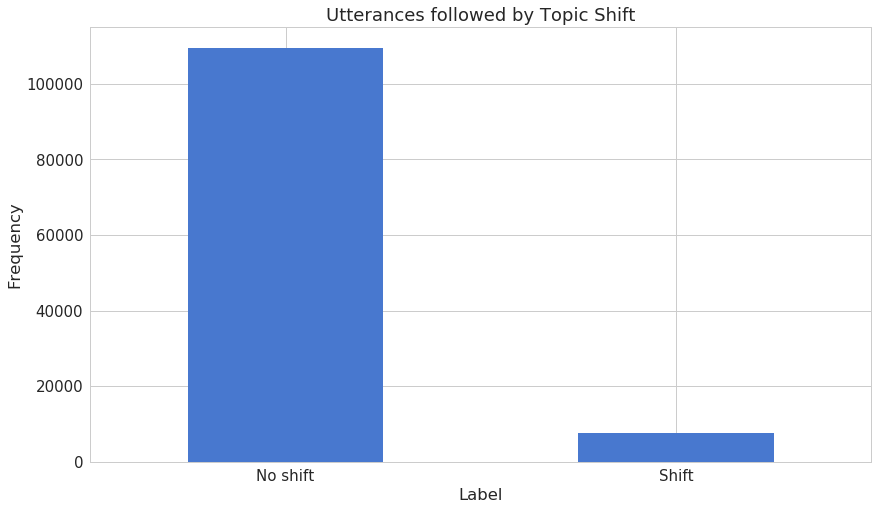

In [5]:
count_classes = pd.value_counts(df['label'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Utterances followed by Topic Shift")
plt.xticks(range(2), LABELS)
plt.xlabel("Label")
plt.ylabel("Frequency");

We have a highly imbalanced dataset on our hands. Normal transactions overwhelm the fraudulent ones by a large margin. Let's look at the two types of transactions: 

In [6]:
shifts = df[df.label == 1]
no_shifts = df[df.label == 0]

In [7]:
shifts.shape

(7595, 33)

In [8]:
no_shifts.shape

(109569, 33)

In [9]:
# shifts.this_current_l.describe()

In [10]:
# no_shifts.this_current_l.describe()

Let's have a more graphical representation:

In [11]:
# f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
# f.suptitle('Sentence length by label')

# bins = 50

# ax1.hist(shifts.this_current_l, bins = bins)
# ax1.set_title('Shift')

# ax2.hist(no_shifts.this_current_l, bins = bins)
# ax2.set_title('No shift')

# plt.xlabel('Sentence length in number of words')
# plt.ylabel('Number of Utterances')
# #plt.xlim((0, 20000))
# #plt.yscale('log')
# plt.show();

# Preparing the data

First, let's drop the Time column (not going to use it) and use the scikit's StandardScaler on the Amount. The scaler removes the mean and scales the values to unit variance:

In [12]:
from sklearn.preprocessing import StandardScaler
data = df

Training our Autoencoder is gonna be a bit different from what we are used to. Let's say you have a dataset containing a lot of non fraudulent transactions at hand. You want to detect any anomaly on new transactions. We will create this situation by training our model on the normal transactions, only. Reserving the correct class on the test set will give us a way to evaluate the performance of our model. We will reserve 20% of our data for testing:

In [13]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.label == 0]
X_train = X_train.drop(['label'], axis=1)

y_test = X_test['label']
X_test = X_test.drop(['label'], axis=1)

X_train = X_train.values
X_test = X_test.values

min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.fit_transform(X_test)

In [14]:
X_train.shape

(87627, 32)

# Building the model

Our Autoencoder uses 4 fully connected layers with 14, 7, 7 and 29 neurons respectively.  The first two layers are used for our encoder, the last two go for the decoder. Additionally, L1 regularization will be used during training:

In [15]:
input_dim = X_train.shape[1]
encoding_dim = 30

In [16]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

Let's train our model for 100 epochs with a batch size of 32 samples and save the best performing model to a file. The ModelCheckpoint provided by Keras is really handy for such tasks. Additionally,  the training progress will be exported in a format that TensorBoard understands.

In [17]:
nb_epoch = 50
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 87627 samples, validate on 23433 samples
Epoch 1/50
87627/87627 [==============================] - 2s - loss: 0.0058 - acc: 0.4665 - val_loss: 0.0042 - val_acc: 0.5587
Epoch 2/50
87627/87627 [==============================] - 2s - loss: 0.0031 - acc: 0.5488 - val_loss: 0.0036 - val_acc: 0.5784
Epoch 3/50
87627/87627 [==============================] - 2s - loss: 0.0029 - acc: 0.5418 - val_loss: 0.0034 - val_acc: 0.5702
Epoch 4/50
87627/87627 [==============================] - 2s - loss: 0.0028 - acc: 0.5536 - val_loss: 0.0033 - val_acc: 0.5656
Epoch 5/50
87627/87627 [==============================] - 2s - loss: 0.0027 - acc: 0.5531 - val_loss: 0.0032 - val_acc: 0.5736
Epoch 6/50
87627/87627 [==============================] - 2s - loss: 0.0027 - acc: 0.5544 - val_loss: 0.0033 - val_acc: 0.5593
Epoch 7/50
87627/87627 [==============================] - 2s - loss: 0.0026 - acc: 0.5626 - val_loss: 0.0033 - val_acc: 0.5796
Epoch 8/50
87627/87627 [==============================] - 2s 

In [18]:
autoencoder = load_model('model.h5')

# Evaluation

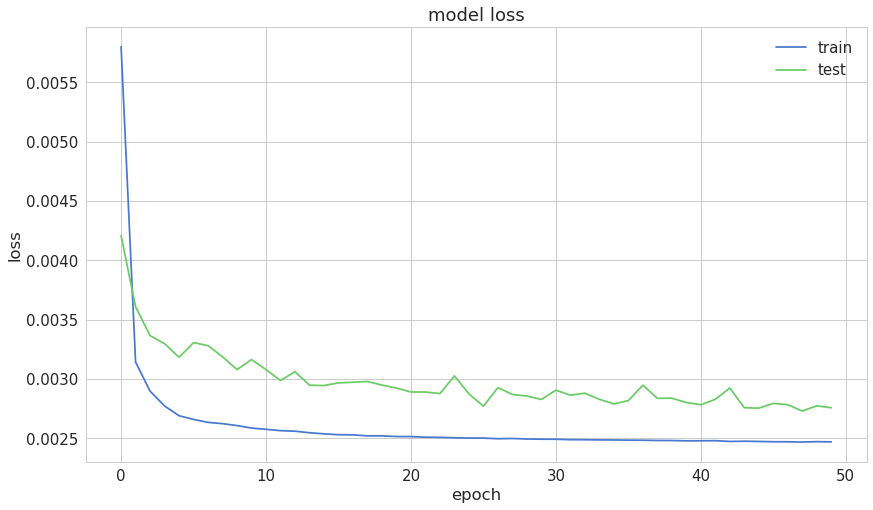

In [19]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

The reconstruction error on our training and test data seems to converge nicely. Is it low enough? Let's have a closer look at the error distribution:

In [20]:
predictions = autoencoder.predict(X_test)

In [21]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [22]:
error_df.describe()

,reconstruction_error,true_class
count,23433.000000,23433.000000
mean,0.002514,0.063628
std,0.002810,0.244095
min,0.000027,0.000000
25%,0.001157,0.000000
50%,0.001466,0.000000
75%,0.002990,0.000000
max,0.034469,1.000000


## Reconstruction error without Topic Shifts

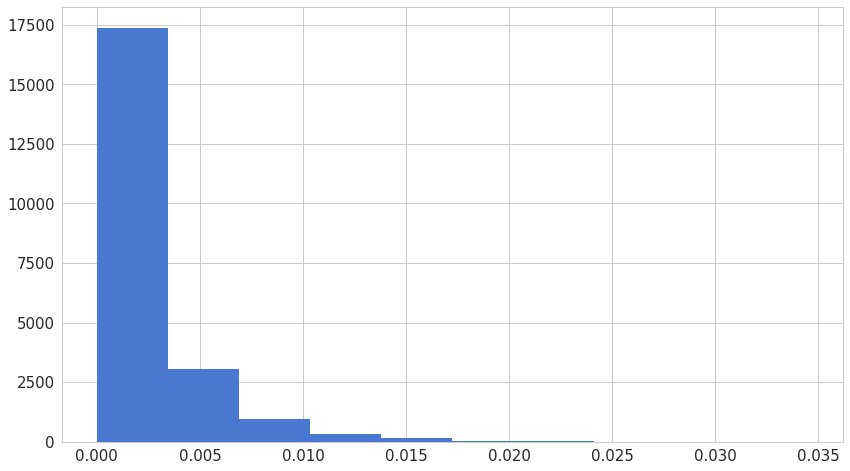

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

## Reconstruction error with Topic Shifts

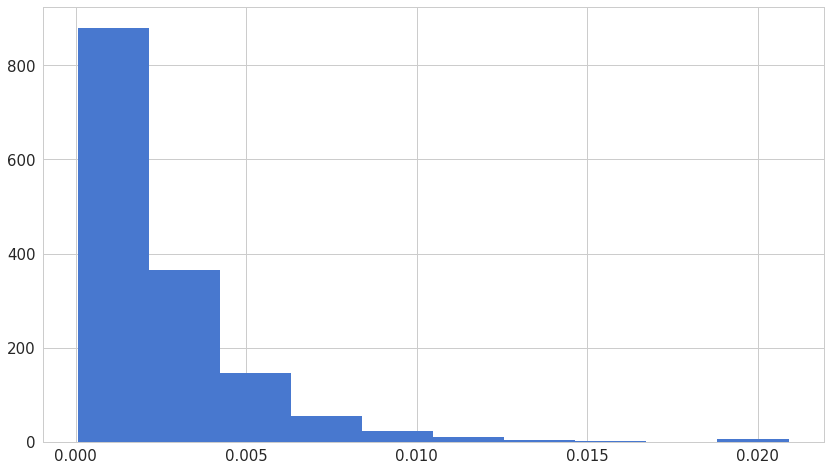

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [25]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

ROC curves are very useful tool for understanding the performance of binary classifiers. However, our case is a bit out of the ordinary. We have a very imbalanced dataset. Nonetheless, let's have a look at our ROC curve:

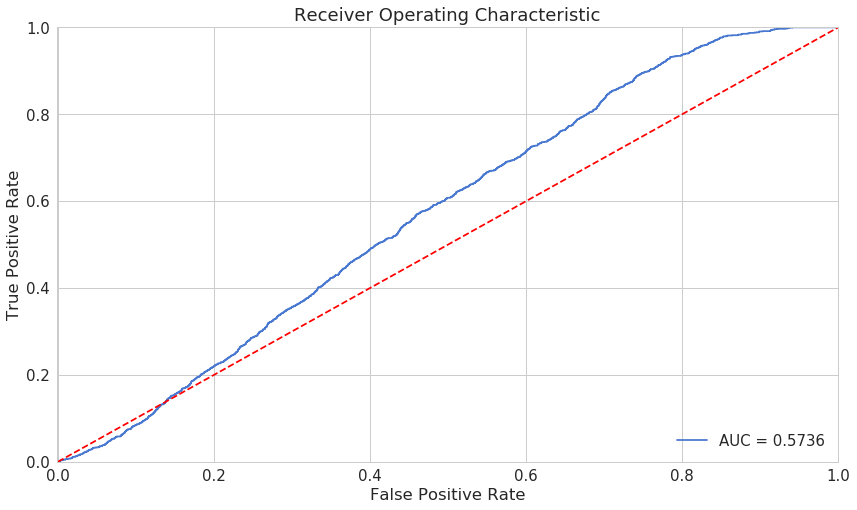

In [26]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

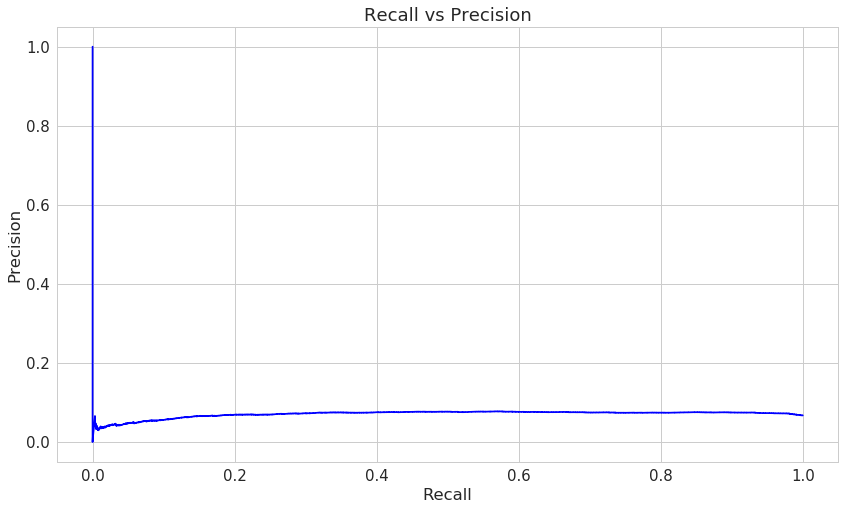

In [27]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

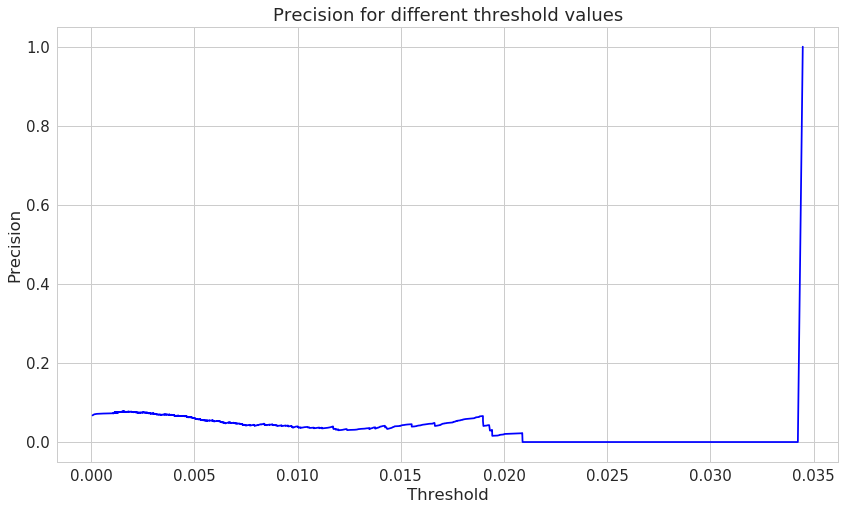

In [28]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

You can see that as the reconstruction error increases our precision rises as well. Let's have a look at the recall:

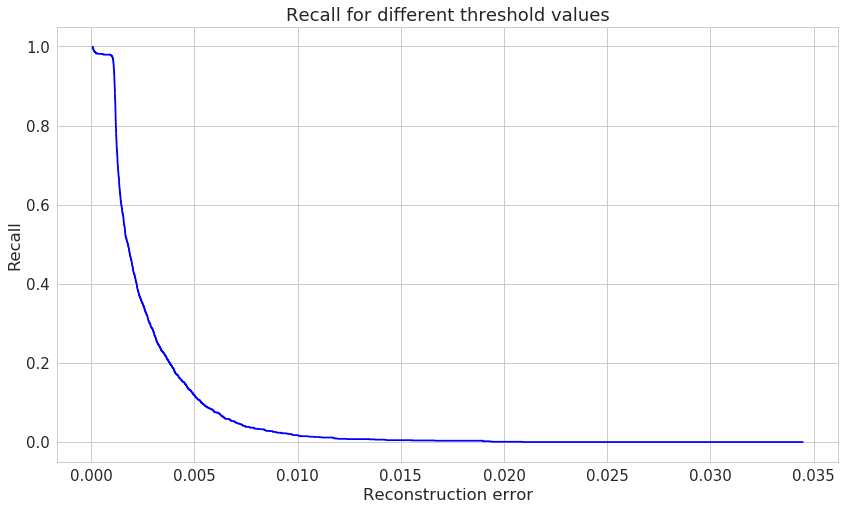

In [29]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

Here, we have the exact opposite situation. As the reconstruction error increases the recall decreases.

# Prediction

Our model is a bit different this time. It doesn't know how to predict new values. But we don't need that. In order to predict whether or not a new/unseen transaction is normal or fraudulent, we'll calculate the reconstruction error from the transaction data itself. If the error is larger than a predefined threshold, we'll mark it as a fraud (since our model should have a low error on normal transactions). Let's pick that value:

In [38]:
threshold = 0.0005

And see how well we're dividing the two types of transactions:

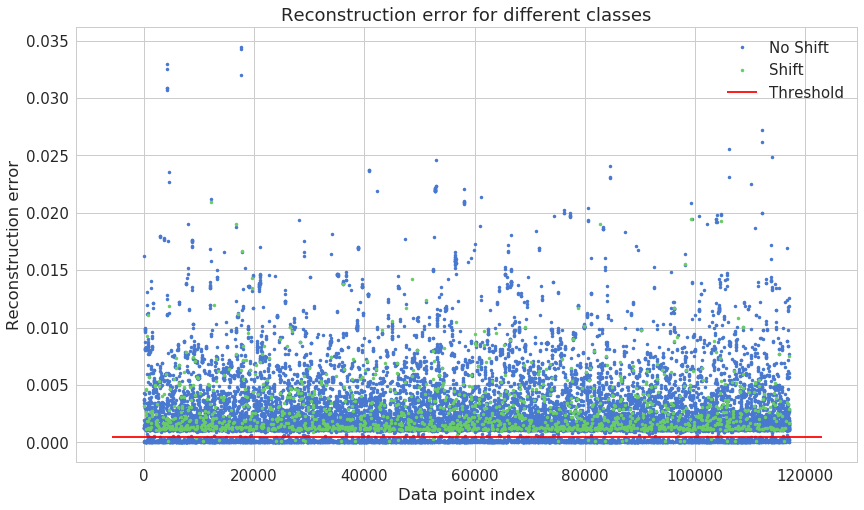

In [39]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Shift" if name == 1 else "No Shift")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

I know, that chart might be a bit deceiving. Let's have a look at the confusion matrix:

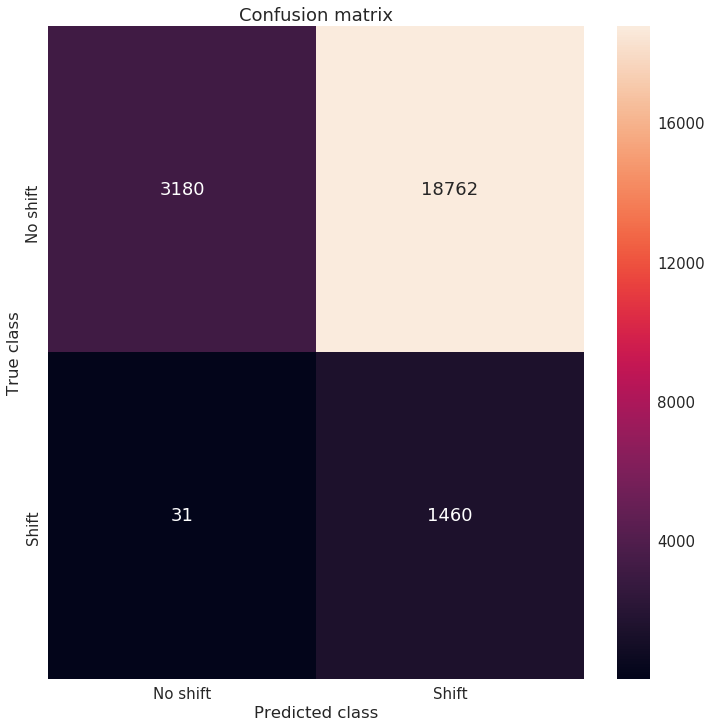

In [37]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA2AAAAH+CAYAAAD6YW2+AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMS4wLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvpW3flQAAIABJREFUeJzs3Xl4TGf/P/B3ElklI7KTSIjIWLKKSEmqElFBg4TUUsS+NE1tLUKrrarQBs1CEIraVbSPrfai6GOth6o9RBJbIiQTkXXO7w+/zNeYSTIhmWzv13W5LnOf+9znc86ZYT5zL0dDEAQBREREREREVOU0qzsAIiIiIiKi+oIJGBERERERkZowASMiIiIiIlITJmBERERERERqwgSMiIiIiIhITZiAERERERERqQkTMCIiknP69GmIxWLs2LGjukOpM/bt24c+ffrAxcUFYrEYp0+frtZ4hg0bBj8/v3LLgNJjv3r1KkJDQ+Hp6QmxWIzY2Fi1xF6T7dixo0bcXyKq2RpUdwBEVPedPn0aw4cPlyszMDBA8+bN0bdvXwwdOhQNGtTtf46ys7Oxbt06dOzYEV5eXtUdDq5evYpDhw4hKCgINjY21R1OnXbnzh1MmzYNbm5u+PLLL6Gjo4OWLVtWd1gqKS32oqIihIeHo6ioCJMmTYKRkRHEYnF1h6uSmvZZJKL6p25/4yGiGuWDDz5Aly5dIAgCMjIy8J///AeRkZG4ffs2vv322+oOr0plZ2cjLi4On3zySY340nf16lXExcWhY8eOCgmYp6cnLl26VOeTYnU5c+YMioqKMGvWLLRr1666wynV6tWrFcpKi/3OnTtISUnBzJkzMXToUHWG+dZq2meRiOofDkEkIrVp27Yt+vbti379+mHMmDHYunUrrKys8MsvvyAzM7O6w6txcnJyquW4mpqa0NXVhZaWVrUcv7KUdf0KCwuRn59f5ccBgPT0dABAo0aNKuV4JSrzHABAR0cHOjo6cmWlxZ6RkaG0vDJU1/ueiEhdmIARUbUxMDCAq6srBEHAvXv3FLZfvnwZYWFh8PLygpOTE3r06IH4+HgUFRUp1E1OTkZERAS6dOkCJycn+Pj4YOLEifjnn3/k6h06dAiDBg2Cu7s73N3dMWjQIBw6dEihPT8/PwwbNgy3b9/GuHHj4O7uDg8PD3z66aeyL6Ulnj17hvnz58Pf3x/Ozs7w8vJCcHAwVq1aBeDlEMxu3boBAOLi4iAWiyEWi2XzbVJTU2VzaPbu3Yvg4GC4uLhg3rx5AEqfm/Pqfq8SBAHbtm1DSEiI7DwDAwMRHR0NAIiNjUVERAQAYPjw4bJ4Zs6cKYtX2Ryw3NxcLFq0CP7+/nBycoK3tzemT5+OtLQ0uXqv7p+YmIjevXvDyckJvr6+SEhIUDiPsuzduxeDBw+Gu7s7XF1dERISgn379inUK4n/r7/+ktWfOHGi7HzFYjFu3ryJyMhIdOnSBS4uLrh48aJs/19++QVBQUFwcXGBh4cHRo0ahXPnzlXoOMq8en+6desmd9+Bl/fw888/R+fOneHk5AR/f38sXrwYL168kGtHlXNQJisrC1988QW8vLzg5uaGYcOGKXwmSrz+Pist9mHDhsl6vSIiImTvn9TUVAAv33+bNm1CcHAwXF1d4e7ujmHDhuG///2v3PHKe98DwOPHj/HVV1+ha9euss/1l19+iSdPnii9PklJSVi8eLHs34E+ffrg2LFjsnrlfRbLUlBQgISEBPTt2xeurq7w8PBAcHAwNmzYUOZ+OTk5WLJkCUJCQmT/lnXv3h1RUVEK91kQBKxduxaBgYFwd3dH+/bt0aNHD8yaNQuFhYWyehcuXMCYMWPg7e0NZ2dnvPvuuxg7dqzC+0EikeCHH35A9+7d4eTkhHfeeQdTp05FSkqKXL38/HzExsaiR48ecHV1RYcOHRAYGIiFCxeWe12IqOI4voSIqlXJF4HXf0k/duwYwsLCYGdnh1GjRqFRo0a4ePEiYmJicPXqVcTExMjqXr58GSNGjEBRUREGDBiAVq1aISsrC2fOnMHff/8NJycnAMDGjRsxd+5c2Nvby740//rrrwgLC8PcuXMxcOBAuRgePXqE4cOHw9/fH9OnT8e1a9ewdetW5OTk4KeffpLVmzRpEs6dO4eBAweidevWePHiBZKSknDmzBmMGTMGLVu2REREBCIjI9G9e3d0794dANCwYUO54x06dAjr16/H4MGDMWjQIBgaGr7RNf3888+xa9cuuLq6YsKECTAyMkJSUhL279+PSZMmoXv37khPT8fWrVsxYcIE2NvbAwBsbW1LbbOoqAijR4/GhQsX0KNHD4wcORLJycnYvHkzTp48icTERFhZWcnts2XLFmRkZGDAgAEQiUTYuXMnoqKiYGVlhcDAwHLPY8mSJVi+fDneffddTJo0CZqamjh48CAmTZqEOXPm4KOPPpKr/88//2D//v348MMPERQUpNDeZ599Bj09PYwaNQoAYG5uDgD44YcfsGrVKri4uGDq1KnIycnBtm3bEBoaimXLluG9996r0HFe9f333+PgwYM4ePAgIiIi0LhxY9l9T0tLQ0hICCQSCQYPHozmzZvjzJkzWLFiBS5cuIC1a9cqDAMt7RyUKSwsxOjRo3H58mVZ0nDt2jWMHDkSxsbGZcZdVuz6+vpo3749li9fjoEDB8LDwwMAYGJiAuDl+2/Pnj3o0aMHgoODUVBQgF27dmHUqFGIjY2VJUAlSnvf379/HwMHDkRhYSEGDBgAW1tb2Xvu9OnTSExMhJGRkVxbM2fORIMGDTBq1CgUFhZi3bp1CAsLw759+2BjY6PyZ/F1BQUFGD16NM6cOQMfHx/06dMHurq6uHHjBg4cOFDmMMxHjx5h+/bteP/99/HBBx+gQYMGOHPmDFatWoWrV6/KDf1ctmwZYmJi4Ovri0GDBkFLSwupqak4cuQICgoKoK2tjaSkJIwaNQpmZmYYPnw4TE1NkZGRgQsXLuDatWtwc3MD8DL5GjRoEO7fv4/+/fujVatWSE9Px6ZNmxASEoLExERYW1sDAL755hskJiaiX79+cHNzg1Qqxd27d7mYCFFVEYiIqth///tfwdHRUYiNjRWePHkiPHnyRLh27Zrw9ddfC46OjkL//v3l6ufl5QmdO3cWhgwZIhQWFsptW7NmjeDo6Cj897//FQRBEKRSqdC7d2/ByclJuHr1qsKxi4uLBUEQhGfPnglubm6Cv7+/IJFIZNslEonQrVs3wc3NTcjKypKV+/r6Co6OjsKePXvk2iuJ+datW4IgCEJ2drbg6OgofPXVV2Veg5SUFMHR0VGIiYkpdVvbtm1l7b5q6NChgq+vr0pt7tmzR3B0dBQ+++wz2bm/fi0EQRASExPlruOrSu5XYmKirGzr1q2Co6OjsHDhQrm6f/zxh+x4r+/v7e0td01zc3MFLy8v4cMPP1Q45uv++ecfwdHRUVi0aJHCtokTJwru7u5y99HR0VFwdHQUTp48qVA/JiZGcHR0FIYOHarwfrp9+7YgFouFQYMGCfn5+bLyhw8fCh4eHoKvr69QVFSk0nFKU3L8lJQUufKpU6cKjo6OwtGjR+XKFyxYIDg6Ogrbtm1T6RxKs2XLFsHR0VGIjo6WKy/5DL3+nlL2PistdmXvEUEQhAMHDgiOjo7Cli1b5MoLCwuFoKAgwdfXV5BKpYIglP++nzBhgvDOO+8IDx48kCu/dOmS0KZNG7n3fUmc48aNk7UvCILwv//9T3B0dBSioqJkZWV9FkuzcuXKUt+P5X2u8vPzhYKCAoX9lixZIjg6Ogr/+9//ZGX9+vUTevbsWWYs69atU9hPmW+//VZwdnZW+HcxNTVVcHd3F2bMmCEr8/T0FMaMGVNme0RUeTgEkYjUJjY2Fp06dUKnTp3Qp08fbNq0Ce+//z7i4+Pl6p08eRIZGRkIDg5GdnY2MjMzZX+6dOkiqwO8XEzi5s2bCA4ORuvWrRWOqampKaufm5uLYcOGyfUsGRoaYujQocjNzcWpU6fk9rWwsECvXr3kyt555x0AkA2Z1NXVhY6ODi5duiQbgvWm3nvvvbdeHW/Xrl0AgBkzZsjOvcTrryvi4MGD0NTUxPjx4+XKu3btijZt2uDw4cOQSqVy2/r37w+RSCR7ra+vDzc3N9y9e7fc4+3atQsaGhro16+f3P3PzMyEn58fnj9/rjDcqnXr1ujcuXOpbYaGhir0KB0+fBiCIGDMmDFy858sLS0RFBSEtLQ0/PvvvxU6jiqkUimOHDmCtm3bKvSwjR8/HpqamkqHxio7h9IcOnQIWlpast6yEkOGDHnj3tXy7Ny5Ew0bNoS/v7/cPcvOzoafnx/S0tIU7r+y971EIsHRo0fh5+cHHR0dubasra1ha2sr+zfgVcOHD4eGhobstYuLCxo2bIjk5OS3Oq9du3ahUaNGCAsLU9hW3udKR0cH2traAF72JGdlZSEzM1P2Hvrf//4nq2toaIhHjx4pHf5aoqTX7/Dhw6XOARQEAbt27YKnpycsLCzkrl/J5/DEiRNyx7116xZu3LhR5rkQUeXgEEQiUpuBAwciICAAhYWFuHHjBlatWoWHDx9CV1dXrt7t27cBALNmzSq1rZJFAEq+zLVt27bMY5ckR61atVLY5ujoCAAK8yKaNWumULdk6NazZ88AvPxyNWvWLHz33Xfo1q0bHBwc8M4778Df3x+dOnUqM6bXNW/evEL1lUlOToa5uTnMzMzeuq1XpaamwsLCQumiCw4ODrh69SqePn0KU1NTWbmy5e2NjY1l164st2/fhiAI6NmzZ6l1St4DJcq7fsq2q/q+cHZ2Vvk4qsjMzERubi4cHBwUthkbG8Pc3Fzh/VjRY6ekpMDc3Fwh2dLR0UGzZs2QnZ1d4bjLc/v2bTx//rzMBPXJkydo0aKF7LWyc7pz5w6kUim2b9+O7du3K21H2eeztM/s06dPVYi+dMnJyWjTpo3Cv1Wq2rhxI7Zs2YJbt24p/FCRlZUl+/vUqVMRFhaGjz76CBYWFujYsSO6du2KHj16yH4g6N27N3bu3Inly5dj7dq1cHV1hY+PD3r37i0bUpiZmYlnz57hxIkTpf479GriOGvWLEyfPh2BgYFo1qwZvLy84OvrCz8/v7f64YaIlGMCRkRqY2dnJ/ti9t5778HDwwNDhgzBV199hSVLlsjqCYIAAJg+fTratGmjtC0LCwu516/+6l1ZyloFsCRGABg8eDC6deuGY8eO4cyZM9i/fz82bNiAXr16yZ1XefT19SsUX3FxsdK4quJavHq+qnqbVRRLziMhIaHUdl5PXsq7fnp6ekqPU1EVvU/KvMlxAeXnUNYxSnsvvOnxVTmmiYkJFi1aVGqd15NdZdezJL4+ffqUOs9OWTJUE5OFNWvWYMGCBfDx8cHw4cNhYWEBbW1tPHr0CDNnzpS7F+7u7jh48CBOnDiB06dP4/Tp09i9ezfi4+OxadMmGBsbQ0dHB2vWrMGlS5fw559/4ty5c4iJiUFcXBwWLVqE7t27y9rs3Lkzxo4dW26M/v7+OHLkCI4dO4azZ8/i1KlT2L59Ozp06IA1a9YorI5JRG+HCRgRVZv27dujb9+++O233zBs2DC0b98ewP/9Iq6vr1/uUK+SX9JfHyb2upJfxm/evKnwi/CtW7fk6rwJCwsLhISEICQkBMXFxZg+fTp2796NkSNHwsXF5a2SImNjY1y5ckWhXFkPSYsWLXD48GFkZGSU2QtW0XhsbW3x559/Ijs7W25YIfCy18PQ0BCNGzeuUJtlad68Of788080bdq0Sh9aXLLwyM2bNxUWIamM90VpTE1N0bBhQ9kxXpWVlYX09PRSf3xQVckwvZycHLlesIKCAqSmplbJEvJ2dna4e/cuXF1dy13Yoiy2trbQ0NBAYWHhWw/3fN2bfBabN2+OpKQkFBQUVDgZ+c9//gNra2skJCTIJYjHjx9XWr9hw4bo0aMHevToAeD/Fg/avn07xowZI6vn4uICFxcXAMCDBw/Qr18//Pjjj+jevTtMTEwgEomQk5Oj8vUzNjZG37590bdvXwiCgKioKKxatQqHDx8usyeaiCqu5v1URET1yscffwwtLS25VQ19fHxgamqKhIQEpcPV8vLyZM8Kat26NVq1aoXExETcvHlToW7JL8He3t4wMDDAhg0b5J4zlJOTgw0bNsDAwADe3t4Vjv/FixcKS0lraWlBLBYD+L/hRQYGBnKvK6J58+Z4/vw5Ll26JCuTSqVYu3atQt2S1QV/+OEHhaFOr/7SXtF4/P39IZVKsXLlSrnyY8eO4d9//630oUp9+vQBACxevFhpT9/ry5C/KT8/P2hoaGD16tVyy3w/fvwYO3bsgLW1dbnDW9+EpqYmfH198e+//yp8EV+5ciWkUin8/f3f6hjdunVDcXGx3IqdALBp06Yqe9ZWv379IJVKsXjxYqXbXx82WprGjRvjvffew8GDB5UutS8Iwhs/O/BNPouBgYHIysrCsmXLlMZSFk1NTWhoaMjVKyoqUvpIBmXnVPIA7JJ4ldWxsrKCiYmJrI6mpiYCAwNx6dIlpY9tAP7vM1RcXKwwHFVDQ0P2vn+Tf7OIqGzsASOiamVnZ4devXph165dOHfuHDp06AADAwMsXLgQYWFhCAgIQP/+/WFnZ4fs7GwkJSXh4MGDiIuLg5eXFzQ0NDB//nyMGDECISEhsmXos7OzcfbsWbz77rsYNmwYRCIRPvvsM8ydO1du+fBff/0VycnJmDt3rsKS1qq4e/cuhg4diu7du6NVq1YQiURISkrC5s2bYWNjgw4dOgB4+YXSzs4Oe/bsQbNmzWBmZgZ9fX2Vnj/04YcfYs2aNQgLC8Pw4cOhra2N/fv3K01MevbsiQMHDuC3335DcnIy/Pz8IBKJcPfuXZw4cQK7d+8GADg7O0NTUxPLly9HVlYWDAwMYGNjA1dXV6UxBAUF4ddff0VCQgLS0tLQoUMH3Lt3D5s2bYKZmRmmTp1a4WtXFhcXF4SHhyM2Nhb9+vVDjx49YGlpicePH+PKlSs4fvx4qc+zqgh7e3uMHj0aq1atwtChQ9GzZ088f/4c27ZtQ25uLqKioqrsgdRTp07FqVOnEBYWhiFDhsDW1hbnzp3D3r174enpWe4S9+UJDg7Gtm3bsHTpUqSmpsLNzQ1Xr17Fvn37YGtrq/T987YCAgJkz8a6cuUKfH190bhxYzx8+BAXL15EcnIyDh8+rFJbX3/9NYYMGYKhQ4eib9++aNu2LaRSKVJSUnD48GH069cP4eHhFY7xTT6Lw4cPxx9//IH4+HhcvnwZPj4+0NHRwa1bt3Dnzh2lP4aUCAgIwKJFizB27Fh0794dOTk52L17t9LFVHr16gU3Nze4uLjAwsIC6enp2LZtG7S1tdG7d28AQHx8PE6ePImuXbvCxsYGgiDgjz/+QFJSklwP2ZQpU3DhwgVMnjwZPXv2hKurK7S1tXH//n0cP34c7dq1w4IFC/D8+XP4+PjAz88Pbdu2hYmJCVJTU7F582Y0atQIvr6+Fb7GRFQ2JmBEVO0mTpyIPXv2IDo6GuvXrwcAvPvuu9i+fTtWrlyJnTt34unTpxCJRLC1tcWIESNkPUzAyy/r27dvx7Jly/D7779jy5YtMDY2houLi2xYIwDZxPbVq1dj6dKlAF72oC1duvSNexusrKzQv39/nD59GocOHUJBQQEsLS0REhKCsWPHys1viYqKwvz587FkyRK8ePEC1tbWKiVgzZo1w9KlS7F48WJER0fLhgr1799f6dCgRYsWoUOHDti+fTuWLl0KTU1N2NjYICAgQFanadOmmD9/PhISEvDNN9+gsLAQQUFBpSZg2traWL16NeLj47F3714cPHgQRkZGCAgIwOTJk9GkSZM3uHpl++STT+Dk5IT169fj559/Rm5uLkxNTdGqVasyF2ipqM8//xx2dnbYtGkTFi1aBG1tbbi6usquY1WxtrbGtm3bEBMTg507d0IikcDS0hLjx4/HxIkTVV7tsDQ6Ojr46aef8P333+Pw4cM4cOAAnJ2dZWWvP0C7skRGRsLLywvbtm3DihUrUFhYCHNzc7Rt2xbTpk1TuZ0mTZogMTERCQkJOHLkCHbu3AldXV00adIEvr6+bzUsrqKfxZJr+dNPP2H37t1YvHgxdHV1YWdnh+Dg4DKPNXr0aAiCgO3bt+O7776Dubk5evbsif79+yussjpq1CgcO3YM69evh0QigampKVxdXTF+/HjZKq/+/v5IT0/Hvn37kJGRAT09PdjZ2WHevHkYMGCArC0jIyNs3rwZP/30E/bt24fDhw9DS0sLVlZW8PDwQEhICICX8wpDQ0Px119/4a+//sLz589hYWEBPz8/jB8/HpaWlm96mYmoFBpCVc3EJSIiIiIiIjmcA0ZERERERKQmTMCIiIiIiIjUhAkYERERERGRmjABIyIiIiIiUhMmYERERERERGrCZegr6Pz589UdAhERERER1XAeHh5Ky5mAvYHSLmZ9dP78eV6PWoj3rXbifau9eO9qJ9632on3rXaqa/etrE4bDkEkIiIiIiJSEyZgREREREREasIEjIiIiIiISE2YgBEREREREakJEzAiIiIiIiI1YQJGRERERESkJmpPwG7duoXQ0FC4urrCx8cH0dHRKC4uLnc/iUSCiIgIeHp6wsPDA9OmTcPTp0/l6sTExCAwMBDt27eHu7s7goODsXfvXrk6qampEIvFCn+mTJlSqedJRERERET0OrU+BywrKwsjRoyAg4MDli1bhnv37mHhwoWQSqXlJkCTJ0/GnTt3MG/ePGhqaiIqKgphYWHYtGmTrE5OTg6CgoLQsmVLaGlpYf/+/ZgyZQo0NTUREBAg196MGTPQvn172evGjRtX7skSERERERG9Rq0J2JYtW5Cfn4+4uDgYGhrC29sbOTk5iIuLw9ixY2FoaKh0v7///hsnTpzAhg0b4OnpCQCwtLRESEgITp06hc6dOwMAZs2aJbefj48Pbt68id9++00hAWvRogXc3Nyq4CyJiIiIiIiUU+sQxOPHj8PHx0cu0erduzfy8vJw5syZMvczMzOTJV8A4OLiAhsbGxw/frzMYxobG6OwsPDtgyciIiIiInpLak3AkpKSYG9vL1fWtGlT6OvrIykpqUL7AUDLli2V7ldUVITs7Gzs3LkTJ0+exODBgxXqREREoE2bNvDx8UFkZCTy8vLe4IyIiIiIiIhUp9YhiNnZ2TAyMlIoF4lEyM7OfqP9UlNT5couXryIgQMHAgAaNGiAL7/8Ev7+/rLtOjo6+Oijj+Dt7Q1DQ0OcOXMGCQkJuHfvHuLj49/01IiIiIiIiMql1gQMADQ0NBTKBEFQWq7Kfq9zdHTE9u3bIZFIcPToUXz77bcwNDTEBx98AACwsLDAnDlzZPW9vLxgamqKb775BlevXkWbNm3KPYfz58+XW6c+4fWonXjfaifet9qL96524n2rnXjfVLN9+3bs2LEDzs7OiIiIkNv2448/QiKR4Msvv3zr41y7dg07duxAcnIyCgoKYGxsDLFYjJCQEJiamgIAPv30U3h5eeGjjz4qtZ1///0X8+bNw8KFC9GsWTMAwNOnT7Fy5UrcuHEDL168wBdffIHs7Gzk5+fjvffee+vYq4JaEzCRSASJRKJQnpOTo7SH69X9MjMzFcolEglEIpFcmYGBAZydnQEAnTt3hkQiQVRUlCwBUyYgIADffPMNrly5olIC5uHhUW6d+uL8+fO8HrUQ71vtxPtWe/He1U68b7UT75vqTp06BQC4fPkytLW14eLiIttWskL4217Lc+fO4bvvvoO/vz8+/vhj6Onp4fbt29i9ezdMTU3l2re0tCzzeGKxGM7OzmjdujX09PQAAHPnzsWDBw8QHR2NRo0awcHBAbNmzcLTp08xderUt4r9bZT1I4BaEzB7e3uFOVsPHjxAbm6u0jler+6n7CSSkpLkhhcq065dO+zYsQOFhYXQ1tYus255vXBERERERHWJsbExLC0tsXz5cixbtqzS29+8eTNatmyJ6Oho2Xdtb29vDB8+XOlotrIYGhoqrGKelJQEV1fXGtvbpYxaF+Ho0qULTpw4gZycHFnZ3r17oaenh44dO5a5X3p6Os6dOycru3z5MlJSUtClS5cyj3nhwgVYWVmVmXzt378fwMtkjYiIiIioPpkwYQKOHDmC69evl1nv6tWrCA0NhaurKzw9PTFt2jRkZGSUuY9EIoGJiYnSjg5lZWvXrkWXLl3g6emJKVOmyK0Tcfr0aYjFYty4cQPAyx6xv/76CwcPHoRYLIafnx9mzpyJ/fv348yZMxCLxRCLxYiNjVXlMqiNWnvABg0ahPXr1yM8PBxjx45FSkoK4uLiMGLECLml6bt37w5PT0/Mnz8fAODu7g4fHx/MmDEDM2bMgKamJn744Qd4eHjIngGWlpaGiIgIBAYGwsbGBrm5uTh06BD27NmDr7/+WtZ2bGwsnj9/jvbt28PQ0BBnz57F6tWr8f7776N169bqvBxEb+1FfjGSH+XBzlIP+rpa1R0OERERvaHq/D89ICAAMTExWL58OZYsWaK0TmZmJoYNG4aWLVti0aJFeP78ORYtWoSRI0ciMTEROjo6Svdr27Ytli9fjqVLl6JPnz6yuVvK/P777xCLxfj222/x8OFDLFiwAIsXL5b7Lv+qrVu34ptvvoGRkRGmTp0KHR0dGBoa4v79+5BIJPjqq68AAFZWVhW7IFVMrQlYo0aNsHbtWsydOxcTJkyASCRCaGgowsPD5eoVFxdDKpXKlS1ZsgSRkZGYNWsWpFIpfH19MXv2bNl2kUgECwsLxMfHIz09HSKRCC1btsTKlSvluiTt7e2xevVq/PLLL8jPz0eTJk0wevRoTJw4sWpPnqiSvcgvxqSlN5CSno9m5rqIDnNkEkZERFQLVff/6Zqamhg3bhxmz56NTz/9FC1atFCo89NPPwEAVq9eLes4adGiBUJCQnDgwIFS11sYM2YMLly4gJiYGMTExMDc3Bx+fn4YOXKkwnEaNGiApUuXokGDlynKrVu3sHfv3lITMDc3NxgaGsLY2FhuaKKxsTEEQVAXTrpSAAAgAElEQVQYrlhTqH0VRAcHB/z8889l1jly5IhCmUgkQmRkJCIjI5XuY2RkhKioqHKP37t3b/Tu3Vu1YIlqsORHeUhJzwcApKTnI/lRHlrbNqzmqIiIiKiiasL/6X369EFcXBxWrlyp9Pv2pUuXZI9xKuHi4gJra2ucP3++1ATM0NAQ69atw8WLF3H06FGcPXsW27dvx65du7Bhwwa5KUBeXl6y5At4mTc8efIEBQUFpfaw1UZqnQNGRJXHwlgbDbRejp1uoKUBC+OyF5khIiKimsnOUg/NzHUBAM3MdWFnqaf2GBo0aIAxY8Zg586dSEtLU9ienp4OMzMzhXIzMzNkZWWV2baGhgbc3d0xZcoUbNq0CYmJidDQ0FBY9OP11c21tbUhCAIKCwvf4IxqLiZgRLXU42eFKCp+uXpQUbGAx8/q1j9ORERE9YW+rhaiwxyxZGKrap1SMGDAAJiYmCAhIUFhm7m5OZ48eaJQnpGRgUaNGlXoOG3atIG3t7fC6uj1BRMwolqqJvxaRkRERJVDX1cLrW0bVut8bh0dHYwePRqJiYl4/Pix3DZXV1eF1cwvXbqEtLS0Mp/dpSxpEwQB9+7dU9qjVhm0tbWRn59fJW1XBrXPASOiylHyaxlXQSQiIqLKMnDgQCxfvhx///233GOiRo4cic2bN2PMmDEYM2YMcnNzsWjRIjg6OuL9998vtb3Zs2dDEAS8//77sLW1RVZWFnbs2IFr164hOjq6Ss6hRYsWOHz4MA4dOgRLS0tYWFjA0tKySo71JtgDRlSL1YRfy4iIiKju0NfXx4gRIxTKTUxM8PPPP0NHRwfTpk3D3Llz0aFDB6xZs6bMBTKGDBkCAwMDLF26FKNGjcJXX32F58+fY/Xq1QgICKiScxgyZAi8vb0xa9YsDBgwANu2bauS47wpDaGij6Cu586fP19mN2t9w+tRO/G+1U68b7UX713txPtWO/G+1U517b6VdT7sASMiIiIiIlITJmBERERERERqwgSMiIiIiIhITZiAERERERERqQkTMCIiIiIiIjVhAkZERERERKQmTMCIiIiIiIjUhAkYERERERGRmjABoxrpRX4xrt17jhf5xdUdChERERFRpWECRjXOi/xiTFp6A1Pib2LS0htMwoiIiIiqyI4dOxAcHAx3d3d4enqiX79+iIyMlG1PTU2FWCzGH3/8UWY7sbGx8PLykis7f/48goKC4OzsDLFYDABISEjA6dOnK/9EahEmYFTjJD/KQ0p6PgAgJT0fyY/yqjkiIiIiorpnxYoV+OKLL+Dj44O4uDgsXLgQ3bp1w5EjRyrcVkhICFavXi1X9tVXX8HIyAirV6/G1q1bAQCrVq3CmTNnKiX+2qpBdQdA9Do7Sz00M9dFSno+mpnrws5Sr7pDIiIiIqpzNmzYgIEDB2Lq1KmyMj8/P3zyyScVbsvKygpWVlZyZUlJSfjwww/RsWPHt461LmEPGNU4+rpaiA5zxJKJrRAd5gh9Xa3qDomIiIiozpFIJDAzM1Mo19DQUCh78eIF5syZAw8PD3Tp0gUxMTGQSqWy7a8OQTx9+jTEYjGKi4vx3XffQSwWY+bMmfDz88OzZ88QFxcHsVgMsVhcL4cjMgEjIiIiIqqH2rZtiw0bNuDXX3/F06dPy6wbFRUFAwMDxMTEoE+fPli6dCn27duntG67du1kQw5HjRqFrVu34uOPP0ZcXByMjIwwYMAAbN26FVu3bkW7du0q/bxqOg5BpBqnZBGOkiGI7AUjIiKiui6vOA8P8u6jiV5T6GmpZ/rFnDlzEBYWhpkzZ0JDQwMtW7bE+++/j9GjR8PQ0FCubocOHTBz5kwAgLe3N/78808cPHgQvXr1UmjX0NAQbm5uAABra2vZ3wFAS0sLVlZWcmX1DXvAqMbhIhxERERUn+QV5+H7a/MRdW0Bvr82H3nF6vnu07p1a/z++++Ij4/HkCFDIAgCli1bhv79++P58+dydb29veVeOzg44OHDh2qJs65hAkY1TskiHAC4CAcRERHVeQ/y7uNR3stk5lHeQzzIu6+2Y+vo6MDPzw9z5szB3r17MW/ePNy9exfbt2+XqycSieRea2trIz8/X21x1iUcgkg1TskiHMmP8mBnqcfhh0RERFSnNdFrCks9KzzKewhLPSs00WtabbGEhIQgKioKSUlJ1RZDXccEjGokfV0ttLZtWN1hEBEREVU5PS09TG89S+1zwJ48eQJTU1O5sszMzFJXR6wM7DljAkZUq73IL2ZPIRERUR2gp6WHFg3t1XrMwMBAdOvWDd7e3jA1NUVaWhp++ukn6OnpoV+/flVyTHt7exw7dgzvvvsuDAwM0KJFC4UFP+o6zgEjqqVKVoucEn8Tk5bewIv84uoOiYiIiGqRsLAwpKWlYd68eRg1ahRiYmLQqlUr/PLLL2jWrFmVHHP69OnQ19fH+PHjMWDAAFy5cqVKjlOTsQeMqJZStlokh20SERGRqj766CN89NFHZdaxsbHB9evXFcoXLFgg9zo8PBzh4eFyZcr2c3JywrZt294g2rqDPWBEtRRXiyQiIiKqfdgDRlRLcbVIIiIiotqHCRhRLcbVIomIiIhqFw5BJCIiIiIiUhMmYERERERERGrCBIyIiIiIiEhNmIARERERERGpCRMwIiIiIiIiNWECRkREREREpCZMwIiIiIiIiNSECRjVSJnZBdh/9gkyswuqOxQiIiKiOkcsFpf75/Tp09ixYwfEYjGeP39ebbFWZgyxsbHw8vIqt15wcDBmzpz51sdThg9iphonM7sAod9fRVGxgAZaGlg3vQ1MRDrVHRYRERFRnbF161bZ3/Py8hAaGoqJEyeia9eusnIHBwekpaVVQ3R1GxMwqnHOXpegqFgAABQVCzh7XYIenqbVHBURERFR3eHm5ib7e0nPkq2trVz52ygsLISmpia0tLQqpb26hEMQqcZxbtGwzNdEREREpF6pqakYOXIk3NzcEBAQgAMHDshtHzZsGD799FNs3boV/v7+cHFxwePHjwEAN27cwLhx4+Du7g53d3d8+umnSE9Pl+1bWFiIjRs3omvXrnBycoKPjw/CwsJQUFBQoRgAYMOGDXj//ffh5OSE7t27Y+3ateWe240bNzBo0CA4OzujZ8+eOHz48BtcIdUxAaMaJzu3uMzXRERERKRen332Gfz8/BAXF4fmzZtj6tSpePjwoVydCxcuYPPmzfjss8+wfPlyGBkZITk5GYMHD0Z+fj5++OEHLFiwALdu3cKECRMgCC9HPK1YsQInT57EpEmTsGbNGsyaNQtGRkaQSqUVimHbtm349ttv4efnh+XLlyMgIAALFizAypUrSz2vvLw8jB49Grm5uVi0aBEmTpyI+fPn48GDB5V49eRxCCLVOHaWemhmrouU9Hw0M9eFnaVedYdEREREpJrmzavnuHfvVmnzoaGhGDBgAACgXbt28Pb2xh9//IHBgwfL6mRnZ+PXX3+Fubm5rOybb76BmZkZEhISoKPzck6/WCxGz549cezYMXTt2hWXL19G586dERQUJNuvV69eFYpBKpUiNjZWbvEMHx8fSCQSrFixAqGhodDV1VVoMzExEZmZmfjll19gZWUFALC2tsaQIUPe9pKVSu09YLdu3UJoaChcXV3h4+OD6OhoFBeX38MhkUgQEREBT09PeHh4YNq0aXj69KlcnZiYGAQGBqJ9+/Zwd3dHcHAw9u7d+0ZtUfXR19VCdJgjlkxshegwR+jrcuwwERERUXXy8fGR/b1x48YwMTFR6AFr166dXPIFAH/99Re6d+8OTU1NFBUVoaioCDY2NrC2tsY///wDAGjdujWOHz+OhIQEXLt2TdYzVpEYHj58iMePHyMgIEBun169eiEnJwfXr19X2ubly5fRrl07WfIFAB4eHjA1rbr1B9TaA5aVlYURI0bAwcEBy5Ytw71797Bw4UJIpVJMmTKlzH0nT56MO3fuYN68edDU1ERUVBTCwsKwadMmWZ2cnBwEBQWhZcuW0NLSwv79+zFlyhRoamrK3QxV2qLqpa+rhda2nPtFREREtUwV90RVFyMjI7nXOjo6CnO0zMzMFPZ7+vQpEhISkJCQoLCtZJjfxx9/jEePHmHz5s2IioqCpaUlRo8ejdDQUJVjKJlT9nriVPI6KytL6Xmlp6fDxMREobzOJGBbtmxBfn4+4uLiYGhoCG9vb+Tk5CAuLg5jx46FoaGh0v3+/vtvnDhxAhs2bICnpycAwNLSEiEhITh16hQ6d+4MAJg1a5bcfj4+Prh58yZ+++03WQKmaltERERERKQ6DQ0NhbJGjRrB398fISEhCtsaN24MANDV1UVISAgWLFiAu3fvYsuWLZg/fz5atGiBLl26qHTskp63J0+eyJWXvG7UqFGp+yUlJSmUv95OZVLrEMTjx4/Dx8dHLtHq3bs38vLycObMmTL3MzMzkyVMAODi4gIbGxscP368zGMaGxujsLCwUtoiIiIiIiLVderUCTdv3oSTkxOcnZ3l/tjY2CjUb968OWbMmAEdHR3cvn1b5eNYWVnBwsIC+/btkyv//fffYWhoCLFYrHQ/Z2dnXLlyRW445fnz56s0AVNrD1hSUhLeeecdubKmTZtCX18fSUlJ8PPzK3U/e3t7hfKWLVsqzViLioqQm5uLo0eP4uTJk1iyZMkbt0VERERERG/mk08+QUhICMaNG4f+/fujcePGePToEU6dOoWgoCB4eXkhLCwMjRs3hkQiga6uLvbv34/i4mJ06NBB5eNoamoiPDwcc+bMgbGxMby9vXH27Fls3rwZU6dOVboABwAEBwcjPj4e48aNQ3h4OPLy8hAdHS3rnasKak3AsrOzFcZuAoBIJEJ2dvYb7ZeamipXdvHiRQwcOBAA0KBBA3z55Zfw9/d/o7aIiIiIiOjNtWjRAlu3bkV0dDTmzJmDvLw8WFpaolOnTrCzswMAuLu7Y/v27fj9998hlUrh4OCAmJgYODs7V+hYH374IQoKCrBu3TqsX78elpaWmDlzJkaMGFHqPvr6+li1ahW+/vprTJkyBdbW1pg5cyaWLVv2NqddJg2htGVGqkC7du0wffp0hQl17777LoKDg0tdiGPkyJEwMDDA0qVL5cqnTZuGtLQ0bNmyRVaWm5uL27dvQyKR4OjRo9i4cSMWLlyIDz74oMJtKXP+/HmVz5eIiIiIiOonDw8PpeVq7QETiUSQSCQK5Tk5OUp7pV7dLzMzU6FcIpFAJBLJlRkYGMiy5c6dO0MikSAqKkqWgFWkrdKUdjHro/Pnz/N61EK8b7UT71vtxXtXO/G+1U68b7VTXbtvZXXaqHURDnt7e4V5Vg8ePEBubq7SeVmv7nfnzh2F8tLmc72qXbt2ePDggWwhjrdpi4iIiIiI6G2oNQHr0qULTpw4gZycHFnZ3r17oaenh44dO5a5X3p6Os6dOycru3z5MlJSUspdmvLChQuwsrKCtrb2W7dFRERERET0NtQ6BHHQoEFYv349wsPDMXbsWKSkpCAuLg4jRoyQW5q+e/fu8PT0xPz58wG8nJjn4+ODGTNmYMaMGdDU1MQPP/wADw8P2XO70tLSEBERgcDAQNjY2CA3NxeHDh3Cnj178PXXX8vaVqUtIiIiIiKiqqDWBKxRo0ZYu3Yt5s6diwkTJkAkEiE0NBTh4eFy9YqLiyGVSuXKlixZgsjISMyaNQtSqRS+vr6YPXu2bLtIJIKFhQXi4+ORnp4OkUiEli1bYuXKlXjvvfcq1BYREREREVFVUGsCBgAODg74+eefy6xz5MgRhTKRSITIyEhERkYq3cfIyAhRUVEqxVBeW0RERERERFVBrXPAiIiIiIiI6jMmYERERERERGrCBIyIiIiIiEhNmIARERERERGpCRMwIiIiIiIiNWECRkREREREpCZMwIiIiIiIiNSECRgREREREZGaMAEjIiIiIiJSEyZgREREREREasIEjIiIiIiISE2YgBEREREREakJEzAiIiIiIiI1YQJGRERERESkJkzAiIiIiIiI1IQJGBERERERkZowASMiIiIiIlITJmBERERERERqwgSMiIiIiIhITZiAERERERERqQkTMCIiIiIiIjVhAkZERERERKQmTMCIiIiIiIjUhAkYEREREVEd8yK/GNfuPceL/OLqDoVe06C6AyAiIiIiosrzIr8Yk5beQEp6PpqZ6yI6zBH6ulrVHRb9f+wBIyIiIiKqQ5If5SElPR8AkJKej+RHedUcEb2KCRgRERERUR1iZ6mHZua6AIBm5rqws9Sr5ojoVRyCSERERERUh+jraiE6zBHJj/JgZ6nH4Yc1DBMwIiIiIqI6Rl9XC61tG1Z3GKQEhyASERERERGpCRMwIiIiIiIiNWECRkREREREpCZMwIiIiIiIiNSECRgREREREZGaMAEjIiIiIiJSEyZgRERERER1zIv8Yly79xwv8ourOxR6DZ8DRkRERERUh7zIL8akpTeQkp6PZua6iA5z5MOYaxD2gBERERER1SHJj/KQkp4PAEhJz0fyo7xqjohexQSMiIiIiKgOsbPUQzNzXQBAM3Nd2FnqVXNE9CoOQSQiIiIiqkP0dbUQHeaI5Ed5sLPU4/DDGoYJGBERERFRHaOvq4XWtg2rOwxSgkMQiYiIiIiI1IQJGBERERFRJeIS8FQWDkEkIiIiIqokXAKeysMeMCIiIiKiSsIl4Kk8au8Bu3XrFr799ltcvHgRRkZGCAkJwSeffAItrbJ/GZBIJJg/fz4OHToEqVSKrl274osvvkDjxo0BAMXFxVi9ejWOHj2K27dvAwDatWuHyZMnw8XFRa4tsVis0L6rqyu2bdtWSWdJRERERPVRyRLwJT1gXAKeXqfWBCwrKwsjRoyAg4MDli1bhnv37mHhwoWQSqWYMmVKmftOnjwZd+7cwbx586CpqYmoqCiEhYVh06ZNAIC8vDwkJCQgODgY48ePBwBs3LgRQ4YMwZYtW+Dk5CTX3qhRo9CjRw/Z64YNuUoMEREREb0dLgFP5VFrArZlyxbk5+cjLi4OhoaG8Pb2Rk5ODuLi4jB27FgYGhoq3e/vv//GiRMnsGHDBnh6egIALC0tERISglOnTqFz587Q09PDoUOH0KhRI9l+nTp1QkBAADZu3IjIyEi5Nq2treHm5lZ1J0tERERE9RKXgKeyqHUO2PHjx+Hj4yOXaPXu3Rt5eXk4c+ZMmfuZmZnJki8AcHFxgY2NDY4fPw4A0NLSkku+AEBHRwcODg548uRJJZ8JERERERFRxak1AUtKSoK9vb1cWdOmTaGvr4+kpKQK7QcALVu2LHO/goICXLlyBS1btlTYFhsbi7Zt28LLywsRERF49uxZBc6EiIiIiIio4tQ6BDE7OxtGRkYK5SKRCNnZ2W+0X2pqaqn7xcfHIysrCyEhIXLlQUFB8PX1hYmJCf755x8sW7YM169fxy+//FLuYiAAcP78+XLr1Ce8HrUT71vtxPtWe/He1U68b7UT75vq8ouAx1mARSNAt5ofUFVf7pvaL7OGhoZCmSAISstV2a80R48exfLlyzFjxgyF3rMFCxbI/u7p6Ql7e3uMGzcOf/zxB/z9/cs7BXh4eJRbp744f/48r0ctxPtWO/G+1V68d7UT71vtxPumupr0zLK6dt/KSibVOgRRJBJBIpEolOfk5Cjt4Xp1P2U9ZBKJBCKRSKH80qVLmDJlCgYOHIgRI0aUG1eXLl1gYGCAK1eulFuXiIiIiKgu4DPLqodaEzB7e3uFOVsPHjxAbm6u0jler+53584dhXJlc8Pu3LmD8ePH45133sGXX36pUlwlvWvl9cIREVHN9CK/GNfuPceL/OLqDoWIqNYoeWYZAD6zTI3UmoB16dIFJ06cQE5Ojqxs79690NPTQ8eOHcvcLz09HefOnZOVXb58GSkpKejSpYus7PHjxxg9ejRsbW2xePFileZzAS9XWczNzUW7du3e4KyIiKg6lQyhmRJ/E5OW3mASRkSkopJnli2Z2Kpahx/WN2qdAzZo0CCsX78e4eHhGDt2LFJSUhAXF4cRI0bILU3fvXt3eHp6Yv78+QAAd3d3+Pj4YMaMGZgxYwY0NTXxww8/wMPDA507dwbw8kHMY8eORXZ2NubMmYPr16/L2tPR0UHbtm0BAFu3bsU///yDTp06oXHjxvj3338RHx8PFxcXdO3aVX0Xg4iIKoWyITR8/g4RkWr4zDL1KzcBKygogKurK5YsWYKAgIC3OlijRo2wdu1azJ07FxMmTIBIJEJoaCjCw8Pl6hUXF0MqlcqVLVmyBJGRkZg1axakUil8fX0xe/Zs2faMjAxcu3YNADB+/Hi5fa2trXHkyBEAgK2tLX799VccOHAAOTk5MDMzQ79+/TBp0iSVe8yIiKjmKBlCUzKJnENoiIioJis3AdPR0YGJiQkaNqyczNjBwQE///xzmXVKkqVXiUQiREZGIjIyUuk+NjY2cr1epenUqRM6deqkWrBERFTjlQyhSX6UBztLPQ6hISKiGk2lOWABAQHYvXt3VcdCRET0RkqG0DD5IiKimk6lOWBubm6IiorC6NGj4e/vD3Nzc4UVA7t161YlARIRERHVRS/yi9lzS1QPqZSAff755wCAR48e4eTJkwrbNTQ0cPXq1cqNjIiIiKiOqkkPwCUi9VIpAStvzhYRERERqY6rdxLVXyolYGU9o4uIiIiIKoardxLVXxV6DlhOTg4uXryIZ8+ewdjYGG5ubnLP7yIiIvXJzC7A2esSeIqNYCLSqe5wiKgCuHonUf2lcgK2fPlyrFixAnl5eRAEAQCgr6+Pjz/+GGPHjq2yAImISFFmdgGGL/wXxVJASxP4eUZbJmFEtQwfgEtUP6mUgG3btg0//vgj/P390a9fP5ibmyM9PR3/+c9/sHjxYpiYmKB///5VHSvVQ1whiki5k1eyUPz/n1dfLH35OrCTefUGRUREROVSKQFbv349goKCFB6C7O/vj4iICKxbt44JGFU6rhBFVDpLY+0yXxMREVHNpNKDmO/evYtevXop3darVy/cvXu3MmMiAqB8hSgiesnZ3ghNTV8OOWxqqgNne6NqjoiIiIhUoVIPmIGBATIyMpRue/z4MQwMDCo1KCKAK0QRlUVfVwtx4WIO0SUiIqplVErAOnXqhB9//BFOTk5o1aqVrPzGjRuIjY2Ft7d3lQVI9RdXiCIqGyfwExER1T4qJWDTpk3D4MGD0bdvX4jFYpiZmSEjIwPXr1+Hqakppk2bVtVxUj3FL5hERFRXcaGpuov3lsqiUgLWrFkz/Pbbb1izZg3OnDmD5ORkGBsbY8yYMRgxYgRMTEyqOk4iIiKiOuNFfjHC424gLSMf1ma6iP2EC03VFVxEjMpTbgImlUrx8OFDiEQifP755+qIiYiIiKhOu5Gai7SMlwtNpWXk40ZqLlxbcjGdukDZImIczUOvKncVREEQ4O/vj7Nnz6ojHiIiIiKiWqtkETEAXESMlCq3B0xLSwsWFhbqiIWIiIioXnC0MYC1mQ7SMgpgbaYDRxuuKF1XcBExKo9Kc8CCg4OxefNmdO3aFRoaGlUdE5EMJ7ESEVFdpK+rhdhP+CiJuoqLiFFZVErADA0Nce3aNfTu3Rt+fn4wNzeXS8Q0NDQwbNiwKguS6idOYiUiorqMX9KJ6ieVErDvv/8ewMuHLiclJSlsZwJGVYGTWImIiIj+D0cG1Q0qJWCHDx+u6jiIFJRMYi3pAeMkViIiIqqvODKo7ig3ASsqKsL9+/dha2sLS0tLdcREBICTWIlIdZnZBTh7XQJPsRFMRDrVHQ4RUaXjyKC6o9xl6LW0tDBy5EjcvHlTHfEQySkZH8/ki4hKk5ldgNDvr+LHHSkI/f4qMrMLqjskIqJKx+Xt645ye8A0NDTQtGlT5ObmqiMeIiKiCjl68SmKigUAQFGxgLPXJejhaVrNURERVS6ODKo7yu0BA4ChQ4di1apVTMKIiKhGycwuQMLvD2SvG2gBnmKjKj/ui/xiXLv3HC/yi6v8WEREJTgyqG5QaRGO1NRUPHz4EH5+fujUqZPSZehnzpxZZUESEREpc/R/T+VeD3zPvMrngHEiPBERvQ2VErCff/5Z9vfff/9dYTsTMCKimqc+LFeclVMo97qwSKjyY3IiPBERvQ2VErBr165VdRxERFSJ6ksvzcOnhWW+rgp8RAYREb0NlRIwIiKqXepLL03J4hulva4KnAhPRERvQ6VFOEocO3YMUVFRmD17Nu7fvw8AuHjxIjIyMqokOCIiejP1Zbnij7pZlfm6qnAiPBERvSmVesCeP3+OCRMm4OzZs9DS0oJUKsWQIUPQtGlTrFu3DhYWFoiIiKjqWImISEX1pZfGvqkBloY74teT6QjyNod9U4PqDomIiKhMKvWALV68GDdu3MCyZctw7tw5CML/DfHw8fHBX3/9VWUBEhHRm6kvvTT2TQ0wLcSOyRcREdUKKiVg+/fvx6RJk+Dn5wcdHfnlfZs0aYIHDx6UsicREREpw2eJERHVTyoNQczKyoK9vb3SbYIgoKCgoFKDIiIiqsvqyyqVRESkSKUesKZNm+LKlStKt125cgV2dnaVGhRRbcNfsomoIpStUklERPWDSglYr169sGLFCvz555+yMg0NDVy9ehVr165FYGBglQVIVNOV/JI9Jf4mJi29wSSMiMpVX1apJCIiRSoNQZw4cSIuXLiAcePGwdjYGAAwbtw4ZGZmwsvLCyNHjqzSIIlqsvryvCUi+j8v8ovfaoXJ+rJKJRERKVIpAdPR0cGaNWuwZ88eHD9+HE+ePEHjxo3x7rvvIjAwEFpa/I+D6i87Sz00s9TA48KHsNC24i/ZRHXci/xihMVew4MnhWhiqo2l4a3fOAnjjzVERPWPSgkYAGhqaiIwMJDDDYleo9GgENb+idDOfwgLXStoNBAD4I8SRAsCl3QAACAASURBVHXV5Ts5ePCkEADw4EkhLt/JQcfWjao5KqL66W17o4mqg0pzwIiodA/y7uNx/kMAwOP8h3iQd7+aIyKiqpT6OK/M10SkHpyDTbUVEzCit9REryks9awAAJZ6Vmii17SaIyKiqmTeWKfM10SkHlxNlGorlYcgEpFyelp6mN56Fh7k3UcTvabQ0+IcMKK6TGTQoMzXRKQeJauJljxPj3Owqbbg/xpElUBPSw8tGip/WDkR1S2ONgawNtNFWkY+rM104WhjUN0hEdVLXE2UaismYERERBWgr6uF2E/4pa8+4UIPNRdXE6XaSO1zwG7duoXQ0FC4urrCx8cH0dHRKC4uf9KkRCJBREQEPD094eHhgWnTpuHp06ey7cXFxVi5ciWGDBkCLy8veHl5YdSoUbh06ZJCWwUFBViwYAE6deoENzc3jBs3DqmpqZV6nkREVHeVfOnjl/G6jws9EFFlU7kH7Ny5c9i1axfu37+P/Px8uW0aGhpYt25duW1kZWVhxIgRcHBwwLJly3Dv3j0sXLgQUqkUU6ZMKXPfyZMn486dO5g3bx40NTURFRWFsLAwbNq0CQCQl5eHhIQEBAcHY/z48QCAjRs3YsiQIdiyZQucnJxkbc2bNw/79+9HREQEGjdujLi4OIwaNQq7du2Crq6uqpeEiIiIaoCq7KFSttADe1yI6G2olIAlJiZi9uzZaNSoEVq0aPH/2Dvz8Caue+9/JaHN2LIs7wsB2ywGAgkYEwKUJCwJb9I0lJSE27TAcxOScIEUmhYD6ZLQXiBLQwgG0gb3kqW3yU2z3LahhBKaEKCXxQ2JA9hmMeB9k2V50WKP9P4hRtbII2kkzUgz0vk8D48ZaZajmTPnnN8OpVLJ+N7pdHK62DvvvAObzYaysjIkJiZi1qxZ6OnpQVlZGVauXInExETW47788kscO3YMb7/9NkpKSgAAmZmZWLJkCU6cOIGZM2dCo9Hg8OHDSE4erMVy++23Y+HChfjDH/6Abdu2AQCam5vxpz/9CVu3bsWiRYsAAEVFRZg3bx7+/Oc/Y8mSJZx+C4FAIBAIhOhDW6joRAw7V4/lVQgjiR4IBALfcBLA9u3bh4ULF+KFF16AShV6ut2jR49i9uzZDEHrvvvuw0svvYRTp05h7ty5Po9LS0tzC18AMHnyZOTl5eHo0aOYOXMmFAoFQ/gCAJVKhdGjR6Ojo8P92bFjxwAACxYscH+WmZmJqVOn4ujRo0QAIxAIBAJBQghtoSKJHggEAt9wigFrbGzEQw89FJbwBQBXrlxBQQEzU1xOTg60Wi2uXLkS1HEAUFhY6Pc4u92Oc+fOobCwkHGurKwsDB/OHJwDnYtAIBAIBIL4GJmpQXaqa32SnapiWKgsNgpV13vDjtsiMX8EKWI02/HJ6Q4YzfZoN4XgBScLWEFBAcOKFCpmsxlJSUlDPtfpdDCbzSEd5y95xt69e9HV1cWwavk7V1dXV6CfQCAQCAQCQURYbBTaTK4FZpvJDouNglatENw1kRDfiD0zptFsx/IXLmCAcmKYQoY3NoyHQUeKxosFTgLYunXr8NJLL2HGjBlIT08P64IymWzIZ06nk/VzLsf54rPPPsNrr72G0tLSIdYzX9cK1AaaiooKTvvFC+R+SBPy3KQJeW7ShTw7YThzBRigXAvgAQp475NKTCsA6jqAujbX53VtNnzy+VmMSA3+/OS5SRO+n5ttAGjtAjJuRLvsOSxHR48MqYlO/Md8B9QiK+zEfC+c7vdC7MTL+8apu7z33nvo6enB3XffjYkTJ0Kv1zO+l8lk2LVrV8Dz6HQ6dHd3D/m8p6eH1SrleZzRaBzyeXd3N3Q63ZDPv/76a6xfvx4PP/wwVqxYMeRcbNY2s9nMei42iouLOe0XD1RUVJD7IUHIc5Mm5LlJF/LsQoOLlSF/jB1//WpQ07/knkkw6FTIN9tRfvQ8BihgmAKYM2NS0BYA8tykiedz48NS5W1Nfez/ZaOj5yoAoKNHhuFpY3FLoe91bDTw9V6ImVh73/wJk5wEsPPnz0MmkyElJQWNjY1obGxkfM/VclRQUDAkzqqpqQl9fX2sMV6ex7H9iCtXrmD+/PmMz2pra/HEE09gxowZ+PnPf856rubmZvT19SEhIYFxLn9tIBAIBAKBEDm4uhAadCq8sWE8Tld3o2RcknuReamhDwM3Qr8GKNf2dJEvQAn8wpcbqneilxZTP99N5R1f7wVBHHASwI4cOcLLxebMmYPy8nL09PS4MyEeOHAAGo0G06dP93vcnj17cObMGUybNg0AUFlZibq6OsyZM8e9X2trKx599FHcdNNNePnll6FQDH3JZs+eDQD4+9//jgceeAAA0NLSgoqKCvzyl7/k5XcSCAQCgUAIj2CyGxp0KtxTwvQvrG+3Ddn2vdIgxCJ8Zcj0LkUwa2Iy/vdEGxra7chNU2FsXkLgk0QBtveCIA4i6rG6dOlSvPXWW1i7di1WrlyJuro6lJWVYcWKFYzU9AsWLEBJSQm2bt0KAJgyZQpmz56N0tJSlJaWQi6X48UXX0RxcTFmzpwJwFWIeeXKlTCbzfjFL36B6upq9/lUKhUmTJgAAMjKysL3vvc9bN26FU6nEwaDAWVlZcjJycF3vvOdCN4NAoFAIBAIvgi3/lZemtrvNiE2sFJWXDXXw242YExWMsPCxVcNN4uNwv23pyEzRYVJ+YnQqhXYtWacqJNwEMQNZwHMbrfjo48+wsmTJ2EymaDX6zFjxgw88MADnNPTJycnY//+/diyZQuefPJJ6HQ6LF++HGvXrmXsR1EUHA4H47MdO3Zg27Zt2Lx5MxwOB+666y4888wz7u/b29tRVVUFAHjiiScYx+bm5jKseD/72c+g1Wqxfft2WK1WlJSU4De/+Q3UajI4EwhiROzZpggEAv+EW39rUkESclJVaOywIydVhUkFocfokDFInFgpK56/sBWttmbYzXrIPnwEO1fd7P6ejxpubNkEtWqFuzQBgRAKnAQwk8mEZcuWoaamBklJSUhLS8PXX3+Njz/+GH/84x+xf/9+zgksRo8ejTfffNPvPmwujzqdDtu2bcO2bdtYj8nLy2NYvfyhUqmwadMmbNq0idP+BAIhepBU0gRC/BLOIlerVqBsbfhWCouNwtqyGjS025CbpsauNWQMEgtN1ka02poBACqdCQ39zbjWMpqxT7iC0unqbgxQrqzbA5QTp6u7cU9JKqyUFU3WRmRrcqBRhGZZI8QvnAoxv/zyy2hoaMDu3btx+vRp/O1vf8Pp06exZ88e1NXV4eWXXxa6nQQCIU5h8+EnEAgELvBRQLmmvg8NN+LJGtptqKnv46t5hDDJ1uQgQ50FALCb9chQZoXsZuiLknFJUNxYLctlwKT84bBSVrxQtRUvVW3HC1VbYaXIvEQIDk4C2JEjR7B+/XrMmzeP8fncuXPx1FNP4fDhw4I0jkAgEGgffgBh+fATCAQCIbbQKDQoHb8Zaws2YG3BRuxcdTPv1kmtWoF0vRIA4HACv3ijFlfN9WixuixvLdZmNFkb/Z2CQBgCZxdEXynaCwsL0dXVxWujCAQhkLoPf7y6O/Dhw08gEAihMjYvAblpqqAy3sXreB0NNAoNilJGAymhHR9obXCtxYpm42Da+YZ2G+zmTGRqstBibUamJgvZmpxQm0+IUzgJYDk5OThx4oQ746Anx44dQ04O6XgEcSP1OCLa3YEe7DcUbY6rSZ0EOxMIhGgRbMa7eB+vpQSXtcHITI1bAAeA3DQ1xmQlY8OwzUTIJoQMJwFs0aJFKCsrg9PpxP3334/09HS0tbXhz3/+M/bv349169YJ3U4CISz4qgUSLZqsjUPcHfKHk8LhBIJUkbpFPt4IRglExmvpwGVtQAvgdOzf2LyEG++sgjxXQshwEsCeeOIJXL9+HeXl5fj973/v/tzpdOJ73/seVq5cKVgDCQQ+4KsWSLSgA41bbc3IUBN3BwJBykjdIk/wT7Ymh+GeliLLRNX1XiJsixCuawOtWoFbCkMvY0AgeMNJAFMoFNi+fTtWrlyJkydPoqurC3q9HrfddpvP2DACQUxIPY7IOaBEw+EH0drfjH5lFpxjlIC0fgKBQLiB1C3yBP9oFBpsKHK5p6XIMrHhtetE2BYpUl8bAMSaLlU4F2IGXAk3CgsLhWoLgSAoUo4jutZiRV2LE0Am6uAkCzYCQcJI3SJPCIxGoUH+8AJUXe8lwrbIkfLagFjTpYtPAayxsRHp6elQKpVobAycXpMk4iAQhIMs2AiE2CEWtO4EbqiGyfxuEwjhQKzp0sWnADZv3jy8++67mDx5MubOnQuZzP+gceHCBd4bRyAQXJAFG4EQW0hZ684F4hbl4milach2QU7gNPYEAheIcla6+BTAtm7dihEjRrj/H0gAIxAIwhLrCzYCgRAbELeoQe4uNuDdz1oZ23xBhFwCUc5KF58C2He/+133/xcvXhyRxhAIBAKBQJA2xC1qkJw0DcqfLsKhCiPuLjYgJ40fCwURcgk0RDkrTeRcdlq2bBkuX77M+l1tbS2WLVvGa6MIBAJBbFhsFKqu98Jio6LdFAJB1NBuUQCIWxRcQtiKe3J4E74AdiGXQCBIB05ZEE+dOoXe3l7W73p7e3H69GleG0UgEAhigmibCbGE0K5rxC1KeEjsD4EgbYJKQ89GfX09tFotH20hxBlGsx2nq7tRMi4JBp0q2s0hEHxCXKoIsUKklAnELUpYiJBLIEgbnwLYhx9+iA8//NC9/eyzzyIxMZGxj81mQ1VVFaZNmyZcCwkxidFsx/IXLmCAcmKYQoY3NownQhhBtBBts3ghiQiCgygTYgci5BII0sWnAGaz2WA2mwEAMpkMvb29cDgcjH1UKhW+/e1vY82aNcK2khBzHD/XhQHKCQAYoJw4fq4L86cayEKKIEqItlmcENfQ4CHKBAKBQIg+PgWwpUuXYunSpQCAuXPnYufOnSgqKopYwwixTWYK09qlTxyGtWU1aGi3ITdNjV1ryEKKIC6ItjkwkbZGEWtO8BBlAoFAIEQfTjFgR44cEbodhDhjUn4islOVaOroR3aqEmqlHA3troVUQ7sNNfV9uKUwSdA2kBg0AoE/omGNItac0CDKBAKBQIgunASwAwcOoKGhAStXrhzy3euvv44RI0Zg4cKFvDeOELto1QrsXlvk1sJW1vYwvrf1OwTVphvNdix7/jwoB6CQA2+WTiBCmMQgsT/iIhrWKGLNIRAIBIIU4VQHrLy8HHI5+65KpRLl5eW8NooQH9BaWK1aAbXSq385nfjR7hqs33sRP9pdw3vtpc++6gR1I6SRcri2CdKBtrYI1T8IwROt2k+e4wiBQCAQCFKAkwB29epVjB8/nvW7cePGoba2ltdGEeKPsXkJyE1zLd5y09RQqxSCFpnsH3D43SaIG1KEVHzQ1qgdq8aQZBgEAoFAIPiBkwuiw+FAX18f63e9vb0YGBjgtVGE+EOrVmDXmkFXIgCCxnbkZ2n9bhPEDYn9EScktogdi41CXQcwwUYRwZRAIBAI3ASwsWPH4uDBg5g/f/6Q7/72t79h9OjRvDeMEH94L96EjO2YVJCEnFQVGjvsyElVYVKBsAk/CPxCYn8IUmEwOYkCB76piZp1kMRMEggENsjYEB04CWDf//73UVpaCq1Wi4cffhhZWVlobm7GO++8gwMHDmDbtm1Ct5MQhwipTdeqFXjx8dHuLIhk0JEexNpCkAJiSJVP6qURyCKbwAYZG6IHJwHsgQcewOXLl7Fv3z786U9/cn8ul8vx+OOPY9GiRYI1kEAQAouNwobXL6Gh3Y7cNBV2rRkX94MOmaDFASmPEFuIwV1WDEIgIXqQRTbBF2RsiB6cBDAA+PGPf4wlS5bgxIkT6OzshMFgwMyZM5GXlydk+wgEQaip70NDux0A0NBuj0jdMTFDJmhxQMojxB60u+wnn5/FPXdE572KthBIlArRhSyyCb7gY2wgytvQ4CyAAcCIESPw8MMPC9UWAkGSxMLgQyZocXCowsgoj3Cowoild2VFt1GEsNGqFRiRiqiND9GMmTSa7Vj+wgUMUE4MU8jwxobxRAiLMNEWwAniJdyxgShvQ4eTANbY2Bhwn5ycnLAbQyBECjrtfUO7DblpaozNSwjpPLEy+JAJWhy0m+x+twnSg1bQ2KKcLDhaMZOnq7sxQDkBAAOUE6eru3FPSWrE2xHPeC6yM/RKySsMCfwSzthAlLehw0kAmzt3LmQymd99Lly4wEuDCIRI4J32PtSJSAyDj5WyosnaiGxNDjSK0AQnklVQHNwyOgkfnzIytgnSxVNBk54kx5Rbo5eGPlqW+kn5w/1uEyKDVq3AyExNTCgMCeKBKG9Dh5MAtnXr1iECWGdnJ44cOYLm5masWrVKkMYRCELCh0Y4nMGHjwWRlbLi+Qtb0WprRoY6C6XjN4clhElJcxULrp/eTBurQ6ZhGFqMA8g0DMO0sbpoNyku4atveSpo2rplUdMOW2wU1pZVRyXpkLmPGrJN/GWigxgUhoTYgihvQ4eTALZ48WLWz//93/8dTz31FJqamnhtFIEgFUIdfPhyXbxqrkerrRkA0GprxlVzPYpSYr8uX6y4fnqjVSuw96nxZDKLInz2LU8FTXqSM2ra4WgmHSIacvFAngVBCKSmvBULQSXhYGPx4sV49tlnsWbNGj7aQyBIjlAGH740kXazAXazHiqdCXazHnazAUgJ+jSSI9Ka3Eha28hkFl347FueChpjU1VcCtREQy4epP4sYtHrgRC/hC2ADQwMwGw289EWAiFu4EsTOSYrGbIPH0FDfzMylFkYMzOZ55aKk0hqcmPV2kZgZ2SmhpGgJ9y+RQvUFW08NTAE+Eo6FCpEqSAepPosyDhMiDVCFsD6+/tRXV2NXbt2oaioiM82ESSCxUahrgOYYIteYLlU4UsTqVUrsHPVzbjWMjqutIJatQLbHyt01xYS8neTuIl4xOn1V9rwlXSIQIgWZBwmxBqcBLCioiKfWRB1Oh3Ky8t5bRRB/AxqoxQ48E0N0UaFAF+aSKlqNMPBYqOwcd/liGhDSdxEfHGtxcqIl4qVhV48jhOE2IGMw4RYg5MAtnr16iECmEqlQl5eHubMmYPExERBGkcQL0QbRYgmkex/Uo+bIASHLkHhd5sLJFYltgn1+ZJ+ETpkHCbEGpwEsLVr1wrdDoLEINooQjSJdP8j1oP4obK2l7FdcbEbOWnBlZcgsSqxS6jPl/SL8CHjsDAQxUB0kAfawW63Y/z48Th48GAk2kOQCLQ26om7KDKRECIO3f92rBpD+h+BV8bkahnb73/RBouN8rH3UNiss4TYIdTnS/oFQYzQioH1ey/iR7trghrrCOERUABTqVQwGAwYPpxoHQhMtGoFRqSCLH7hGsSqrveSwSuC0NpQ0v8IfHLuGtMC1tJpD2qxTFtnARDvgBgk1OdL+gVBjBDFQPTg5IK4cOFC/PWvf8W3vvUtodtDIEgO4lpCIMQOTgcz86F+uILTYtnTjYfEqsQuocYikRgmghgh4STRg5MAduutt+Kll17Co48+ivnz5yM9PX1IUo558+YJ0kACQeyQhCQEQuzwzVWmBWx0rjbgYplNCUPGgNgl1FgkEsNEEBtEMRA9OAlgP/3pTwEALS0tOH78+JDvZTIZLly4wG/LCASJQDRIBELscFtREr74psu9XVHTA6PZDoNO5fMYooQhEITHSlnRZG1EtiYHGgWZZ/mCKAaiAycB7I033vBZB4xAiHeIBolAiB2mjNExtp0ATld3456SVJ/HECUMgSAsVsqK5y9sRautGRnqLJSO30yEMIKk4SSA3Xbbbbxd8NKlS/jVr36Fs2fPIikpCUuWLMGaNWugUPhftHZ3d2Pr1q04fPgwHA4H7rzzTvzsZz9DSkqKe5/jx4/j/fffx9mzZ9HQ0IA1a9YMSaFfX1/P6i557733YseOHfz8SELcQTRIBEJsQFuyaBRyoGRckt9jiBKGQBCWq+Z6tNqaAQCttmZcNdejKGV0lFtFIIROwCyIgCu+q6qqivW7mpoazvFfXV1dWLFiBWQyGfbs2YPVq1fjv/7rv/Dqq68GPHbdunU4efIkfv3rX2P79u345ptvsHr1asY+X3zxBaqrqzFjxgxotVofZ3JRWlqKd9991/1v3bp1nH4DgUAgEOKH0odv8ut+SCPGrJwkO6u4iIXnEa3fYDcbYDfrb/xfD7vZENHrEwh8w8kC1tDQALvdzvqdzWZDY2Mjp4u98847sNlsKCsrQ2JiImbNmoWenh6UlZVh5cqVSExMZD3uyy+/xLFjx/D222+jpKQEAJCZmYklS5bgxIkTmDlzJgBgw4YN2LhxIwDg008/9duW/Px83HrrrZzaTYgN4qHYYDz8RgJBSMbmJSA7VYWmDjuyU1WYNi452k0KCZKdVVzEwvOI5m8Yk5UM2YePoKG/GRnKLIyZKc33kkCg4WQB88eFCxeQlOTfPYPm6NGjmD17NkPQuu+++2C1WnHq1Cm/x6WlpbmFLwCYPHky8vLycPToUfdncnnYP4cQo8RDscF4+I0EgidCaePlN2Ke5RKOffZX3ycWLDFSIxbqLUXzN2jVCuxcdTO2PzwbO1fdLDnhlUDwxqcF7I033sCbb74JwJXlcPXq1VCpmG4YNpsNHR0dWLBgAaeLXblyBTNmzGB8lpOTA61WiytXrmDu3Lk+jysoKBjyeWFhIa5cucLp2t5s2rQJXV1dSE1NxX333Yf169dDoyEBnbFKtLKURdIiRTKxEeIJi43C6l1VaOroR3aqErvXFvHyjl1rsaKh3fUeNbRL9z3K0CsxTCHDAOXEMIUMGXolANd9W1tWjYZ2O3LTVNi1ZhxZzEaAkZka5Kap3Pddiolaop1shsRaE2IJnwJYeno6ioqKALhcEEeNGgWdjpkdSqVSYcyYMfjhD3/I6WJms5nVWqbT6WA2m0M6rr6+ntO1aVQqFR555BHMmjULiYmJOHXqFF5//XVcv34de/fuDepcBOkQjYkj0u4a0Z4cCYRIUlnbg6aOfgBAU0c/Kmt7ML0ofLekWHmPWk39GKBcRaUHKCdaTf0w6FSoqe9DQ7srpKCh3Y6a+j7cUsjNi4UQLjKvv9KCJJshEPjDpwB277334t577wUA/PCHP8Szzz6LwsLCsC/Ils7e6XQGTHPv67hgycjIwC9+8Qv39m233YbU1FQ899xzuHDhAsaPHx/wHBUVFUFfN5aRyv1YMQto7QIykvtw/puzgl+vrgOoa3NNUHVtNnzy+VmM8J3JmheC+Y1SeW5SxzZAPxNAzSnq1j/kubn4ZzUADC4A//mvS1D0+tw9KIQaKyL57GwDQHqSHG3dMqQnOWFsqkJFG1DdBHjet3MXajBgilizJAkfz62uA2hod933hvbIzAdCcr4t9GP5HhN9QcZKaRIvz41T13/rrbd4uZhOp0N3d/eQz3t6evzGkel0OhiNxiGfd3d3D7HKhcLChQvx3HPP4dy5c5wEsOLi4rCvGStUVFSQ++GDCTYKB74ZtIDdc4d4gq7Jc4sMfFtByXMbhEow4WDlVff27VMKUTxeH70GBSAaz27KrUNdoIdd7gaOX3bvM3H8WGIB8wNfz03M80EkiZRnSDTHSpIMK3RibY7zJ0xyEsA+//xzdHZ2YtGiRQCAlpYW/OQnP0FVVRXmzJmD//zP/+QUP1VQUDAkZqupqQl9fX2sMV6ex7H9iCtXrmD+/PlcfgInSLHp2CbSg6LU3DXIpBE8je1WHDjVgXEjEjBtrG7IfSNxecIxqSAJOakqNHbYkZOqwqQCfoWIWHgfOrv78X8XuqBLULh/w9i8BOSmqdHQbkNumhpj8xKi3Mr4QGrzgVDE+pgYC9kuCZGBkwC2Z88e3Hnnne7tl156CTU1NZg/fz4OHTqEvXv3Yv369QHPM2fOHJSXl6Onp8edCfHAgQPQaDSYPn263+P27NmDM2fOYNq0aQCAyspK1NXVYc6cOVx+gl8++eQTAMDEiRPDPhdBnERrUBRb0DC9qLQNDP2cS0KDWFiU8kVjuxWP/mawPmKaXoHfrZvAuC+xEHgvVrRqBcrWjhOkP8bCIsqzf777WSvKny5CTprrPu1aQwSBaCC2+SAaxEqMJcA+H8a6gEngD04C2NWrV90JOfr7+/Hpp5/imWeewYMPPojx48fjD3/4AycBbOnSpXjrrbewdu1arFy5EnV1dSgrK8OKFSsYqekXLFiAkpISbN26FQAwZcoUzJ49G6WlpSgtLYVcLseLL76I4uJidw0wwJUspLKy0t3OS5cu4eDBg9BqtbjjjjsAALt27UJvby+mTp2KxMREnD59GuXl5bj77rvdv5EQe5BBkZn9LC1Rjim3Uu5Jg0tCA3+L0ngUzP78T2YQRLuJYr1vdKhqCCGrokRMz1qoBW0sjBcHTnUM2X7s3lwARBAgRI9YsQT6mg99ZR8lELzhJIBZLBZ3jNaFCxdgsVhw1113AQDGjx+PlpYWThdLTk7G/v37sWXLFjz55JPQ6XRYvnw51q5dy9iPoig4HA7GZzt27MC2bduwefNmOBwO3HXXXXjmmWcY+5w8eRKbNm1ybx88eBAHDx5Ebm4ujhw5AsDlzlheXo733nsPNpsN2dnZePTRR7Fq1SpOv4EgTaKldTOa7Thd3Y2ScUkw6FSBDxAQz+xn7T0yRvazlk5moXXvbcD3olRs1oJI3fOUxKHDZ32rlSGA1dT3obHDdS8bO6SfcU5sz1ooYkFLP24E07UwUauAxUbx9rzEJIgTpEUsKAB8zYe+so+KGfIuRwdOAlh6ejpqa2sxbdo0fPHFFxg1ahQMBgMAV4p4tVrN+YKjR4921xfzBS0seaLT6bBt2zZs27bN53GLFy/G4sWL/Z77vvvuw3333cetsYSYYvUDeQBcMRCRGGSMnXzfqQAAIABJREFUZjuWv3DBrQl7Y8P4qA7E/U4b1IYW2LsMcFJMrVzxmCS/24DvRamYrAWRvOcLilOx/xBT+ZSXIb2FejCI6VkLSSxo6aeN1SHTMAwtxgEo5MAbh5px5MtOXoTmeBHECQRf+JoPpaa8Ie9y9OAkgC1YsACvvPIKLl++jA8++AA/+MEP3N/V1NRgxIgRgjWQQAgXtgEmEpyu7mZowk5Xd+OekujkHbZSVnxsfRW5c5thN+thOfk9RvC9uY9i7G/uo5DjdQ5fi1IxTTiRvOcGnQrlTxfhx6/VoKvXgexUJSblJzL2cSU8GIwBCyXhgad2MtqE86ytlBVN1kZka3KgUUT/twTS+kpdS69VK7D3qfE4+rUJr3xQB4A/oTleBHECgQ167Nj+WCFaTf2MMUSrVmD7Y4VuLwyxCTPe4x55l6MHJwFs3bp16Ovrw/Hjx7FgwQI8/vjj7u8+++wzRhwWgSA2ojXATMof7nc7kjRZG9FqawYAqHQm3H9XO0uyiMHMaL4W1myLUjFZC0rGJTH870vGCevul5OmwX/9dKLP365VK7BleQEOVRhxd7Eh6HvjrTxYMYvP1gdPqM/aSlnxQtVWtFibkanJwoaizVEVwuJF66tVKzBnsh7vf9HKq4JETEoXAiGSBIqFrqnvw66P6tDQbhfd2MLWdpIoKnpwEsA0Gg22bNnC+t27777La4MIsYGYfIqjtVjgYlWKFNmaHGRqstwL4AyrgWUvp9df7ojFWmDQqfDGhvERjbtj++10/9clKPDEK9UYoJx4/4u2oF0ivZUHrV28Nj0kQnnWTdZGtFhdCoAWazOarI3IH+679IjQxJPWl01oDnd8FpPShUCIJFxioWnENrawtX1kpgZ0ygWv1AsEgRGwBjkhXhGbdlnoxYKvxYyYtMQahQYbija7XcDOnT3H+P5ai9WdoKOh3S6qSSNYDDpV1Fw9ATrbZA0a2m3QD1eE5RLp3YcykvuEarageCsAsjXRUkW4ENO7GQk8hWaLjcITO6rQ1tWP9GQlfrueveREMOcUCjElMSKIm0gpfT3Hjgy90p3l0FO4oYnG2OLvPrCNe5VXutFkdM39TUY7Kq90Y7qIC9rHEpwFsDNnzuAvf/kLGhsbYbMxO5lMJsMbb7zBe+MI0kRs2mUhB2Z/wqbYtMQahcan1UGXoIBcBjicgEIOkjo3DFzZJl3939RLQSEHKAdCcon07kPnvzkrRJMFx1sBEO0YMLG9m5Hk72c60NblKjnR1tWPv5/pwHdmZUS5VUMRWxIjgnjxLLGSm6bCrjXjfO4X7jtPx3it33sRraZ+bNx32e3KRws3uWlqrF2UF7GEXzSBlN9atQLPLstnuMS3mPoZ5/DeJggHJwHs/fffxzPPPIPk5GTk5+dDqWQuzpyxUuCGwAti0i5zLTAcKoGETbG45vnDYqPw099dhOPGa0w5gEuNFkwni52QaO+yQ6bohyrZCHuXASvvvQka5bC41+L7UwBEAym8m3zhufA8craT8d2Rs52iFMDElMSIIG48S6w0tLvKfXjDp2dOq6kfrTcEFc95P9pKnUDrEaPZPsQlftbEZPz2rw2gHC7l66yJyaIKIYllOAlg+/btw8KFC/HCCy9ApYrfBQSBG2LSLnMpMBwOsRDAWlnbA2M3M16tvs3K632KJ85d70TuvPeg0plgN+txrfVxPLVoNIDgNbBiS8JBkB7efeihOemorq93f794dvqQ/cUwdkc6oQ4htuHTM8dXseVoK3UCKb99KTXeLJ3AyNoophCSWIaTANbY2Iif//znRPgicCbaAxENlwLD4UIbgMVmCLbYKFTW9qCl045ZE5N9Wl/q26xDPstLl54gKRa0hk6ohpsAuDJOahUui0MoGlgxJuEgcTnSwrsPXWqyML7v8kgWJHT8bjDCXTQS6kQKsQi5sYKr3MdgFt+xeQk4b2Luw6dnTqBiy9F6voFS4PtSanjGTVdd7xVVCEksw0kAKygoQEdHh9BtIRB4Z9bEZPzu40b3gDNr4qBVh49Bsqa+D40dLqGuscPl+nBLYfQ1tZ6ulwDw2l8a8NbGCayLmOThzGEgOQFD6lkRuPPtyUU49aXebQH79pQiAKFpYHUJzH6ZwL3mvSBILS4nXha6gQLvaSt9qk6Bz782Mr7PTBl8fkLG74Yi3EU7oY4QiC1JVbCI8Z3SqhXYtca/1w2fnjn+yrZE8/labBQ27rvs89r+lBr0c83QK0UTQhLrcK4D9tJLL2HGjBlIT08PfAAh7hHLIO1rwOFrkLT1O/xuR4trLVa38AW4kmsc/qoZJVMHhmSgazcxrYLfnpEhmolVimTrk7Blys/x+cVLuGPKaGTrXQJ5KBrYLyqZ8TqVdcDdgrSaG94uLMfPdeH+28U5J0h9ocsVLr+TuhHg2WFmuhqn6oYxlC1Cxu+KLTlTtJDyfWBLdiGWd4qL1w2/njnsZVui+Xy5XJtNqeE9hmx/rJCR0VEs67lYg5MA9t5776Gnpwd33303Jk6cCL2emaJSJpNh165dgjSQID3EtvBhG3D4GiTtXgKX93ak8B4gR2ZqoEuQw9znao9M0Y/TmtfweVU7MjVZuBv3uo9VKuWMcyVoyAAbLtn6JCwtmcL4LBQNbGfPAGO7x+JjxwjhXUz8/WMtmD81+ALTkUDKC91gCPQ7a+r70Gxkz2z21HdHDMmSJlT8rpiSM0UTKd8HtmQXYvD4iDS+yrZYbBRs/Q63dSzSzzfUvuU9htS12bD7f+vdGR0BpygLS0sdTgLY+fPnIZPJkJKSgsbGRjQ2NjK+l8lkgjSOIE2ksPDhK3mG9wLZezsS+BJ4d6wai8d3VIFyANoUI/rk7QBchXA7MeiGNGN8Ml4/0MTYFrKt8axJozWwFhuFquu9Ae/Dd25Px/+eGHT/vn1sJFrpG+/i4i3GAVG+34C0F7rB4M8dig26LEJumorV1Vio+F0xJWeKJuQ+iINw5iK2scVzHs5NU2H7Y4URT0Mfat/K0Cvd44JC7vLkoddwdEkVQLzrOanCSQA7cuSI0O0gxBDSWfjIvP4GD1sK10jjS+DNSdO4sxtNHlOI39UfR6utGRnqLKTYDO7jvRfV5j4KQpTJFZtlNFoEcx9y0jQof7rIXbel6do51v0ihediH4CoM3/G00LXcSMDkIMlE5ArQYFL2ZSePAzbHxsNcx8VlXsiluRM0Uaq94Et2YUUCXcuYhtbPJNXNLTboVbKozLmhNK36tpsoG4479B/PWuaeVrAxDreSxHOhZgJBH94a5PEvvBxuRAManhC1eoYdCpGCtdoJCTwJ/DS7pcWG4WGww+itb8Z/cosOG4ftNT5SqnLN1KwjEaCYO9DTpoGK+5xicRN1yLSRJ/Qwe50nZ1Ia3iDRaoL3WCoqe9D041EQE0siYBcz2wcYzwWQsESKeLdih5NuCS7kAJ8zEXeY4t0FM+BUSvljDUcAMk/czHCWQCz2+346KOPcPLkSZhMJuj1esyYMQMPPPAASU8f5/jSJol54cPnYBntTF1cBN5rLVbUtTgBZKIOTkY680ApdfkiliaocJD6fdCqFXEZ9yFlghmPPQUcQFwLL7EkgYjnUgxin9u5IMQYLAXFsy/YLJvez1nqz1yMcBLATCYTli1bhpqaGiQlJSEtLQ1ff/01Pv74Y/zxj3/E/v37odPphG4rQaRI0bIh5cGSjUCToveEk5Hc5/M7oQSCQDVK4gW++t75qz1457MWLL0zExNGRb9sgBgtE2JsE994uhjmpqnCcgvzFHCyU1WQyyCq4HsxJIGQWikGwiCegrMQ879UhdNYsWxKDU4C2Msvv4yGhgbs3r0b8+bNc39+5MgRlJaW4uWXX8azzz4rVBsJIkeIBXwkFk5SHSxDwXvRf/6bsz6/E+p+B6pREk+E2/fOX+3B07+9BMCVGv43T4yOqhAmxvg+MbZJCNhcDEPFU8Ch3RoB6SjWIsHxc11hl2KIB8WA2GATnEl/HiSe1kNiQR54F5egtX79eobwBQBz587FU089hcOHDwvSOII0oBfwO1aN4WWRQy+c1u+9iB/troHFRgU+iBAQeoD1VaTS13d8wWYpJYTGm4cb/W5HGjE+WzG2yRs6G2a4Y5xQ769B5zpfTip/yVbC+c20qxSAqCWB8CxczbYdCDK/RQfvGoanq7uj3CJCvMPZBbGgoID1u8LCQnR1dbF+R4gf+NSeSNGlkRAYqcc+iYmCTC2+utzH2I4mYnu20a7HwwUxWug8Y0GyDSq0dLqsYC2ddlhsFG/KtXCyz0XbVWpSfiKyU5Vo6uhHdqqSNZW/P8j8Fh1KxiUxkk2VjCNxrITowkkAy8nJwYkTJzBz5swh3x07dgw5OVLOqUQQG2JbzBH4Idbi7qLJrWN0+NCjPtitY6IbgyumZyuGejxcEONC3FPAudjQhz1/bgDgSk19uro77GRDQmSfizRatQK71xbxWkOKIDwGnQpvbBgft8lTIgFxrQ0OTgLYokWLUFZWBqfTifvvvx/p6eloa2vDn//8Z+zfvx/r1q0Tup2EOIIka4hdor14ihXC1cKzEe7kKZZn67nIj2Y9nkCIdSFOP8cMvRK/+7iRV4tBsEWjxUo4fV1Myop4I9oZi2MZMVr0xQ4nAeyJJ57A9evXUV5ejt///vfuz51OJ773ve9h5cqVgjWQEH+QZA0Egn/C1cJ7I+bJ00pZ0WRtRLYmBxpF4AW7WAUbb8SuaBLKYuCvaHS8IBZlBYHABxYbhaNfm0Rn0Rc7nAQwhUKB7du3Y+XKlTh58iS6urqg1+tx2223+YwNIxBCRYyuOWIgFsz7je1WHKow4u5iA3LSxLkwlgrxEHdppax4oWorWqzNyNRkYUPR5oBCGN8WBqHeOykomnxZDEK9J4GKRscLsTCWSwlyv4XDU3lHx9iJWfElJjgXYgZcCTcKCwuFaguBACA0DXasF8YUs4WCK43tVjz6myoAwLuftaL86SIihPkhkouGDL0SwxTAAAUMU7i2xUCTtREt1mYAQIu1GU3WRuQPD6z040s4FfK940PojWQfoa+VoVeKXnAUM5Ecy8UueFhsFGrqXcmEhIrTlOrcGe6zi8Sz97Z8DVBOrFs8AnMm6yVxj6MNJwHswIEDaGhoYHU1fP311zFixAgsXLiQ98YRpE8oglGwGux4KIwpVgtFMHx8sn3I9sr78qLUGnET6UVDXZsNAzeyYQ9Qrm0xvEMpskw4ew2QDTfC2WtAiiwzotcX8r0L11XSVTS5xh1PtWuNsAt5uj9m6JVoNfUDCP6e8Fk0WqpEaiyPZP8IBc+i3wAEayNf9zvSyg763uSmqbBrzbigrhmJ+cOX5YsIX9zhJICVl5fj3nvvZf1OqVSivLycCGCEIYQjGAWjwWar7xFrgbZSiWvxR0G21u82YRApC9x8LlSa24Grhx6EKtkIe5cBzaMA/U38tJMLQr534bpKuoom08lGbIK683n2x1ZTP9KTlWjr6g86kQafRaOlSqTG8kj2j1C41mJ1C1+Aq41CjHN83O9IK8Q8C6I3tAfvqhuJ+cPzGsTyFRqcBLCrV69i/PjxrN+NGzcOZWVlvDaKID3YFl2REowm5Q/3uy003la+YJMGcCEWMmelJav8bhMGibTA7Vn/KZwCt3wvVEZmapBnSERdmzIqigeh37twXCVt/Q6/23zi2R9z09RwOOlrBZ9IQ2wJKCLtphepsTyS/SMUXBkxVQwLmBDvNx/321ugqanvg1opF+1cHIn5w/saRPgKHk4CmMPhQF9fH+t3vb29GBgY4LVRBGnha9HFR+FDLsKMuY8ash2pynTeVr7f/aQArze8GFTSAK74W7iI3dcfiJ77kRTujTeRFrj5KnDLt+ZViPsQbH8Qm8BAo1bK/W7ziedzsPU7sHHfZQAu7byUrLPeWGwUVu2sRkunHZkpKuz9UXCuXqESiT4Vyf4RCrQ1VOgYMPpa4dxvpgJChV0f1bsLvIeiZAo0BnkqxNKTXconLsfRRGL+YLuGFOfaaMJJABs7diwOHjyI+fPnD/nub3/7G0aPHs17wwjSwdeiK9w0xlwzoEXTPc/byvf5xUtokQefNCAchHCPEGIgjYb7kVQDsIHIL/z5uJ4Q7yKf90HK/cGbSCs06OdgsVGM60rRHZrmxDkTWjpdFpiWTjtOnDNh3tTYcF+XQrydVq0QlVukL3wpIEJRMnEZg7RqBV5YWYj1ey+i1dSPjfsuY/tjhUElv4nE/OF5DaPZ7m6v1MfWSMFJAPv+97+P0tJSaLVaPPzww8jKykJzczPeeecdHDhwANu2bRO6nQQR42/RpVUrQl5sc82AFk33PJeVbzB73B1jRqOmIcstNGZrhLfFBWN1oN0l1XbWrwEIu0iNtFAh5VgqKaJVK/DCkzfhbNM13Jp9k+gm4Mor3T77g9S0t9GNp5J5/ZUmZ2q6IVP0u2MMz9R0x4wAJuZ4O893zWTpw+cXL+GOMaORrRevMEbPXUazHQo5QDkAhTz4jLFc56RWUz8j2c3pat9jV7Sx2Ci38AWIr31ihZMA9sADD+Dy5cvYt28f/vSnP7k/l8vlePzxx7Fo0SLBGkgQP74EoHAX8tmaHGRquAkzXBf2fC+ytGoF0vUqNHXYka5XQa9NwIaizbzHgPnDlUJ80NXT14Tg6S6pkMsxeZKd1SoZS0IL13sjJqQmCHhipax4tfZ5tFibcdTKrwsuF/zdO6PZjufeusr4TJfAz1gVLaLhHulKnjCY3EHK48MDs5NxKXMPVDoT7GY9HhizKdpN4hUxus96vmvZGYDi1v+GSmfCp1/qsWXKzwURwvgcU89f6wV1I5yOcri2Z0/i7t3D1UvAe78xuVqkJCrQ2UOJLhHXtRarW/gCXPOumNonVjjXAfvxj3+MJUuW4Pjx4zCZTDAYDJg5cyby8kgaaQL7QB/uQl6j0PAqzAiRlvdai5VRWJT+jUK7HXriSiE+6AbZaupnFaw83SUph8xnUhQpZFzkOqG2mvo53RuxIFVBgCbUul184H3vtj9WiFZTv7uPnK7uhsMrZ0TFxW7kpGlErXQQm0AuhfGBK+qUTqh0JgCASmeCOqUTQEp0GxXjeL5rxoEW5Hrc/79+XYWVc0p4vZ7FRmH1rmo0ddiRnarC7rXhxfmdvdw9ZHv2JO59hqvHjud+ugQFnnil+obyFHh2Wb7gY0EwJYQ8E6qkJQ/DjlVjRDFWiZ2gCjGPGDECS5cuFaothBiDj4lao9DwtoATIi1vtBcjFhuFXR/Vubf9ZZLyTIqikDt9JkURe8bFYGqkCP18+F4ci1kQ4EIwVmu+8b533vEIJeOSIAMzb58+0TUFRvs99oUYBXKxjw/BEM3+yidiE9L94fmuKa2psJv1bgukvdfA+/Uqa3sYStLK2h5ML0oOeJyve5qgZiYz8d7mAlfLJL3fJ6c7PJSnQGVtL3LShBujQikhRCu3lMPkou+DYoGzAGa1WvHBBx/g9OnTMJlM+OUvf4lRo0bh0KFDGDduHEaOHClkOwkSJJYmal9E+zd611JZuyjPZxs8k6Ko7Vf9DqhidF2hCaZGipDPJ9ximWyIVRDgCt9W62DwvHdsxYJHZmpg0A1Dh3kwa68uwTUFRvs99oVYBXIxjw/BEM3+yhdiFNL94fmuWWwUnnljiTsG77l1ubxfr77NOmQ7kADm7556Rz2qFMLHQfKRUToYgi0hVFPfxxByxVZzTqxwEsDa29uxbNky1NbWIjMzEy0tLejt7QUAfPbZZzh27Bi2bNkiaEMJ4odNYxTuRM2nZk+orFCRXox43hPvBXug32TQqXBPSSoqKq5GprERwGanUHW912cfEer5hFsskw1fggCX5CligU+rdTB43rsMvZKRMWxkpsvN0FP4Sk9WMt4XMQoVUhfIpQCX/ipmCxObkE73dzG2l8bc248tb1+F06GEzZiJrf9eIIhVJy9d43ebDV+KD4uNwsEzRsa+CdqgHMlCItyM0sESaYEvXuHUc1588UX09fXhww8/xOjRo3HzzTe7v7vtttvw2muvCdZAgjTgOwWpxUahpr4v7Hobnog5KxRXLDYKP9r7DVr7m5GhzMLOVTeLUnMvJJ41UnJSVfjdgUY0tNslof3lgrcgwDV5CmEQNkHW20ImhTgFsVrm4gnbAIbEDltsVMQWw4HwFtIz9EreLfN84mld8uTF/7mG8p9M4L2tk/ITkZ2qRFNHP7JTlZiUnxjwGF+Kj5r6Ppj7BgtaywDceUtkYgZp5WmkrhWMwOc5J+emBVYEE1xwEsA+//xzbNy4EUVFRaAoZtFb2iJGiF/oFKRt3X1QG4yoNxrCcpXxDJql4cv9Roxa7mC42NwF5y1/QO4Nn/mLzRsxeaRBNL8pEppilyDNT02WcIjUpMM1eUq4iFnLzwVPl9DsVBV+9N0RjOKuUhVmpD5m0Ui1fzUYwYgdPlPdhRf+py6o+Bg2+Lof3v1aCMs8n3halzzp7KF4G78tNgp1HcAEGwWtWoHda4uCLr6+c/VYd5FoX2z+/sioC+A0wSTN4EIwAp/nnCy19zuacBLA+vr6kJmZyfqdzWaD0+lk/Y4QH1xrsaKtuw+5896DSmeCozcFWWm/CPl8nkGzNMT9xoVtWCsja5dT2w6A/8DlULDYKPzHq1VoNvYjy6DEnqeKBBXCaJeQaLloRWrSmZTvuSBxem3zg9TiSNjwXHg2ddixcd/lIb8lVoQZqSHl/tXn5fb71eUen/ExXIUqvu+HZ7+22ZlKcu/taONpXco2qGCxDcDU6+Bt/B68twoc+KbGfW9Dee93/2894xl5K92Kx+oY142WABJK0gy+IWNr8HASwEaOHIlTp07h9ttvH/Ldv/71LxQWFvLeMIJ0GJmpwYiR3Rh2QzCQD+9Ep7MFeoQWB9LSyZzxHvxWOh6ZlyWZCVsoLDYKr/6hD5qSwaxR/WYDkBHtlrk4U92FZqMr8UGzsR9nqrvwrcnCCodatQLbHyt0a/4i3UciMemY+zwXUDKY+yjwnastmskeglm4BLvIEVPiCrESiYWjWJOJcMHUy9xOThzGGh8TTJkTIe+HWqXwux1tvC12AESZSdbXediUbkIkZAoG76QZx891YUxuArFGiRxO+TMffPBB/P73v8c777zjTr5BURQOHz6Mt99+Gw899JCgjSSIG61agecfuQ0pCpckEG4631kTkzHsxpgxTAEsnp1OBhG4NPztnXI0fLoEDUceRMOnS+DoFz4AmCtfXen1u80Vi82VVMNiC6y5tdgobNx3Ga98UIeN+y5zOkZq0BpjAEhPcgpi5RuZqUF2qktjmp2qEsyS6P1sjWY7nnylCuv3XsSPdtf4fX60ZtvXvmPzEpBlcBXalt+Y2Yjl3D+B7ilfePZhqT0TvdfafVSWFm9sGI91i0cwLA1sZU58QddNAoDcNH7fNzrZFH1uMcbj0IorrVrB+D8f8NXXfJ2Hrb1sbp9csVJW1PZegZWyBt7ZB3TSDABQyIGPjrcJ/k4TwofT6m358uW4cOECnn32WfzqV78CAPzbv/0bHA4HFi1aRAQwAvQJw/GzST/jJZ2vKwB0gmiCnMWGk3JljQLEpd1MT1b63eZCsMWypaxZ54qnxtjYVCWIMsJio9Bmci0g2kx2WG7ETgQ6JhjNNVuhZDpxDxD4+QV61hYbhfYu17lkMuC55fmYlJ/I0FKTGAUmobw/odxHqcbfAUCC1/SjSxjGU0IEmddffoiFZFOh4Nkvd64ei08+P4t77nDNH2Lts1bKiheqtrrr0G0o2hzS2skzaUZKogK/fPMqgNidE2MFTgKYTCbD888/j4cffhhHjx5FR0cHUlJSMGfOHEybNk3oNhIkAp/ppyOZ8UcqjM1LcGdzAlyWirF5CaJZWC4oNuCtw82gHC4t3ILi4N0Pgy2WHWtpun09S1rrWtEmzHVdLiyu/w9QCJjoI5QYFu/F/unqbrfwBQAZeqXf5xfoWXv+BooCOrsHGMKXVGOQhCTY9yec+yjVGJFcAzgl2wmmzImrfiNznFMr5byN4VK916HC1i9HpMItfAndZ0ekqxluqbTlLBBN1ka0WJsBAC3WZjRZG0NeQ9FrpmjGRROCIyj/palTp2Lq1KlCtYVAIPiBzuZEuzfQE3wkF5b+hD2DToU3SyNruZSyZt2bYK1/fMJW98VKWX1atEOxnHgv9iflD3dfUy4DfvnDfL+/N9CzHpOr9bnNxXoWC30oWLhme6OJB4uzN+ph4JRsJxjLk+e7kJumxq6P6iRRSkOs7wlbv/T3Hd99ttXUz4jBajX1c5r/sjU5yNRkuS1g4YRu0AQaJ8X6DOORsANIvvrqK7z66qsoLy/noz0EQtwRzICoVSsYFqGq670RWxBx0SSGa7l0WflUaOqwuy18gYgVbW+w1j8+8a77kjDc4dc1JkOvZAhsGfrA7qbeC4NrLVb3osXhBJ57qxavrfOfOdPfs77YYBmyXZDj6j/+LD2++rU/ATTWoAUAOoEAwJ4YIVIWZ7EtErmOMcHsR78L0SylEQxitiKz9cvzbb6/40IwfZDtGlyO1yg02FC0mfdxxlc/DOYZiu0djEX8CmAUReHMmTPo6OhAfn4+xo8f7/7um2++wc6dO3Hs2DEMHy6+wYJAkALhTmqRdMGLlPZbLmP+JUQGT+G5tveKX9eYUDW+nguDkZkaZOiVbjfEVlN/WH3KZcVzuVAOU8CdnY6+ri+tMFu/HpWr4CU2QwpU1vYwEghU1vZg34FG1jEpEhZnMS/0afhYnIqhlEYwiNn66a9fhtJng+2DbJkduR7PZ+hGILg+Qym8g7GAzyyIbW1t+M53voMVK1bg6aefxuLFi7FhwwZQFIUtW7bgoYcewj//+U888sgjOHToEOcLXrp0CcuXL8ctt9yC2bNnY+fOnUOKO7PR3d2NTZs2oaSkBMXFxXj66afR2dkuk21NAAAgAElEQVTJ2Of48eP48Y9/jLlz52LcuHHYtWtXyOcixAeN7Vbs/6QRje2hZyDyBZdsfv5cJ7hAD/w7Vo0RfJAUKpOZ531yxUYMLgaDvR9SZkS6GoobI7JCDs5xBEKQIsuEs9cVw+fsNSBFxqwDyUdf0KoV2LFqjNt6xjUGydc7pVUrkK53CYHpetWQd8FXtjXamgfAbc1ji80QM8FkDvU+ruyjesZnLZ12v2MS31nrvAl3TOQL+p7aBoZ+vnqXK3Pn6l1VYWeZi+QYHg7BvPP++mOofTUQ/vplsH02lD7oeQ2x9GFvuGbfFGv7Yw2fFrAdO3bg6tWrWLx4MSZOnIj6+nq8++67WLFiBU6fPo25c+di06ZNGDFiBOeLdXV1YcWKFRg9ejT27NmD69ev4/nnn4fD4cD69ev9Hrtu3TrU1tbi17/+NeRyOV566SWsXr0a//3f/+3e54svvkB1dTVmzJiBAwcOhHUuQuzT2G7Fo7+pAgC8+1kryp8uQk4af0IFFw1SuBasSLoJCKH9ZsuMJwVtsBC0mvpBOVz/pxzgbFUSguZ24OqhB6FKNsLeZUDzKEB/0+D3fPUFg06F19YV8VK89lqL1V3AvanDzjmjn3cNnVZTP0bl8h+bIRShaqstNgpHvzahrWswEUp6shKzJibjL/9sj9o7KIbEOp51ndIS5Zhy62BW0MraHncipKaOflTW9mB6UXJY15OCGzXbO882//jrj1KxrLD1QaPZzhrfzHYPxNCHfRM4+6a42x87+BTAjh8/jscee4whGE2dOhVr1qzBokWLsH379qAv9s4778Bms6GsrAyJiYmYNWsWenp6UFZWhpUrVyIxMZH1uC+//BLHjh3D22+/jZKSEgBAZmYmlixZghMnTmDmzJkAgA0bNmDjxo0AgE8//TSscxFin0MVxiHbK+7hZ6HF1dQfzkI20GQWqnDm7zi2hUI4QiBbZrztjxWi1dQfd77nqmEyv9tC4/kcM/RKyOEqd6BQgDXGy7svhNoP/MUreJ4v0DsVKC7N+3ye7w99HL3Y0CgUgsRmCEGoqeS9f3uGXokdq8bAoFNFNbGNGBLr1NT3obGzF2qDER1dBkY8ZkunnbGv93Ys4/mu+pp//PVHMbsxAkNT2dP/t9goLH/hgntsoeu/+boHYujDbHhn3xRiXULgjk8XxPb2dtx+++2Mz2bMmAEAWLRoUUgXO3r0KGbPns0QtO677z5YrVacOnXK73FpaWlugQkAJk+ejLy8PBw9etT9mVweuK4013MRYp+7vdKke2+HQzDuGqG69PhzEwi1wGqwx4VbyHVkpga5mTKoDS1Qqvrxygd12PD6ZZj7BlBT3xdXRSQPnOrwux0KXN19vJ/juWu9oDxSul9qtAR1fLjPje18gd6pujYbw5JFvxu+zuf5/gxQTsyfmoJnlw1mYqRjM8QsfAGhuYN6//Z1i0fgtXVFAS2ufBSN5YLQbo6BuN7Rhdx57yF37vvInfcernd0ub+bNTGZ4bI6a2J41i+p4mv+8dcf2b4TyiUxWLzHCADuPuhtJT9d3Q3A/xzMpQ/7+u2mvl58dvk8TH29vP5GKRdEj0V8WsAoikJCAjMDmVbrSuublBRaZq4rV664hTianJwcaLVaXLlyBXPnzvV5XEHB0CDFwsJCXLlyJeg28HUuAmAbcGXik6KWJCdNg91rx+LD42347qx03twPAeHc9TzP589NIFRNY7DHhavRtFFWKKf+N3KHd8Ju1qPh0yVoaAd++UYtALizskmtb4VCj6WfsW3xDj4JkmDcfbyfY3UdMy15IC0/35ptX+cL9Z1iO5/n+wMAh//Vic++Mrm122LGeywI9r54jx1zJusDuolZKSuev7AVrbZmZKizUDo+OolJIuF2/Y/qS1BNMAEAVDoT/nH+Eu6fngdgaMbQaPaVaGaq8zX/BJMQA4hsGRV/+BpzLDYKKYkKKOQu13C6TAcQnquer/fM1NeLzWd+BdlwI/6nwYCt034OfQI/VkKuY4VQ3jUEJn6zIF67dg0q1eDg4nA43J8rFMybXlRUFPBiZrOZVXjT6XQwm80hHVdfX89yRGhtCPZc8Y7FRmH33+Uw9l5EdqoKu9dKa6FssVHY/s4194KT78GfT79+XwOir8E0Q6+EXOZK7y2XsbuQsRHshBKur/jZpmuQD3clwFHpTFAlG2EzDiZ8oBNx8On2KEYsNgpfXuxmfJadEt7CLhihyPs53js9FR8db3MX1Q6k5ec7ZoAOFqdTo3su7nz9Bn+FcNnaR78/737Wgnc/awUwqN0WQxF4fzEnbGNBMGNNsFkhi24ajqvmerTaXIlJWm3NuGquR1HKaJ5+LROj2Y7j57qQmaLCpPzEiMcQtTcnQZ2nh0pngt2sR3czc80QqNyG5/gEsKf0D5dQ7oX3uOmrj3FBq1Zg+2OF7uO9BS1f/dHzu0iWUQmEr1Ty9D3OSVVh0ax0zJqY7L5X4Shafb1nZ5uuQTbcFR4hG27E2aZruLNwAuPYcOY/Wnnr73h/c4dU4vikgF8BbMOGDayfP/300+7/O51OyGQyXLhwgdMFZbKhcQ30OUI5LhTCPVdFRUVI1401qpsAY6/rxWvqsOPDv5/FuOwoNyoI6jqAujZX++vabPjk87MYEca6yzYAtHYBGcmu4p3h4H2uQG2la57QfFMPOJyu/R1O4C//qMTNecx9fPXjFbPoa/fh/DdnA7Y12P09kQ30g7LqoUg0gerRY3ZOMo4YnXDeCBBOHe6EsakKFR6/zzYAvPapHG3dMqQnOfHkPEfY9zva1HUAZgtzEqMszaioaB6yL9fxp9sKKORyUA4ZFHInmuuq0NsG9KMfnTAiBQYoMSiYez7Hq5fPITlBDmOPDMkJTlRdqAx4j8PpB97YBgCrVQ5ABqvVhi/PnuX0jP99Nt0Gy5A2+GrfqMTB+ySDE/3mq6iouBpW+30RzLN76cDgs/vJvQ4k3ZBp+R63vmwCGowAnEBuKmDsAVzRCTIATly66Oo3tR39sCsHhZJvTrejN7XL77lDodsKvPixHA7n4BjwHwscPsfBjGT+xl2aghTg1KdL3Elopo/i/uw8x6fURCfgBDp6ZUhLdGLVfP7GqmD7gfe4+YNZDuz8OwVlcide/d8U/PT/Kdx9jAt8jMMdXn3teq2rr/FFsGs17zHC8x43dthBdV9H7UWgluVY7zk4ELYBID1p8P7R85z3nCgbMKPCVME4Ltj73m0FqhuBcTmAahiw97Ac7T2++6SvuQPw3e/4XP/Eyxrb523atm0b7xfT6XTo7u4e8nlPT49ft0adTgej0Tjk8+7ubuh0uqDbEO65iouLg7pmrHLtixYATe5tTXIeioszfR8gMibYKBz4ZlCTc88doWty+NQKuTJw1aCh3YbcNDV2rRmL7O5+/PYfVe59pk+d6Ndl8suWBgCDM0K/MgvFxbnu7YqKCp/9ONLWpVv6JuF0XS3ePW7BMZsRUBgAyiUY/PTfRg8pRlx1vRdt3RcBAG3dMnTLR2HKzXpJa+Em2Cj86cx5dHQPxgIUFBSgeFIKYz9/z82bquu9oByu+0Q5ZMgaUcS5vlXV9V4Ye1zHGntkMGQXRVQzXXW9Fx03rt/B0/X99eub8vuwdncNHA4ZfvuPYaxuiOG+F4GenWfh58//1QvKUQfA9exsqlG4s9i1uuZ73Fr9ajWajC4X09w0FaaNTQJAxx/K0GzLwreLczHBRuHQXi0a+puRoczCfatuFuSd+8s/2+BwNri3O3oHn392u5UxDk6+ebzbi4FPbXz+GDt+sO38DWu8E089NJGzhchzfOroGVT2tvfIMDxtLG/F1YPtB97jZo1Zj5x5v3UL1K2ONbiz+Cafxwc6H9d31PM9Ovq1CUDdjW9kcCaMQnExP9bnYMZKX/D5rnlC34NX1iiHJJyy2Ci8tVeL5v5mpCmzMN3rPQv2vhvN9sEEIl/JsOGhEWjvuQ7Ad59kmzvoa7DdE4A/V1I+npuY8CdM+hTAvvvd7/LekIKCgiFxVk1NTejr62ONy/I8ju1HXLlyBfPnzw+6DXydK96ha+742ha7mxifcVp8xsDU1PcxMhXV1Pfheisz6L3iYrdfAeze6al4/4s2xjYXouFeoE8YjkxNDmSTtiP3xmKg4dMlyDMkMtzIaDxdRYYpZHjlgzq8/0WrpF0htGoFFn8rA68fGFRomHrCiwFjc6lpsl7zW2DZ89jcNLVbCRDJYG2LjYKt3+G+Ph8ujYH69cUGC2542LO6IQr9XlgpK0MwXjbyacb3k/IHxxI+x63KK91u4QtwufzOmsD0EKHrBmnVCuxcdTOutYwWdEzP9HK9VcgHXagra5lJCY5WmoIad7nOSQadCm9vmoDT1d1Q268G5Z7n+d6lJysZaf75JNh+4D0eqJONUA0fjHPrtbQC4C6AheJ27P0ebVw6kvH9mFwt5+tHAqFiub0VrN4uwA0tTgCZaIBzSJ8O9r57JxCprvefUCnQNdjuiZhcSaVERB135syZg/LycvT09LgzIR44cAAajQbTp0/3e9yePXtw5swZTJs2DQBQWVmJuro6zJkzJ+g28HWueEetlPvcloqfMF9xWkLXzRiulvvd9iYnTYO96/Px18pqfHvSOM4JRkIRJMOJI6BR6YxQ6QYXA+t/qMXsUex9hp4Ajn5twisf1Lnbykc9Hr4IJQbkzltS8F+fNGGAAoYpAsddBYJtosweloM0ZSba+1uQpswMUN/K6fVXeDzHjdw0FbY/VoixeQlhjx2B+nXJuCRGCns6yJ7r8eHiXfj5ancD43tzHwXPJ6VVKzAqV4Em6zVkDws9TX59u42xnZwgQ4KGea8tNgfjukIvrCblJyJVp0CH2WUN9qyJ512c/JaCRJw418Vp3PXuW2sXjfDbt+g4r2DdUT3fuwy9Ej/53SU0ddiRnapiVSiFQzDPw3s8MFn6cPqsHsokE/q79Vh467igrx2scOL9Hl1sYAoDz71Vi9fWFYlqrcAlZioY2BSsnhaoQGuJYO+799h27/RU/N8Fs1sAZOuTga7h3e9I3bDQiKgAtnTpUrz11ltYu3YtVq5cibq6OpSVlWHFihWM1PQLFixASUkJtm7dCgCYMmUKZs+ejdLSUpSWlkIul+PFF19EcXExo25XQ0MDKisrAQD9/f24dOkSDh48CK1WizvuuCOocxEC408AE3u9D76x2Cjcf3vakKBxrsd6DnRsyQQOe1nAej0WRWxYKSvebPsNWvTNMLZlYUMqt4xlwQ6kDPcGj/oowZKlzoaj1wD5cCMcvQaUjM/3ew+1agXmTNbjj581ocXoshT96u2rnK4vtGXWU8OZk6qCTOayLARSRLiyq03gNbua90TZ1yvHl+9/B/JEI+p6DOgbJYeGxfPaVS/GZRnxlQhFCDzHjYZ2O9RKOS/PKFC/NuhU+O26cThUYcTdxYYh9z7cBYaVsqIVLbBSVtb3MFvDLPw8LnUEFPLL7iQo3kl0vC1mvlxJaXz1+bw0pkCzZtFNQ+rPee8jNFq1AluWF2L1rhr3Z7oEV5tPVTOTdX11pYfzYtS7b23cdxk5qSqUCZA8in7vLDYK8hsx5/IAce6RwHM80KqT8NytP8fnFy/hjltHI1sfvGtksAK5d62+SfnDkaF3ueEBLkE73LGG7uthJpFlnI9PZbKt3//czUXACua+s2Xt3LUm8DsTjnAvJgFazERUAEtOTsb+/fuxZcsWPPnkk9DpdFi+fDnWrl3L2I+iKHfGRZodO3Zg27Zt2Lx5MxwOB+666y4888wzjH1OnjyJTZs2ubcPHjyIgwcPIjc3F0eOHAnqXITAjM1LQGqiEx09siGalHjSiLAJIVwHIF+D+6414xiD2ayJyfjtXxs4Z6Xz1qj7cjVjY/UDrmwdXCwPbPVRQskg19wOXDv0oDvovXkUoOfgDWOzDVpnuFzf1/32J5QFK7B5ajgbOwbdu7goIgJlVwuX4+e60G9XAjcyTR4/14X7b08fsp+Q7y99P+mFl+d9DVRMOVQCLRAsNgrPvlmLujYbTpzrGrLICmeB4RaW0IzTVf/HKixpFBpG4ecz5y2gbkyBlAM4f60XsycNCoXBvN/+FpCTCpKQbVChyWhHtkGF4rEuaTwnVYXGDjtyUlWYVMBPzFIweFtGKmt7kZOmwd3FBnfGSsBVu5HrQpEW4jxp7LCj8ko3po/Xh99oD9xCQL+DU+HbaJGtT8LSkikRu16rqZ8xX5j7KOxYNQbr915Eq6kfI9LVyNArQy5t49nX05PkmHIrJbj1PNj2/favg9ZtuQxDrLoA/5Zm73lFCEt2JKzjsUbEc4eNHj0ab775pt99PIUlGp1Oh23btvlNDrJ48WIsXrw4YBu4nIsQGK1agf+Y74AhuwhZaUDzwKA7jL8UtWKATytIOEKIr8HdezAz6FR4s5S7dcRbo+7f1cwFm286/bmvexXIdYsrIzM1yDMkoq5NGVQxWVPvYNIKhRwBr++rHpSvBSof2k+6HACfAkWoeMfXeG/TaNUKPLss320R8vzN4bw7nveT7jee99V7gUa7nvGBvwUCl0VWqAsMrsISXfgZAC5cb2d8d+F6L2Z7JGQJ5v0O+NtkzL9atQJla8dFVZtdMi7JXXfJ873OSdOg/Okid78Mpnajd/wYTX27Db4DIIKDTp//0fE2NHa4PBj4jGWUOr7KQby2rsitlNm473LI421NfZ+7r7d1y3gRePlUCl1rsTKUcg4neB3jCNJC4smbCdFGPQysmdWcA+ENpELiEjSq3S5+4Rb69QyQZ9v2RzCWhmCsIxqFBk/ll+Js0zXcmj0SzgElqhr8axXZfNPH5iX4FUD8FSX1Z+nwJhQLg7dG+4WVowNOZBl6pbs99P32t0ANRfs5Ni8B2alKNHX0M2JZ+BYouOIZozcpPxHZqSp3TMqk/ESfxzzxSjUGKCfe/6LN7doZrkDqeT9pQcvzvgplAQuEkNcNRRly321p+OBYO2PbE2+LmT/3Q39jTE19H5puLAibOuzueJRwtdnhKri0agUyU1xWuMwUFeMcOWkarLgn8D30xlNZ5AlfLpaenhA0De12bH+sEGqlnLhmwfc4T/e3r68Z0Updh0xhQF0bfI63bP3LYqOw84M69z5ymZPxHofaJ7kohbie2zO5EQBGjUNC/EEEMELYsGl4bR2Zoo0Bcwkag/Et3kGwwWLuo4Zsc10eCOU7bbFR+Mne62hotyMn9dqQOCSucBFA2ATDQJYONoJd9HlrtOvabJgwil2goNu0cd9ltJr6kaFXYvtjhe4Aa18LVM/vaOGNC3KZKx5SrVQgN03hvvfhTLYWG4W6DlcaYK79hM09djcH64Yvq2647jie95PGU+AJtNjhs5CsJ0Ja3mhh6R9nj+CuormcYjG5WHo8LWb+iHR8Bh9WY09LQWMHP8XYDToVdv7HGLzzjxacON/lsq4pgNG5/CTG8HxnaEakq3lJIhNL+BrnrZQVH3a/gty5zbCb9ZB99QjreOmrf9XU9zEyejqcMvd7HE6fDKQkNZrtDBfKQHPcrjVjUVPfB4Cbm3+oWGwUL9cRezZrKUMEMELYeGp4UxQZSJFlwhElTXY0CDdehovgwXccEhtsyT8sNorhCsT1OV5rsaLe2AO1wRXTBSh5F8SDdX/0FB5aTf3uydnfApV2paUn2I37LgecvF0JLAbvPR8a8MEFhAIHvqnhvIDwJUgFegbe6aDpbT76uncGS0+Bx9/5vRdRzy7Ld1vpwkkAw8fvCoRGoUEGMoPKVhiqpYcNzzGmsd3qFuzY3vlw4SNmJtDzCGVBbTTb8aPXzkGRZIRD5hqTKIo/FzDP8UghB37xg1GYVCA+93ux0mRtRKvNpchV6UxYu3w4673j2r+StU5GFtpQ+yTb/ODp3UHPDVzPrVUr3Apfi40KOd7NH55ePoArpvOp7/rP+unrPFLIZi1ViABGCBva3a30Dyfxr2tJ2GC4/v/Z+/LAuMpy/WfmzJ7MmslM1qZJmzRtbUHKJgiiIF5FpShcF+4FvexLWUTKooJyFSpWodSyFFDKoiJCAQWvWLxQLMr6g/YW2nRJ00yWmUlmzTLbmfn9cfKd+b6zzJyZpLjN8087yeSs3/Iuz/u8uOz0tkMWUZ4tBKPDXFKGtRIc6gjzXCyCXqcBY/GcaMy8F5Z/R0n8oy8wxYgBDIbTmt6j05FHx6m/gb4uimzSjcCWM9HmqZ9Tw7YU/VEJ5XqbqG2axFkDlDdYqXMsPc8HIaOuhmpr9HYOTMo+d7XY5mSsEwXLJ18Jyd5FqeNLn8ELb0XmRACGPi+JGP+tcaiizsNjKZx/5w6YnBH8+hUPHrhqmWzOz/Za5sKZLTfOqpkPW94dRdPHnxAbD5Neg3O1JlW6Hn1Q+EfJYEipuvMdbYrfUxtfdDDB6zTgvBOE8bHr4CQcNk4WEK7kudD7A70f0wqOgBCg1DqeKsmcVQpaxRYQAoHXP7Cv4vP8q6lZf9CoOWA1zAlGx4CD+z0AIE7Yv7UKoho9idAA6D5Ns41CHUoFoGrrkOjI9je+OA+/f2McZxzfWFJQYS7uYzrN47tPvAHDEVEAgNEexeqv1+GYtrmPnlVSF1et8+BzGeF1GDCWyKG5geXsqznHc+2Qqxkd5Sh41RqFpcQ65mKMlMs6Kh1fWqd14jIXnnwlPGsBGBobngnMSbR3NtTI6TSPy9fvFlUI51Im/fdvjaD15KIT8vu3vDjvU52q77Oa4M9cjf9S46yamr1YIcj0Gvz4R3K4/JS5XZMOtYpppfhHyGCk+JRYy6ilrrFUHRkdTPh/77zDOEp0sGYwnNY81+nrs3BszTChs5N/77ikW5Ng0XSax1V39yEcF7Ty59q5EWrNTIwTpuU85YKJanbcXFHB/9VQc8BqmBXSOcF58bmMsqzS37IvRCSRwTk/fE+kzj183RKZE0b6tPy9b1DVRJTpzchk0Ik9dba8HcWD1/QC0CbJXk22cCCYwuCAHa0LXTA5YnBzPhw7vwsWbnbPdSSWFHrWdFfXswao3HmYTvP4xn19GEsIG2UwmsE0VYOlVcVytiBGxx9efgef+liPWP+kpQdbNUahINYhCIk0NxhVxTpmg0qfkbROK5MrzEnGgZYMVwt0VBItV3svyRTwhzfGVcVqyLF37E8y9U9zKZPe2TWFtxNFJ6TTUTrjV20EvJp5VsleIR0LWjLzSxs78MaoS3Q+j+ta8DdZ6+eqNkcL/t4zGCk+hR++fytC6VH4zE24bvGNmusale6D/nkoDkVHici+a3kuSv32pEJOa85foCgyJc2U3XFJtzhG+wJTovMFAI1O7ZkzLSD7f19gCukMj43PD5etQ1ZSQdYSTJmrXqD/iqg5YDVUjek0j3tf1COc3INWrxn5AundJmyMhzIrVA7bdsYZ6pxav6O/9w0KqD6iTJ7/Q38YZn7+wlsRLPMq3zvNaSdOmZamjTR8LiM4mDD04lmwuiP49nnHVVT7ooSRWBI3v/N9GO1R/OkdN753+LdLOmF0nUslUtVS9AWmxEbPAJCXjKUPst+d1cyhvQHiO5irHmxq59qwqvfvirqkJmE9m3umjaRWr1mMGtPvstIgjdJ7WdRhwLpXw0jH8+BgKqkqGaQoTQBkn2eD6ZgbmYmiEzKdd5f8frXjWy0iruRoDY+lcPU9fUhM5dFg53DX5Ys00YlpNbl1mwexoUym8IiuBjz4P1/FUC4Ij8GPIy794DNV0toc2tA9FPgg16dqcCAREOu+QulRHEgE0OteOCfH9jlZFg7tKAFgAov0XKfHp1Rg7EAigJ/8PMsIOXkcJsXxKs2UXXX3Htx3da/iu758ZducjwG61mxZl73sWq6kgkwrokYSGWzdHpPN6UO5D/2zo+aA1VA1BoIphJNC8xgycYX/K6tWHSoobep+CSVF+plAaYP6e+TMqzmzWq5VqXnpyMCIjMbjsHGqBcXVZSqMmBrzI57Qo3mWAfyX9+yF0V6kNL68Z69qA9HhsRTO+/EuAMDjL4Xw4DW9VTthiamc7Gf0WDrU9X+lMFc92NTwtwygKEHLs6bnA4Cy74U2kobG0vjWVzvgdZqYv6k0SCNtQ9HRrMea929FyyeiYu3RG7uTOHG5C1u3x2THPn6pE/f+dgj5gtBDrlzT9VKQrg8f7vTg3rvOEoQoJjz4yDXekn8vfeZAebq2WkRcydmcTvO48I5dYrBsPMnjip/uxv3XLCk5l6xmDuee2oRbfzEAgJXQL/U3Gy5dhoFg95zM1Wr2CWltzqFuzlzt+vRB7YGZhAeZRDEgkEl4gNIxAc0wGyC7d+I4TKd5kEAx+VdpfErr0jIJDwbDBwGwQk5K6PBbROo6AITjWXGM9rTZ2Gbns2QYlHtfs13LS2W5DvU+9M+MmgNWQ9Xo8FvQaC8gnNShpcGEYDQDPv/BNpxVq5dY1mVnF7gu5UXBamYbRgP4u6ckEtAbht2qx5rzF6KrRU4RVJK0HhmQ03h29E8yBcXV0iIORdT1Y90L8ad33DDaBVGPjx2uHiV94a2I7HO1anLhKMuhd9g42Vg61I4KnU2g8a9Y9F/qWbPZLBMAndgAV20ed/gt4joBALf9cgCPXM8a/5WOZ2lbindGDoCrF4IHJkcMZncI3a1L5W0a/DrAPgK9oRlNHuGamjzFHliVPtfY1CSue+w1DA7Y0eapx5rzF+CmTf3IZY2oT7fgx6u6NY0Zmq59yV27EIxk4fcYcc8VytH8SloYDARTovNFMJ7kyzol02keG59jM/vpbF7l2/J7mS2qpa77XEaxMTsAGDjtyrLVoho66Ae1B3Y3OaHbfDaGsqPwGZvQfVz1wQYlqN077QiTVjSjkYxioIWuSyvkjBWtBYWSvysw/1YL6ftSo0SWQylF1FJZrr/XfegfATUHrIaqYTVzuPjkPDzNvUhn87j+gX0AiqqHVoI9xxoAACAASURBVDN3yKNoavUSVjOHn2rodzSd5rH6/r3iorNqZXvZaPehMDC1HFP6Hdqgmcik8Y3HXsGd5x6L+T75JqYkaS3NgC3rrGNoPQZzBgNT/ZhvaKuIQqgl6iotbC6HZpcd3zv823h5z14cu6QL8YQeLqtyPyyljF+1aJSIUVx4WssH6pBLI4/XfJr9fa3ovwg2m8W2XlDLjljNHE47pgH3Pz8CQDCMpXTlUuNZad5KHbaPdbfhpe0ucHVC7ZX3iJfw7sBh4rXm+AIu/4IPb1rvxfr9QiuPkdjpAIxiD6wOv6UiIyvFp7C27zYYjgihdaELgRfPwradcXFuxyZ5hOPZijLDb/YlEIwIAZpgJIs3+xI4YZk8XaEWEVdyZH0uo9jmgqDBzpVkIkyneWzdHsNYnKVmmo36DyxzUy11PRTLis4XAOSqlMGvNNNbCT5IWr7VzGHdJR/CQHDhB8ogoMdiq9eE9U8HMDTG9qwkz7aQMyI97kfBb6woo9gXmMJ4osig0Okg1p8JDdCF8TsynpWtT5WMY+n7qlZZUSpiQv+dtMWCu55jaqE9DhOOWmSvOWEVouaA1TArmA3CYvbm7jjzc5NBd8iUvGiUqpcoFy0fCKaQmMoxkbB0Nq/IDaf/TqlQVQ1aHatyz0rJsO3wW1Bn0WMqmxaVzdb3v4wfNNykyamRZsDC8SwuPK0FN2/qh47Lgjv8CazfHxOLjyt1wtSevVJhs1Yn7PTly8sa+Fqa2GqFw8YukV5n9RtLNUpR0sjj7mHgpKqv4NDjb1lTSQcUOL3wroIzGcxSNUJtXjPzWYmurDSe1ZxNJSPt0+5/xwuZjQAAkyMOHTfGOCltHRN4flCoNYnyIbR3JHFwv0c0BCs1skZSw4jyoZnzxdDekYTNpGO+I6XXllur3t2bZD7vPDCh6ICpRcSVnovVzGHj1b2yGjBAmYnANngXHBgAaG4wob3R/IE5/9Vm+Tv8FlHcBqiOLSKtWwQKYt3iXNxzNfc2G8dXa4ZurpX2Lju9KHNPB4+v+kI7Tlzuko03+vlWUw5QKGhr46I1iEX3IiPvi5bFr2b9Vbs3Mqe37YzjqT+HcPPDBwTH9XJhTa0JcVSHmgNWw6yQTAEX37mLoa4BwLPbQodMyYtGNfUS9ALX6FSaAgXJv0WoFaqWO0+phVSL6pmSYdvht6DOqkfOFhHllVOGMYykhjUpSTls7LXc8eQg9Hrhnk3O4jGDqVHNxyyHSCKDF3a/j6C+WNhcybG1Gvhz0cQ2kshg3/AUGhwGjCdys+oZV8kGRW/k0mzCojK39LeuX6xGHnyuMBhOi84qnwemUsU1aWQ8g52DUTQ0J2RZV610ZSlKjUWpIXN0+yI89/9cMDpiyCbdaPS3IMcLFLocX4Bu2gufuUlUg7vy7GMwOibM0a3bY1jWWVeRkUXXrrg5H7559jF45V1W8TA2UXTAyq1V02ker74fY/6+p1V9LqhlZpUMvBavBQ+tXsqM210HJxWfLf3MczzwxRMasbyrHss66zWtDXM1P2YjjHTlGfNkbJFKjFVp3SKB0j1Xc7+V3tuhznpHEhm89G4UP//DCHI8Zm3gK1H2aIeTOF+AfI6r7fdKz6CnzQavg8NYgpd9v9FpVP0sPefW7THmmtTugQiDXP/AvkMiuuJxmDDPZ8HoTBacUDcPW2CvCXFUiZoDVkPVmE7zuOePeiTScpWuZIpddOZSyYuG1czB7zZhJJKB323StPDTC1w4nhMN7CaPESgUZNxws1EvbkTSqLGSSIPSeUo5C1pUz5SikgPBFELRHHRcsZDZZ25Cs0Wb47Gjn222G6TqnTJxD1x6H2L5EPyW0sfUuskTJ4RHDm2nCPVc5Y4txQel6kW3MQAAr9OI2y8oL1utFqXVukHRKmkkwkhnE/r37FA996E0hLS+YyV58GrqEaq5voOhFPOz5HQxgKLjsticvBOxeEiWddVKV5aikrEYT+gRePEsmJwRZOIe1H/dyvxtm7seQ5u/iFB2FFljE8yXWOBz8YzTft9Vi5CY4uGwcbjozt0yJ5eOiIdiPK7ovA7RQlB0OFd0cyLdz8ABK7rtoqCGkqFJr3sDwRSiSbbGqmEW2WAaWmicPpeRanci1KlweuDJV8J4fVcC6y7rkQWUpJ/nuvFttfVk5H5CsSxavSaks3mGzlUOLH2OzYDRY3A260El96Z1n6uGZk8Hrgi0GPjTaR6D48AShecqvd5QLKvocEYSGewZmoLPbUAoKuzzd20eVGSoqD2DdZctwlV370E4nmUCeNK9d0f/pMjUoN+vgdPhzqcG8eQrIeb9Sc/30rtRGA16+FzOQyIKRfa1Oote8fc1IY7qUHPAaqgab/YlkEjrZD/X6YBPrmjAq+8VKSsrumc3IdUW7x39ExiJCI7DSKS8EhbALnDNDUaEooLDE45lcffvAuL3mhuK3HCygdFRYwCyz2rnKWWgHb/Uift+NyT2LFPK4ilFJYvHB4IvnQV9fQRZYxMK3UZAw7orVWvzu03Q6wsYGc+ixV2HaxfdwBhwSqhkky86IUYEtpyJc0434GOtC/Hy25M4apFesyDAB6E6+MbuJFOXMhYvrXgFsE6bXgfc/42i+qLWDUrIsLIBgJ42W1W1AFrpJ+UMo0resVpthSpVbpa93UhPpfVPD2JoLCPS0uptOkxMFY02b3MMsbxAyVPKulZjTEvHIqCuENjht8BrMyAc8aO9Ud4ncSCYwmCwAMCPQRREgQqpSM6njmrAroOTzM9Jva1M1GPmmVs4gUr13Yf7wecBZx2HCz7djG8/tB8j44Kjf/sFC0u+N4E6Z8LITKae0xfrWSp5V9JxVorG+d1zOvHCWxGcuMyF1ffvw9BYGs0NJpAdh8xPMtb3DLEZvrf2JMX5N53mVRVeZ4tKskzTaR7XP7APoVgWXqcBhYJAf1Prw6h0PKVxp/T9D4oOrGWf07KGKNH76cAVQTkDv3gcDr/b0ScrE1C6Xun8V3L8AIGhomRjqD0Dj8OE+66Wt/MotR+Q97t1ewx3PjUIQP7+6PNxHMQa1o3PDWPT6sVz+p7pZ6HXQQzicFxxDagJcVSHmgNWQ9XYeWBS9jMdBK7zLY8eYH6emOJRLSFMKStANqr1mweZ72pRwgKK/O/3Byaw6Y9BAMKiQvd8OuP4Rtz97BAAViJ643PD4sJZivKo1VnwOEx4+LolZRcv6SYhW6gjReNNywIclhSxn/fpZjz0B2EhLxQAM2dBp7k0NbCSTZ4p5IUJR7d248K1eyrmjVcbea4ERy2yM+IALQ2mstk2uvdcvgBcc28ffnbtUljNnOYNSjp+E5NZxnD52vHq5y+XAVCC2tyiUck7psc8Lcyj9HeV9naTXndfYArrf7sPY9kgMnEPACNyPOC2GxBNsoGRzy5fhF2UnHQlWddSIGOxnIFpNRcFi+i1QMmgUhKo4PRCwOTdfUkkp3JUJkvIgLHUPMFoVKPuxSd5rP1NMdA0NCaov5V7b1ee0S7+nM9XJh6hVjurNrYiiYyY5fvN1pA4r4gDSIM8LykbwU8J6AwEUwxN3ueam8a302keV97zfwjNqPitu+RDJZ0w+n7HqEa8NK283HwEIAbgyN8ozccPii2gZZ/TsoYo0fvpPUOvA877t2acdLi75LjbsT9ZskxAy/UqOX5KoJ1ltWMq7VdWM4dGlwEj41k0ugyya7CaOZy43IUnXwkpvj8lJw04NPQ/+lnkCxArM3ierWn7exOE+kdAzQGroWp8aH4dnnl1jPmZWD1FrV2zXfyVsgKHLRAaC44l2E3XbGRT5NNpHntG4zA5IpjvaEMhZ2QMpcMXsv036i3AREq45hXddlk9S6WRHq3OQrWLV7mFuhKEo5mK6/Yq2eSlz+7vmTdOnOJtO+Pwu4xY1mUvG92WijfEJvOMoaHlHUvHb2ySZ+kycaW/EvDWnqTsczkBEunc2tE/gaN7i0GF6TQ/I0wjb1CsBtopKTU2KuntRoM4O4HIBFpPfgKtMz2Ehl48C/qCUeZ8AcBHF/vwefeNFSlvVgItBqbZAE2OK23A+d1CbZrPZcK3H9onijcQkAyYkpogTU+k56kS0hm+7HtrbzRXXd+nVjurtn7Qa4NUpp70Vmr1mrFqZRt62mywmjks66wXs3TNkt5K9Hl8LiPuuKRbs3hSKewZjaNw2GPiGNwzej2Wd6irrkozxHSrhA6/RXWvU7o+WoiDfg4Es2ELVFo7Vm6fU3rPWs7hcZhw31WLGEGl6TQvyzTT9Nv1TweYYygFZaUOrPT8yzrrZPNJx2Xha4mho7lbPKc06FIJbZNWQVRaL8q9P7L3P/7yKCPqMtf0P6kTnC/vl9agETUHrIaqsaLHAbetgOiUQAqxmYApSYDyiyc04uyTm6qiipFFVS2r1eG3iIYhIGQpaJEEEp0sHPaYWB91hv0qxlCyW1mDd+l8O7788SZxcZZSfUjX+78XRwGofqOVGlRSyfX1zwSwsYzjUem56Wd3qHjjc1Vo73GYGDlytfOQeo6FrTY0e0wiJbbVWz5rJoXQi6WowikNArhK7O9+yfuTftaCnz4dwH1X14sZZpK1aGkwYc35C2RGXimojQ3y3I7t6MKfds4IUyRc+NiH1Xu70SDOjtlTFIoxOWIwOSNIR/wywwkQaixOtLtKir0Mj6WqVs6ci2yD1IgdCKbEgAgZU1LQhrv0nuk1y2oW+h1u2xnH09vC4nFF6IpUcrX3Jq3vq0Y+Xemelc4llb2m723VyjY46ooZLPpvN6jU8lWyTklVac87Qf3604YQMwbThhAAdQdMK32wHKRCHFIaI32+StkC0qz47RcsrLiOU7oGK923kmiFtA8Voc4OhtN4dWcca85fwIhMrLushzmWz2UsG5Ql16eWsZ5O87hp0wxd18bBYtYjlJjCvE/+Blx9FHf1v4LVvTdiIMiXDbqo7UVa1ws6KKJEbxbGfC/e7Etg9+AUPnG4W6QkS99VtSqSdOB0WWcdbtrUL+5P1YpS1SCg5oDVUDWsZg6Xn5pHnVdYBHfsT+KxP4WY7yzvqq/a+aIjfCSySU96q1noW9EXELj/UuNwIJhCKDuK1pkNMpQeRdA4zCzywxLD5oRlrpK0oL8lSvXOqmajlRpUDpsBXqcB4xPTMDkjGI97NKlqVXJu6d9/5+wOBGNZHL/UKdsUtG4Y0mj1XAhRaKmLIkYKMRDbG81Ye9FCcVOuxFkhEMY0WxtEv6OYnPUrQsgACBLXzQ1GJgOghp42GxqdRpGOGo4Xo7F01oIY7NXcj3T8EKeuucEE6L+KEB9Eg8EP13HaNnMyLwMRD/KTHujrIsgkXDM0RLnzpVbITmN4LIXzfrwLAPD4SyF866sdWNHjmLWzORtIxRbSmRyjqHbp51txyhEe1XPRTX5J7RHJvFzwmWaxbgSQG6lKc1ptPdQS8CjV5FXpXKWMPpKNnk7zuGz9LnG8b1jVW3It0rpOSVVpD4SB41S+Gxp2IDMhCCBlEi6E8g6gtfTxpddB/18agFEzcJXoxXNV5yXNwl2xYTfGE3xJSiSNUnV95NrUVC6lfaik33tjd1L2d+T/gLCn0etZc4NR8RmWyljT6158isc3zpqHKeMQnogJ2XpSQ9rh7yhpH5Ry8rSsF3SAT+p0Sr//yB9HMRhO45lXx5j6T/I9uo6L0wM3/cd8TawOAr0hC7MnCJutg9mflOr4DnV99j8Tag5YDbOC2QActsCO6TSPO54aYH7X6DJoMgKVII3wrTl/gajKBbDF7mqiGz6XEfmJokJgftKNOzZPo8VdjzXnLwBQ7P8BAHo98OGFcq44cfDmCtUsUik+hR++fytC6VG49D5cu+gGuGx1smNVcmypQdXTZsPtF3fglu3fh74uisKkB03eJcx1z8a5YZ1qln5zyhFs1FirbHskkWFUplatbJt14bmWuijaSKHFAEKxbFkRmHKgDRWZGpxTfSySaGil1KE15y/ABT/ZhXxBqDUiRrs086y1vrIUaOOmWM/jxzCg+V3RxkuTdwlG0yNYu2kCBV4wuPQ6/YwBa8Lpx8nrOJXO8dSfw8znH/xi4JAqx2k9Hm2kTad5ZqzTzldPG5t9BQQxElKjwa6nGSxo0Wbol7oest5oWRNIsKySsZnK5DESSWNZZ52i0fdmX4Khcb3Zl0Cj01Sx8ScN9EhVaKMT6n/7kUVe3PdjQQApP+HBR67xaj6vEqQBGLX7kKroAbOn+hNI5/n4jNNfihJJQwsdV82Zl84h6feOWmRXpceSn605f4Gg5Lm7D589eZniM6wkuGo26rF8fhe27mJrSAu5Yi25UrCt3HMotV7Q80qp7QRNnyxX/wnIKb03P3xA8/oWm5rEjW/+N3R1Efx6yINbj/yOqsrlB9WH758FNQeshjnBQDDFCFgAwDVndlQ9AZWcA0Aw4NZtHhSzYaUaIYdiWWQzRgxR8s8F3oihsbTozNGLW16lsHzDM4GqFpVKVL/K4UAigFBa6J0Vy4dwzaN/xY++fAITGVtz/gJRLUxLk2glWsju8UHo64RIn64ugtH0CEbHmmULfTXOjdQIJFA6lpb6MNogFY6ZRjqbn3XWslwdxnSax75huSN0KLKk0nf03v+9U/b7lToB+4anRF4/n59psLvcI8uKKFF5ZgsSra702dH36bItxPpL2Cwo/f/f/mWs5HiIJDL4/evjsp8fSuU4raDv02rmFBXVAGFMhmLKNEVAcKpJ/YZeJ4xVLYZ+qesBKhdo0fospRnJB6/plWVSNzzD1vpseDqA+BRf0bqqFOiRqtIubVf/e4/DhIeuOawialcpJgOg7TlJFWxv/GoHjqwgY1sKpeb5WFwYY6UCfUJpQNG5V5pzWjPGSnuUktMj/Y7ZqEdrg3rGvtT5lbK1Fo7D6t5iDam0lpxQIaXPodq9iJ5XpMaTtE/wuYyMoM3tFyxgWjMQNgZ9PprSS6B1fXtnZAC6uggAwSZ4Z2QAJy1YIvveQDCFQGQCZk8EgYicPVODHDUHrIY5gbQea7b84FKccYJyjZDFwnTeiHTEL/6cbApWM4c1F83Djb98HcEhB9o89bJFslqnQxrBuuOSblkkupLjTYy7xExeJuHCyEEHtu2MM8fatjOuuUk0Ac0xF4QNJtF6cjFjuHbTJIaCe+C2G/D9r3XNyrkpV4BOQ0t9WF9gSqbkaDbqD4lMfWxqEu+MDGBRQztu/llAJmZwwWeasaDl0PDh5yqzomY0vfZ+gvnea+8ncMJyj2Y6lNbzADOZGoomufbCbtX6kkqyufQ4lv6NFsUzpcLy2TaSLnX91VJ16LFAH0PaNgEAQ/XbOzwt3mO+IHw+utc563F1qGjaL7wVkX2mG6sPBFOIT7K9JuNTwudK1lW1QA+tSluq9x5QmYBSik/htp0/wFg2CK/RjxuWfqsqQRjpuuewyZX0qgU97+stekykigNrz9A0vM6k2PZBzdnNzQzGnHRQUtC6rkn3KCUhFaXvNNr1+PDh6v3V1M6vlq21cBZ01nVhOs1j6/ZY2X18NrRk6bwijZaLQi3FfX7v8DQw05zB7zbhos+2ypxoQul96d0oHvz9iIztUAqHN3fg10Me6OoiKEx6cPjiDsXvNXmB+ac+KX6PZs/UoIyaA1bDnKBcPVa1x1TijBPouCwCqQNYxHcrbmKD4bTMKAGAC09rgdXMIcWncO/B22E7OojDdT6s7r1Bds3VSHsD8gjWlXf3YePVi6s2WIw6syyT53ebmGNVI7ogv15pxlAwTqLJHK7Y0IefXtmJA8khHN48r6p6IK0F6OXUJqfTvEztivD9Z+uwSB0PXwNECkZ+yI1A5EwAxY2L0wO/e20cI+Mjf7fUi5JF5xl2kpDPWulQms8zIx2fnzldoUDmuHzcVpMp1lJ7ogQ1la/ZCE0oXQv9OyVJdiWoZUukNNlbzu2iAhbAd/6jU6R/7zo4iUCYbVJNN10vh1LiJIei9g0ATl3hweMvhZjPNDr8FrQ0mMRaLZ0OaPIIdcJq9ThK16gW6KGdqv4yx6gEu8cPYiwrtD0Zywaxe/wgDvPJsyd/KxA65i3ndiIxxSOfL+Ca+/aKv3/1/RijfKzkfLzVl0BwprdmMJrFW30JfHSZW/E8lQhCSPfUq+/Zg3uv6mXeBf2dcFJXdRZGbc2g552ey8LojMBj8JUV0ajm/NJ5pfacgtEMU6u74ZmAYrNxj8OEtkYLw3bYOzyNo8s8f5etDrce+R28MzKAwxd3wGVTvp9oIchkyqKFIFwo3cbmXx01B6yGOUOpeqzZgnZcAMH5aj35CTyfiuGtXU1Y3XtjxZFEejOMF0IYmBiCy8ZuhlJp7+dfH9ek6tjht8DrySOJMDJxD8biEDNSa85fIG4+WjfynjYbmlw2jIwLhr/fI4gsSB0atUL3cqAdywKVMbSYdEhlZnqA6LK4++DtmNSF8fJ0E65bXPkzl25IpTanUpHlgWBK3HSA8oIElV4j7Xi8Ftgtbiz6uij8rQmMHixeF58v1jNVSlsrR0dSQjWGYKnM69knN+HV94pZsLNPbhL/X6kBoXYe2iEhGI1kZbL3Wq63mnssBangA1Fd0xIgUXsXStdCoCbJLkWKT+H2XbeKdSf0GielyYbjWVnAgn7mzQ0mcJzQu6dc/0IaSlRAJSdsrqlGbrsRfo8BwUgOfo8BbjsbqbeaOVwx05dMx2VhckZw6coVqDdZFemZas681rYic1XfEhioZ0Q7AgP1OMxX8WFKippUi0gig/9c855IU33k+iVM7zQACEfZMoNWrwnpbB7T6WKm6f2DbH3a+wcnGQdMa32vFDSNFhCcMOkcp+2ERnthzinhZN7puCxaTn4CJkcM2aQbsemFsJpL2z5zJe0vqBcLNZ4GDljRXayLU6oXo48hDcQEwinF9VcKl61OkXZIo9nSAv8h6LX4z4yaA1bDPwRIRKgvMIW7Ng9ivBAU5X+JKpFUYprOZNAg6fn9+2zIpIqb4V/fMqLnEyxlwVXPTpEnXwnj9V0J2QYsXVx1hixaP/Gk4IDN9ChKTOUYNTKljVwtMmg1c1h7YbdY82TQ68Wf986rEw35tZd04GA4DZMjAp0hC0CbkSB1NIvPquiAWVwRTOoEsYJQehQHEgH0urVJh881pJnEapyvUhsivfktamhHfsgtCpPc+pWjERoH1j8dELMYQEFznyyCUga2GtK56lQeS2Veu1ps2LCqB5u3hXHG8Y3omgWVUu08tENCQ80AqCZTXG22GmCd/UrkypWyXES5THr9783ofEhFDl7dGUN7o1lmhI6khhFMCXWf0jUunWHpd+kMLwtY0M98ZDyD753biWgyV1HWoRwV8FCBrikORnKKznRPmw3tfh0KhwmG8HOpbbiu80ZYuMrEELRQCLU69+WM7LkS7ahG1KTcNb70bpShqb70bhSfPtrLKHGSda7Va8aFp7Vg43PDMgn8047x4qk/F7Nkpx3D3qMa7bPcsxsMpxmqsNdpkK0LdOYoMrJL8TiVOkL0nkzmnclZbIFhtEexZdce/OexR6geQ6sDryUzKKgXC//P8UBiihfvWaqYKH0+bY2lP88GhZwRK+uvgqlF6Lk6170W/xlRc8Bq+IcBybD9dNUi7BltwubkNoTS6tEWkskQhDsOYmQ8y0QLW912DD0q0O2yE3b8vr4Pb+yOY9XnqH5HBXlxiHQDVlLNG80NIwnB4iI9imITuZIbebnIYCiWZQQnyN/SdQUNhkZwnB6hsaBo1BdyxrIbjqtO+efxyaKx+OVjFuOPVB1aJuEB3Ip/dshRivpEqG6AOhW2HFWOzire/LMAApEz4W9N4NavHI1mlx3NLjBZMqDyfj5SA1uLQxuKC+NGx2UR4oPYM+pXbfwqNTRKORZdLTZcc5Yyt18ryPnoegVyHp/LKCsCB1gDQHq9JFO8rLOu5LMlwYf3+tkNf0f/ZMX9vADtGR3pXO4LTDGCPdd/uQNbd8Rw6go2OCCtz3j2L+N4/vWIbL7TEWWfuQnJMRemDUKAyGxin4P0MyB3Ypd1qrcEUZszalRANSNWTXhIq0NLvqfFAZ9O8zjhWB5/NRbbjCgF4uaiTk3r9ZQzsqsR7VBDNZnHktco2eqyuYJsPgPFdY5mIdB7WYvXggev6VWlrSrRPrUoz0qDDhed1qo4nshzeSss+1XFmUxhT35PzDat/vd5AIBM3MPUZP/vOzqc+WH1ejPpWrF1ewwnLnfJgq9aMoNKY5EeC6XW+VLNymcD+XM1ao39/kuj5oDV8A8Hq5nD8g4Pevgby9K3iNOmJM+9rLMeTa46jMaA1hk6QSbhwg0/PwttHoHeNyRtWAq5wpCSal5Hsx9OnQ/xQgiZhAv5CQ+OX+qE1cypbuTSyOCzfxnDl07yi9erZgTQVMrxXBiYYYkQo/4nP8+W33B0OpHKQ2rMGt0coom8uCF8dLEPWx49G0PZUfiMTeg+ThuNaS6gtf8YvZEDUK2x0UKVa28047LTiay9EaMHGxBP6NHsguL5lcQRSm3uzZYW+MxNCKVHkUm48JNNk1h3ifomDgA+J5io/5PxP6OHlxfyqxkah0qVStq3b9XKNub3g+G0zPni9MDCFqv493Tz2x9duFBU9CTGmtL4pbOIXrMfRtPnkc0I4jtSpbhqoRaVlmbYklM5ZkxdsaEPfF7Imm9avVi8TwBM/RIgzPdtO+P43EcaGVrq6t4bcSARwNpNE7gueFA0TrVQ0LTWZ9E1aYCQWfjh+QuRmOLR4Zcb00pjS2fICmvNpkkMBovvCtCWsVU6ppReTbceIcYqDx5tp7hhtEdLBuJmW6em5Rhas2TlMm5q60eldGWl4ygFDQj99aTD3fj5CyPI8cLc/MNb43johVHZeyP3RAdVpII1LV6LaqZUifb57r5kSeVZQB5ksNsqN18rpSlv2xlnsk1CCwgThsaA6de/hLB+bGa/LF1vRu/dgwX8aQAAIABJREFUpC/hYy+O4vKVbWJgRIvyL1BsHaJWxlBqnbea1ZuVzwbV0r//1VFzwGr4m6Oaglxhc+HR4e+QUU6UoLQokcXoT3vfw/MpIYpKslWDYSFrFIqytKmPLKrHtV/pLLlwpTM8Vt8bQCByOhpbYjjtQ4twyjVN4r2pbeTLOutEGVlAqLl4dWecERNQ+luWSumEy27ElG4MfksTMgkPBsMHAbALYzrHGjQjsSTjhA69eBaQNyLHC7tPji8IVIdLPoSB4MKqF+9q6pfUnAk1A4OWuKczhTS0UOXIv5VEzyuJsBZyRhw5fTHuf2mHKHhSbuMyG4DLvmrFxkFhvI5lg4qZM60bohajjn7OaT4lFGM3s8XY9PmGxtIyWlJiKic7Lp8Xgg4nLnfJmt/+8a2I6BAo9bYh1wT7iJhFHMsG8Z0L7bhjUw7RZA7ffbh/1oIopaLS0l5M7x+cZBwrMo+JMWXPg3JSTfj3jzXi1y8Xw/Q2s16RlpqO+DEUnJh5tkXjtBwFTetck9ZTjsVzOP8nu1AoQHyHXzrJj4FgCu6ZY9Jja89oHE9P3IlgahSFw1zQvXgWBsMQ696k49DnMsrWe7XxqqZ+VzRWjQhsORPnnG7Ayt7FJQNx5QzCcs+LHGM6zTNrJ4HamlLJmqe2flRKV1Y7jlSteP3TATFAJThGgvqj227AzZv6Ze+DhkCFKzoMtGBNuXuuRDmSoL3RLO6PnF74XCkqzYZKSxAaXSZx3ol0P778scjevXV7DHc+NQhAcOZu3tQvBgm1KP8CwrOtpN2M0rVoVXKWvkPaVrOauYoy1jXIUXPAavhAIZ3U1RTkzmXDP6uZQ3t9KzIhiloX94gRvT1DbL+ncDIro9a0N5pFw6ulwQSziROzJqHBRjyXTOJzx7Qy5yQUDvIcptM8vvtwP/g8YLfqkZwWrDfp5iddPKfTPAo5Vrnwa2d3oGXeBJotLZia1MuilJFEButf0CM2tUd8fnWeOEwSJzQcMTL9R2a7qFai/kZDyTjr8FsUKSsdfotIsQAAjlOW2lVzZqUbSU+bTZNoChkL6Wxec60IGcMGrgmFmQyPlmesm/Yy9BclKqhgaJXuxaPFqGOEHBoB44pfwlAfxeNDHtx25HdEJ0x47kaxMa70/mMTcgeMRIKffCWEE5ex2VSpzDZQzDwz89+vQ+spTSIV2ZzzIZqUBxyqRamotLS3zlN/HoPXId9SiTG19a+gnNQMJqdZStVYLIORVFxW95XOsoYqqSErZUhVMtfosUJAmNdK1Mo15y9g5ojJEUFwTLhmsnZ49e3imKO/67BxDKVr0+ol8DhM7Lzz6wD7CGJTzRgdAzOniPrdbectEEVF9DDi1EVLYOGqp/OV2lPoYBWgntGTrikA8O6+pFgrqmWvUnNEK6Urqx3HauawaqUgXgLIA1TEMZpO80yGVWn96PBb0O7XITTDiCBzsy8wVdE9A3LlWTqjS6+tJKjBq/TsLIdKs6Fmg475TOT+tdD9lM594nIXHntxlFnfyDvo8Fvwnf+Yj2A0g+OXOlXvTauITymUa5Gh9A6n0zxlqwnOKFEdlWas5yqz9s+OmgNWw5yhXNRLaZPTmnanobS5NHmhGJnXgu4mJ3SbBWodod/lIET0/uvfWnHjz/aL3/2vf2uV3Uur14zCDIFeN9PklFYjkqo1KT0H+p6S03noIFDy9Tr1Xh20kcXpBeXC5gYjjuhqgNUsSGsdiE0yz3cwnMZPfnMQsSkdU0d0fGcXfvemIDSRnXFCpf1HAJTl6ZcaA9VuHALVpaj65HMZZbTPHf0TcNiEouyLP9sqRm95XhgjSjL2StepZESRoma694zUeabHQtFwMcsUwgjo953jC7jqC+2ymgCl603ngCXUeC1NBS1I/mVRSuRB6TojfBCt9UKTbn1dBG8M9uOTiz4kXl84xjpZtEN5/FInNj43LG7eX/9UM+5/fgSA8H42/znE/q3PJD7H5gYjrjxjnlibRLekGAwWcLn9Ktg7Y2KDVLrGYbZBA7V6FVIvdd9Vi/D86+N48hUhkzWWyKHRaUA4nkNzgxFnHO8TjSmfk3VGvC52TBqNekUlsYRR3uuuHNTmmhqVd/3lPXh2WwgP/THIHIesPXTdYSDqZ+aIzpAVrzk/6RbWUIqmS393y9sRhtJFaJfke3tG43gyfgfW7w8iP+nBwAtfRIu7Hl6nAWNxYXyFYlkExtLlhrcmlAucTKd53PuiHuHkHgklWdnBp7NkUtXPwXAaO/YnEZ3gsbzbhJQxLMs8q9H6tNKVyf0oicAQ9LTZNGYrdJJ/2XVTZ8ii9ZQnYUyPwmv0Y+dgK+59Jsw48lqDIGQMKmVcrry7D2PxHJobimvCbAKClWSA7n1uSPzc0iCn+pbLiiqd+/KVbeL+BAjZPIeNY2yCU46Q1/WSZy9lE0hFfbTcV6n6Z5rCDxTf4UAwRdkSysq/NdphZag5YDXMCaSTWqkQX4l/7q7nRFpBqbQ7DTra3txghNORx41v/gC6ugh+PeTBrVRknr4+NcfAauaw7pIPoS/QJUZ9WhpM2DM0heOXOnHrf3XhkS2j+M9TmvDhbofsXugNZ2gsg1Asi9vOW4Bv3rcH0QletlmoZXTIpuix6xFJCouq2DRVIRpGG1l8HvjiCY34wkcbS9JiAMGAITL+JkcMm5PbcF3bjbjtyJuEZsML2hFfoBefFXFeyvH0I4kMrr5nD0KxLNz1HNZe1F1WBEELPUeoHxL+n5txqKQF2XdtHsR4Iof2RjPO/0xplbZyGVR6g6aNfdLPzWzkmMhgX2CKGQvf+moHdg1O4c87ozIqHoHPZRQj+ByHstk1urnofYejLBWUpmIOjWUUjSAtssH0+JEWnrudRbl6OpACAF86ycfUL0rrPqxmDs+9Ni7S9aYkpZaDoTRD9aHlsKVjurvJCatZMFgikxmEZnpchaIZRee3Eihd92Xrd4vGR6vXhHM/2cT8zQWfaUGjyyx7N2aDEDHfORhFMD0CGw/o9UA+L4yBkw5zw8KZsLqXrW3taTNW3BBbapSRQICaamOH34LejnoARQfMWceJAQe67pCsF8XxxGF17414Ze9e3LF5GgXeiOFx5Toeaa9C+rPVzMHkiGBsTLgGfV0EJmcEQ2NGfO+c+djw7JCYjQ+EU0w2hDhylYANnJjgdxsRjGbR5DEylORwUnBABsNppLN51bon+rh0o16CZo8Jtzx6AHldFm2n/EasW6Mzz2q0PgtnwRn2q3DT799QpStLs563X7AAgeiETBFXaz0b7cCT79Lj5xtfNyKULtJ/v7/5LbF9CUEljpISu4M4X0BRydNhM8Bk0OHxl4KMyMdc9Gmj0ReYYjL6F31WWfRDi4AIjWWd9Wh0GsUsGJ8X6MylHHv63TZIsuxaAjI0SgmC0IFNAvIO2eAAmwGrUQ6rQ80Bq2FOIJ3UxBCX8s+LkrYmxtlZeXxjybQ7jek0j9BMo8dQNIu3hw4wDQDfGRlgelZooSxazdxMXUUPduxP4pZHD+DuZ4ew8blhbFq9GD+5hO0Pxt4LK0NOuOHRCR4+lxFrzl9Q0inyuYR6szXnL8BgOI3/frSfOdc7exOKUt1SI0tJIl8po9PeaEaIL8r40+ph5LkRoQmtmE7z4jsHgOgEjwvv2IWHr1siZowanUaGw9/oNFZNJZUWZI8nhE16MJzG9v0T8HuMCEayigZrqUJ0KcjGQ+5LMAZyzN+uf3pQ/H6zx4Q1vxpgGoArbah7h6YwU14Hnhc+H61SP0FfL91ctFS00edin7WSoWjhLFjdeyN2jB7A29vNeIOfwpGLjDJndM35C3DRnbsxMQ2R6mrOerD0uCLv8ahFduZ8SzrKiw+cdkyDmAWTwlVnENcMpTGiRgvdtjM+a8OcgH4P5Lrf3ZcUnS9AcG5jk2wwwFFnVH03aT6FB4d/BH1dFJmEC42er+L4Xi9OO8Yr9u6S1raqZQdKQWqUjURScNgMsnG//ulB0XC8/YKFoqPX6DTizku7xfWYrjuUqg2SRs1+lw8Ffrh4rzNOn9QpKKXCNjHuYum1M5n4ZV123HtVUUhpR/8E83eueoOmDAQNNohWfKejkSyiM1TzDr8FDfUFjE/ohHW+UGAcJHreAlJqsWCsEjbDVCoLPg+YPREY7UImWZp5LlVL093khI+bp1pzJM16vj8Uw+/TdyE6FpI5euWyQErXIV03x0c8yCYFARTyrggMHLD6Sx0wG3ToC0ypqtGWez/E+RJRKMBh42S96dx2o4xyq4TZOGlqmSYlEa5SzA6yfl14xy4x8Lyss46xJ6TMCfrdjidy8DqNGIsr72/l7lFJEOTJV0JMs3gCur+m1czJglGECVBDdag5YDXMCehJrdYMkHYG0tm8yEMfHs+gu9Wmmc9NjCwdl4XBGUEisgD5gkCfy0+6cfhiVk67EoUeq5lDdIKXFdBLaZFKjg35P32+UCwr46rTBuSyzjpcu3EvhsczaPaYcMZHGzGZYhf6vsA081kUINAgkU/OR39ed1kPnns5jp3mppIy/lK0N5rFyJ104R8IpmRNO4kB/Nu/jGEwLETuaOP4r+/FNb0XtfqAIkXNBL0OYoPM3+38P+QnPPjeuT2K0tulCtGlsJqFLABxLlu9JhQKwpgVHG/WePvIEgfTA4dcp9RY6h9l32lw5tkpCQ7Qc0tLc9HpNC9zRJRomAAQiQI3/TQFIIWnEUeTx4i7r+hlnkUolsXETL1SgTciG/Xj7m/0yhw1v3tGgEIH3Lypv6xgSptXvYi+p71Olkmgs8Wr79+rGHF2S4rm3fUGxKYmNdOTaQqXUqG71AjzOjis6LYzFNlS4gDvjAxAXycY3yZHDOF8EE/9Wcggrjl/gWqPQK20KfH5tdnQ4NRhPC6sEff+dgQ3/+d8JnuTmMoxhuNgOK3o6E2neWz4xTQKhwmOkdfoF9cLulGzFGajXuYUbNsZx9oLF8rYEeQ89zwdwkhMcPI9Bh9u+/pCNDqN2Lo9hqMW2UW6l9moF4Msfo8Rm14YEQNgSoEcJbEZel7ZzDpMpYvr6eP/O4qrz5oPgCbgFZDOFRi12PXPBLCxqxgEkFKL6616TMzU88anCtDrBAlz4rj4LU2wZBvxhzfGRVEStexUucyVdGzes+VdOI8TqL1KFOOyrBDJuaR1pZG4HoEtZzLKuQQ5Hrj/uWExy9Pg4HDFynYs61LP9EvR4bcw1FNACLwp9ab78EK7jHIrBVlbA5EJpqWIGnrabOIYA4DbHz+IpR11Ze2UdKY8HTExxdoYpJcXCYqoMScIVq1sEyn30jlULhtH3u2WtyO4+1mBYknWVuleK+2vSQfRptM8Uxs6W8Gjf0XUHLAa5gT0gu2wcbjozl1MzQ79vd55dYgkMmWpHGrwu4wMhW47GpHddibG0hF4jU0wH8MaqJUq9GhVI5IaReT/ShkuekGeThebMTc4OIwnBON2JJLBPc8dgMUTQZra0JbMYwuSadoMEf+gpbrL3Z/VzKGzwYjPLi4v40+fd/X9+xCOZ9HoNOL2C9SzegR6HTCZ4sWfkSwVQZbPM0672hhQywDQFLXBcBp/fj+Ed+ruKyo5Rq9QzByWK0SXwuMwidF3wTDfO/Mb4XnT7/q0Y7x45tUxMUBgckbw9c98mHlWkUQGj2wpUr30eqFGCoDMeb/q7j247+peWXNRtb5N9PigDUU1PP/6OPN5NJKVPQv63brtBqy9cKFI+yGqWG67oaj+N5MQoh0mpSzWsi47fG4DQlF2XDQ3GLGwxSoaEnqdQMUljqxaxHk6zSMUY+kzk5lp3PjmD0vSkwloKXybWY+pdH7mHMUsaUZi5H7tUy1ITPEMRbaUOMDhzR14fKapN501GAyn8cbupOZAUTlYzRw6GuswHi9min71v0EmexOOss8qnc0rGuQDwRQGgwXoZrKfSfhQWCT0+ZGOnzqLHpOpvBgokRrCdz87hN/+ZYwx1ohzND7imBlDQj3rxefMR3ujWSz85/TAXZf1YM2vBsT1b835CwBAnMtKzy3Fp/DD929FKC30U7tusZAJovesX/3vKF7bVWxGPzETBBsIpjA2IbhgQ2MZ3P8//TK1WPp8aoFIghu+0oHJVB7Lu7+NlDEMS7YRF67dLxOhqqbJszTrGQm6YJ3JJro5HxNkUwr00GOWzGu6B5+AYuHdim47OJgY2iEJRNAUOwAYT/C4+eEDFYkvWc0c1l3aI9IQSbuFRqeR6U134jIXdg6wiqSJySzIrkmvUYHIhPj+btn+Am478ibV9cBq5vDFj/pEJ4UEY49aZGdUPGmnpaXBhI3PD5cMBgDqLBigGNAbDKfx5u44ptIFLOusY0RR1Hr6lVobpWPnmVeLCqxEqKmSbHslge0alFFzwGqYMxCH5N19ScYg2XlgAlPpAiM7XErCthyWddnRMi8hUugSCGMsHRHkmiHnxpeiLClBqU8JoJ2+IM1wSaPa9MJFnC8AjFMpSsHzRqz8qE/8jpQ2c+2X/dDXR7GooR3xhF7x2tQyABbOIhNdUAMdyQ7Hs7KMCrlnkinSQTCaN70wKm7KXocBY5QT1tlsw5oVDeLfXP/APtUNSykDQKKyxFBvbAvBfiyl5GiJAmiTHQtgC9FLOX/S8+86OMlscKFYVpYJvfqL7fjxU/vFd/lo+E9Y2lHc6N/YnWQoiuf9W7P4LDv8FlHEgTxrson2zqvDX8NZ7IruxdpNkxgKCvOHjnSS8UGPpfykGx3NNyne16I2K/O5wc7JHHi1yDurYAqRWiYNBtBjNhCZwGuB3Th2fhesZgvOPMEvGjhAsXaMNiTyMzYfn1dXW5D2siJ45NWdcB6nTk+mQUvhE+dLCqmDF5/M4bil2gM8+ZwRpxpXQWcYh9XRiDv5oiHZ3WpVVa6shjp15ok+vL236IB9dJkDu6lsepuvmNFobjDhvt8NiZld2kgWxqQR4TiQjvgRBkRamd3CGv2Xfq4VLV6LeJ20dDgBbazRSpwuvQ867nQx8GQ2sb2R+Dxw/QN7RYXYobEMzEZ92QDbgURArFUKpQUFwQ5bZ7H2bV4dzvlkM+OAnX1yU/He7QWEk0KQMI4AWh3FNaZ1XpI5Hz1XfC4jvrlxj1hHRKi5xXXTjj+8Ma5JhEoLjZ52BAAhWz380kr4uwK46YunMEE2aaDn6nv24N6rhKw2Pa8JiAAJvfYlpnhsWr0Yz/5lTHSIcrywjxk942gxN2CY1dYpG+ySwuMwYePVi5mxn+ZTuOhLQHDEiU8e5hcdchprfnUQ154mbyPha4mJdoO+LlpyPQCk4kE6dLdaFVWbidNCM3vUnBIyl0mdvChnP0M/pNVkb/2loOhq4HS476pFYm++SjJNaqJfNHNj1cq2irPtlQa2a5Cj5oDVcMix5lcHkS+AWbCkdIZKJq/VzGHtfxyLtX3/iygfgs/chKyxCYNQzgBV0zdDWq+iJuusZBjRGS6fy4hwcgpmTwSBiEfcmGn5agKTMyJuDiZHDOecbsCpi5bImr86bBwSUzx0XBa/jNwBUy4Gf4pw/Nn7Goklccv270NfFy2bAZCCvjctIHRLgBUmy/HAVV9ox1GL7Pjmxr1M/QdNXawmikYb6mMjbtgm3ODqBSrq8YvVnUupw3j1PXtkUWAlKG06ZMOiNzqzJ8Js9LRioDTDetJhxVoqq5nD5SvbGZUsghSfwrN4CvH9Mehm+i0VeCMjskGuj67x09dFMZoegctWlK0m73bp/Ho0eYwYjWTR4DDgrgocYFbBFDhuiRNHLXII56coZuSaApEJzD/1STwRi2DrLmG8Sg2cz3/Eqzo3RyNZ7OifwLLOehkllQ4Q0IgEXbBPChmnwqRHRk+mEYzJpe8BMI2O2xrZudDWaFF1UKVIpsBIsH/9U+z3hCi+XNqv2rYb0u/Ma7QydXptXjMu/EwzgrEsbGY91j4h1DJKFUqtZg4XnNaCW38xIB4rMZWTqfxxeuDwhWwvx1Asy2SDM3EP2jz1IiuA7uMWy4fQOi+BQH+D+MylDlxyOi9rjVHu+WcSrHjMxLgLq37G0rS6WmzYsKoHm7eFccbxjehqsYn3fvHJeXiae+FzGXH1xgxzrIs+sVyR4kXmysWnteLmhw8AUKYCl2Jb0OuvlmwDyV70BaZw51MHEYxPoeWkp2FyxLBh3w7c+KFvMfRLOktFK/W+sTsJHhmYPUVqITm30tr3pZP8eHVnXBb4cel9ODl2Ph55ISZeo9dhqNhQp59nbGoSN7x5i1BuUOfGiqlrmTFIj7OdAT3SJlZl+ah5Xdgxs0eUWw/IuRtdBoyMZ9HoMmDnwKSiw0zvAaWckuk0j1X37MBYNgiv0Y/1lyyTCXpd8JlmWW1sji9gR/9kWYXo9kYzI+7U3mguK/pFFDMrhVIZRqV1mP/qqDlgNcw56Eics45DfLLYzJeN8FWvI+yy1eHby74tUugK3UbZBkxTW2h++Ju74zhhuUD90RpZVpJ17mmzKfKtWdGEKcz75G/EBd/p6JUpxhHU54v9nXzmJqxcvJjpbRNJZERqJ8A6bGoc/xt/+TpsRws1J3QGQNqIWfosALbfzXfP6VRsgkk3ZlSiIQJFlT+Pw4QNq9jmsbONotFqiAXeiInXvoRzTzfhqMWdZR1N2mEMxbK4YkMf7v/G4rLZTTVjj37vpRQD1TKsBIKDUaSbEON/JDWMONhebemIn6kxI9f3p+1OPJ14UbFXmNSg//FF3eJ1V7JxSvtgPflKGH99P4H1l/egdx6bHV13WQ9eC+zGEzEhGyWOV0eX4rOQRvMJgtEMju7VTpPRF4y4rvdGHEgO4fDFpWvAjl/qxD3PDjGr0QWfacanjy46hcs66xkRiYUtVnEelQscvHsQDDNgKsUzxrffbWIyDMQgrpbq0+G3iM51k8cIs4lj6gKvf2CfaIDrdSUOBKH/EY3YRE42z4mDQX7e02YTAm1+QHdY0Si/vPO6YkDMr0M71cftiv84FqNjEN+r1cxh49W9jKKsksJuKbS56xF86Szo6yPIT3gwfSanSNPqarHhmrPkBrnekIW5IQibpQV3XLgUV2/8CsKFEHzGJkaIRglSsSACeq1VY1sQtc3mBhPWXrhQ0zppNQtiUp871ouH//qOuD+M5+QN2w3UK6WDoMu7TaJKI2FicDAx2RP62ZP53ReYwk9ffF08ZywfAm+NAChmSUmmRUsDeCVs279PrKHU10URmAgUBSWMWTR9vMggcUx+QbZG/W5bEq3+r+CLnzZo2iMGgikxGzUynoXfbSpZnlAuGLBzMArdYb9A68w17hxcjS6fg3GaGp1yNoZWhejBcJoRdxoMpxXbDkgDkKXYJ6WgFHys1YNpR80Bq2HOYTVzuP2CBXjp3Sh+s7XIM+b0EBcRqUw2HXGlC+FLbbQMhY6DGCns8As9StSoLT98/CCWzhc41NUuGulsXpVvTWf3TM4IuPqiA/TdJ97Awf0eGS1HrwPGY5xYZ3HRvx8l25gEx634mTbyfWa5kEZfYArBIQdaZ75DBEqkvW2I+tFl63eJ0v5XnjGPMfp29E/KmmACkNEx1l3Wg63bY7jzqaIyINkIyLuU0kOraeAoCpHoWMtxPKpHu7X0xkqPL6ImBQg1am/2JdDoNJW8FjWKBu1MFvhic2w7fDJDTZphlR6f1LfR19FsaYGj4EJCJwghfP2MFTDqzDKFMauZwyeW+/HMPcq9wqQG/WA4rbmYmjacPA7BeHzqz2GxD5ZafzermcOx87uwdZdc9l7pWZBo/o79SXzv0QOiVDuplZO+A8FhExwYem7xeSCVMuCkBUvK9urxOEz46aoeXL6+DwUI69VJh7llz5YEEdSEOlQhYTXaLKyqWCrDfsFhK1IAK6HLEkSTWYzOCAiMRrKwWznV+iSa3el1GmTKatLi/OOXOvHMq2EMjWVEinGr14x1mwcZif5bzu1CzjSOOsoo/7/gAIbGBIrtULCAiy1XoKEzIRrjrnnsfbR4LXjwm0uY+UAHLcoZf6FYFtmMEZipVZLWviWn5E3CCVJ8Ck/nn0JylzDnblj6Ldy7annJ9Yp2rhqdRrjq9IhN5sVgipJQgnT87+ifEJ/jyHgGe4enK6LRtzVaZEGgiXGXGIShHQuApaDFC0FRpZEO9IRiWfTOU65PI47fj5qLzJTCpAe/fIGHgdOL42NZl11TA3g1ZJIeZFLFeypYvFh3WTMGgikkuUE8NFoMUDltETHYRdMkh4Iou0cQSAOEyzrrZUqAZE2ZTvPiz9UCJFF+lGG5RPlR7B02Mk5TJlcQs5PNHhM+e2wD2rzmqhya5FQOW7fH8N1zOmX0RToAOdsarkqUhWsoouaA1TAnoI3awXAa6zYfZBZ4ALj+yx1MrQsd4V7/9CDWX74I0WQW33zwPUzpw8hPeJDNGOF1GrDu0p6S9DDpJvyNrxsZaovHH8P4sCBHTdT5TAa95shyT5uN4WZvfG4YXzu1SfG7gshDG65/YB+zCbo5H94esIvXQCNfEAw+njeCjzehzV0vO+5Ri+xi3yAAjJEvddim0zzu2jzIfOfOc4+FyybUMY1N5RhaZGIqx0T6ElM5ZuM5apFdFkXbuj2mSMc4cbkLT2wNis5pS4NJlLsu13eLXLuSuqSS0ERzgxFuux7Rmb5pLWWa70rHyScOc+LXW4uqhRueHkQinUZ7RxI/PPuYipp605FgwRAFHHwb7ry0WzHLWC7TJh2LhZwRQy+eiYQ+iqyxCUsvccuOQY7vdORx1qc5uLkVWNrOfk9qVADQNA9ow8nN+fDNnhvgcdThqEUO0QErBQtnwRWd1wm95hracWCIh8+VUQ2yWM2CUIffLWScfC5TSaeYOK0OG4cbHtzH0NS0RmgzuYKYASOBBum6Q9e60lnxLW9HGNUw6bs+bD7wws6isxOKZZDK5EXj+w9vsIIWO/on0eKtPlotVYvbuiPG1CcR9VV3lEYEAAAgAElEQVQadLNx+fNl6UZEH7DRZcKVZ7QDKIphCM8kg2/etwfxjBWmSTuMdUm4OR/cXBOAgPg9o85ctha1VF2K1Pij+xoBrOppq9cEZx17b/f+NoAVPQ7F57l7/CCSesFgHssGsWP0AI5q7VW9FnqctTSYEIxmRNbALed2wWrmyvZTBIBAOMV83j8yjQeeHy47fsmYW9hihctmFtf+TNyD/NlFc4848mSOEId7Os3jJ5smRcVL0lhbKzuBMFP+emA/fvRsTDz3VV/oEt/Jrmg/0wD+QCIAJJs1ObQfW+rDz9aeBc4eAZ/04JgrvFTQdT580SZRbMUHgeXicZgYmmSlvcmkAUKrmcOnjmpgspSNbgOiCV5WGybFUe2deOpND/R1EfATbthsPtm7fuD5YcRTKTTNS2D1547A9x8Zwngih2aPCWsvUlYQJaADJc0eE2775YBoW5CWMARa2Cc0w6WU/eVzGRlKK7Hnalmw0qg5YDXMGkq9T5Rgp2gstJMCCBvRjv4J3PJYH5o/8QTclBDFWBy4dN37uPvKxSLFrxT9azCcRibhZ5rMXvulo3H5uv6ZvhvA5m1hRcEAcj9ShTmrmcOVZ8xjlPPue64oHuB1CgsQiYYV0/6A7t2zsercOjSZm7Hac1C8Tpqv3lBvFeV2iTNDNix6Efz4chdefKfIqS/wRrjQiu4mVu1vIJgSjasCL6iKDQbzmO8DmrzAvE8+Aa4+hsKkB03eJdjzLmuIhaMZ2cZDnAsCtfoFIQO6ENt2xuF3CdQnujD57mcD+MrH/YpNmqUqj/m8oA7Z0mDCT1fJKZ5SJ79Qhs4qHSfzm1jueyKdRuvJT8DgiGFt35/w7WXfrogiQyLBUqql9N60ZFyV+oGFYyYAfgwqiM3QMsuEQlSY9ODWlu/ACvWs43Sal9XVKGEkNSwaTlE+hOseew13nvMxJvtEUyalGB5L4Rv37kd8kgen3yf2wCHzT+l5CJH6YiagVJCENtK/9/U2/G7Hbnx2WacYpabfu9oYrIQSK5X9vvvZIfxmawh3XNINvSGL6x57DYMDdrR56rHush7YLcAj1y/BH98ax0MvBPHMq+N45tVxPHhNL1q8FizrZO+L/lxNtPrUFR78+pUhcY05dYWHeUZf+1QzU9dF9/wB5OOP/ltBjIbMwaIYBmlmTBCbTqH15KdhrEsiN1mPCz50FewGh5il1OsEGvFsGmbT70za16h4TMFZLBSAn/+Bra8ZT/KqEfvAQD0yE8WMyx1/nMRPL1UPGtDrC+3ckma75RrTE0hrDU0GXdkgiXR9ueRz7bj1FwOiSiGhQ5Ka6FBMULSl+1RKFS+v/eyH0XBhnWqNj1JAycJZcHhzBzpOfhi6uggKkx4cs/Q7sJqFmum1myago1oa/GTTJAaDe2RrANmHpcG7Td88TBS4umnTfiaTeB2l7LvznZ3isyFBDC0ZxFLjngadpQxTSq6lxFRctjrctPxbuOEXryM07MD3+WH4PQYxi8zpgXgqJdbR3bHvBUQmzwRgxEgkgys29GE8kSvZz5QESt4bmBBryaQ9EYlNcf2XO7BnaFrxmUgFTNScSlLzTqte0hTqGtRRc8BqmDXoTUfN+WpuMKrQWgTDrdFpQP/IFAwOVoiC0B/iUwVcsWE3LCYDhsbkBqw0otfd5MRqAyuz/vB1S0Q5WiJykOMLuOoL7ThxudB5+N19Sdy1eVDcPP0eA+65QnD8pMp5NIVnLJ7FRXfuZoxJJWqdmCF5di+4w4VFlp9w4/rFN+LWR4cZI+Lxl0dx6hEePPpiUDRW6yzs8/3csR6sPN4n9smhM4x2K4fkdJGzuHtwCicscyNaCIKrF56xri6CaCGIFd0sffHpv4bw6WO8sgVUSlVTq1+gRUhuO28BUxu25e0otrwdFQ1PtbFEqzQNj2ewY38SRy92iRHt4eikrAfNyLhcRp2GEKkTVAb1OuCVHQnxd5we8FPqmlE+JKuro1GqjkG6aUcSGTw70w8NKG9EKzlrtCKbknNAnh3d6FVN+Y/m7l//wD5RjUvaNJxGs6UFbs6HKB8SgiMDdvEe6JYASgGSSCKDi+7aAc4egS7lAT/zvsh6ofY8qqkRHIklcevOH8DoimH7The+Z/oOOvzFtQZQH4OVUGKlst/AjKLcxp1oO/lJGI4IoXWhC4EZqXJAiMZPZ9g5/MJbEXztUy2MAQMICpjk2qRZHC3PweMGjjzrWYzngmgw+OFxLxN/N53mcd/vhpjvu+oNisGCVq8Zq1a2MVRXJVqk1czhox9yMdlQh7e4nhvqJtAfDaHJaBUZAPkCcPPDB8oGJEiz51NXeGRrBnlnNPWZHk8C3V3uFGnBRxZ5cc+PzoTBEZ1ZZzhcvn63WI8mvWb6uTR7hAwYEaAiASopnbO90SxzbIRaQ6NICT92sRMPbTko1rEp0VClwSWHzcCMGXKexGRWVdG2OM4ExcufPz+O9ZcLjoRSo2O1gFK0EISurqg++j87+3DqoqUYDKcxFITo4J3y0aV4PTgme2f0+COgf/+poxpUM4nS9VrqyCnJ7tPf1RokC0qorKRdBv2ulRzUeEKP4GDROQtGcvjeuZ0IhFOYTPHY/O6O4pypj4o2EFBs5VJq/yBrezjG1mgaOOC3fwnDZtLhzs0BppyBfqfkelmRpYJqU3t63BHUVBG1oeaA1TBrMBFIYxacPQKPwY+LP90JFAowmzhZnQpBboaPE47n8Myr48hMFyl7uQk308NIkGwXVg3pYq1sRHLMYkxqTaRKRcT5ItkDkzMCHScY9cFIDjv6J3B0r5MxzmjpWPFeJMak0gJEMiSf/4Qef8wJiyxXH8XO0ADWXbaUMSJGxrPY9Mcgc/w42+4EnU020fGjo1Qk4nfZ+j7xu585Wlj0my0tcMKFOITaseSYC4mcxPiLyqPCamIA0kifVOL4hgf34Y5LuvHzP4xgy9tR8XvE8KRBjyWnTYf4VNFYDYylcfTMM7z4dB/uG7ydkewv8EY4bXqEY2lF47nYy0zYxOi6ly+d5MPnP+KF3pAVaxikDarpzGhHsx539f9QUx2DmqxzqQ1KTbqdKLIp3V9RbbDY6LWc0pf0XZVqB2HhLPhmzw249tHXMHTQjhZ3PSP+0eG3MNnLVSvbxXn/l91jTIE8eV8EnL5Y80SjmhrBLbv2wDhjwBgdMWzZtQdnfvgw0C11CZTGYCm6Gw06gESMLwCIF0Kozwv1JiZHDFZ3BD6XEf0zfsmpKzxMH6NTV6j3aWOhk/wrB23wjeaGMZ4T1o/xXJAJJgwEU7K+fLGJ4mepMtv1D+xjDFc1WuRnjm5gHLDrTz8S9w3+iVGhNHNysR5p3Qh9H9FkVmz2/PhLIcXAjdXM4cTlLjz+clAUriBjk15TGp1G6DmIzXUBgbaslLWdTgs9DB0mI6IzBrBeB0Qn5HsQfR3fPacTj78UxJ93RJEvAM46Dmcc72WOvWql0B6jvdGs2HxbqDXsFZ/BntE4/CcV508gugBAPRP8kgYretpsTGCESOK769nAQYKqgROYKfIeielsXiZCZTaqU/ibLS0iAyWbdOPhLTk8hvdx9ReE+yasDG99Hdobk7IAi5JR3+o1IZ3Ni9lSaQZa+pm8w4vXvc/0GgzFslj101144JqlJTOY5YJkgoLrkKhquu7SHjGb5HGYVJ05aflFc4MRbV4z/vvRA8jxBeg4dRvIY+cQSfKagjCOOtZJv2vzkMo3hXe6Y38SD/x+RFF4CwCe3haWNWYG2HKSBocBX/hoo6x2tgZl1BywGmYNYiTtHIziweEfCRKxkx70zBMkz9XqXnb0TzAbYXQiB7fdgqEXz0LLvAS+vfJIfOcvAVEkobnBCL1OL2bAiJRxOpvXbETS10tf066Dk0yTxuxkPYZePBP5jI2JdNHGGd25XihGF+hUdhuH2EQW33ukH7GJnGKB/lTEiQyK1JZJg0s0Ip58JSTbfAjsFkHOmuD/7U0q1mEBQFeLDQ9e0yuLHFs4Cz6PL8DV5cVPNk3iuuBBtHpNaHAYGKMsOZVjIrNSA1nJYAaEBZnOEJJ38pWP+xkHTMnwpN/NWDyDH1AUqTZvkS5Y3xCDKa6UKc3j1l8ehNdpxLpL2SgnHQmnUWcGPv8R78x3TYy6JnGqpH2mWjrHYVlRrGMolSmTql6SXlelNiiTQTCyiazzE7EYtu5qwqmGz5Sk4N1+8Ty8MzKATve16I+GGOU/mspKKI1EglhrhsnMWVBINqHAZ5Av5EU1UCk1dGgsg+sf2Cdu5EPTQ4qZbQI+D9zw4D6xFxF55mSOVkJl6XK0YmuwOLe6/K2q716788OCXNvtFwg1GXTdmc/YBJfeh1heyBRORz1MtrzFa1Gclz1tNrGxOnEKyHmkBjB5LvQaJjX4br94HkPDpoMJHX6LeC5AcICJwAn5PV3zCsj7RUlpkVvejmCez4INq3rwwlvjcNcbMK/Bjtv8N2Fb/35kMm7kc0ZYbUU6M802+PGTB3DWCU1Y0W3Hdx/uRyAyAX9rAke2z2eevZLTTN5JeKZPWziWEQ11qbPY6jXjxq92IBzLoK3RwjS1pWuZV9+/dybDUnR46aCNz2WUzZdIIoML7tgl1ukCQHySx0MvBPHIliA2Xt2L7z7cL76jy05vUxUvoPcak4QZkjaEcO7tg7LAm1KwondeHV7fFRffZXSCdVRoxxuAomrejv4J5jvpbB7tjWaGgk5n5SycBat7b8QTb7yHX27hUeCNyKGA7fuTzHHMBp3iNdPOZKvXjAtPa8HG54bFNWXdZT2yDLRSRvr/s/edYVJUadt3dXWYns49HSYPMDAkEZSkgIo54C7G93XXXTHAKhKMK6bVdYN5RQRBUETU1XUNoCIKqwgoKAIKjggMMMOEnpnOuWc6VPf3o7pOxRlwv/f1ur5vef4oPdXVVadOnfOE+7nv7T+EZULvABCK57GrKYYzRtlE68xPqbizBB8jREEwJ18A9B3MsRD9ety+9BD80SxUlAq7D/F7BNe3XVMXx33Tx+LB7e0IxnJw2dRQq1Rgk9DHoC0FG9wLSaaOZd5IVnS9sRSDh34zgMgodPYDAWeKEz4Yy+HF9V1Y/03ouAW3/5PtRAB2wv5HTK+jkaB8AopYFvo0sXqoYhaoJ81gydoO2Xmmn+7A6HozWYxX3GEU9WP1pBl8dTAAV2UM97z8IzxeNjDjMjDHW/qWZrnr3CWoEsDPNIYEqs59Fx0br0F9hb7Pc4yuN5EsYz5fwF3LDyOeYvDIa0fJcVJmuJ40g4+/TiCY5BukB1xrJsfPvKQSLV0pvPaZl7AjcXbDRdVY8n4Haazd38FuaFw/WV1FnShoqnSU4PoLK0UMcADQHdRAb3Wj3cv34F1/gRuvbOQrbsvXeRAo4s0fn1kva+rvq6dBr6OxcPYQ3Lb0EALRLCHG0OtoRceTM2GAwFY2S0QO6ahBJrJZljsq4NKxDddco7jQAtEsblvahBV38LTy0kZhzpJpiIgNOHbNnjSDA54kcXSFDnxXmxmnjGedbKlzKzVpbw/Xi9MfhHFrYwQUnYWh5rBIaiAM8TMQWi/Ty1flesVVOWEVjlYBbhs7rj+V1lvIXtoVzIoqI0IYMGft/jRmPXMABRVQdS4fFHHPS1g5EmoRSWm4n5+n3NCtNIan1jvw8oZfw5PzwgQXht/MUr9x11Zh1+L0EWZMm+g47p4cofWV2X7hdr5ikWYGY8Hfd8BT7AGrc5fgRwFPCfdeSo0j9aQormLLBgHSNc5l1SiKqwodqB37ejF/5AKEC17ZHNPraCyZNxSNzXF4I1lMHmmRCatfOsGBFz8W90sJn5Ew802rQAS1y+2s05djgNc/82HRrUPwwpt55JgAXv4oSIKF0fUm3HxpFYGD+8MMln7gAa0C8hSvJ9WYsIGiryIV076CZiFLbI6BKBklDBY9gTReWt9JeqDmXlaNUQNZ0iOOnbDMTBcRF7yZ9DQ06gJC8TzsRpUiWcnOg3FR8CU0Jg+s/yYoekYAFMmopOcdYK4m652RsuFomxY5prd4r3I9KqlJ4XKcqWlKFHgDyglKpWDHF8mK9MKkic9CToONWzQoMPx3N+yOiM+jVe6x4iqJ3F4RSzFkjLhgRgrlVKpi7j6UkH3G2cH2FMY1mGXvUV8Vd6VEcn9stn0FcxxbIrcPeQJpWI1qQTAL/OE3DSQx8OKdRpKEkVYmlZ51T5pBY0sCz73XhmCckf0dAGwmFa46w40Pvg7AG8qiyqHF2CF8TzeHSDiegLSpI0XYVjn7qYLb/6l2IgA7Yf9jNqaiDv/02Enj7ZjhdX1mgVq9vTJHGABQgKzhVxi43PvyfhRG/x3abl6MtisIPDJjIMyl6n6dSCVyDc70Oho3nzMaKzo/gsbALtoaQxxaSwjfHIxhxAA5K6Hwu8NqDXjxI3lAqWSt3l4EYjkAGlIFMOrVInpigHVkhlTq8cUPfJ9SLl/Aa/eKe9mE4peLmjehdeNVpPFfmhmvcuiQL+TRFaRR8X07gVDVOHUYWCHewAICvPkdK/YhWvARaObx6JKE4xwFdgbheFYUEALiDa0nzSg2/C4RkFkAkGT4WefSRrnR5MrhT6+1iNglA9EcCXx70gzuXnEY/igLwYmm8iJHSQo3kTrZUjhGgdHgXHouBjakjqllE0sxsn+XppJ4uukxAnWcP3ABugN8kHDaSD22adlnWmBUoOg8DAUnIgF7n4QFQpIMaVVOWIVj8nwvTLs/XaSXPr6NUklE3Bdhg12NmnXKysw0dBoancEMoeCGgI1T2LN336/q8GLRGeY2+FAsg38WoWQAS/LAwYCF1hedtV5H46mbRuCOZexY3vPiEWSYHPwRBnYzjadvHtxnhfx4WCr7y2xz46iHAc9ed9ZxQSe5xIPNpBb1tGzbFxUFu3dfXYN2fxoXjGWdXek1KJFR1HzBOpVSgXaAXbcmDLf2eV0Wo9w9kDph+QL7QgjfO6EzlmMKWLPNL+slOe9UO+mLkxqTB2wVEZJ4oI1hOCsi8HU44bZrYDMp0/ALSYE02izK64LoZQwooUtEwaLTwicJ/NEsHl7dQqos3HhLgy8AiPcwoOgsdPYQwlE7IomcbB5JmWqlNrRaL4MJSsmolBzXEroEtwy4HY/s+SsS+jA+zSwHrb4KTO741uLJIy1Yvs4jek4c7FrpXZAGRUrBjjfKI0YyMStKSh4QnaPV24tARDkAAFg0R1+EPazmJQutf/cLPxbdOkRWbeMqSf0Ra1x1pguf743IPqfoLEaPjuNQt17xXVYiOFHS/JQeIyXv4Ig/Rg00yFoXOOINAFi9sRvLbx+KxpakjHFQ2K8rnDscAkhKijJvyUHSH83t1wDI7wnRIRdP4FkkW729oj2CQyT8OzIxTou8OnzC5PazB2CHDx/Gn//8Z+zZswcmkwlXX3015s6dC1phgxBaPB7Ho48+ik8//RT5fB5Tp07Fgw8+CJtNrK/z6aefYtGiRTh69Chqamowd+5cXHLJJeTvHR0dOPfcc2Xnv+SSS7Bw4cL/mZv8DzVrqQGPjvsD9nS1EuhTqlS8yXKwtXIH4K4JwNdpEfWCvPIvLzbsDkOlAlnsuF6SVm8vfNluVClAmXQalch5VmKgkwY3S+cPEy0oI2tsSH94DTD2LWgMcZKpP16Y0iBJpYyrSllpp2ijqXOXoFSnQirN74Yffu3H9EkuEfFEdyiL2ZdWYfuPMUJlzGWqLxxfhs4AO7ZCQWaVgW3abfdrSPAh7efgrCuYEQWuAEhAJoR7usoK0I59k4hHnpaZjctPr+oX5rnzYFzUaH/3isNYeddw0fMQBji/ON2hCKWUasJ1hBKEPr87AAyrZQOMCcOAFXcMw4qPOrHjAB+wcho/QsaqcCKPu6+qRjTFYNW/2kCb+MZ2IeRLuDELddA48wcLOOfk/umzuectdF5cVg0W/P1LqE9l+4C8vd34/es70NFiJ05G9cAQtGOLRCl0HsHdZ6OlbTAaGQ0+29ckgnfwVUF3n5AzoXNKFxPSHAsdB3eUmtJ75ItkFYl2OAZPgHVeH5lRC3OpGp5AL55+m+1p5Po+hFZZpsOdV7HCTzVOnUj3S2gd/l4SgBENOFNXnwGntOLBWSjGYF9rEmeM+vcb8IVBqBR6JbTj6SUTM42BiDzXOHVwS8777Npm0KYQ3ttux7M3j1R0SPsjo/gp1pNmsHpjt+gzKUtiU0dKxkIKACY9hVSmAIZhKyyXT3bi8z1h8v6884UXa7f5SWWbu2fO1DSFh64Yh0XNnxbh7Db4u9hA0Rvqm2SH03z66mAA3+iWYUW7F24/G5gDGuRVvdDZfVDRTthNWoTi/Jz1BNKyKpGllEY0xUCvKaAnS4kSXZmYFa9tMuHh3wyTXcNrC0bgjU3d+GiHuFpdWabFuKEWjBtqEb1XSpA/Jfve0wlKzyIe1MYwNJYQbpw4BlNH2/pdi7nrkgpaC2HQx0o86HVyGYJ1jQehtfJ78detzRjgOoV8p85dAqeNhj+sHISdcXLfjJtSAoitjWLJE1+ETegp9c8JbVBlKZ6f14A12/y4fDJLIPHWF+2IDn4br3T74dKVo8p9BTxe9NtX1ZfmJ1eBt1Fu3PNCm+haAAiCLfZdFSIwhCQYngAL+eurmsY9A6UedOG9t3p70RlOiuap57OrccWkSlwxxUn2NG6chMFdOpsXXZ+w2t3f+iGV6HFYNCLplRPWt/2sAVg0GsX111+PwYMHY+nSpWhra8MTTzyBfD6PO+64o9/v3n777WhpacFf/vIXqFQqPP3005gzZw7eeOMNcsyuXbswf/58/PrXv8YDDzyALVu24M4774TZbMaUKVNE51uwYAFOPfVU8m9pIHfCfrr1pBl0B4CJ1Xx26Ov9UdExXzSGMXyQDu9EFsIw0YsqhYb8rhC/EQp7SR6fWQ+Xppw0qHLQMyGTVH8LkzS4kWbV9ToaC28agztWaOAr+KDNlGHJrSOOG6bksPCbIEVnMezSNUhrAnDpykGpRwDgF71Zl1RgkaApdnyDudh3wTsjNA0Mriol7I3SzNjuQ+xmLNQaE8LxFq/twOK5DaLMuBImXLi4CgWAATaLKRW4nDyIOeaGP36oSQQvC8dzpHGby7YJAxy3TSujtA/FMrjuiR9J8LnktoEYcMG7pMJqMQ8TwSo5SmKh+SIZtr9PorUSTTGg1FkRMcR+Tx1Wf8xChMrtYud3SJUeJj2FeI8g+Oif8V5iBfLfdn8a7a0mVA3mIXmeNjaDzTkZnjYTgTgaC060tA0m74iwB4jXHGOTFU/PVoaccc7ptn1RpHpzBGqaL7DsZq/dO0L0TEOxDOmZkTaQc3OpskyLTC6PQDRHIFtc0uFQpxVXTK4RNfgDgF5LiVgAH1x1BOEE21QOUIp9WgCbUQXYNWbu4oOs8+4Cas9nYVlKPU7cdRpKVEj28hHdnsNxnDFKvt4fbwO+MAjlnMFjvQ99mdjRBC6f7MSQqlIyp7n1wGTMwjKJn6v/2utQdEj3tYeR03fC7SzA66dEZBTHq0HHjYUQoWAsUWHsELbKwFXsSnXKgXu8pwCXTY0zTrLhkgllsJk0sBr5/lJhT05nMINHrhsAs0EDcyktqgA8Zn+I1Yyrr8HDuzqOGaAA7DwfMaIX6w+w85sLzINdZtBj+CRSbOvVAPh33FyqKopLB+AJsA5zNMXKM0wf04sXN9OiRJfWHIE2oQwH1utoTBhmwTcHWJiZlEWyJ83Ijj8einSjykaq4QVGhUzcBI1adUx9TO6ZKwlac8cIEw+P3FiNg8F2jKmoE+kgCp11lrCKEsGKTxspTkbpdTTuunKASBtOaFee4VL8/UVzGmQSJxeMtct0vI7nfe1JM8jkCrj1lyz5x7wlBxHIt6NqMIsH9qW7QZWGANjRX1+VVKw7nsrJdBE7QtMBaMi1cNcFoEiukUWM9sJpd8EfolDl0AEoEASKuZTGhp3BfjW3uGcgldU41B2FyRFBucONCkErBUcCdMWU0Syxi4TFWIqQqSjTEpbgn9LO8fy8YX2ii05Y3/azBmD/+Mc/kE6nsWTJEhiNRkyePBmJRAJLlizBrFmzYDQqw7y+++47fPnll3j99dcxfvx4AIDb7cbVV1+N7du3Y9KkSQCAZcuWYdy4cXjwwQcBAKeddhoOHz6M559/XhaADRw4EGPGjPlfvNv/LOsre5zqFW82730ZQHpXJ6rOYTdIroo1xjUYOw7wDbpSsgkOKrVo9kk41H0vtOYQynUV6B7AZqTvfXk/fNluWCgXfEGKfEfYr2Ax0Igm+etRwsXbzVq8MO/kn1xyB8SsaFW1MaQ1LL2uLy0naThrtB3/2OyDN5yF26bB6SNZEo5bBD0RDMPew+h6k2JmzG1jF2muafeyCwAr5cYqhnUMhDhsLnMWS+XI+QF547JSb9ycpT2gx7AbbTZuhYUSVzGUTK+jWQHdYjBdUabB4rUdpIfl3mvqCKSPVrEEG0JKe72OxuqNnSRrzuSBj384CMrCUxv/8e2daGtmRUJnXlIpC75oFbBuRwAvru9CRZkGNM2OKU0D63YEESq0o+ocfqNqjnag3c+OhxTTvq81CY2aBsBvxFUSrZ6+HFxh8M/9t9puRIcCJI+zAqPB5abbUVYRQ0nWiQXGVsLeyFXR5iw+IKpAeAIZNLXlYC51o+DWcPE+ubZ2fxrvfuGXzft8QdwvE4plCNU2IHdu5kxnnRmuqsvNqz++3kQyr5tjVny+7Fr87qIBot+a88sqLHyvgzx37jekz05qqzZ2Y9xQCxqb4wQ+2ekDblTNQeWwJCpKKlHIaXDAkyRi8DMvqYROo8KO/RGs/bqbjLWxRN6sD8h7NpQgPoCcfKYvMprjMamjKezF6kkzUBWbwrI6sfPvtkVl1zpvWSOo0W9Aa45AcwoLz/ZHQBz+vqp7SvNWOBYAkOjN4+ZnD2LRrUMw//km8kt+KBAAACAASURBVPykul+c+cI5vPuFH98ciGHmxRUyxkWh6bT8msMlu6TJvJ8CgxIy8LlLykEly/Bx4w/Q1vLjly8NAb38OnbGSVbYzVosniuuIPoiWagoYOVdw/DONiMaY3zA8auJI2W/LUVaOCwaPDmrXvRMlejc+6vkcM+n1JIEFWMXRIrOQ2OMkz1AyZT2ZCWTMq7+6fu/QGUI458eOx4d9weZGD1/vBhWHK1VAS7xuYXVPaHdfXUNedZ9BVJSiRNpkHqs/qR0Tjzn50yvhieQEbEMGgtONBaTX/31LXkCvbJ/V/WGRbqINXVxsh9x18Jdn7B6aqFcuLlkHnzRLKprE9DlauEwKLMZ92Wie3dTeDf2DAIBHxxaF6je6eT+SvMOLLlpEuxmrSxoE7aDcJ93BTN4fGY9KHUWWnMIlDoL0UbSh3H98Cfsp9nPGoBt3boVU6ZMEQVa06ZNw9NPP41vvvkG55xzTp/fczgcJPgCgJNPPhnV1dXYunUrJk2ahEwmgx07duCBB8Q45GnTpuG+++5DPB6HyXRigvxvmXQRfWuzF7883YHSEvHLG0sxoNL8AsjB/IaPK8WupjjZ2E8facPG3TxjnkmvIpvvyXV2oKhyb60Fvm8NoTD67yS76dr9K/iCYq0kvY7GM7cMwe8WHiBizNLmY86OBzoEyAkAWJjG0CIcbAiea9miCAfjfmPZbcNkToUSk1NfNmqgEW67Gt5QDqqCBms+BoAQwXpL75/LXh6rcZm7t6OxDhw5XIouH0V0WzJRO743ZFDBv4qKDlyrt1dUybx8sos06bf703hw1RFRcMXhzTnYoVQDBgA+3MRnXA2UDfs6Ssj5pEHFhWNtmHSSlQSbXcEsHpkxEOF4TtA7Z0cmboXWxAaWZ4yox+Yyj0wrSE1TcFs1IsgSIBYWF16zVGdGiR5axKDJsNWr311SiRc+8qAryDZFj6yxAbDhtuVN8EdzcFo0uOikXlx+fkMRUil3fJes7YA/mhWRayhJJghNRUGkW3PHskMkMAJ4tjehc+mwqLHo1gbYzVoyr1yVUVGQ4Ml2Q6cZJNIimnSSDacMMZO+CI4Rrr8KGEVnESp4sa/dBW9EXHYMRVWYXCRM4cZf2KtXbtdg6phSESRHhzmK4yDt2eAIMKQ9H40tSZGI+k8R2JUaV5lU0tLb+n2EjEc6wq+ZTMKGqeOH4MLhPAtiq7cXgaxXEZ6982Acde4SRedLqbcFYN/fx2fW470v/YRWPscUsPJjcVLktOFs1agva/en8dzadtFnTpsaak0WoZwPDo2brEFiBsIjoiDleNdk9hwM5g9kK8FUsgyzF7aAorWosspJYDi7ZCJPE28z8cK4apqC1cAGhvOnD8ZR3wNFge+hGOCS7x9SpEVAorPFQtmOn85d9HzcQMVUF0JFHT4mYcfgSmWCKO5apAyLShUQ4frkrooRIi2hhmBfTIFCWLG0SgTwsDm2Ut9G1qw3P/dhUjHpaC6lYTOpEY6Lqy5CggshIY3wfewvMPdFIbp/gIPYA57PrkZVbRy3/9d4PGzvv7rak2bw4ddB0WcffBXAhRMHiQL9+ddORJs/TQKXEroEj89k2Q5jtJesjdGCDws37IJtzBZou1kx6gm+2bI+SbdVo0iQwxmXCKOs7Vh+lIWzBzI+BHM+pIv79YOXj4VVX4oDbUmYS2lF6LQskK1Q4bmWZ+ENHFti5YT939nPGoA1NzfjtNNOE31WWVkJvV6P5ubmPgOw5uZmDBok77Wor69Hc3MzAKCtrQ3ZbFZ23KBBg5DP59HS0oKTTz6ZfH7fffchGo2irKwM06ZNwx133IGSkhOT7N81acb0rc0+vPuFH0/MrAfA90MxcTtyWXHmjMprMLBcjxV3DENjSxKjBhpw/yoxbOHmaX2zzKXVPpHjd/1VOpSp6mSLcqWDFWPevJcP7PpjousPsiOEH9i1dtw99D5YtBaRo3DPsPv7PDegHOgdD7OT0GiKDdiE/Uk5BkRcWnrdHJZ/w5Y9uPAs5R6XXqYXT+x/FL50NzIJKyj6arLRqlQQNXwrZXSVspOTR1rwYVGIWMqUB4jx5koaMCoKyDMadG6+DFXnvoOkIYy6cz/A0Y1XotpuxOSRFry91Qt/hHUCNuwO45eTnKJr4FiluGbmjlAWKBSpfwsFBGJZXDDWhtWfdZC5OXm4A7N/UQW9jpZptwifjfCapXTdfTkKQgZN7vNRg0wyeQTuvP5oFqVa9hlKIZUAW4nhYGPt/jSBECqNN2dGPS2i62/19oqOtRlpwvYmFD4NRHOY/3wTXryT7+ubdfbJeM33L9DGMDIxK/IJO0x6GtMnOeG2acn463U0caykWe1Wby960gzuf5ld14WZ4zXxLzB3+ALQ6yCowGgJJI4bJykhRKzgFa0PlhK+R1BoQgFxh0VN+tqEPR8AcPIQLarPewcaUxjZmBVD6x5QPN/xmpRJTRhMcoFAQUBiYiw4oDutRBSw1LlLYFe7ZIktDs6r19GK1QJpb0tjSwIvrWcF4avcFPL6ACjaTCq03x4Ws8qdNMCAbw/FSRB9yfgyEXOizShnE5x/RTk+SC6CvigQTamHoSfNVys4CBR7TWmZHmFfphRMvvUdi7Qo9EECw1kmV1BM/OSYAiIC7cUBLgvmnjtB9rvC4EQ4dwCWsp2rpEohubFUDuMazH1WckTPxwtM67kFq7/cR+6hP/irkJW0xslKePRFHsOtT3pjNZ448jYoVR6FvArD3eXoDPSKescWzWnA4zPr8eJ6Dzbv5VsMwomc4p7JVUduu7xWxuLnsmpI5UdFAfdeU6e4JzW2JGTzlNPmLHcAOzoOyiCTVgNEAUeNU4fFc4fKoHLHqq62euWaeaE4g9auvGiPB4A18WfhC3TDoXHjSssdKOTYniph1Y1J2MAUQNakQNaL6rqEqEdXiFRY9oEHr983gmiLNXWksOi9dnSF2B7K228QX6/dTKPTz+7Xy9b6QFE+eAIZOC0aUZDHJQakY9CdaxX11n59tBkNlkGKBCEn7P/OftYALBaLKVahzGYzYjHlTfFY3+voYJnnotEo+UxoFouFnAMAtFotrr32WkyePBlGoxHffPMNXnzxRbS1tWHZsmX/3o2dMPISv7XZS0RG2ebZcNGJ+ie05igyMQs8n/0XAGD6pDLoMg58/HUCD796VESnLNQHsxtVePqdDlRt9oky0dxif7hVjYKOx8Z3dpVg8ul9Z0tXbehGjinglU/bcMqVHyCQ9coyPcdiPRIyzoUyITx14DE8OPKPKOQ0gsW8hMAOf0r/BSfSeSwsdVNHSlatAdgMs1LwxZleR6OmDH3+vau3E740e29Szabpp5eJFuDG5rgsozu63qS4sQkbiHmNHdYqy3iRTWmf0WWTnRhZZ8BtSw+BNsYJSyVlCOGeGwyYWN2AnjSDhMS52doYEV0DwDNrLprTgC+P7sfaRLR4n1Es2bgHZw+pF1VLhtBzyf0untvQJ85dSftMmMnuK4Mv/FzI0ik8rwhqZmH/7rLKN8Erpjjw2XcRWZDbVxBWZlbjuTkNZGPnng33e9JKntSCsRx2N8VgKlUTeKnTfg1i8BEHkYOrcbAaLgCWNpILyXbe2sxLIQj7biJ5H3o1fry6YAS27YtizTY/Hl7dImNllNq27wown26ExpBAPmnD5OHKxCnCIFroQEstWvBCY2KTOBpzBH9ZuwuLZ0yFXte3tEBPmkF7EBhRhAMey+Hje0fYzyjwJCZpsA4pJ9zKje1tvxyM+1bxQcZ/nVElYrkTvn/cPJOK13rDGQKZoka/Db05gqoGeZ8uwL6zgyr0+MXpDhJg96QZrNrYTRzJv9xQj0ffPEredadFg7TaJxKIPhhsg663SpBo6Hvs+zMlooQzR1nJflRgNMiE3VzOhRgXwColfrgKWF+mBPNbdGsDblvahEA0h4oyLVZ85IEnkIHLqsHFE8RQck6DSwjrFc4JaVXJotPDRdeinem/H45LJvgiWdiMLKW7zaQhZAkVZWKWOm4dakl6QamKMEdVHt2pAB5YlCJJjXZ/UbB3Qyt82W7CskergLFDTIqQR26uK5GNbP2eJ9fIF9ie0JV3j5BBMJes7RBVnZes7cDyO4xIM724f9efQRlCeMtjw02Vv8fIGlbb66tDkPVJDqvVyoL5Y1VXhSRKUivkNEgHWch3a6qF7JuBrBcP/XMnHKpaUdWNu34AJCArU7sxtKwWi+ensa7xIEY6a/HkmzwBTgHA5r1hXDzBIdKiBNgeyoCnHIWUDVRpGPmUFUm/k4xVV4RPNiiyTkPum1SoKwUSL3Y8uSaJAsMKoR8PPPKEHb/97CyIFCVvdCwUCoqfH8/3jnUcdwz3ucvlwkMPPUT+PnHiRJSVleGRRx7B/v37MXz48GPew+7du495zH+SCcdjgBGgVSoweQoqqoAPtgegc/qgNfOObomjE65TtmFXSQRMzopgkm2IbvensWHLHrgsgNOkgj9OwaIvIFQUjvQEMnh5zR6cMpD9raWfqhBMULCVd8M2hcfGh8IHsHt3GFlkEUYINtihKTZc72oGGOShs4dAqXIIZPlm7c/3bIILbKDR7AU8AZr87rrP9mCQoPUpkctCByPSajYYCGdD+GjHJry/uQL+OAWnqYBbzs1Dp2ax6C98ppJ9LrV0Dnj+XyqEkhTshgLmnC8/Lp1joRUuC3DUDyjhs4ORLHbs2gOtmj+WO4/w+8LnJvxcpc7ClLciruIz6dyCvv9oL9Zu9IFD3zy3QQVh83LTwSbkJKy/Qv0jAGjxAxeOAF7eyl97MpXGvS8dIeNz/WTuenqgU7ch3AXcdTHwY5cFbcVrMxesCByJYUf3HizfpEJPRvjuF1BZ0oUff2Cz8TvageWbVIik+GdgUmdRmrMipWbv09dpwYbMQdjO4KsldPoH7N4tuQEAP8qZjXHDFP43yowFfLevEU1dIbjU/PwTjrPw2aZz/HwGIHr+/FikoFMD23fsxgv/Eo87UIBb20mOtRoYvLyFn3M3TOlFJMlCb/e0AjVlwJByBi2HGnFAMj9vPCuPSBJwWdi/twiu0aBTIZnmf/fZd44iKRh3f4iCtdSFNEPBqCsgUTw2xxTw9oZGjKrl79NcUkCsl/17ZziJh9/bDnPehv8aRwNg7y8TtUGXtSKticACK7wHfAghDCYOdAVpcu6+jKIzME1YA40hgWzShEmJS3Fk/wHFY9M5ft1xGAvIAwgl2GeZDDSBkzBqCWaR0fCVps42M9Zt2oMaVxYf4D1EwV7rxfgFwrk4kmE71u/WIZCg8Y+vvwdNs+ftay0QXgf/dEHG02kqYOfew8gx/P2/+XEjXCbArlcjGHLDaSqgwdqFlkNdaJGc+6+vqRDg5pmxALsBCCXZ+zTl2+A0qRDTiHvOHO4gQl1uMAUKNFXAryfl4TD14HfP7Cef3T2NnTfcdTF54Psf9uPGKcBRH/D+9wxitBeL3jDCcjo/ftu2hjCmJk7u2aArQEMDkRT7HMLdTVh7RP7OSO1gFyBcD/ftbypy3/CfXTGOQToDbD+iQijB7i8XjuzFd3v2AJCPO1cB275jN3lvAf4dZmFu7Pm5/aumDLjpDOBgJ2Aq6cFr23kG0fe2doGmQMaMSrXhxic72HXJmsFVUwOwwI5wVAOXBdjbIr7+/U1HRevBjz/sIc/VE2InSlWZ+LrCCQZ3LduPG87Mwxti3ytvKIMV7+7B6Dq235qzLLKwwErm8LatITD5ElHw89TbTbCe8Q6B/A9ovwKT6zX45tt9orFY99kevP8d+66XGQu49by87Np1GUBFqZAvUORauTHkrD0IBBJ5GbPfhi17EFV7SV+wyhDGX9bshjHtQiQFMAW6+Oaw70yo6wCkS3lf67HUbpzC7rfv71Yh1svPy5vfYueLtbSA80enkTGJK9AeJo0bz2SzKB98q0Yg5Ia1tIBIiiIB2dmjLdjRuwdv9r4H2hrBD2ErDPqrkOzhg5z2jg6sS3QQn0RoG7/04GjnVYLgjh+rXNyK8NarEO/RwlpaAE0BwSR7/clAE7YHgGWfsuuBw1jATVPz8EeBpr2XIqkOy6rFOaaAl9Y0wlIKDK0Uz53/SftP8bF/1gDMbDYjHo/LPk8kEv32Z5nNZoRCcsaheDxOKl7SShdn3L/7O/9FF12ERx55BPv27TuuAGzs2LHHPOY/xXbv3i0bj5NHsZCgZC+rii5li7vmohJsSXIaL3yFxWXV4MKzRkGvo3HKGDYrE0tmiRI7AKzbS2NvJ0u6EEywrkXEXwZzwgbayFIW//cZZ6FERxMYnUtXjgXD2epWZX0cu51/YeFDcSvsahdCOR9cunKcPfwckrVWH4kDX/AwyIahDSI9stueb4InehWqzn2XUNaXGMfAH2ezrf44BXvFMMJY5I8fkn0utW8ORBFKsvcUSlJQWwZjrIClUZptnXlJJbCtRXaefIFCXFWL97/0y3o7uO9bSwt4/raRpPohPO/jM+sRelkPX7YbpXkHhAt6T9KGFRuvgtNUijnTqxHt4X9fRQHnThl1XNmxgbEMPtx7CP5oFk57ATH4QGXs8Mc1MDjEYy3Mzk0F0MuMwdFYB55encBKL+CwqBERZIr1WgpP39yAQZV8b8nNC/eTY4TPYFhqFG5/5SsihxAJlKEOTsTgh0PjxrQx50iqmv1XLyeOY6tYiz88gk0l70GrjpD5V8jJxXO58x1oSyKYOETOE0pSonHgbPfu3bBXDEMweUj0+d1X1yLNACcPNeGUIpTv2bkaRYHlSyXXLJ2f5TXDMLWPjPCA+l7MeuYA8gX2eScz4oSXmgb+Nns4YikG5lJa1Fh+9YWj0O5PI5hg3ysu+JLSe9cOuheP1qrxp9ePojejReLra3HnDAMGmKvJ+zkizWD9DxxMT1wB45zFXMyOX/9CjW00J64eR5XbhrFDTxJdMzfHRrhLsHwMSHWoxqkTjR933DlDNHh/uRZ++ImD0tBQD3O5H9EDxT4PRLBB8xHCCCGjsyLYwyaZoj2CYFVhLeDglI//zgB/NCsirhEKZvekGXzSyOvm7W4vIb2Dj19T02f1/EBbEgHhPEtQeHxmPWEn1etonDwqg3kv5EmG3qpy4YaLx+EPK1m0CVOgMHJ4A450psAUushncVUtLjzLTp5LjVNHYM7G1hA+Nz7OB62bL4PGGEc+Ycc1d42G3awlcyuZpkCrWG3HaocO9608ImPjVDL1kTiwjV+zTWW1yObyAHhIpLuiFr843Ykbi9XmxWvb8dq2DGEqfHauDntagnh56w8Iea2otBlhNaTwyrZSWa9ilUOH6WeYoLPzkMAJp46EzaQR6S6WmXMEhhnvpXD/r2qRShcwaqABC148jEgqx+qLTXgHG9QRZOM2dGxltRz/eN1AfNx4gEBuf3WJfH0VwsABts/pyVmDsea7Q6TqHUlRaEnZobE1IRO1I89o8EkjjU9/pLDo1iE45Okh8LIxzBhSxU0NUeGTxr1wT+Xfz8C3Z4mC80svsmO0i0UhrGvkUSN1AysR/OIoACCYoGTrelNHCjYAi+fShA21xqnDySfVYWtjBBeMtaPSUYIRaQYfHt0s+s2q2jguPOssRHpS+Pr7LVAZwiToCTLCNYnClWc4MX6oWfZOHK/sBGeTAFx+vhil4I8fIeO78XsDYr1imKuapnDuZPaZXXqOtPIPuOhaTDurATs6DoKO8D7RNb+k8ManXvRG7FAVNPjtNHbtxFY5o6TOYEW1PYN2Pxso6ew85FptiiCjDwM9bkRSFJ6f14BMrkDe9b1H4ggU1+NAgsLKL3TF6j8NQJls6/MD7Bip9/7vVMOUfMr/l62/YPJnDcAGDRpEerY46+rqQiqVUuzxEn5P6Saam5tx3nnnAQBqa2uh0WjQ3NyMCRMmiI5RqVQYOHDgMa/vWFW4E6ZsUtgN19MQimWwakM30mEXsnErNKYILConzqoej/1Ht7E9RsVF02nRkF4TQEwaUe4sIMzwsCYp6UKB0eC3rruQ1QaI/tiB8GECB/Clu3E01oFhtsHo1fh5+JApgo6vr0A4RiGrKUdhCM8cx9Fecyb8Nw9VKUXHxmugtYRgp904faYD7zvFVLmAQpNrH7ARKZGE9N/SpmqA1+3ijKKz0NtCMBjKZXAcYbN3JEXhtqVNuPvqOtH52v1ptp/GWwBF2wFLANddbsUXKG4ORZ0xX4hlNRRSzecLOC5Kbrah+kgRG59F6cR3YDKEkU0a4fnsKjy3ph1/u7UO3ekuPL06AY8XsBhoPHpjPdk80iE3PF62+hiI5uAw0wgUnRyrSYOKMh35vaaOlAjW5LBoCNzRWmrArWePI0F+gdFgQmY2hg/rxQBztShoqijT4vLJzj6bogF23uo0KhEhAseCmQ66+2y2r3OXiDRY+jMWEsM/9wq7FgvfbRf1RXUWtaSUnAppUCudn+UOoCXZTN5nKZU1JwQuJNHgLMewUBfO0ZISTCgRgUjpvQ8GWrHqHYrkbdq9BSBegRKbGDLFQerMpTTmLW0Eow8hmzChcupa4ixS6d8hX7ARPanxw8X7gFLygQt6hD2N0uOeuGEEFrx0GAEmhyqHFg3VpaDUPPueXVuGUCZI7kkI4+WM69HhTCq78OqCESKhWbtZS+adXkeTseVIZQD2XddpVH06ktK5w/WZCo/f15pEKEwjsvkylFa2YvppkzCyxoYqh584+YvWtCOTEfd22a0FdOda8eQttegOsFqP3blWVKgroTWLn7HGGEc65MYjMwaSJNBHOwL8WkJlsS94CM+vo+GLyFltlYzVI2Jp+2kVsPQDDyrLtISUhWOZ5MZPp1EJ1ki2Al/hAugxb8AyKQJ9zIr0t9fAH+PXR+Fa2xlO4IPkKlSdw1dldh+KY0hVqeD4NK6/wE1kHwCW9fGMky345kCUiN0L3wGNiddyjKUYmQyJ9P1liT/498oTyMAXyWLh7CG8lISbQrPzJVSd4yfXWmDYnqB5S5qQLwjhZTx0vqBjMP184Fs9/+xAQdRrSPXwBCZ8VZ5COifOvMaS7NomZYqscuiwZN5Q+CJZaNUU5ixuAsD2ka+8axhsJg2yUTtUgt+8+Ry2n/8PK9vRFZsO96A2UJF6FBgWZumP5EhyYvuPEbz7hV+2Hh6v7ITUOCKTKodWtGazDMtirUMlmQoleP6Yijr802MvSqzYsNfyPirOLpKt7PkV6eGU9hcCQEt3L4GwrvjIg86wnOSMs62NEVx/Yd/99P1Br6Um1OsEflqbxQlj7WcNwM4880ysXLkSiUSCMCGuX78eJSUloqBJ6XtLly7Frl27MG7cOABAY2Mj2tvbceaZZwJge7smTpyITz75BNdccw357scff4wxY8b0WwHbsGEDAGDkSDmt7Anr37LI4vH9f4E/7YNT58K9wx8kWWq7WYsnZtbj7uWH0fEpmxlqidrxgM2LW6bPx18+3k2CqruurlV0aiM9KWhOfRNVJn6Tq7YbMXaIiSxGVQ4thldZ4YsYoCv+diYmWYRidsAmpihmEjZ428vYoA4F0QLMaWxx9vX+KEbUMaTXhws8uL6MHgPr9Dx5Sy0rRF1RKwomj4dGefJIC1Z85Cmyb8lZGqXO04qPOvHkrMGkx2e/J4L3k4uQpPz4jPkCFD1dBB+Q9ikFojnc+9IRVDl0pDegyqHF0Do13HXd0AzbBK0pgv1aF1yUG760V6QzJtUTo1XoU5SWy+yPH2qCL5IlDoPWEgJdZN3SGBKoOvddeD67Ek83vYEw4wM12gL93ilIM2rMXdqLAsP2KF13frno/NNOcxLh2K5gpv/NtFAQacvptCxlvjfMOm4rPgig5isdFs3RyCh6l37gwYqPOvvN/NW5S+CQ6NXZKDd0xUCnI5RATV0c5QK/Ra+j8eytQ3D7UpbxkHPqheMmdL6FzeRtvl7CMMnkQfoCOeYzYXWjr6wvNz/LHcBzLU/wzF4DF+DuZa2iSiqXYOlJM5gzvRpHOlNspbtobb5e4tRLCSaEUg2cLEAmakc+yQdJqzbmUBBoNFmNalL1Eb5DXJLm+9YQ7GewGfps0kh6BLXmCD7d1YpC6lcI5bww0za0DvOgRFdL1iipE7ZtX1Sxp1F6XCzFYMUdwyXvNE2a8u2aMjxz4GkEsl6ZE+Qw0wAo+CJZ3PPiYdJfum1fVMQwuHlvGJ/sDMmelXAcuOfQV4JHacyEc6euQkWCJG5MDranQNFZEsh+0tuIM9UPYd5l1YREoUvSe+qw5fEpswS+A+y8uW3IXVh06G9kHt025C5RX0kmaifEOFLyC64iuqskAu1Ylk6/wGjgsKgVk1fCnkIObsGNY2cwg/mXVeOr/VFcM9UtemelxFEAEMqJmST9eT86Qw4yZx0WNbRqFTqDGbkumCUEt61BJmxuLpWsicW2CGGCLRO1g0naQAsqOex3xe+Qkj6ftEeJ6+/S62i8cPswIlq+uNkvulaOVIkTPVdyqGcvOgBfDCK9r3TIReBzLk05hkxi9ylhIOgJpEl/G2cr1ndi3FALtu+LiAJZTyBd7M8y4KX1HtF31n8TxJSTrPCHeCZeC+XCyEk2tgc6nETVuWuL9O4/YLb5dmgoHZwWDT78fB9OGTWYJCeUkl7HkxjljGMmFQbjj8wYSJhnhcaNq5pm90SlnnLh/mQtNWD+oAV499v9GD9cj/djy8iz8uR8hMEyEM3BZqRx5RQnXvqkmGCOZPHw6hZUOXT404xB+Hp/FKv+dTVok5xwRq+lEIplyHsgJP2qLNMi2cuIpHr6M1olZs/9KdXEE8bazxqAXXPNNXjttdcwb948zJo1C+3t7ViyZAmuv/56ETX9+eefj/Hjx+PRRx8FAJxyyimYMmUKFixYgAULFkClUuGpp57C2LFjiQYYAMyePRvXXXcd/vrXv+K8887Dli1bsGXLFrz00kvkmMWLFyOZTOLUU0+F0WjEzp07sXLluDdZgQAAIABJREFUSlxwwQUYNkysan/Cjm1++OBPF2F3aR9aU0cx1MSOY0+awZ//fpTdEgV0tZ5AGhpKJ2om7ovtb8uhw9CY+E3O7Ajj9suG476VRxCI5uCyavCnGYNkOirVNiMyu38Ff8EHl6Yc1WONhIDhnmH344vDh7FwTQ9ZnKSbu1RfZc2Xfry4votA//ISWGUkmceh7ijLgpTuxpYeHnbGOUBcRY8TjJbCw1hKarnostCJmnF+OR59s42MI7dxAUAlnUDyALvJRvI+VNTG0NlShooyLXGIH7upnjBaceYJpEmFL51P4/EDj8IwnmeKDGR8mN9wJ7QqLdJhGx7SdSCeYuns01mGZM2YvHIFLBTLYMaTPFxq+e1DSaY6E7UjlzRCXXSaNYY43IM6EGZ8xWceRcUZHwEAMnErPJ9ejXY/y7gltEEVehHdufBZ1lWoUD0wBE+bCQ5jqSJTIGfCZnNuzKVOmtRRkT4jvY7GvF8MEhEidA8AhtWyAfrTTY8hzPjwXMtmEfGL3azFcoFT35NmZOPGETkIdVdqnDqs+KiTMInZTWoEYmwQJ4SwcUFWX0xobBN+s4gBa2d7CzwBORugcMOtcujgtmvgDWVB02zl4cOvAoqbsFCqgdPrYp8RK7rLNnyLHVadVsxQKN3ghSyoGkMCuZ5SqPUpZGJWdLWbUWAAirZDd+7bWNEegaObZSirthmRzuaJA1Lj1MFqVIv6XQ60sfPSadHIKJyVmvdLaL56MK73Zqzcsk/kBLmsGsy8uELwDvNjajPKt2Pps3JZNYTg4Vh03Bw0rTOcQGVtDLecMxoja2xk7giZXF26clxuuh1Dyi24ZEIZ1u37gYxpWh1AV28nGqrreLpymwbJXgaJnjxcVg3uvF6DFe38vNkXaxTNo1A2iAXD2eDURrnRPQCKTJ+AvCLKBQtqWo5QEc5DpeqA26bFc2tZ6OTOg3GsvGsYkQwQUqQvXtsOTyCDEqZMVj34JESjwg5y/jKzGtdf4MbH3xVExzJxO6odOtz1QpPoGjokGlI6Lft8Jo+0YPk6D5g8m8jzbroKBYPYaRZKHHASEdx6JXx/n5zF0p37o1moKLmUSbmuAg6NmyQEslE7Zl1cgTGDTbht6SFCmjJqID+fmzpSRY03OYOk3ajCPVdMElVPlZhv/7nFS55JIJrDlr0hLFojDrKqHHzwM7BcHAQNLC8RsDkCZqYac4okVelsXjRXogUfXvz8e6LFdf1kVqqlryDreBOj3NhLZS4qyjSoduhQkPZYQBjUAoc7e+ANZ2SIFCG8vDPQiztfOAytJY7tu4HKqfy8slAu8rwBtk/u3S8DouCZPW8a9750GP5oDipKg1xIDiF8ZaMXr/7Li9fuHUEYEBfP5ccgHM8SiPmxzFFcA4F/v5r4n24/awBmsVjwyiuv4E9/+hNuueUWmM1mzJgxA/PmzRMdxzAM8nkxO9PChQvx2GOP4f7770c+n8fZZ58t0/waN24cnnvuOTz77LN48803UV1djb/97W8iEeZBgwZh5cqVePvtt5FOp1FRUYGbbroJs2fP/t+78f8gy2R4yt1Wb68sCwawmROhQ9jf4nfWkMHY9J0VmuJiFAvYcNfyw+TvvkgWjS1igUEuW+QLUnBZq/HH39QT541jdnOp61BgeDz1zdOqRNnlwZV6EiQ4zGoCFZHCHzmrcepQ0AfgC/Cwx4PBNjz/OiOCN3HXwS3iUobF/iipHRYNQnE+WKgo0xKxWJdVg3jYSrLMVpULXUn2PJyYa0+awR9eO4CU1guzwQZDiRFdwYwIRhGHD2YDH3wBgI12oa50ADq9edz5fBMKYPt//jSDhXPx2mqUrALGwlC7RGxUjS1J3HZ5De596QgKjAYdn12F2vPfhUofB5Ow4eFfnIPVXT8QB44zrYl1xuxUNdw2LXk+VQ5tUQ+Hh79wv/3VwQC+0S2DdqwXp05wYc6ABXj4ZRZCYjPSfdKzc5s1t0mzrHMtRBtISsUvzf41VJei2m5Eu1+DKgfP8BgueElw6e3lobHiLD5rOw/GReN21wuHEEnSWP9DkygA4bSktu2LYs2XfnSF2Gf6u0sqCbRSKaB0WTUwl9IisWEb5UYhyUFh7CjVOwF0kaAkkakEIK4ICQN4phjX97cJCwMXDkKlo0swsXooKm1ili8A8IZyWL/DL3rHOZ1Bu1kLX6cZmQTrsBQYFdT6FLJJEzo3X0YcWaGjxjGUMdFy5JgC2zc1sx4N1aXY1x4W9aOtLlZflCiclfrrhLZtb48IjlRlZbD49lEypktuDr2ykR9nO+3G1NE2UQVMGHyx4846cjVOnYjKnzO2QpAg97O8fQOodddi0eyToNfRIiZXX7obD328Ey66FovmNODZGadhccsW9KoDRMewhGbfhV0HoySABICHfzsQdmNBNG+qVMNEVc2SrBNHgwzq3CzNuLWWv3dhZV+lYqtBShCq7lBWNqeOxVyZ7BG/3xt3h0QQLC4Y5ZICn34bxHoFunqhpmEwlsMrG72oKNPifPVcvLFpPzl296E4Ikned6EADK81oKIsShAGXLLRbtbiod8MIO9ob1oDpPn5ItTn4+5VuF5x7I0Auw9yazhH8V7nLhGtS0/eci9aEx50tBpx+j08O+by24firuWHEEkweGh1MxbPHYqeNIMvGvl9QKj3BQA6HU2CL64FwUa5ZWyOi25tIEFjlUOHZR+Kg69TBxvx4G/YfeRAWxImvfhdMpWqCZuj06KBigYeXt0Cp0WDGReUi+ZKad6Bfa3seLX70/CEAHtRz66vd/VYDIjCsZfKXPjCbAVbSlFvN6lFmpFKFbK0BL778e4uVJ33NrSmCDJxK7o+vwxqYxxM3I7l84fDZtLAbqYRTvZCawkhErWjkGfnpjBh5C+qAkgDKHOpCrFUnvztox0B/Pb8StkY6HU0Hv7tAFHffV/mFbyPP7WaeMJY+9lZEAcPHoxXX32132M2bdok+8xsNuOxxx7DY4891u93zzvvPNIXpmTTpk3DtGnTju9iT1i/1pNmkA664KxwwZ/xwal1YdFrGXi8h1Dl0OL+Xw1Q/B6TBw57Upgw3HrMxa/CasL9Ix/A/f/4BhGfVZYdd1jUGD/UJHr5AT5b5Itk8fX+qOjfdyw7hIWzh6CyTEvgWi9v6MSIOoMoy/7XmTU4GGzH0LIa4rS7rBqMHWIizn+5XYPbr6glzpvQcTh4sATt/hC5HiWtIk8gg0+/DeG8U+3oSTOktyaWYmTUyFLI36UTy8j1ctn5StcVYHQBtHRaUGC432A35GAiAdWYNwh71a/L7oTdYMBTb/N9mWLnx4LQnql48IYzkUqqMG/JAZLryxdA+h0YAYRFWAE76ovizle/Rm/EDhQhZVJdoo5QAtXVvbh3xH1oCftID989lvvRmjqK1468ijDDCr1m4xZkEyZETB344+spVNoMeGTGQNLbJoS/cAETbfGi6hy2/yLMsDTmj8+sl1W+hDbrkgpcPMEhgpBOGGZRrE4CfWf/+Ox6B+596QhsJjUenVlDguRMzIpnVifx+I0Z2XOscmgx44IKogMFAJEiNEQpuOGulXMU/dEs0tm8YtXm8Zn1mP98E3yRLAmeucCxOwAc3Xgl2dCNN5QW+2JYJ/51/yboNL+HvbSUJBFolZziWNjf1FdvgBIs58lZYvFfzv6+SfxvTmdw9T3DcfpQB154+mqUVB2Ga9znANhKKttnVKowr61Fh7lQnC9831RBH1CsvvijWZKocFjUeG5NOzqDPHmDUoO/0GkHgEvGgMx7XuiXHftWb28RTvV2EU7lQqnhQVGSqtXbKwsyYsksZqxqFtHRc3NTWiHgxLFbvYNR5y5BPGAVVUUyUTvamTS2fh/BmSdb8YdRDxTh1HWkSqvX0TjSJa7obNoTxpSTrKJ58zWTRetnPDPb77e1IhjL9QlP4giNbUY1gjEoanZJK9sAG7xx1Ve9FuiR5MYSvWJP9IKxYgFmIcR3WK0B/kgaH+2Q9+spWVcwizKDQXRsokf8fAwlFP76RiuqHDoS5AvvfdQgk6zCDgDTJtjx63PLSYVQKoDMJRL7qj5J9452fxrdAWB0bQNGu8T34Y9mESkiIjyBDHYdjOLJf7b3yy7aFWSd7wFVNKmiFpJ2osvIUdDbzVoCg/RHM3j0jVbRea49t5yskWzfpZbsy1UOnahvWbjG+KNZvLDOI9J3m33OKETtUVKV/+DbXry89VCf8N1jVby4hBgH8Zf2W+epLBJqL6Hi5y1P7qGvvl6uCspZfUMM34aK76kpAo05jN5AFbnXSkcJRtfrcMj5mogJEoAoYRT76mrE4vy10DTw0G8GYsOuILbv4wnqlHpxOWuo06B2UAjtrSZUWA3I5PIIRHNwWtSYcX45nl3TQRKR3Br/U6qJJ4y3nz0AO2H/fxif9S+Bq+xK3HmdAdmYHX/wsnAPTyCDjbuDfX5/b3MCowaJM7ZKGjo9aQa9vWrcNPkUPP1Oh+w886ZXw27WyvSeuAAJAFZ+3AWHRUMCGF8ki3Z/GtMmlpHela5gFtv28YFaRyiBxc1PIFrwwdVTjvt/cxfuf6kdvkgWD61uJrUWWqUim6qG0okch7WlEQJvclk1GDXQQHqthLb0Aw/WbvOjO5QRZa64qpmShpOapuC08qQG3GbZ6QMAh+hYm5GGuZTGF0fbRM5YR6oT+VwdQokMdHbe2en+XIwfj8ZUaPXGZVk1NQ0c8qTIZiPMfEVSSTy+/1FUnB0mm8W5o1244cIK4iAK4Xgvtm3C3Q33ESHNEroEtdohaP1sOvTj/wGNIYlCoYDKs9eyWcLiObnsYmWZFlUOLTrDSdTUxXHUb0eOAZioHZm4FVpTBE6tCxUllTjqyfYZfKkoYOpom+IGIq1OcuayyuFpgLDRvwgdiecwd1EL7rt2Dp7atIcEAcLAPCcICh59oxVlZrmQrTTDKOwLEVokyShWbTwBXlhUCXLJVe44aPCV56uwPs3OG47qORdxi/qVuDlaUaZBLse+Y/e+dERU9ZUGK/2JAHP9YcLsrjT5wkFBzzzZCp1Kg2T7YGQavlNsPhc6akycZyjLMQXReLY0lyKTk1dfKDqLgskLJ+2CP8Q72Rx5Q5VDhydn1RNnbefBuOh5zL+sGi4163z6IlkSVOcYkOx8VW1MBKfi9LGEZClS8hXpM/7gqwD+eyobECxf55EFng6dHekSD25b1oN2bwGusisQLfAER7QKePa9dry91QuW7S+DGmebKGi6YKydaGsBwLZ9EVwxxYlKmwGeAOuohuM5UdUkKEAQSPsShXqGwVgOdmseSRX7zMutpbhlWhV0WlqR2TEczxLNSGnwJTRjCYUnZg0hcD5ADo1efc9w1FeWkmqBSa9CvCff5zkdFjX2tyVFn33ZKNan4AJATyBNgnypc//4zHq0+9NY+G4bvOEs3DYNzjjZBgCYs/gguoIZVJRp8fy8oX06uVxiZdu+KNzFniMWXqstPkOdYh8lwAbqwvdsb3Oiz+CLS7pw5+vq5UV7KUOIkIcoaSAe+kpc+b14vAV//vtREUrGE8iIWDkBkMCyzKwWVZsSxWfDzbNMRkPGJ53Nk35FrmJ+wVg7IQ3qr09JmBgS3q8Q/i9lbu3cdDXyOXZ9CsXzeGRGFcylapHWoRD1Im25kI632aBCL5t3xFP/bMX8y2uQV0gOcf/P/XfU8DRGOGqJX8MwgE6jwpVTXPjqQJA848smOUXzkIeCq7Co+QmoT+3GKeNc+P3Q+5DPacj+8uqnXsHaJUcCnIAd/jQ7EYCdsH/LhNk1X5DCM6uymPNL8XSS9jRQ4Bnp3/sygJ0H42QRFPYjcKLIQga6MrN8qlaWaTFqEAs5kL78lwqCq3yBhTp89l2YQOUWvtcKr8CRougsVKYuVLkBj5eFLEULrJPhS3fj4Xd2IhxnAxtpAzG32dQ4dTBqtYgXnY5wPI+bLnLh1X91wxfJ4v5VRxDow/FXElTmFrfHbqonlQpaBdx4UQVOG27BQ6t5CnhhpURq4QSDWQsPoECJm6nPO2UIVn7skemrlJn0yDPV8DNZAp8bNdBANhDOlqz1IF9gr+mR6waIAuqd7S2gjSyERWuOoMQawg0XjhZVjrrTXQSOF2Z8WPD3HXj2urOIk/LptyHE8xGYDcniefgMntYcgc4Sgj+kIeP34G8r8HGGJe/YQ7lA0dPZg4vpdV84i940S4/elx0vk6PQWIdaLPjJfb/OXQKrUU2cDCYPdHjzsOSr4UcK5bVBDK0bSJwMKaV6MMYQR63KocM5Q1MYObya/F3aF8JZlUOLySMt+PCrAGHsWrSmHV3BDPQKtyaFXAqdNHdJJTJ+SfVIMA+4bLwvkpU5PsLgkgtWhCKtQuNEgAE++JLOzXKLAb5Ipvgesz0rH38TQDINKPWqAOw6wSVbuIDg1l9WwW3VyBz7Qk4rO4f0OjhSCKHT6gmAEKjw1S0+wJs6xoYff2glc0IJrnPJqKFYLwiW/rY6AX/okAim/OSswQSGqCqK33K/Q9FZrP2+Edv3+zHzwrrimsKPSTZhwqhfrsWKdj8Ko9n78AU1cNidiFv8KMk5EI3x2oecSSuulY4S3P+rWuKMdoeyxefGQ4AvGFeG97/iE3Dldg26Q+wc5vqtapw6/PG6gfh8Dw91o+gsSie8Das5wsKRRz+ICmvfBFrrvxEn+Uq1QCoDWAxAVBAbJXoLOOTpQUWZjl+jJBDfzXvDWLWBF5H+43WDsOClw4rrqsOsxqJbG7Bxt1geZ/QgI5q75dUFjqBImCwRzo/Zv6iCL5aCzh6CL2rHvS8dQZmJRjDO/nhXkE1QTBhmEe1zQidaKG7PkURxlbe6ChVaUy2EVVY4p5KZHtH8pntuJs9C+B5YSlV4ZnYDQWfodTRKepyyyrKwp0toY4eYRFXzT3ZGZd1Twn5wbg3i1qO9R2IiNknhfaoo9vzC8zhNBaLp9tZmH97Z6pMlnJQCBmFiSHj8i+s7yTE6SWX5+svUePkdwUkKBXJuoQB6X1DIcZVD8G6nrUinb0Ggg0+iBmM5FnZZVgKdUZ4cEo7/9t06HDD4ILUclRE941TuHtz2fLsoMASAigFB6MexAXUk78PO9ha41HVkf+ESTOx+JO8xPlH5+ml2IgA7Yf+WSRn1fJEsdFqaVHyqHDqcP7YMG3aH0BVkM+N3X1WHf2z2YudBlmGQWwQHVNH4NrxL1LQtpe2W4qwBYP7lNX1SbLusYi9z425+k88xBVnwVX3u21ifjsB5hhOday6TZY79nTwjocOihk5Dk8oWx3L0+xWHEe8RbymHPCkyRlymVmjSoEZoLMlFHv5oXlRtGFFnRCzFiHpl/vCbgfCGM1j20VHFigHbUsk7Y0NNFlgnlaK+PoUuWpxV84bceHxmPQAQ+FyNU4fn5jTggVXNiCRysJoZ9KgDLHsXo4E3ksUEwbOw0eWi8btq7FDRs+pJM3hmdRKF0fwxnlaTrHeBosWQSFAUqYClo2I4UYr2k4AuWvDBVR1AkooQEXDKEMaerlbihHMOxjkN9di1vxf+aE4Rv94fhI6jQeecKZoGYqkcetKs49TUkcLZJ1uwZjvvKK7bEUIwkUL1uW9DY47gyQP/wiM3PoBoTEWykWRjc1OY82sNqJ4KVNuMuH3JPry2jQ9ipH0hZWYav/+vAXwPRvEYT6AXT7/dzl63JNa/cKwNN/+iWiYBwdnIGhsK634NT9Yrqx5xwRdHkS5l5OPgwR2hBJmX7X52XIQMXFUOnSiYAJTJGECVwmllnXmHRYMHX2kWMfJJe1VsJhpP/W4w9Dqa9FNVObR4f3uAvL9CKNfACr3sHErXkYnaZcEh13+RKwaPtCWEG6eMxEWnVsiqFcIgN9KTwv1vfgOvxwxaxVafDXknQhGWTEHYtO+LZEU9YLEUg9X3DMearzz4WruMv57IfNmY6OxexCFmwnNo3NCc+hbMXK/Wrv+G1y8mcVB6J2rKaejLWJ0iGmySRggBzuQKWHnXMGzcHcKZo6yI9/BRzH2rDkBnD8ETNWHOqrbieyzv1aONYfzgbUWFlddt4/SjALbPaGiNuJJw6y+rUeXUY8+ROGFF5Yyr7HGBx/ihJlHlmn12PItiuz+N1feMwOK3GvF1M//8rj/fjQtPMyNc6MCYITas3sj/xnljy3De2DLc8+JhJHv5hZ073zPvtJH3lfutdn8aD6w+SOZTNmmC57MrEYyL763D3wtzqVqR0VSKkuDQCp5AGpQ6i+danoW3txvUaCtUmy9DIO/FvnYXxg12oCPVKZrfPWk/KJqWze9Z0waR4Atge7b2HknIEha/m1YpIoLhgo8/vtoCJg9YDTRyTF4GD+Wg3wCrV8mxxT5x7UQMqzWgqV1cbTSXAo/d1ID7Vx5BNMXggVVHoKIoAl+88aw8jiYqSLWWybNoEE5v7Kf0KbEwa95nuGxMA74U7G8FdRkq7AkCO37hIw90WlqmJaiU2OtJM+gOAL9x3oWn1n2nWO0HAH9QhTmG+Xhj24+I+GxQFTRg8nK4bjDGEOQEV21rih4RPWNvugvtfoaMC2fd7WZUNfD3tXBNDyptHaSSajPSePi3A5HJFWTJthPEGz/dTgRgJ+zfMr2OxsLZQzBn0T5EUhTJXHGMOtyG8PTv2My4uZQmVRzOqhys5hBX+aIpGkyBIU3fBbdGER8PAG67WlbG70kzmP38XkQYP8wqByqcNELM/2HvPQPcKM/1799oNJJW2lVb7WqL1+teMA7FlFDj0EKAgCkOkAIJPYCpCSEcUkg4CTUU00tCSDgEbLCBAAfTjOnFBmwccPd6q8qqS7sqI/0/jKZJsnNe3q++P7lIo5lnnnKX676uUN2GZswsgnLoS9XNKUVE6/tolE1XHTZQMt4qlfSiBT0Nq1gffJUywYZUp19O+7n2zF4S5RD3Pjluur8Ov8TPTujmoZeGuPaRLQT9VrwukUTWfHAYHd25k5uZMXGcl4pL9Szamvnk4+2ma6vO2NoY/OzuLznrmE4KMXNWTX2XRlrh/kie9X1Zrjy1B4u1yNLkHaTRNWVcdgufb1EC6xkTnCanvZTy8/dSgjfW5DTnZ9NIknBxhOLKBdjccRCgq1pt2ziQ0965ETpWSPrxNQtExVHySUWgMlDt/wi4rTjL7VpPSynjRZr1Ju0tCSplC4KlTCXrZ+/ZvZTbJCRbURMX/TLr4+aLrifcADG7M3pdo/hpwEDQIMtUKYFtlMvU9QH5W0SiySJ2vz7nBFeMDaP9zJ+6h/IZt43Fl87QWDUf6leqwgu4QsvoGiGDRritTVIqOipl8tzJLlLZIn9e2l//cFU7eI5nl5nLJrvI4p/NpS803dQTob6jXQUXqjTDrRv+RKIc1ubLHc/0c//lM006V/2RvKn616hva1jWncyRBgmNWounZTYPjXHALI92X5nCGDcuW40g+gkn4Mr7N/HAFbNosovMndyswYSDfisHz/aw/INi3X3UBmXuQBxHsYtQrGSqmH3IKr4tX8e6r0q8vxFkV5K5k5u1IDeRy/L7tTfiPCBOd3VsSrEgtTveliElYG1UPWuyixxygMyarfr9tLemqDXjeLbbO7jw+/vTnx7gpbySnLK44uwxM08o0qR959t7eTnvuC7TO07kstz8lRleHIoXTGyS6n2dPj9oWj83nDOB3mOUPaoiWxDEskmXqvad+zy63EQj/ahbzp+q9YAF/RIH76lA9255Wu81MiIvjD23KnmNOv8ArQKm9qr63Tb2mAAfGORLp06UNKmG5kobgqiTvWwaHKM36DAFX4DWm9wI+uxrFsnZdPFcyZWm+8ilDKw4U3OyRRH+9WFUY+KtZTQNJ4oNk3lOu4W8NawlN23uBBOOfgpr0xjL0m+zp3w9R82aztsGoqvj9pzJlzs+rUs6/HmpRLmiwPvzBZlYWqbZIdQlLG55qo9bzp9GZ6u9YYCY2AnN+dQup9bzNhBTyGOs7gS3bXyD6+dezxfbzQHYnpNaGIyOk8wp1zPuB4PRPJEUHLO/X6t8WUWB2y6cTiqnoApqk2pqC0RvZ9C0p4IyrkbNy1c/yRLL6ufSX+UYbqeeuBgeVSDYxipnbYVITSaoyIQOv4ScDGq9242sItuJDytNfDJwxSk99LTZ+fVjW6kYXv5lC3pwu3Q5gsyo17SuvE3tBDyRup7S2vO2IksMRvNc94Nebv5nH/GMzOX3beJv18zW+ll3E298fdsdgO22r21+t41Fx5Txd84yZeXyxTLXPLzFVJp+bU2s7nAoV8qM5Ie1w0GuyPyw9yz29e2n0beruHZV50i1Y+e11jmNq74IIe3zT4VkIu3F32KliSjlrI++FafR5XNxwXFd3LXc7IzujHXLeLC0eRStMrWy8PmWtJYRG4wWyBfLJlIP1UKxIjecPZmByDiPrthB1xFqVtHD8oyVnGWUiUf72PHqaXT5mrng+C7skp75Vq6h/I5FgN+dNVl7bqMQ7aq1CfxdESwuFfaXpGv+cybnptZCsRJD4TKDb+kb7nnfmcjULiWwrdWzUd/BhMkxbPPMmfS/vOLQepW6Wm1cdnIPt5yzB++u79a+p2byZ06SeCZ5B91HhCikPAiCgNSi6GVd9/hJtLZn6WpvYyisOFnHHdDJwy9V8fVJhVJcvd9zj+3l4ReHiCSL3Pj4EIJ4IjZPDMFSomv+cwAIljJ7lU/h8CkH8uH6cfafKXHh9x28NK73NX0R6mPJi6KJsXJrOMWX0R0MxBSBTWOWT4GpNCZHMb67WjtqHx/PvjuqzLlqb1o552Pv2b11n42VRjQx8dD4CP2VAfzOCrGcoGn9ABSK+sIaHv2/NdGr/RRGGO+uTO1BMvZZqlCyWiZPYwVtLC/zcf82EmVVVkCtskq8tz7BUyvD2pifd5xZILSRM9DZKmGxlogWR5DTfkrF+nltE8FIMrahP8sBs5Qgc1K3yM3oUlE+AAAgAElEQVRf3k33ESPa2ggnMNHx37toluk5314fZ/D1hbT4Y6Rj/oaBQirqI0uJ4w/089qmLzXnNU2Eq/7+PsPbA4DI/67dRmerpCWm+se2GdZsY8FmgIdfGuZ/P45x1yUz6gLcsbxMIeXXkg/t9g7Cw24g2nA8f3qyle/Nnk2lJPHVjoyp522CsxPQ+5je/DzB6k1phbSo2j/12XCf6Z4d3hj3PS+Z2CR3Rk/9RUj/riCWTc9djAcpyxIjKxciNscISB3MOdin3YuSEKrXj7r/slmm8fh8S9pcFcUMp1NlEn531mTWbcuaSHVqhcMB2tyYKmWSO0aoSrmfESI0+WLkokFECzS7SqTFfiRbkWJB0Yv83kGtnHhQGw6bBZfdQjavr9fD5ro5Y34HVzw4TjHbguRSkliSK0P3xBQ3nHII67ZlTWLbjRhN2zxWU4VGtVy+zB8eSrPPqcrcqJQtWJvGAAVitj01AOlOrpr+K25c9gmxkJfb1gzzh3P3597tbxCXwzrsuLqdGMe2tooFkB0vc8nijVx35kRTgOhrsRJPlxrC5YM+G1uGcqRyJahUaPLpCY64HObtzZvZZ3qQt79Iat/Zb6ab+14YYmeWy6NV3XzNIrddqMxhXwPx9YF4RpOQabd3YLGeCujQ/trxHU2VaPM4NQg8QCpXNgVpYK5yGitEtdp38J8TSgG3lXnTW7RgVkUYXHn/JnKGOdXmkUztAGN5mQefixDN6Htp+XQbkqgHjBYBrjp1Ak+uDDMYhRa5G1tridFSiHapg0i8YCLbend9ku8d1GaCV+4m4Pj/brsDsN32tW0sLxNOwj5710MiVFM3nmADgd7h0SKZ0aAmjBx0dGjBV+0G+cw7YROE7x+vhzhmv1aTVtZj73yB/1CdSShT/azFFeean7o4cIIiQBqrITUwEk8EpCCdXiWQUjOKRpiVasVKHrtfr67ZJQu3XjCNy+/dSDRVMmiF2HjoxSGlCdtvzJonUVuSxeY4Dm+MM789hYdeHKw6tfZ61qUq86BRx6bdK+mN5FKRjm97td9QfmfnTh1AZrysNc93ttp46aNRBqNKlvWAWe6G3xkadDBlnkgZmYpsoUX0Eo3pYzo0qrD6tXslzq4RTM4XywyPDxEthrRxUM3iitN95DNILoWO/g/dv2BOj+KA/e/HMQZiGdp7RpFmvI7NnaSQ8tIfvdjEMqUGzYKoVy1KaR/LX2tlmaxkxa2iwK0XTaQY1rO+4WQz/RFl3Pojea54cD32/Z5UMsZHeRl4TREA31mWz98iEkvL2oHdSJMIlINb6ddB602rlCuMFcp4qwVddR0NxLJMOFK/x3tfz1ORlS07kigylpf5dHO6Dp57z3MDuwy+2nwid140Y5c06rWwy9pK4HnHde1S10a9xqJ7NjAUHzP1HqoJjlVr4ybnHKib87XZ9YsXBHlx/G7s+ZGdJhf2md7Ch1/pQurZcX1uDo8PaUGtujZahR5NJqDJrgs8qxnxxYumMhJFr+LTODgsAQG3hJz2U0h5qnPUw0i/WVB9eLTIlQ+tJ1kJ47f5Eb9RPzaNzOjENXLkeoKncdXZLia5J7B2Ux5BHK6r4FdkiV7XZColSavgCqLyHG5LG44Dmgj6slX9J8VSOaWH9Lc/nszcyc3s3dnLU4N+LK4YcsZXZTnVE1Fq5TWSLJIvyCYiCGdZ19mqyAKCWKGQ8nDut+Ywb0qAdduyJhZY49ysJSFRe41qA/67l5kTbI16CfsjinxGWSjS5Itx1XH7sO+U1oZEO4kspl4xYSxgOrOuP/dgVn2aYfkHQzwWuh3bWILgfOV3yrLEc++N8uKHowQ8kin4EsQiHw1uYvNTSR5YNJd3N7XyMQ+SJY5PbOfnP/omXqeDroBCnqGSDPnaY6zZ4qPd26k5wJFE3iQNYLRiQWLi8Dns0bOFVWNPa//uwlftCdtEwG1lNNWmvcfwKPx8xq+44rH3CQ95Gibw/pNtGBjTqqJWUSCeLmkQQKOdfUwH/3htxCTmboaeK1A4vytEq8fCaLJMm89KV6ujocyN9t7GzNpZqZxMF/VJgSvu20RKHKD7CF2SYbQ8gN1vpZD0c/GJkwj6bFoADEqQc9N5U7nqgU0m4eJyBY4/sJWXPx41aXS1eSTTHmO8B6MZycKM5nVZuPn8afzu8W0aJf95x3VpfeKq+ZpF7rx4umnd9IXGiWZypr1ATVoa77tUFrjl/GmEE0U6AnDH5ptwFEMEpCCuolmmyVq9vJqYM1Y6a32l3bZz2x2A7bavZWN5mUsWf8XwqMjza7/Sssa1m4rekOtoWCGSBDvXzLrOxH741aBZ16s/kufKUyby8odR3lqnOOxyGd5dn2R6t1PLzCcjPprVTTvthUoFmztJOatUGJrsIvlqtcCYEUWWuPmc2VgsCoPd5qExjV3PCDl85eNR9p/ZgsVa5NnUnXQfoWQHK5//UMFZD+Q0vTAtW1Qqa5kzc9bcjSCWkVwZCikv4wm/1qMDSnb3pvOmsmUoZzqYXHZzf8a765O6c1BUnEK7P0xg37e0XqlC0q9UDgSdkU+1PSc18/1vBRsSKPz46Mbi2FJzmjJydRzLXHa6hwf/Wa6r+oQTRR56yZyhtEsWfEJQ0wgyVsCK2WYtAyw2x8kIYZrsSk/ADedM4M7NN5ERdDpymzvB0jc34JCCjNecWY0cZNVKcoWVn2YY+FD//3/IetBqESBFmG4VEtSS4MwTRE7bR4eQzJjgpN1nJRxX3m0iI3PDWZOY1u3UIHrGpnjt+W0WpS9ADmnBp9ic4Ff/8yHnHrqvSSQaJAZ2+gzw6uoYj9X0uUDjTKxoAadNID1ewWoRqwenuHN6+PvXEa0evn/4yVTe2rSZgVgJtRLYSAtvLC+zaSSJzR1jknsCfSG5+vyN38UX25UUhLoW73mhwk0/nc3qTWlTxduYCKF5hHDSHEAZAzSLBb7/raApADtmXqsWUKZLDiwFN2VbSlsbOUepymRoY9GCHmZMcCJYi3WkQA7RweO/3IPbl+xgzeZMXXAI0N3mYPGlM7jpS6V6LIoCPjfEDNJ6zc1FbPOWaHIQQysXIDWnTWPz3QN8vPyRWY/PyGRn1BLT9spQhb7NPnq/IdHuz9cFHeq17ZLFBC9WnyOKUmkTgP1mNLN6S1zPmMsSv/3bNi0hVlxzBtFiCK/YhohICYW44oa/b6MimMkbulr1ytjGgZxhj1qJrSUJgsBz743y3NspLVDblYi3sQes9jN9ofG6M6ZRD5+z0EVibFwbo8dGXudvr/yQm86ZXZeY8Lr0OWgRoFlysKD5CmxdyjzPZS38/bUtWL1R/A0kDEBZr8YKRx2LXuIaFh40haNzv9Go/1VGWNVK6EQKb6a8/PP2hTx29V4KfX5yFxSQwNKVSTrbW7HPU/bdYraFoY9PYbRaJI2mSuYzEdi4o0SoXyeD8LeIXHRCd12g53GJJLMyQZ/NtC8csbeP9/6dqD6/shnFM7KJmr07YMPlEOvQMY32b6XqJHHTeZO19gM1wGtkbS06TF/tpx7Ly6bKYcBtJZIsmgI+qegnuN9biC7l3Sz74Exu/PFsLbkmWlCqZpFxU/ClvtfXNv2biuBHEDHpc6m91DedN9UkAK9et7PVhgqWNe7fbR6JOy+errE3g0JNr0Dd9UStXYJffL+3LvjxuMtMOGopUosOGY4kMembWkWlR1L1d0byO7QkabQYYkd2ELVPE+CxV0aYv5e/LphUZX5USPdu27XtDsB229eyddsyGp368GiRddsyzJ3cXJf5Nzbk3rNIOTyNGjozJjhxiCKTXVO079Sy1N31bH9dL41FgGXvRhiu0p/fdN5UpZJj2LRB3wD7usuMSAqGvFFG9KZ/9nHnxdM1yljVwokim4fGNBFe0QLBiaM49tMhVRf8QOmZuGtZfQYykixpkAG/q8kUIEmuVJ1grGrq2LR5JFMA9udn+tl7WotG31yrl1SRJcYj3Qy+po+Dp6mJ2y5QgkiVgcthreButmkaNbecP5XNgznN0bCKAlM7m/j5wh4+2ZhGpMLrnysBQy38yh5o57ozHVx6z0YNpqJaMqsfuOozbRzI0bfiNNN78gcTxKMuuuYvV6pWGR8zp/YAimP/uyUfY93X/Kxq4LrgmwGWvWuGW+2KvhzAbq3vXVCtXIGmUsD8jNZA3efGDdnscgUGonkT7n7xpTNZ9cUI97/xhXYfR+7j59TD2rn64ZyZ5CXk5PZXPjbRgcvl+gqQ0baNjDf8d/V+mh0WMtVeFLkM6SpcSGVU06utZgjh+v44wl7/o0F5b/hcCRInHOVj4LXTaG1uwtdsNQhh2+lps3P5/V9Q2esJrcfoggm/2OVz5PLlurX4q8fO5I4L5miC0q1uK78/ewq/e3wbkXSORzcuwVL1Sz2WNrYl/QhiEbsvDALkY+0U5Qr3LprBtY9sIT0mc+MT2ynKZUYzKttbimK2WVt3qnDuYFSp3HYH4ehjoiZSoA+2b+XACTPxu22c+90u1ize2HDc3U4rW5M7EJurRBKuBLItBujPXrSZAwJPa5r4sHlsJgQcDbUGQacmBwXuq/asqU7UklVhxu39eA6qDwaMFNhGBwz0PqkK8GWNILUaJA7E/Hy8Ic1gCCBIyPBNudx4bx0aRaNgnzHBSZevmagcU4IvFLTCYHFEmx+1Qtuq1RJwNHLweoMOjXFRNeN+FZCCXPj9/bFWbFy35N06jbTL7xOJJkt0tkpcfrIy5pGknlArV+CyezcatPMkPt6QQC5D2fA7frGdVKVN6+UTRcWRVu+rNigMjQ8xlvfx8/v7qmuyTxNE/nhDGpfDQlIYpMvwHUtzjI83pPnO/q11lSC7FfI1xaHhsIDrrdMoOer3xdr3VrH8kt//3VxJTGblhppWfzxnKoVShd6gg3i6yIrVMY6Z52cgmq+TXFHPavWMVftV739hsO7sWPDNDlata2JU1h8kkixqcwlg0YIJWtLQaN5mkUltMncdrWox9psYWFWNxlurvYLGgM8IX7e5EwyWwqzeNEGDTcplpSocqunnM4+hmTBKTYCoFbdIskhnNTGhEnUYE6DlisLUOrHdoa3XfDFfhxAYjOa5bMEE7l4+QL4I1/1lK7dfOA2LRdDOoQ2j/UgtZphzq9BDpbpu1QAaFH/nivs2cdlpQdP5tPIjwXSmpnKKD+h2WnE7RVP/YThRL5i+2xrb7gBst30tq82Ah+IFDpglcuHx3fy3UWzRsKs22UX2mtrCrRdM03D2jcQR120zN9vWBl8Ae0118elm5XNqGX7Rgh6ufWSLydFT/3zXsh0MjypBQKdBb0fdkCIxyUSZrVp3wMa24THT5jtcwxT0yacSqa5U3WGjfv+W86exeTDH7/+xnUpZoiJbsbXoDddGwVgdH6+M2+pNadP15DKs+GSUNz5L7FJM0ejwJjIlE1slwHhJYLz658FoXoNOqlaSK1z7yBbtwG31WEzXHn5jIVZ3DI/QTmCuk6se2FR3gIJStfjTuVNN7Fl3PLujziEfHarCXwwB9G9XD+jN5n0tdE/Tq5vRNd8iH1MIRmb3unjv30lC8SIel4WykMdzcOPsv2qvfxrXHFBVc0q1zlYbPz9tItc8qjyj2mS94qMMiy+dCcDLH0VJ5cxp22Xvmpvk8/I4z2UX031ETLuPax7ejK/ZSiIlkjTQg6uBp/o5WZbqqli19tZas+ZQbdCZMRAB1DboD0TGdwohDOWH9fXRov+G1BLHH4wTHZL47//po8MvmSob4eKIVjUM50fYMNq/U4ZPUJIoUo0jGqmEufd5DyPVNZ/IlBiMjiuOlz+GxaXfzwmB0/lCzBP89hLtPgspD8XKL0mP2TXmPXX/MEKAJVfGtO6MYyjstYRVYzp5Sznr55ZlWbp8G1l86Qyiqca9Gm0eCUkUuO2vORPkMhU1wwqNAUE56yMRNv+/gKJF990DAvSFxvG4y2wY7Scv99I3XDb14AyNFjSJDnWPGopnsPuLNFV7DNVK3ymHBvjRUZ3annvyoW2m5I7RSk3m9zLx6GewNKWpjLuZNfVaQ2XBRqWiy2g0qja1yBO0ta8kJmawYq2DV6okHBXZglv0YTM4l6rQ9q9/NIm5k5sBNMgkQGerxL2LZtVVbvtC43zvmwHTc1VkiaGVCzjr9BzHTtsfj83DKx+P1iWSWmjTkocqiUJPm535NYoJRmryjQM59p9ZpVc3OPFHHTqHT+J6Uuic73Qyfy8fmwdzhBJF7LZ2lqRe10kROjrqdPE+2Zjilqd2KOyq1iKdR76lz6GUBznt18hDDpnj4cF/DWr3Vht8qZbNSZDT911V88wfTJje27I1XyKXlXE37iuN5svKz2LMm6nAbLsCDn7ynS7G8jK/fHiz6XOnHtbGKYe2aYypqjXZRU47NMCSt81JtOfeG9X2P3UvrCV7mDHB2ZCoa+Hh7ditAwYtRmVca3uxjPDtRvB1de04bYKpAuZ2inVjbp77OrTemAAxVv/Udex326p+T8ZE03/IHI/GLKtC/No8EtedOZG/rhjRkl8ffqn/FsB1j24mX1L66k49rA1J8ij9xobnWXB8m4YySGZlk1RKJFlkx7BM/pMziRCuJkkrdYmVu5btIJaS8beIlIWipiXa1uLcTcjxf7TdAdhu+1p2yBwPD704WNW7gTm9Ll54P8Izb5s1KB54cYhp3U5tg+xps2tVJq9L5LzjunjyzTCD0TwtTpGbzp2qH2jVja3WQQb4dHNWo1o1bso7gySowdFgNM8fTtqLZek3NVY2VbtEpcw2a2MYObQUq4VHLJWTWIRk3W8CLFrQg99tI7Q+qT3Pzkg/mmwCYwVdiHfjQI5l70TqrpnIyrsMvlSrFc0EHZLhaaqQHNNJNqI1fUS1tMajSbMn/cvvT+ORl4YIJ4r86tEtdVCMi07o4tl3IoQTRX73+DbuumQGgrXI619tIpwcR4UzuJ0iqZz+XWNgVisOPPD6Qto6E0SGvVpA5XFBJF7QelaS2XJNr51++BkDGpUFUw0QByLj3LlsB/F0mVK5zB+f3IZckpANlPUqdfNDz0cajn/UAB98bU2MhNCP4IrV3Yc61hVZoqXUzeFHjvGZq/5+dxV8qea0W8jly1hsOVP/3I5XTzMFnXJZqXiMZsfompgiGOja6TW9FkP20wDllTM+YiGdFGEkVmRHeJw2j8StT/dRyJpZ9vbu7KWnbYcGARovyCaHp1wBW8GPnPUhuuLaWngvpjP4yWX4fIvSzVm7bkIFP5bm9aYg0eZOUmmKwnh33XPtbN0Zze4Pa3NHsJSZlV/AyyvaNDawjQO5Ojps0GFCD/xrsG5/CDQ3ce0Zk3jsxQ2Es02E4iCsW8jhRyV5/HmnuRIhwG0XTNPmV3sr/GHtfyO4Yjw96OeHbVeZ35VLNI1pbRZ+aOVJ5OPtIEucelh7XT/fzmQwSik/rdYgo6UQHtFPskmZx4IjxSODt3HLRb9mJKpUnD7ZmOKP1aRbozFe9KMJpkCpyS7S1ZVHGFHh4GUWne5massULrprA+nqflCSK/z2b9to90pccmK3aV8fHi1qUgYqCYB6rnS12rBKRU1MHqBr/nJWjSXYsGkV18y6TjljUDTfHN4YVx+3N9IJdn77+HbTOPRH8kiz66uFqi1e3s/iS2dyy/nTuPrBzdr+tfzthBa4lDNK4PLSRzGgwmC0QGerRDipJ3j+4o3yk+90mq69oT+nQfes7phpnkc/nc/phylreCwvE04UufuSGfzykc2aQPH/xVK5Mu1eidMO2IPnDe+ty9WG3b+9YXKoNpm15O0oS96OamvA77aZ4PigBFDPvB3ho69S2lkwPD6ETwgyEgVnU70ratz/yhWF8e/wb3gbsq6u25bh93/fpsFEvS4rH2yEydMLO9XdS+XM79Nlh2y+MfzxryuGTUnYax/ZwoNXzuLxX+7Bu+uTPPNOiPAuWgx+fMhs5kxoJZUrmXrJ1PdX2zuvyhb43TYTxC+SLPLgi0PYJPXsrtDcZG5LUIPvULygBVlqn2ch6UcSbCbJD6socN53O7ltSb82Zx95pYjbbqPZ2s2oXGLC5NG6MzWm6p3mdCivqt23G374f7PdAdhu+1rWZBdp8yrQF59b5PL7NjVs/B8eLZiqKz5PmZwYQRD9JLKY+p7SOZlLFm/kj+dMMTWwyjKcdHArz71n5glXRWpvOm+q5ljUBksAbV4rNqtF6y+Y0+NjmvwrfvGPDxjc4cbvatKgkjedN5VL7t6gUeUORvNM7miqC8OMgYIgFpE8MeyFVlIZq+bUdLXqcJ+gz2b6bqOeGDX4AiVQyhfkhtDLEw8KsGZT2uRAuewC2XxFux/12lecMsV0aKnQi/VfbuR//20jEq/nvD31sDaOO6CV3/xtW8Ng1utSrmWsqnmbRRKG5mqLRdD+vz+SZ9NIkuUZRYum+0j9ID9oDzevfKL3ukzvspPMlTWWJ/WwvOQkRXy4pUnkksUbtWeUhAAPv2zOyu7M0W4U0IQTRSUAFATiaWXSReLmg9no1C5Lv81A7CSMeHjVjCxf9z0/iCDKJhIN9T7cLoFUVrkZURR4+0Mr9v3M9+t2QGrnCEPNTj6klXE5z0fOx5FcSqAiNsdZeKzA0y/qn7NYQLQX6f6m8hwv599EtJ6EXFI0vVSa7LG8zF9ejDKcqIfyXnzEXB61j5LOj5sY5fS1oczrC06TOHb2LByiQ5tv+YLMff8aqLv/dEYiY4Cj1jp3FgHGCsp7Ma6bcsaP+6QmE5skKJWBgUIzx+7r1KB5qjVadwJw4kGKaLAgFgnsa64ytJRmU5H15Mq6rSmeeMOcFPnhEe2cenhQo2VWf0vdH649YxJ3Lt9CuBglYAvyh3Mn8Hz2LlaNhZh4pMLQ2uFxcfKhbcyb3sJ1j/+bhByhkPTT3pXEdWA1+HHFyFnCGgzJ6xI549ttPPAvvQ+wNgtfKVtpskrcevEMrepgdOiM9NrGPU4uSXzHtojWiSn+/Pc47P1PrT8zVogRr4SYNVGBjUfiZtKUxLvfp2hXKkydXpdWwVJtLC9zz5Nj2OaZYczhRFELvowWThS5fWlf3R6czpW0qpipspDIstfJy0lVZTKia76ljYmqMTnZPUVjPJw7ea5GTW4kjVDpw7v9OW4+fxrn//mruj1kKJ5l6aefk4v7TP8eSY3VVQwGDQUeZV7qCZ6h0QL3Paevj1a3hfXbdfRD7Z6Wj7XzxBsRnnwzQtBv06D4l5/cY0ag/B8snChSLFhNgt19J/2d7iPCJmZGmzuBZ9ZqUpu+QblQ3x8cSRZZdO8GHrlqD/IF83tUx60/kueNtSE+st9PtBjSGIrdjdThDdbqFjXETK012UUOmOXRgqElq8LcuqQfEHn5i3/z+DV71LH1uZ0ib68zIwhO+1YHZcZ5+pMNFJJ+M0KjhrgrktRhdt87qI3D9nLy2XAfXa6f88flq5FmvVltMWimsm4hx13YTZNdJJYqGITalXN+Z4QcqrV7JU2GRrkX/XwajBY4+5hOXv+scQJYNeN+dPUZPUSSRROxTMBjozsIwl7mOSuMSdxw1iR6Oqdy24bXGbdG65JXtdp9EbmfTvbY5f3sNsV2B2C77WtZX2hcc24aOfFGU4MvQSziOnAJvl1k0wBu+PtW00FrEZRG+rc+HyVRk3wOJ4pKf1U162bER8+d7KTNY+Obe3iY2tmkUQ432UX6dsDANoXtSlWa72mzc953O006JYEqpesjV8/i5w9tJp7euXPeJAc4ueUK/vQPhXgiFC9orEdzJzdrejUA7Z4mIvFgQ9je6fPbOX1+0NRoD+CQ4PaLZtAVUBzbVWsT3PmsEsBm80oTfFnQ76eY8jKz97/qDi2FPlwEGr83NVP5+7Mnc83Dm+tY9hJZmVue0vvdugM2rjtzEovu2Ui5ojj7XlOPkA2bO0YoWk+e0OGzmXDtuQLc8bPpWiM8YGLfO3Z/f12/glAzj1RWy2vPcfHAW5mGzr1Kw64Gea+tiTUcCzAfMIlyWKOdrrUfH9lBqVzRso4VWSHRmDtnjHXrm7Tf33NSC++tV6o8SuVOQKgJDCZPcvL5llzdbzRZK4yXBIVaW4DjDmzjjhUfIbVltM+Uci1IxVZAP5TLZUhWhrQekrgcRvKGsZatVXHkvLaGFDiZcmCr4+RjAv94I0TBOUT3oSs1FsraNVyRJcrpThyiDkG597mBXToYLslOJhbE7xbrGEoB3vhMd5SMjsTfVowoQdVrC009YN0/VBz+Y+a11onx1kJfK8C+M9y8+FEM0WOuMsQ/m8+KnBkCXBt8AXS22rU1duQ+fv7nDTMK4PdPbqDlm09ppBvbMwsZlZXuKYtLIbooozi06/piupRGtffKkfEhNsepZP3sP3sy886XtF7OJ9+s6Yus6UOKyW0kqnTcN503VQs0NPpyf4VUFWZUuxfftzzENd+fRP9wBsvoqXQfuRTJlVGYYh169aVYU0K76LjJtDinE4oXOKSBxlxfaJzwqD7nnXKACfOaTbpCXpeIxVIhVk2KpHL1G+WD/xrUzpZIsqgxyHVPTJMyCE4jYKrMqvfud9s4/BtebX/pDtg1GZA2j6SdF9s2rSOSLJqCL4sAFUuRCUcu4QMpQcHhRRD1tdDRk6yrGMjJIG1efU8slSsmZl/13BHEIhlrjNiQLlC9s6RdxVIkVgkhiIrA+c6K5t+Z5+XVNYmGSajOVokXPxzV1kbX5FGSFWUOS6405bEWBX5aAf/sNfhmfsbE7Zfw1pr6tRpLyXyyIYnbJWnPYvPEaKm0EY1bsIoCD69cR/cR+vx39Wwm1T+N2qSWgHKOxDMlRlMy1zy82dSrqpqxNzDolYgYkBuyjEaZbmTra2T54hhbO/5SlUfxUvz0jDpRctUCHl0GJJHLcvOXfyRFhNZMkKsWnsmD23Wo8wVneDQkRzhR1CppJRntnKuFUapJsbG88mggG88AACAASURBVNy12mkel4Vktkx3wMZ+M9ya6PkBM91c8/Dmuqr2opO6eOBfQxRlePy1EGWD46H2hf787GYWG7QEXT2byfZPI5Qo8sjLwwzETjbNP4dNYLxQqe45Hg12ef+/H+NP835bRyKz2+ptdwC2276W9QYd9AQFwsUR/NZ2wlGhIZSls1WiXFYczUb9AY0IBvI1LRbliuJAqMGXscLT5XPRG3QQSxW4bckO7f/tnhhfDvhZt03ijc8SdZTyCqWxGa7YH8nXNdZWKspDdQUcPHr1bO57foDX1ugVG+MzjYlRtiYHkMvKpi2X0Zqkm+wi9182i3XbMoTihTpaW9XUCpfqjBizvuNFZRwevHIWAB1+m6ZPIohFrJ4YR+zbzAa1z8Wd4A//+wq3n3a8thnWBqk7s/5InnXbsnXBl2rGaudJB7cRTekOSrkMf3pqM02+GILoB+x02Ds16uZiWsmgiSIcs18rs3ubtebjwajCemmXLFoDupERMzsu73Qeqe/Y7RS5dEEvU7xWXPNuxN0crwsWTjm0jT16m3Uh2zkeHnpxqGEVt5D0a6yNPrGdbfHGVOF3Lx+gO2Cj02/TKpddPhcXfmsOl6zVSRsO3sPDe+tTdT1bWkVVgAUHt/P5lu2m6zvtArm8Dsnt9CtZ4y2b7LhaFQezmG1m8PVTeaJgzogq1Z2V+jOlPQoLXTWQWvzCD1j8s7l1z3TZyT3YJQu3P7sJ+37/pMVdL3FQiAW1OSqIRez+MOOyB4foaJjd9bdYNMca4Obzp1EoVbBZBY3gQLWdwTA9bpmUqDieFVnCVehlNFVSxkQQqgyt/1moub21gjsY4daLJvLCB05GadMExnOj7WQbbGq17+2Rl4fZZ1qL1khf+7m8WKLVMF+XvxOhaY654hmSi9z3/CAOf4iuI/TPSs1pftx+NUVblL1n92IXHaxan9Cqy0mD067eU+6jM/jJ6Q7ueXKMRErZiyLJolbBMercPTp0Ky1V+Of4x2cQjesOZywl89WODC6Hhey4k4EVZ2r9TdsHZdq9hTrSIlCq1I+8NER/JM8L70frGA3bvVK1wqTM+TwKpKtW42wsL3Pp4g11tOWq1UICK1XYhJz146atWgHzQAWNRCQvdbDWmscuFTX4onr/g9G8JqIOgqZj+ZND6h2la8+YyPrEV6xrAB0GOPewuTyXe5OsENF1tGS4vLqeeoMOVm9M1VWrjMmlYraFwddP1apNtcmD2kTU8BsLiSTq93bRAp9sSu90LY3lKyQy+lo579uzeDItIldkREHk2m/8nBe3rmSd/Kbyu5Yyq2NfALMbXu/zrRl6g00E2ypI+yzReh1HV5xGSZaQDUmCimyhfb83Kcz41LQ/uxwWjj+wlaff0hMMKixfHT8V9WLsDfS6hLr7UdEn/6nStOzzjXS3qvIoCQ48MM8z/9JFyY1rbNGCydrvX/G393EdoNznaCnEwGhG6x+tlC0s/meSweGctu4aCanXJlRLcqW6n+TrzmuLAA6blWS2QKUCeXmcSHmQNn8zHX4bj/9yD559J2Ii6BovVijK6jiax2DRgh6a7CIdcqd2zqnvpTjzM/yeqzRWXuP8Gy9UaPNIXHnqFG5+eT6thyjEJRZngo/7t3H0zD13Ota7TbHdAdhu+1omWIt0H/UMUlW48Mfli7nlSXO2+aSDW9l3upttwzkeWxGqg1GIY/WObJtXwipS5zyp8JLaQ+fCnmvIy+Nc/cQHjGbcCCIN6ZdVPyqSznH531fx61O/QaVlCCHuRqgoQWJ3wM4hczw8/VZIa8YeTckaQUGTXeSIvX2mAKyQ9FNK+7BWKV7f/NSiVaKafDG+MX2q6TlUx6Q7YK+DSAFcetIEnn8/yjHz/KRycl1GM5IssnpjivteGCSeLtHZaqPNX8G+n/LMgwS0bFRFtuCY8xp//PfnXLfHdXidLtK5nXRn15hVFJg72aVVsUDJSHb4bYwks9g9MfJVCv/7nh+kzaNvJcZ+JPUdjETR5AYcxTbWugqa2GmTXdSC4c5WG7cv2UEkWTQwMirZQq9LZCCSN82jJjnAL07Yhy+3FXn2vSHs/hjppJ8//k8f7RMiNH+zXuRWAPauEk4sXtbPvBktHDzHy4NXzOTJN0Om9+tyWLj85KnMnfYb4pUQjmIbF7CV0k5yzYPRAgG34mwG3CK3nD8Nv9umZSgPn+slPSbT2Q7i3o2JQioV6oTHAXJViKnaDzk0WuDd9UniKYmEITvulOxkMQcOdl/Y1Bie3PQN2vZ9WxubwWKIvtB0ZkxwahXJ7oCNuZOb6QuNkyKiEWyopjqWZx8T5Pn3IsTH8vQes5SXxuN88mUHxzsuY2xM1OBhXa02CqUy0WSJoE9i9kQnCw8PMqXLydahHL94aFNdEkeFghlNEIt4D16KWA2shc9/yE3nzKA/kmfx8n4tsVEbKDntAr/4fi9/+Md2yhWwSkV6j36exVtDFNNeBj5biLhuAe1dKYb73fhcjrqKXCOWv0QGLr7rK5K5Mp1VVsKRRE7/XNpDxUA4EY94ie1EXiBfs0fa8n7KRSsHTlHIXxbds4HBaEGrwPg7ksQjzro+nbv+LpPOmSsF5Ypy/2E5xEA8SFweMQkqLzhe4p/PC6bA5rEVIe3PFVmiGA/y/DtJHopF6/pEQYFdhwx02f2RPKvWJkww6P5Ivu6dGskRJnWLDI/30enq4rYLp3P1g5tNLH8qZNKIKAC9r3M4DMfmLuTJj9cR2PctkyD9YLWvDKCrHb53hKCJJqtmdHj7I3nCSfjO3k5tL+xstdHSUmF1bDkqcK6Q8uj9Zq02/vryKEPxBaZ33O6VNPbGsbzMAy+YWQbBnNCTXGm6j1zKwIozGyJFahNRVneMQnGCad/86Xc68bisJqh/rRnHVrSA1ZlGrs57uSITG09jCe1LxfeWNodzQ4pw/EkHt2K3Cjy9SsdXvvRhjArgDITpcOti9+r+W5ElQisXYu/aTPt+b2r3bwxgs+NlU/AF4G6ycOvT27W+bzVYNwYUiWz9vhxwK2PXG3TgcYmkxsfr1p4gFhEsJQppj8bOucXxAoJ4sgJVFs3Ikp6OXwOwZkuU5FgeyUB48/j7I7QeVO1vtJSJ5hUWVJUsrFZIHRQY5f4zW0zwxHavVBcwNjssXPS9bu19Diey3PjFfzMmRilkvDxYlSbYf6bbFIAte3+QCZPjDO5w0+VrRu1F7Gmz09tpYVt2K0M7mulbcRquHv29SC1xbJ54w7UOij8SThRJhdtpMexbPk9H3Wd3W73tDsB229cyo6BpOD/CsDwEGJTVLQqL0XPvjeJvUTYZI4zi+D2n875znNyYObsTSRT5yTEdJn2jVreIZLUwEquvohXsQ/xh3T9xHhCluwbvX7upGzfRO/uX4phXpnu6cjCDRLlSpj+S5+bzpvHLRzZrQdji5QMsvnQG8XSR6/6y1XS/FVmi/zVjDwtc/+NOns/dTUaI8MCOdzhg0884aGbApOMxGM1r7GWqQ9Hmkbh7udIH8NTKMLdfOK2u78HjEk1Z0+HRAlf9RGJ5RnnmDFGia07C2pzSNtGsEOEX//iQu8/+FvEGwpWCYCKrRBCLiJ4YQ4lufnpMh6b7UgHOPSHAc5knyFoimlODLGlaZ8oYL9X6kdR3YLMKOESHJjfQuX/tXSg3kEgVGKvu85qWmqyMUSIrs2pdEqOu1PxpU/jbtlEGYpk6rZNo2IXL4PgWMy3aLxkrLW9+niDw6hB2q5XBqJmYIDtexu2SsIsO8qEgqWJ5lyLHFgGiVeclmpI1aF9XwMGJBwU06FhXg6ZmY3axEd2zKmKqBiXdARtLVylQITU7Llrg92dPMcFQ6qtfXrIDU/FMW6cdmOWMn3avpNHnGx2E3qCDgGQm5lBZKEVsPLYihGgBmzemOfTh/Ag3vrxaeya/W+TCE7o15zcULxKKJ9kwMMb1P5jEJTW07m0eiasXTqSnzc6jLw+ZYIg2TwyxWQ8cFp3twu+2EU4UNee5NlAaeWsBv7k4gDBW1ioBYkuM0ZISYEgt+jvIhNuAPGOOHTjsCqzRgoQsQ2tHouF7S1YZMYdHC/zkmCBPfjJgYJLUA19BLFfZF4N11X+1cv/Dzov4y3sfMtrXS7kg8ccnd9Dus3LQbI/2fBWL/nyubAtWQ5+OzRMj3QBZoAi1K995JvkOgytPRJjr1Zrn9506iYMusXPFfRu19Ww0h6NIxRkjlFSgceFE0aSPddbRHbyyepT7nh80Nfjf+Ww/z7wd1iphxiqhat0BG71BB4lcllu++hPJShg3bYRWKQGu2yliESoksmUCHonTDm+nWCrvlMWx09tCoNmhQUobnQWWvZfwakkXTVad8doKWLtHgbdZDMWVm577hNbDDKQYa+Zr3z9mnq8auOoVA6tU5NIfORCsRUBhvBs1VIFVQHgh6Tf1XUmujPm+AbsJ+mWupP7t1RCdfhsH7eHm+AMDOGwWzrr539rv1FNKmU0uw7atTgol/bq3/y1DJGbBYjsLZ1cfuaFeygWFffDsY5Te6W/t5ecXD20kl9evPxb301xpIyMolUjBoiA1KrLET46ayMCoj3WpT3dJimO01FgZxvQkwvr+Nub0+Ez6orVnGcCqdQmmdCmB7wXfC/Bk7A5TsgIwVB31fsUUUdq6koT7A+bA2J3gvdBHHOXcj2WZu+j6VlQjvCmkfHTNX6aPZ9ZLQAoyiFJ5VnvQarUXQU1MKH8uyWhVMiN5VGa8zKbBMe07Nk+MMVEJfm1uXZpg/5ktiNYiVrfS0+fYX0nQ7LN/gDMm/oiepl5GotARgLu33UxofARnOQCcTLZ/GoUZ+nu5YXkauSTR6lb6vI1JsqDPRiSRN/l2XkuQOQebeyJ3W2PbHYDttq9lnY4ujSWrkPLyj9dljAGYkUQjljaz3LXI3Rwwo41nV9XrdwC88IGeuWnzSPzurMlcfp/ioNX2OPx5aT/Bw/UNyN1c1sv/Bqd776ku+se2mxjO1O+oB5yRenjRSRM0RqzBqJKdfXudWRhVNYcgMVY9ILtabbR2pslsVZ4hWgzx8Mp1PPBcBw9eMdMgAClqmeZyRRHJrXW6H3tlyHRYCsDhcz288IHer+R2Wti/ZzIrN7RrrI75eDv5eLtpEx3c0UJfaLyOOhfqgy/1MHp06A1i7yzEuE1ECsNkLXp/hYoT9zY5iGcUeKAafAEUsy0Ukn6WvRvh4hMnNGyiNsIix3aCGquFz6gBx5aBkgJZ9MfqtE6U59GZ1oy047WVlmhCRhDHNSpdb7ODREZGEIssfv0jyLUyGFKcs12Jf9be547wuEbEcuVD60lawgiin+Edbrqn75yRr7VF1DL6oFSCbrtwOh+tWc/h35xLOFEkmizUQZjkskKA8psfTdLmr+I86EFAbO2BlAvOup4StZeyyS6aNFya7CJnHt7D7c+aP3/Q7Bbe/zKt/W65gUOo/WZKJl8s1/U6DI8WePzV4eo70itW154xjT0mKc7Qud/t4s3PE9o8raVx77Ar7HG9QYdWbatN1Ew+dhkP9SfxCO10BxcyGKrQag1STJlJUgSxSMEVpvuwlVrgVEh5ONN/FX99aZTRES9NaS9SixKINnIaJdFS4xzrmkAttFHO1H/HuO6eTlto2auMfbIeGITjJRMJkfH5rK50VcQ8UzfuFgGuOnUCAa8dWoZ5qF/5TrQYIpqPUWgg+/DglbN57r2IqX9OEIsEDjdX/gLNTm3PKlcwJc1KcoWj9tXRAipl+4wJTgYi9ewy+WKFeLrIb579APs8JamQIkKsFAKCJqbUcKLI/S9up60riWj1IJeUwMeYOPnbihH+cO4B3Lv9TeJyuG5cGsGYA5aJLFowQVuvqqP87y8+q1ZalD1qeLSAIPpNGf98vF279nPvhc3IAVEJfB8bSRBMKKLen23RmT4BDt/LzZufK/8WWX04bfNWIrmypnmpvqfxgqT9vZGI90gyy4v/7ufDTR0cvVe7ea83/OZFJ3Tx9KpQXZU3lhAY/NC41pVzvVxwcmTXYcw5yInbJZm02AqlCrnaLVGWuGLatby7/SteEZbQNf85DVb58EvDtDQJZAqNK8E7s9rz6U9dv+Gyk3s0CHulAud9N8gjL+uVW6sFYqmCkgibmMVWMr93ofpnUAJedS2Vs34iQwq9vnE9V2QLb2Se4rMNrzImqiy3CuGN1Jw27bV7lk7kB+fsweahMQYi4/z8oc0aYUotNLeWlTGayBNNFurOlOfe06uNtUG4Kk0wEM/QeYQOZVUD+kQ5ygPb76Td3sHJLVcwko9peoc5S1TzhRr1G9YSkYDS5/7EG3oSsJD0s/fh4+TlcZrY3QP2n2x3ALbbvpY5RAe9I+ewdu3G/7h5Brwi0YS+eG84awreZmtDeJGvWTAt9BMOaeHdHV8hIwMSFVlixuj5HDOnwoavHKweDWkbkL3YSrIsasGV0en+bEsWa5MN15gTa1NOgwQ1cn77I3kyY+bNxmYVaHE2Xi6lCholfoUKmVEv7fYOwvkRA/6/wupNac46uoMvd2Rpslm0jQsgVzCPgyAW2ZjapvW4eFwif75oOo/+75Dpc3tObsbrdHFyyxXcuGy19i7cTRZG3lyoUTF3eF1a1u3xX+7B4qfW8cHW+mDI6JhYXHHy0iiqiGybRyI9KlFprlaVKtC+35uIe37Oxb2/5Mp7+0wHgtqPVJElXlsT58MvU1x0Qhd7T2uhP5LXMuEPvFAPtzONBTvP2p5zbDeLnxtgJOGnlPFibU5Qzilj3uqxmg6n5nIAWdQrauWawLP3mKVYXHHkjI/Dyxfzj9fDdWQfg1G46TwFVnrXsn6TJlOtWSwKlPDplSEuWtCObd6TGrnC+CdnUPn8hwwWRwhIHbjsAhmDrth+M9x8ex+/iQzACFfpDYq884WegVcdMlu+tSqIKmoVM4UpUIfWBL/5Kn0vdlIuOLXMutqPUKvJp9q6bZm6HhS302qC0apZ0EvOsLPs8wqVmrUdSRS465IZPPH6iAkes25ruq5ideM/T+eei+dqTeqPXDWLK+/bQGpMuWZ0zbc00o113jyHfUM57K3VJVo7D3Epz56shJEdEW4670B2hMe5/0VFGJ0qPE+F8hnN5k6SIkw0VUEQoaJGgg0YdDpbFdKfv66wNRSFP3/+XC5b5GfF6hhPrdTXv3HdNUoO1Vqt41XriBsd9u62JiZ1i2xMlKjkfAjOOOWsj4DUwaBcqZN9mDXRhc1q7qVpFLBc+r0ZPPCvwYZrwCoKvLYmbtA1VNYLVBr25kWTRa5+YBPJ8V0nJsDshDsyPvqrkgvGQGMwmieZsnD93OvZMLqDX9+bpCIr8PZrTu8lV2hnWeYNxGZlLK4/eR5T2t2EE0WN1t24Bow9w12tNvJFsaGTChDPVPjhAR6NsMU4dqqo91c7zOQOsXSJOy7p5Y7NNylw9rSXobdOIh9TArtaUeydUcPXrqNQ8oK68VMtnSuRSJvPOYugIFdEi7LWO1ttIOaJlRSiluffi/Lce2gBhGq9QQdBv5VQTA8i/vucKSRTFrYNlbAF62GV6TEJY5VQ1SRr81oZTZYa9qzVnk8f92/j0EmzTX1V07qbAT0Ae+KNME+9FebBK2ZRyOryCuWsT5tfxrUUfnsBPz3RyUMrijosvLq3GeF5sUJMkWiQY6a5arzWS2/Y+XTNZkLxgml+1uqRAXX9e4+8PMycKTbs/pBpDzHON7fdweDr+h7mdolsHhojIg+aoKxu0U9K1hO34fwIv3n5Y9qlDrqPUnyVdnsHWbGNEOB12imPd5Gv1f/Zhalzb5M7wa8+8fGn/X6zm4jjP9juAGy3fW377rxOlq5MoLjI9eZxy4xboxRLARSQhWIrVo/S7rWZgq9mh4XMeJkmu4TDrmYZi7xaugebM8GEo3wMvKYctG+szrKhz05uPGEqfR85cypfDcZpapCFt9hy9Bz7pBI4lAX6Xz0N0SbvNHi85zkzZfb1f91CPCNrZX3j94qynh0aHi3y60cH6A6ewgnz4S8rlU1ctCjsgqqAtUBjuAQ07jORrFYcNgsbB8w0kD88ooOxvIwk2PELPQzLBQIeq1bBK1UPt8tP7tF6D8KJIt1+YGv9b++Mwr2lycLvzprMDcvfpfnAaoBbfe2yI0Z/Vmf+q6P6rjqDmaSfW5f071R7aGdmHKLmJpGrT+vhpY9GOWN+kA6/jXC8AAKU1RO7Ar//yWTEio0bn1yI3BSjhTbu/tmejBfKGlvUDY9v0Rx6m0eHz4nNcZZ98h5NAXfDLLmaIT/hwNadQqBOPqSVZe8qFYtoqsRDb66l+UD9Wpee3cwMz1TW93cTyg8z3O/imbf0rPgrq+N80Zdj8aUz+M7+rYZmc5Hn125AQBe/Nc6XFtoIJaez6O7t2vqqyJKp50sQyzi7+shsn43bJfCjI7s4ZI6S6VVZwnzNIrddOJ2uQJXNsIE39MrqOFZRmQQajLbFyYSmidxyjp2XPoyakgzFknKNUw5tY/m7EW0O5ArgCIRNYx0Ro1x+30aiyRLdARuLFvSQGqs0XBufb8nQ5rWTL5brgsFGQtehAQ/5gqwQr7wMgX3eqssUGy1ga6eSaQWipmqizZ00BUhup4WLju8yUDybA9Z8rJ17ng3T7o3zp3On8t76pFYNrM2w7yw5pFqjdSblXOTlChaxSNeROvmB6LyM3629m3Q5TrHkIVrVBrvsxC4GogXeWZ8gFCvS7pXwuMtsy26l2WkWUq3dFwJSkGldTdo7Ndr5x3Vq66Ik68mBkcSuE3WJrIxFUESTVaibUJbqki+m6l9znEBXgki/IuSuzsPugI18sUwuKyGMBfj1BWXCQ24OmhkA4OzbNmP1Ho4A/PlHhxL0NLPo/i+IFkeQM35KBYWSfvGlepBRrhIyVahwy/nTFYbYBsExQDI/rjnOhaSfUsaHtRrs3bIsi6ViHocFh7Tz8cBWrGoVvyXBYXu0suAbc1i+di1bDGvD2dW3U/hybaA80Z9F/FjZbwWUpJBcVoh8/vVBpG5Zq3+Xy3Dxid0ctpeTWzf8iaZyuJpQO41KwalJi7QEEnQ6umiyO/jjTxWq/opFgdLe9UKFUETA57XR3LxzWCUo93PHz2aQysn0Bh18tSPL31YMceAsNy99HGM0M0Z7V4pvTulltWEeftnvYF6nbOqrgno90JIMV96/kVSujGQ7EUuz+QxX19J395zBwiu62Tw0RkU2k2RVZImxgWmUZ3+mEFVk/RzTejF3vvplw2up/zZkSFCoa8EvBskXy1XpHCXB9WyN5mdyfJzU9CfpnhmlmHVRKVuxtejss51eF3KlTCqv72GFlJcbnlyAzR2nfT8lIRmQggyvPJFIKUzH/m9hcepne79c4dKWK2iZnMAnBLlC3g4UiafLBH0SmXG54Vnd3GSp05trFBzvJuLYte0OwHbb17augINT9y/z7JqytuG47XZS+TztPaNIM16ntcqyljJk6Wr1vEDBNoPiVF58Yjf3PT9oxl23xDnu2xVefE35vHFzVTPzr3+sQN/U7LiYbdd+09nVp8PRLBW8nVGim2bRHbCjNqQGPFat78uoySVaIF6Fo6llfWPW2Vb0k81I2uEliEWixRgPLVUqTycc2EqxVDY3tAP7THXx6WY9oDrxoFaef3+0YbY5Gguy8vM40aSekfrZ9zrpbLUbaJRtJpYl9RDqabMzY4KTWKqg9SAZ4aJGMzp2LZUAFVlEtEB6rMy1j24hk/diq3EUPUI7T72sZz59Tgf7TJzJ+18mGaNA95FPo7DteRh8/fvI/wFqYgxM3U4L6Xxem1+ZMfhsS5orTlEErl/5eBS5TFV8WXGMLa4E/w738eQLIoIItib4/reUTPL1j21leLTAkrfCJudDTjdg5kp7NUITjXDidKW5eFd0xgAvfmie45EhD91CO8lKmHZ7BzNbJzKeH+fRoVuxuOIU7GYaa0AT/rVLFlK5kjbnaysOB++XZ7g6X9JE+PXTH1GS20yfyQ5MJbDXu3VN9OmcQpv/3HsRFi3o0Z4pnpG54I6vePyXe+B325g3y8Mra8yVIQCZggbbpApjVGG85x1nFnt+bMUIr66Jccv50/A168K2FluOtv1f0z5XzDbTVHFra3EwWiCaLOB2CuQd9WvjxY8kXvwoRmerWdLAWLGrdYo+25Jm6aow1hYz6YEO5fNQ2Tqfi47vxZbvItDp5FExuksx51SuzG8f314l2DFD0Gqhnr96dAt3/Gw6/ZE8dzzbRygG2Q8XcsDBsGq1TLqU/I/IAuPziRa47geTeeOzOHvumeL5nO4I3bHhVgRHrjpmClSqIkvctUxJmlgEhVY7ks7x+7U3YnHFcZYDGgEBwIJvdtDmuAxBjDKhZwJzDvbRFxrXxMeN1ua1aX05jQLmnT2T0y4wVirQbQiWxz87hTOOdmLNB7hzqRLM176DvYOTeLUqjl2ugNdloVJRmBUlW5HgfOX3A/YgR7r+i2dXjWi9cIWUl482zGVKZxFhrye0CrWq27VxIEe+BK+tiWnB/fBokUiyyOnzgw3JctwtMsMT/kp3Z1i7Vv+rZq272rrCjU9spyzIdB+pP9eBEyczpcvJ4blpfNmv/7slMZmCoXdKTitzsDtgp2xpN8FzD/zGFLp+JBNKFLUky8cb0vharA1ZeI22/N0Ik2Yo0hugBE7dRz7DwIozaHbAE5HbyUQj+MV2/mvu9azelDb1JhZSXiwrF5CzpOGTBTTvtwzJlUHO+Ezr5qh9fZz57SBdAQddwNahnNZrvWFgnD9d0MPS5B3E5TBbK20MvaBXewfkDK9+8iUPXjGTfLHMxgGFbVANlo2WqiIMigUJagLniizRUupmn8l+Ng/meODFobrvg6KP12fQLXzElSSfClbZX0MNEyZBn41QvH4t/OqvC2lrcZLKFhlvAL3v6EmRtUSrY6/7CTZ3goXHCswJKD21djEaHwAAIABJREFUytmn74kaAVbay8iqk/jBsftz4/AQ0E3fK+Z9sL21QqUpSjoaIDJWMpHahOJFrjtzIncvH6xDBP3shG4y4yXuf0FPQNauS6eznd22a9sdgO22/1/mchbpPvJZbdH9sP1SXis+RFw2wGvcCRzeGGOjjbOFRrOKAvOmt9AdsDEU1xd0qzXIjw6aw9rPd9AfydcxYAEUKuYN7oD8RTxbrSrkhnpNTGSxvon4W6zccr4i4qyKM6pUzUanKeBpwmoRiZZDpo1uwpHPYK0y/WWqZBSNHI5n35Eb4qc/3ZzVqkEdfonT5/8/9t40Sq6rPBt9zlhzVXd1dbfUrcFCnvEgSwKDbSFZHgIYYhNbBsMCkpAAmQhZuV9CSFby8X0JEHITshIgQEIuo8ETtrFlsFBLLctSPEmWLRvLlmSrJXW3uru65vGM98c+e5+9zznVLZtvrdyb9PvHVnXVGfbw7nd43ucdxtOv1HGmEm3kVQMEGu2uix+MneGIPQx0TQef/tpRzFVNLB8gDllUDRIQhjNQoYfRx98zikrDYkYGaZIqZha0dB0XX3Qenp3xszfVpo0xjzQhPuiz7+nZKtKrj6AxcaEAmaGMijwLIJWbr8liN74mjOeD++fx8BPz+MsPr8Gla1JQlLDy/9GYA0lx2Fz8pDaGu/7l/ZivkExsMPJrmRq6z9yBSvaIz8yVqWBq/GYBA/nNhyeRvV1d0PkCACPAYeDaGmYf24ZPbIthdiqLqRkHDzx/GPJgmKWRiiz5MMfBXG9D/MgrCSRy/rvPn+kLfccxkpjYLhbR82M9WTRQa1nIpRRGbW47pIfO9evzyCZV9GeAMpcgEtY6R8zh2oS9q9xsom/ZDKpzXHS4SJgb+d6AxGDwDQwt1cCqrQ+j+sAt7Hdfvu8UqW8zejtA0/MGPvfRNcgmVeiqhP/1/Vcx4zXVDsIn79837xlNFmvknHQKWNP6KHY8eYLtiy983UGrexKDOQ19aQnz1eh+TLxMFrvIpeXwGHEOCO1fuHIwBtsmWcRyVcOPfwpkkzF0W/HQdYOOHC+2A3z231+FpJh4/NQsCuvJOwWzepZXkymsDZdAAGN5PwvM14MoMvCetw169V45VvuzejiOvrQqsOgBwMSZNsv0B4NJucEyKmeiDbPf/dUV+Pb+g8L3pQ1345FuA4P6EH7/to/hX3cRyDs/B7VYm0HAAaDSdFBpkvvLaf/+RXMGB6dewaMnfoH0Zf49JooTMNudyKzSiZkWvr9DRqMbdrSi6mkBoKsV2fnHX0vI+ARQAOT/xbXlvJ8EmC5dk4b7sA9X/vLHLsCTR1dAUucxuGw5tA/GENNkZBIKdh0qY2X205DTJaweHcJnf/gUZiazWJFP4/r1ZN5XD8fhOG4Ihh2U6UoTP5y4X/hMS9Wh50qIJ2U0JJKxKdmzOHDqVQz3j4bmmxIy2Y1+XNr8ON66FliRGsVnnjiJ2YoJVTOx98QRvPT9Mv75dy4lTboD6JPth19GeZSMZ1Oag56uo8ONpWW7+OOvH2W9sngddrbSl1KgqFjUKeX34GAmidmKGdjjfr0n3e/v2jiMb/98JjKwOlvSIq/t2hpmJ7MYuSgt1FQDgN3oxzsvvwB//m+ECTEIt2aNszMV2JaKmaLLgrIj/SkAaUzaXQwNuFh1/X345ikSKOg8/QHwgdnBnIZE0oGZmIJkcIyRErxG16IEs/LahxZurr0kSw7YkvySkuovQVe5w8x4CWVHbESakwfxWiW/oAFBxbJdHH6tic/ecQ4+9dVX2IaeqOXR+kMFv3fzCnQNG08eqeGRp3xMc0KX4KRFBbd911HQ+iXHSKK859dhZV9jBmjJsPDssTquWz+AC1elcORkkzlfQaPpC79xIV6aTGAsStF5ytSo5pFaeUx4hvxwGfNTvSNBtgN8+tdWMprmr/7BBfjqA6ewK8LI+9kzflZFkYHv/vyMcIAO51V8+d6T7CCiEfhETMHzEyWuBil8SKT0GG7bNIhL12Twv39wAsWahc/fOYFcUgodaNdcXMDew+SZuqUkHt7nO18SAvDCwAE/uH4vcuceDrFP8cZpNimh1iIMavc8+yJGNocNI9sB69nzp7evwuS8gZdO/waeO3OSjVksLzrMc3KRrYegjBZiuOPaIfzDjy1GXmI3+mE20xjZ8hOBUv+lEyJM7ZPvWQbbkfCT/5hnhmeUTM64+J9f68BxOgBmISmKEPGOMozpHM5VTVYjMZzXIEskEj+QVVCqmYg9uxlwgW55qOfecowkGieie/cAwFfun4Asi5lRVXYZ9XlQBIMiU8HIZp/uO64B99b+EflrKkgHMh+qLLHsbP9QORL215DmBIeUrinHWtgBoj2C/uArrzDni5d0QsbIgI6j03XBaJreczOBol2WxoEXbEzZXmPwrsPGn0rQmQtKKi6j2nDCY5StYGBZBcXJQcaI9kf/chTFqinoxlorPH+9HLnBPhVzFSv8nXoOcwc3oTW9Cis2PwIlXWYECFHroz8joxIw5MxGBn0pBX/zm2vxl995jWVgRws6a4j79584Fx/7+yPCtbY/Oc/mKxgY+atb34JaQ8bpuQ7u3z/LaoMVGbji3AzWrngr/ubFn3M6lhifc8YsxvE1jG71IVh0DmotB4WsypywgayCmKZgat4IkaF8t/F9pC/jYJ71Pryi/wQnjCojb+L34jcemoYbgNiPFmLMCeXJbugcSIrv1A/FluGDN63DF34w7RHkADes60M2rWLHgXLIUaBrayAn4Ut3nWRMkn/y/lXIJt+EwZyGz/zbcbYeVWUKltcTkPYeBIAvfHwl/uHlLyH51jJGa304PbYNr5xu9WyKvnVDCvtee1XYU8tX1lB1i8L36NgUq0CMm9f9r2n4/fem0acMcmvId/6VdBk7DxzHzhdUfOpX+vBXH16Du/aewqtDd7JrPPbCp/GV++dCdeE3XHgeftIaQtkm6IEzEe1r+EbFUc7Xpktz2Hu4GvqciqJAqF+LEn5/JZ0Cfm/1n+KvvzcZCMz696Dn1UNPxrF8QPcCqxRRkRP0vdj/jUA9bSOJ6V23YflW2tIlh+LBLdDaQzjWb7KzYSG4tVHNY8VgPNRfb9+LVdSVU9jHBQrmpDnQ87GQ0/C3n1yFb57+O4xuPROqM0WPM4bXjTE9XGO+JKIsOWBL8kvJkJrHgDaEeXMWRr0Pd+/OYGSLCFFTZWDFEOBeGjYg+lIKKk1b6H/xjz8+hb60yqKCdEP/X984inLDjozctQ0X0gLwIAColOJASTRAf/z4LK44lxAczFUIBbkaMJqGRqo4f0USzx6rY2o/qU9oz4xg+abt7F5mI8MUKH1vq9GP97/1zfjaAyK2Wxi/Pk3okQMAT71cizTyahxJw01XErgiL92uKxxEvLiJYs9D4orLOvjjd16OREzBJ778khDRrrZcSBDH/Lnj9Z7EGC786K4E4hDwBBD0npSlMCrqXGu5+NDWQdy5ZwrL1u9hv6NGIS+TRQOf/+FJrByM4SM3LMNTd/rGxUJwMV4KOQ2GbXm9VcTDLIpS/zs7xcPnR7vn8Lu/OhpyvrJJGdveMYS798yh3raRSSioc1COqDqeoFA4piID9S5he3TlQfz1Ry/GgaN11Dst7Mb3hH0VJaSG70344o8mIinuAaDWBhDoH3Z8uhPpfAF0fHOh9RTLz8Kx1Z51Kv/0wGkUcmS9l2f7keSMfteWoWdrkWx+bM/3cIBGBnTWXLcXS2Wj7eDkTCfgGFXh2Co+//0p/M+PrMGZUm8nmsol5yTxwgkC6wsGlpodfwz5NWjV+/DJrZchpitID1Tw6mwtIoIehulJUjQJRrc0jHmOLl50iKsYXL8XdrMft+Z+F1/dcaTnGstnSIDFdUj9FYUwjWx5AFPjt+CRl17AVFkC4Gcxdx4sYdVQnDiS/SpmOWe30rSZDuDXuNLO47Wkifsenw/Nj+0QYoLzV6Sx+sxv4plnJiBrHSzftJ19pwWaSSfvrzaXoen1xivWLBRyGiSlg4Y6A1kq4LffvQL/+sg0u78kWxjZ8qA3Zw5mn7kWVjOLkc3eZzL5rHnqXD8bzz1jNinjD25ZidmKgcOvNXDpmjQKOT/KH8yEXNr4KH593QbElTi++6f9GH+ujH97ZJpBeaMrp4mUai7LTlu2i8/fOYGBjAKoBhpKkZEzUYKT6cCaJTT5fnY93ldCrWVFOl+yYqK89jsYXUMyIVNj2/D7712DrzxkYuR833ktHtwiBHh43fVHv7Ucr5xuYfNFQ7iH058rtj4INV2GUcuhsH4P9EwFd86PYfJu8p3Rc/01/f/sPQzLFhtN67kS/voHJiz7ZqxcXcdN116GJ9qnQ++QTUisnjdKrrw4jqcmX2GojeBemK/ZGOi30ZCKPfcJv79achH/+4Fn8Il3b4CJAra396LqzmJAHYRhuaijyHTYvG2jj3JR0MJpSep5bR7qaXWTOL3jA4J+6QD427tOCr9fCG5NF9KFq1Jod238yb8ex2SxC0mxewYAb988hKo7w1oN8dnMxaDEAJBPSwx5syS9ZckBW5JfWizLMzhcN5ItaN6awwe3tXHPVNiAqDRtfOp9oxjI6jg912HF25WGJRhdEkhdChANm0jHgUanNwFEL6X66nQXH/nbXyAZk1D3FHiQTnv9yDko102sWiYJ0SU+IiSwmCn+Qf51Zy7SYZQUE8OjNXz+jrcy56vdtXH//lMwEtNCyj8oKwdjeNtFOcEBk4BI52u+aqDdtWG1MiwiGcyAPft8HJ85fRy/9e6RyP4/LoB3vzWP7U8Sp4l3BKPkT9+/Cq2ui4Qu4Yv3HAc1NaLIBZROHna8FDoAfvLkNNKrj7A+PgA5mEa2PBBi/dJzJZwu5eG6Lob7NcyUfQeDZ8vrNZ7BOhZ6mMXyM5GU+kGpNO3QgUjH6Vs/86m5m53w/ISZBWVcc0kfy+5KWgspz+Ef5Rz+//Gt96NUURDLz2B0a+9+YlTqbQeyLOG3bxrB5++cYONm1/OwzN4HaSoWrhWkvzUbGWZI0LkFgML6PZjafcuCzi+tZQw6obLeQuZNL6H+6kXCfPH7xwVwzcUZPP4LMXNmOuSaPGNdlHRMRAZrTtld/OQ/ipH6JahHsh4j6mLOkxCdrvbjb3CSsG1Wy3CaeUjKrT2dK3YNFzAbGQFCTQMR/LPyzh4VJVXGj548xq63PK/DsHxI9GBOw9Z1fbj7cdLEXJItIbM/et29eCnVwIrrSBaFvhuFJeczitBmhMqHrhvEvXvm0DLENf5PD0TX1gDAl+56DTFd9SL7pK7GzxhkAUlmOsuo5gnhiKdbh/pIDRs/F7XO73hZMcCqDMORTDjNPOQU0TetqdXQs2WhzpN3vlI60OT8mt/4leX44l0TrBH6cF5Du+OwtSEpluDUDyCJE5M2Vg/byGd1aKosOHQL9eOKImcqtToYve4e5CLW2kBGxXzdz4R2bUt4r04lj3+4N6yjAEDLlVB1/EzIwPIqitUunEUCRNdeUoCDQbx3WwFfuucEl0Hy57v8+DZcv8nFTw/OMueXR4zwe7BWjM4I0Xc9+WoeziYN+awSos5/z9sH8ZP9s2h4HQ742mGzkcGPyl/G6FYx8zm50x+/4UEHiY13I5cqw6z7hF+8BJ93+mSW1XxCuQ1FcwZtdQhzZYuxD9NrVJo2qdXK+IgBfp8b1byQ8aVQT9q4OqjTe5FYbTwvhWeONoXv/9V3T6A/o+Kvf/1NODrZZnoxqHtzCR2VBsm4fu0nkxh9EtDW90FO+Y4hnT/afqbXmfq2i/sjW84siShLDtiS/FJSRonBFHhWML7mSoaC9sxyqMYALH0+ZJB946FJGK6JoZEqJCXHNvVn7liNOY/h7sKVKfzxN471fA43Ipx49aVxlNbeha46z+A3Wy8ZZb1pqNgOmPMF+Iop1j8LSMDPSmX89MlGhLFbRmduFH/4vlH8+w5JUM5UOUUdsrJi4rL3PYAa5vB3L4/hU2v+FMO5ND7xlUOIrb8Lo1t7F6z/+o3DuGHDAH7/K2LjWhdhanWAYLWX7zmFZVvuZSQD9vPbUK8CZqLMDolTc90F4XNPvVKLrPeIkpXLFMyZ0/if/0IOEXro8I4pfa9jP70V+eEKSjOkbimWn4HZyCB39f1CZoUKb6Dmsjb6rroXSpo0X/7i3dvwketWopDTUOu2sV/9GlpyccHM0ELSi1I/KJkEcd4Xc/YXqregUms5zPlSElWsetcPvZ52EiTFZWNA4ZRnm+UDSDPbrqkKxg1aebz26K2QFDNUHwYAubTGnBlZEhsA8wYDdb4AYlxo6bpwuPfFdZSb4VYL9O/d0jBkvYVVHlNp//mHMLH9I8Kz8L/7RfkYywJQmSvbeOV0C5evzeCff/98QqDgtTr46oOnPfIZIn/w3tUot34X9+5+GR2Pna/Qp+DnzxQj7xc0Bm/dNIQnX5lHYsWxns6T4KgCcCEJbJtyqhRpiEbNoZauCz3tSB2MODaurWF6bBu0/lkU1o8z43v6ZJZ9Z+s6nx4dAP542yrseWFGyNxQ+JzVTvoGYbaCWP8sOsVR4Z5RzhcAfPfnvbP+VFQFuPrNfdjzfAWSYqKplVCukCbPAKDLOibHbg9R+fP7i5Ju/M57R/F///RJYS4e2PUKurVhZJMKPvcbK3CqM4F87gPQZR07Hwew5dug9YuU8p1fTx979wrcs3cW0/MGClkV0yUDPCv3TCmQvazn2D51bRkP7jXw78WjGBnQ8ZU/uADplM2IGhbKHvDC75GFHHXe+eLrMvn36nDQvmsuyeLxFwh0nM9kG7UcitM53DdD5m8huO2akTgqDQdHp5o94Xv1hoqL+lbhJxVErnE+QCY5Gga8ljWx/tnQuxbklfjm9qmQ8yVLwI4DJeZ8AcA1lyfxfOb7PfWUnhHXsxU/w/allimHgiCSYqKwvIrak7egq4gZND/QM4xpAJLCcz77QtqBkL0V7CHo2hqmxm/G6Nb7oSZaC+ryZXkNcxUz5IT1pRU8c7QZ+Zty3cLv/fMrkBQT8bxfc83Pb6XhMjZqAJicAeJPb2aOs/+sHknV+c9idnwbDCO8ltedmwl9tiRhWXLAluSXkn7kkcUgaphjULxYfsbrek82sgMb3/j5qzCqvxZpoPLkGSvr/Ti18zakYsAZ4wRu2Hg++pIpPPq0CLcLwX7aQF/ORvpK31A6cHAzRi4gv6P9R9aon0bmJUlwuHpJYb1P7To1fouH7ffhdIX1e9B8YhuWD8RRb6pocP04op6RipYroQZywHXVIj79nSfwq5e8GTWniFHu0OkfKkFqjmK+5h9uDz8xjwtXpVGuhw+8XgZ+yZpBgmOyMrQaGu0C0PYPmMGchqvfnMM9e2YjIWpzZQuf/eBqfPGHEws6EpJi4isn/hZtpYiR68i4RTmmVFxbw/zUIBTV5BpHhguPzWZKaEwKAB21CCXtw2y0XAnf3qFBVST85e/E0DrjN+julRmKEhkEiHc2EEEAeMsFOew+PHfWbG9BialAKqGixM2ppJgY3fpjrqedC8vrYcePQTBYsJB8b+c0Pnz9cixfVfOzJMkS4oUpLLvqpyy7Qh0fWSLr4n99dA0OHK3j3r0zqEp+vQNpWpphjFtwXfCMkfzhHuV8BcdLYCrlqPJ7/S4ZMc5d08FTR6o4PdfBisE4Ll2T9uYoKzBT/tMDU+hPK2g3/DXB9yrkJUQkMVTB8dkKW698VF1SLEgK2T9BSDLVI4ylrp2B2chAdsV1BkAw1IN1RUp3AJ/cegmaLTXUBsG2NdjFUcFxycZiqHpZa975Wj6gQ1Mk7H/tOAY2+Zmb6b03obB+D7RUA64jQZLJ3BXWj2Nq/H2REK43IpYN5nwF14ICDf/wyfPwZ986jppA5T+MrBfwoCuq0nTwue+dgKREO7L1bgf/+OoXoKQqQBUYUAexYe37cKzrZyPUVA3d0pAQxPrKg6fxdx8/F5/7zlEUaxbu3hN2KoOwTyqS4qDhVAAMY2rewBMvz+Huyj+Q4Fog+8ILhXZn0yaMuO9Im800psZv9t+PW2v8dYJ1mfS9hHsoJpTMNCRF938bgMZ1o1HKgnyLa3a8kMxVTUL0wtWpAuH6X8cFHNvFh2/sx278gP3eqPfhXZecjyvO6Rfq7ahce3kOY4fEYN3Yy8dZsDR4ljChr6yYSFy0W7gfXTuSYiLGBTRiETpHkYGhfsJ62p8zkbpygXMg0EMwqZM2HP05E5m3PQI10YLZzGBq/Bbhd6zPo5HH33/iYrw40cTn75wQXqfSWJh45GwYSRtcRteo5oH6ELencqge89uZ6NkKpHQpxCgpAVi7PLHgsywJkSUHbEl+KdGg4YrWJ3DnEy8FCkD9SGqUQcZLflmZHRpqpox4YQr96/dgHA3s8hr6veWCDBQZcCRRIfKK5E1vaqHCGUqSYsFqJ6Am2uRZUw18b/wwOu3R0DMEpRebk9n0GwvqmQrmlBIyCQWjhRimay0MbhwjTk49B0AkuqDKLirifc9jxZAB8bEtl+PCkT586quvsLqSYs1CrWVhqE8TIvoLidng4Yd9mJ3Khb5juyb2vVglvb6+91ro2gNZBRvPz+LvPn4uy0QGHUxJMZFaeQxtxXd8Yv1zwsHr2lpk/dj7bgQOJnnD3nfCjHofpnb7cM98KoH5mtUzc2DZLg4+H4MR9w8OSbYg6y1o6TreumI1VhWy2P7kHCrNsDcpcIgsQrgw3K+jkFUXhZHx2RBWyAw/om82gD//4Gr8288mMVOykC2U2LoFANeRMLnrfVATnUjjlw8W9HL+xp+r4rHDVQwNiOOmpmqRjo/jAp//4UmBsU3WMxxVuw/DTTkFfOT65ZhqT8Hu5nGfXVswIxg1XkGm0l/f+DZ89URVWCuLjfNXHjzFSCkAUvuWTCghxlTAhzQvJsF1Vp3tw7f2vMgMPElxMHdgE3LnPe8RkeRQPXqZAEmmz6ul65gavwUrrrsXaqqOlVsfxMb2J3Dfnhq6peGQkXRm/40Y2fwQ1EQbRi2HKa+H1z/ac8ino1tJAP66lSUw5ysol60hqAJJySPDvZ9rq37GQPZHX89WX1cdyNlKrzk1LBcfv2nEq830pdl1o+tPewRM9FyJOF+ezFtzGMzrsF4lvbn4iP4FlY/i8WOnCQuhreGz/34MXTM6shF0jKOCEFT2HD8CeZXvGEVlEwGiFyXFRPaqewQoKYFf/wSTY7dCz5ZRWD8ukN7Qd1XaEe00zn+WfUfWWxi97l6cSjUwel0fG69e0DgAeN81A7j/8Xn2zosFpELvJHdChn+vOS/VHTzywhHkrvIdquLBzXhgroqnf9FmZCNUJ8kSsOtwkbXCiDpjo8So55hjSp5FvB89zxhSwBM9W0G8MAUl0UJ7ZoTp47ddOABZlmHGJ/FC4L1o9pJAVMUegi2PZbSllNDv9YDTUnVo6Tq6Xoabzhndd3ftzaM/kUQ6BjR6kPFGzdNiupP+LjhXweBQ7tzDC2brXQB/9q3j+PqnL1yCIS4iSw7YkrxhaXdtvDoDPHy4jm5lOMA6V8XUnpvh2qqgBKIUQ+lMP9c8OceirwDpY/M3Ox7FxzZei4+8M08aMwcUIlUkK9MjmOWuM7Bun2DEkgfofYjwn4vwM76JZFNwZoxqHjsOlPAXHx7BF17+JtQkgQBEkU5QZTeUTWFufBsQaAbJGxBWLY8L/7APf/Ht40JRPwB85YFTqLWckCPDP/8N64aw40AZkmJiZMsDDH44NX4LJAB6AApTqpG6DlWR8I1PX4DHDlfwnR1+/dL1VxBFS4u4g4p6avwW5nzzcDmaWeFhgJ/5wCpMl7r47s9nWLT5vkfBFQTnUDx0DSGgsFXmuHVLSXxo6yDefeUgPv7lI2hG1PxRWZZNYPKnJCNZWL8HI1seZMb9a7U+PB4kOngDhgUAtDomml1nQRgZP1b0GYKEE5Nj2zBbMTDnkRnUi3lkOIILs5mBYyTRbYed57M5WKk4DnBmToLEjZukmEKPMLd4jjAeNrd3yVpqsCitYyShNJIoGfD6NKkAaiFCgmABf9R4ubbGqPK7Z1aj8Y44hvpbQk2f8LuILADvfAGk9q3eXrhmcSGh48DXe7q2Fnp+s5EXjKvBDXsFZ5KvfdRzJaieflPSZex+7hhkeQiOE57LlTfew5wgvocXAJQaDmTVhOY1hk9pOhod0TVxFsjGP/oMMfiCjguAnk2pg4Q09H16kRucjUStheWDADLTOHM8fC3bIT3DWt2zwPRChH4BgFHLYcbI488u+iz+x/2P+G0nshWcyXwHo6t847Pboz4yuL6pYwxEt/d4/rUmlq/if2/1hCPya4AXapi7jsqtNXG/t9oa2oEabH6uCMFKeA4XgsA+uM93vs42y8+vtydPnoB+vqifLh1ehaY5gK4WLkkoFzNIckEe6ihNFg3InC/8Kxvz2PHsTOQzMWRA3gvWeuexaxOIIEHoEL0RDFAa1X7E8jNIJazQPNjNnI8WcEnC0Kj34QEvoykpkkBskZZzSHCQ0GBfSYCs52DdOZ+BC87Zo88cWzAo2GuezgbqHHWWuDXSQiGfJXbC2aBCZismJmY6uHBVKvLvS0JkyQFbkjck7a7tNaNVABAsvKx1WHTcrPeHMPUkknMfeEpvXlkGmaoAEvlvrfwZ/v7oEziv8x7oQ6JC5BXJY8+2UGkTOJaWLbFUuf/dHMxGGitu/GEoirtQ5Mdqx1ltimvLmBr/VSETsfNgCY+feg65K0X8NZ8p4JVdpW6ga2mQPOMlSpE5LvAn3zyK+YgaC0qCEXS+/NqcDNbEfw+jEzGBIldLNaDnyihc0TtbQtsA6KoY9b1rzxzGD1fwsV9ZDlkiMEpeUSdHJriIv/9kfPSfGgpf+FG4GFw8MPdg5B3bI59v6xUDGH+uzJzSXhmqo6fb3tpShRq04LMEx24hwyLKiK23XY+cRDRiM7EhcnEDAAAgAElEQVQ4ai0yd0GCFjoXVPQsYSk7U17GDGbH1jA0/05UsneR72RqiPXPwnX8gAZ1wF9PHRgADGRVRkzgekx1fI8w11Yjx0Nk6vKjtK2I0kHxIK9iZMuDMJsZFPfcinYr2TNbwVPl843LqZBaiVuQGj2O3HnPCVmApBpDs9vb2ZIl4G0XZ7H/RbFtQi8zfqF1EeW0BNk+ac1ja2q1kPWUZJEgoTzbj76kDNOW0OKMQQo5pWK1E8xhpk4PjzgoHtwCyQyTzQTfo/X0NpTK4d5//D6aHLvV7+HUTkNJiDAuCjf3Awsk6EKbrb8eJyxqLJUr7sQ/v1qBLYcblANAxwjPWlAHTo7dCsfw1tpOH6bbLQ3h3tQ8rr28H7duXIux2kEG80PK12nB/cZLcH3zjnG3NAxNAfica7faz9WHAQPrHoeeqQrPycY2QMjAjzlbaz32uyyR9Ww1ssIaMxsZpFYeE5xqs5lm7zY5tg3rLmnj0AuJyLMo/M69Az3Bc775i20I0q//zm+swfjhT+LuvSI7Z1SQh38e+iy2Azz6TCnUhJh/JtfW0JkbxeTO20M2gZZqYvS6+zA5disXoExh/vkrMXLtA9AzFSTsAagooI4i7GYfZp7ZDC1dwuAGcg2K2uQzmvw5Bhe4dE0b8xwkdGr8ZramABFqPDV+C6eD/axV1JwtJL3m6Wwg9eJZQpAjhmtCljS8a8MgfrB7LqQregUvs8ml7NdisuSALckbkomZTiAbcjcXrU9jcvfNoQzD6HX3sIarUcqSQnAYhIKrP9CzFTx5eA75uB/95hu/AgRSJCk+HIuvzSge3Ayj2h8ZAeyWhnsqLcqGx0O0EsNTQi1Ts+PA7gB8bsJsJjE5dptgeFFl27WiHT4gjIsHFmdylBCksa3jZ62vwpE/DKMsGudwRer3KCPjvNEEXjvTDt1npmTi8z8kzlPQ6G9NrQZPSR6M/lv1xR2DoMMUXCPXresTeuAsJGOHqiGIUBQLI3B2hkUibmLgHQs7afzBRJ2v4Fjx2UH291of0hjEQ4G2AocOZTEy4K/3KNhtKi73zAT+9ruX497HZgWoXTou40u/fS5OF7v43Hf9pqO84xPsn8YgYdU87EY/Iz2hY0j7kwnvxBX2U9FSdRQ234vTO+5ggZcoA67Xek/FgJZlMqeDCn3Gpge561Wj6LjAy6daAqTShe+EBe8bXBfBvcLrrFh+FrIiZt/MZhpWMwvX1nBedg1erFZ7EiSUG46nE/xs9Zn9N2Dl9Q8CkgPXkTB34B3MQA1m5qmTG7U2g+8xJ5XQqx8eGysjidM77oCeK+HWjWtwNPM9zFszQjZTDCz4WbpYfhbd4mgkk19QgkQsgLj+lHR4P65dKeN0c1pYH6m4DCsp6sDR68ha60/G0OrqAuSv3DTwty99ntTiSmQujGq/79D22G9UFgt6BFjGPRIV13tnHyHBPycNBPYNVdA8eBPSGx/yaoLSmDuwGd35EfQlYig3nJ6GNE+SQ9cY/15+Bl7sCefaGl58UYMbgcrlHf4F39mrlxp8y07hnO8mZiAFasz+8juv4b1vz4f2f68gTy+JmofgPnZtDZ3iKLrlIfRd8KzANMgHDrVUE8uveZRdu63MCw4TySL1o7BuH7MH/JcX/0mDnFWjXwzE1vq9tWCGGJX5f0dlrRbq47fYmFBZDFIfCoRyOuW+fWFG54WCVE+8VMWvbQo3lF8SX5YcsCV5Q7J6OI5CTkOxaoYw1FqqAT1bhuv4kJRYfpYpZcDr6RSAaV1/tY09TzkoHtwcmcEaftvPcfJnd4TqYKjip0qQzzbwrHuEVjw6mtSL5hkIGNBOGFcPkKgqjYCbzRQpKjaS6JaSkXA9XvHr2QpiuRL6M+HeSXwvqihDgDLTSYolRE2VZB0lawauPRyO1NcWNuqfOlIV+lVFSVQ0rXhwS6jPDo3+W/UwDDUKtrTQ4bH7uUoknX8vOGkQIkQPv+B3eWfBbKZCvcZySRmd+NnD/BYaK6sd9xs7C0GEcD0PTwMtKRbrV6RnSa+tztwoNM+oizpY79w1C1UW57HRcfAX3z6OK9ZmesLT+PGgEWv6nVO7bhbGUFJM3HyjjO8/5LAxfesFaTx9rMz2Ix9I0VIN9C+bRbMdnVnggznBbEqzCyHiTYVfJ44HC+pl/M/XLNz+jgLufsxnO6TOVzB7EoQ7Ru2VqDoRALDacbiOwjJ0LwbrXjIVuLYqvL9ofDaw7KqdgOTAaifgWBqWX/NoAA5dD2VKmKNYXYGuSQYhKqodJG+IErqmNDeD0anfxPMvvHJ2dTYuGf+FnGGgt/G2GJy3e9E9XkN5/zfNjgPJzCMj96Pu0FqaBvLDFXzpjk14+uUavv6wT4Gv53wiJDoXg6kc2s9swxwi9luE8x2VsaBiWP7zhp2XHCTF5hyBBgcRvEcIPrqOBC3VQGHdPkyObUO54Xi9MxGpf6LWmJau9zwTg88cDKZEnV1ROrTXPgAA+dxdftDTqzGbLGr4+kPToe++nmw+Dw/eeKmDpw/FAISDmGLW+jYhO0cCh9G1YkatL9TY3rU1TO97F7S+IvrPPQw12YJR8+vJgnNg6WVoOrE1pvfe1CN4UgnZAwtlrRYLyJ5Npmsh6RUI7ZSGkYzJrDl98F2D+8Swzg4i/N9ZlhywJXlDkogpeM+VeXx7x0wo2m3UcyFjJYjzabxwNT7+rpX4+sNnmPI+nq1g9N0yJNmB2cgy5jsqNPtEI/U08sxjvI16ToBe8AcNr9ztlhhNCtI885E3etiuuOEuVlPGK0lJMZEYOglZpf01ehtWerbCDgA+I9Ot5tEwTeitDJRknYP4RGfsqIgRz1wkW2AYXhRt1NNrf2/Xaej5WcQLCB1A/lz4hgWLYJeHhMOzeepc9n3H8TMYUexwUXDU4OER5Xz1OmyjIELUIY4Uz1nQUk2MXPuAQPoBKd7TMAgRkaBHg2puDoKNNXuJwEYFCHussH4PJnduQ6UZdmDovFjJOlpVn9abyvS8ien5Us8xJH/wI9bBaC39TnxwEoX1e7BPrbCC/mV9Sbw20yU00t6elGSXkeEYtRyyl+1BX6oCs96H2v5tqNb954vlZ8HXUqVXH0Fj4kI2TqRew3c6aF0jnwkJ1kwCfpZLkYHtT4pU85Q8Jip7Qhkm+YAQ3StGNS/8jorZzKB48B2sibCeJX1zeGMvuIZi/bMkW8sCAWlmoBGd02bPFiRB0XNlQQcWNoyj/sT7YTRc9py9otrBoEjUmvzxvhnUW0Awa0b1It+s3KjnWC3UYm0XXg9USlJMxAtTiA+e7hkIcW0N+ot3wFr1XagehK1cTOEvvv0qbCcqQyvORUM10exq8HuQ+S0oCut3g6/XBCDsCfPgHZgp+mkQ/2zaw4iYeOeF7Ds/sEZr6Zij5AUseARILD+LbmkIhRVlVI+lI3VHVCDRtbWQXg46T3Ssay3xmvG+MNSc/z39rSSH66Wo8KRKvbJUVDKxOKr7tsGIRa9FEX57PwvUPD12O4aySVSk8Powy8M+tNsINzaeHNuGeGGK1Z5H1azSewcdZLOZQvHQNRFrK5j9byAxPCXoGH5MeukGQDw7ep15/HhKTnT7m9cjvc67VneBfRQIUqVTn/oln+K/viw5YEvyhiWbIsuHKLHbfQp2CSHD3qj1s4MBAFIX7cd3dqwCoAUOHq9GJk3qNMxmCmq87R8oZ1aT7/WIuOmZKkanPoSnnvGzZJmEjIbRjSymp7JY1DU5MiEQephNQiEdH5rA4IZd0FL+3/h+aMFr84YVnyWK5WeRWz8OJemTZWjpes+MHTUoxYhnNQSZiJIouCd/MI5wcNIoyuQoUolg3Rx9zoXYr3rVZC0Gk6BCjPVoY8yo9u65EhQ9VxJJUzIVjF53N7RUS8jCBI1CVTWxbOvrp54/m/eLijxXj78Zg1fsZ88YdMbFefFrcnpRhwcdDzqG9Pr0v6Fsbf8sg/myMfMMxK2XXoEf7JpFfFB8n+LBd8DupoUaTy1TQUcrQVeH8Wd3nIOpYhd3H5oUfje4fi9y5x4WjF4+46OlGixY0peS8PaLc/jp02KfP944cQBYqRIkyzfsfaNK9vWPl5UwGxkMvoUwm/IEKlY7Hh7rOmE/bJ5e682zZwi7IFnziAyCpJgYvf4enyCinouEw1F2PVIXI9agdksaqsf4tVFFNzaJ0Sv3BdZmNLx3sRrIequ3g0Z0lD8fxYNbzjrivlBmLmR0Xn+3T6RAyQ8iMiRPvwjIR2/znJt6qHE7FQa14pATzQCj3PxzVwuEUPy40f+n/51zZkEd1F7seXq2zGCQrq0xiCcdU7OREVh7AYTaAMAFnGwVo6uj9U2oX1yuDNdWzypzFbU+O5XerIoAr9851uN6DtXjb0Zu7YvQM1U/UJCuw6xFnws0eFVr2ehPJ1DvAU2O6kGoZ6tIDJ1EcXotHCWs94PZ8KD+lRSTzTM5e98X6j8Y1JV+Rr8ZXa8caFAf5WQFx/psslZRQQs+c2rU+nBT6pPY3vz66z6XgmN0Ns/Dfy8Y0H1p5jTegxWv677/3WTJAVuSNyTtro3vcix5rk0KXgFEGvZkg3Kp62wd6J8CZlb3hrKAKLi5Q1cBtoLWmVVQk3XEXQ1uKpopyqhl8eKpBoyqH71q2g2suNGLNvbowRJ1INN3CTobVjuB6b3vYsW6QbHaCeKcDU4y+nWqpMTCeaKUgzUtFMLJZ5RCmH36vgHHMSpjtRBMr3rsUljNLDrFEbi2hnhhUojcRRn6izlR9LvkWpzh7jnoNDoYrMl6PUyE9NCkQqFy4qSKPVd6jUl0xLLlPXeVwf0oPIr+rrC8IrxfvDAFx4yfNSPcQu8bzpreKxiCUe/bqyaHZm6NWh+Kj21Dp6NFrmujnoOskW6mfAuJoOEACZF7r7B+HD/cOQRAI5DcWhZ6lgRS8pc9gcmdt3vPHmQ/BD73vRPIZyXUmkPIcIx19P2DRi8Vq52EYztIn/MSalOr8dOnF+g3VidGPs0QhwICssNl6sIZaLL3k4wS3A+kuLC6McB1mMNYfHazbwhz0GjiLAb2Ev+umSpcm2Rry3u3wUr4TJXUqVi+afuiEEgtXUOUocaPPevZqFih7/Zy7IMGXS8GubPZwwvVm4QQBDy5iQSUXlqP6pENAPzm7XTP8U5h1PvwEtW+YSE4Ha+repEs8WtKvNe4AKnlHQFKNa4m2szBdB0JM09sxbKrxsh1F2DWBcg8ESIsioLICRm4KEO8l57hvz85tg3pVUcY+US0E0r6x6nJGnLnPYfBdfvBs0O6tsYah/eqMYViIpYroRKRtQ8+a5CgZPjtOzDx8EcBW1tQ71OR9RaSIxNoz4x4e9mHgwbrzqIyX6Fn496DZP/987H00nrUjl4Gx0iGnBpaosDqw7mgA08aQ9dlkMAnmDnVsxU8NXMA+vAbg8vzcraB0F4B3bQ7tOhv/7vLkgO2JG9IJmY6qDSj64Si8PFGNczsVFg/jtM7PhgJZWGMUY5MlHk9h/6LDkJNNllfKF8RZVE8tAmSBAys24e+Kx9kTVoBiOQfHmMRLSK32nEkhqfYcwYP5Fi/n2WhBpiaaGH5pkd6Nnh0bYVlUAA/i0SVGT82eq4ceVhTJzDYvJIqagDMoQt+h3f8fBpbkXlS1ltYfdN3WWZxYvtHvDnZLTyG2ciGDH2hJi6C2IIeHvy1CCx1D4tM0ii/nisDLjkQWW3UWUTtgoZr8dA1EbBPH8qWWnmMQWeiGS9vR3r1kVDdIQBomRLD+NNsBV2DI5zjtuyqR8iaDTTe1dJ1ZiCajQxi/XNQM2UhQhxZ5O85IlGMaHymIarOhBceNusmS0BnONKJ1pI1Bpsz6qLx1KuOUJiTTBVazqcmn3/+7ayoXc9UmYPaKxpfqrkAPMa6AHyLQF3LnGOYgZZqQE20sOL6+72WBX4TaXEd+Bli9rkXEJBkv3aSZpe0dIOQ1eTKQgaaOGdkTxOWQj9boca6QKzLrk0CDSLxSpTTzM8zGVf/O822xpql67nSouRB7Jq1HJqn1yJ37nMgsLlsKMpOMnh+UIrWrxp13zGjv+kFFfQZ6+qhGpdeeziKIGGhzBxb1/Us9Axx5l0XaJ5eLfSD5MklpsZ/tWdmjX8GHja32JiazTSKBzejUxwBgAWZ+qx2nDu/AEmma64aaQwHqcYZ+ld24RhpAeLlZ0JJFjY+OAlIFjn7Lt/LAh52N4bSixux7O1jofcLrT8uyMfXJdGxT60gjKPsNxyiwB/nbES2sAo1XWPnEh13Mj4+TNJqxxEvTIbLFrx1L9am+mMhqx2oiQ4bq+TIBMya2A5C5/QR1cECq3HAoYpiGQxCQymVvWsDVjsLLV0THPPC+nH2W9eWkL/oINKjr7L9sFhwA4CYFfdQDHxGnCfwCWaS55JPQo+Yq15C4bJ8r843IsFz4vKNS+7FYrI0QkvyhmSoL7ouiNYyDFz+uKBMaQHsihvvghqn9QxNRt9KjB1fec8ffiv6LniOKdggRCzWP8efVOjOjxBIGneQx/pnoaZrQh0ZAGj9Z1DYQIw7Fm20ZZzZ/65QxqZwxTj7HW8I06bM9NpWOwY1QQwwLS0ay3wWSWQxSwFuuMmn1YnBbKR79tkymynSCyYTNjyWb3oYPnzQj/jTd6LPkRyZEKAqyZEJWE0/Y0FFTdSZ8cIbT7whl1x+ElYzy9ZAVPS4evQyv4aGIyCgbFE8O2DQWKAHhCRboH3BgoZr4YrHMbmTGEf0ueh8BaEzvaCLjYkLWZNJVgRvy35W49DVAjQvveoVFA9dg5F3bPeek7Kc+VlBauTyRfXBCCpdqyHoqEsJNmSB4txqpaDlz0BSLHTLgywTS53CWP8cCuvHQ+vebKaZcR3lrPHsjHqG1M0BCEVnAUT22CFtHnxqcqstMmAVNoxD8wIo04/dhPTqIzAbWXTnR4RDn2bTJ3fyWWNa75HF1PjN0DJhOmhJcZBa+Qrqx9exa/XKrpvNFKnroUa9DQZZA4huMuoZXz+4wJn/uB7DV46zIMH03pswuvXHoV6DZjMNo9bPxmhww24CqZaijR2eIt1spFm9GO9I9iIJChqllNRFUkxBV4kOCIGB8sQIbK5ch60ns5nG5NhtvTNnnAMTrHEJrmmyjmaFIAxlpuWj+nSNBg3T+UObWHBAkoAV193PHBs69+Q5fNghrY0b2fIg2xu0iTEjmOEcT/qcwlg7YFnPgXX7MH/oaqipGvfedS+YoDEdNbhh3NcFMmHEpXDmqEw/ca59R9+vL8r468g7VyXZwsC6fdBSDax6152R2RgAUGJdDL91DGaDOAgUMh/lAE+ObUN86CTihUmkRiagZwhBkG0oWH3TtyEF2MRpo2LA1wODG8dCQSJe74rnV1o4e/hsMl076dVHkDvvsLcOfdgtH9CKD0xj+O07mJ5uTa0m65zT3SJUmCJYkv79ufpU8m8LWu4MkssnUX/1ItjtXGj9T++9SQja8uNJsnt8K4oFzjSvtpTfM+nVRwDFCCAAqiIMPEDgwzs+SqyBZVf7TI7zh64OoV54Z5TXrWTtZzF34NpQCyFehHozrzyD6ivewVy7vDd75ZIQWXLAluQNyZNHeCUTJsOgwiseUgD7fiHTVdgwjvlD12Bg3ePsN64tobDuyQXvr+WKgjFMi2ipmM0UChuIgcVHIQFg8HL/2rzxlhg+wUW3ZECyBGU6f+hq5C97kuHcqVitFIrPXsP+FhTXJVFRSTGRXn2EO7ybkd9V413hUNKzlRBdLnt+zvAIGoPBubDaSVjtOGL5GXSKg4Jx2Z4ZiczoSYrLCq+D7HQ8QyMd8+LBLRER+T4vIn+YHWKhonPO+Le7MWYQEkPsLsExtFopnN65DfOHrvaJDjJV9L95P1KjJ6ClmsJhS7MWFCY4sM7PcrkuoCaLkLUOXFvFmf03YmTzQ1ATbViGAlW32W+1rFhbVFi3H0YtTBbjQ4hkP6odKKrnxXWBwoYx6Bkf+iNm8GqY2nMzZLWDwoZxqMkmBi970ptTHWrC8MagAr1vDgOX7wNpGJ6CJIE1B3dtyXfWPEOCN8SFZ3IAJVHB6MadzDCeHLtNrI1wgdLzb4OaqsOs96NTHBHmVE10mDFkdXVoST8LveqdP2CGnVHPYv7QJuJvuirLNlKjM7VqWhgLLX8GrVPngq8ppdJ3/nNonjoferbM4Ds8zI04GwnUXr0IA5c+w35Hn4WfRz3jG4WSBCy7agfUeJf0C3ruajhGEnPPbGVrEADsru5BFIkTAMli9ax6pooVN/yIBZV4OHS3PIR4YQqr3nmnl0WVcPJnH2S1XqHanmwZnSKZCz4DTgMluQueEb6fWnEcjYkLI4MjriP5gS5un2mpBkavuxdzz1wnGL5+lstf+0ZdhKqazTTTv0Y957W/EINoI5v95uiEQCjt3fM+FA9dJRimRIfyhjJ6CgnszUHLFJkO1DMVrLjhhyxIRq5bhdlMetczEC9MoVseRGrFcc5A5+DImQqbaz+rSaGqd0LPhvU5AL+XmwTEBqZQWPc406PFg1tYU3aakTk9dguWXfVzz5m8H8VD16BwxeMhfd7L+WJ/VwBJNbw5IteCJAmQRACID53EsqseFdhDZbWNkS0Phpwv15ZgVPu5f5MMZvTZ4QeiUiuOC866n3VOC84XuaYsIBG0VJ3tC7OZwZn91zNYtdlMoHH6XNSOXQbX1jB63X2+rlUcJJefDGX61URLcNLKr1zGbAI10cHotQ9BkoD+Cw9icvd7IUEPZe0bJ3KREPJeAR+rHYdtKEif8xLaMyNY/o7tzFbg5z4KgWHUc3C6ug95reeg983CbGSYPqaZsBU3Phr6vRAYX7dPaMkSbLiupWsec2sWU+O/JujREHqknoOWrDHURxB9MF+LaBC5JIJIrns23TqWhMqBAwewYcOG/+zH+E+XP//WMRw81lgQLw9AIDGgCkvWOoLRsphE9U7ijS/XlmB1EuygfD3COyHB3i1Te25G4YpxIToEyYSWarOoZvBd5w+/DQUvQsnL3MFNyJ37vGCEBKU5M4zUsN981m/cKePkz+6INJaDz81n6Yx6FlqyAUoEQDN9lEiAv9bkrls9Bf5D4XPXljCx/aPQc2VWYAsA03tvCkFO6P1dWyEGRqBXW4gxMII0gr/vyZ99EMnlJyMPJQoJOpt1xDtIUXA+YTwDGSq/4D8HSC7LmPBitRJQk23h+/57IGTELCaTu26F2cgIEFEy/w9EOu28zB3cFDleZ/NdPosbJWYzg9M7PgBAhMiQv6WYQbf6pu+E9uvrERrcCBqcwe+c2fcryJzzMtIrj0BL+c9ttVLM6eT1D6mzuWfRMYySKP3gZ6bv92Bw4lxPPXYTht6yK5Qh44Xuu0gq+44ONW4wZ5nCpsi9iYEUxU7JE1bw41U84LeJYO8VXO8Rupa+Kw0MjG69L+LvWUyOvZ+M8db7hQbSb0T4seQduKh5iBKzlYSWXPgZonTB69mvdjeG0ztvQzx/BsMe1O+NiNWOMwcYeH17OHytBBS9fVbvQM63PT3P7oV+R+u9AQhw9l5i1LMAZJb9hOsweCwk//Pq0UsXfffIvVjPYf7QNaHzgOgSSXA6graDpLg91xVP+BJkDe3FRhgvTEFNl5E79wXhvOADc5TsZzEpv3wpUssnWGDEaqWgxJosSMw7PbH8TGhvno0uDa4/9nkrCdXbQxQGmRyZwNDG3aHvAsDsM9cyhmoA2HxpDp/54Jqzek9e/qvZ2Au9zwJxpCVZkt7yoeuWAehdcEyF1qpQhTW69T4MXL4XUX2PgmI205g7uCnSIOCVvaS4b8j5mjuwCScf+RBKL60PKV+zmUa3NITiwS3sMy1dY2yHWoo0yORFz1aZ82U2U+wdCWQou6DzBQBGvZ+QHIAYuzykTU10MDl2G8ymBz2q5cjYBJyvybHbMLXnZkyN34zis5v8SC6X6SPP32DP75MhaN49yOdWO4mTP/sgUfCS2GRWy5QjHRkt1UDx4BZM7roVkzu3MfIKMg4ao5mm/54c24bJXbdiet+7hetIiovRrT/ueRgTWJ9KHKMIcR2ZvdvcgS3C72jUO0qCUWVJAqqvXYD5566JdL7MZoo5X/T7Vjvp/S3zup0vClMKZjwSw1OLOg5mM4Xm6bXEwIkQ15bYgWzU+5A773nhvvxajxItVSf7PVB/R/7W9AyS8qLO12IhPz1TXdBgoN9ZvukR9F/4HNS435jbbCaZ8wX4dSAAZew7O+fLbCZhtVLs31HGGSXVmBy7HbPPXCvMtdlMY3DD+ILOF4W99dKhatxg90kMTwk6T8/WInsH8fT/wrNmqoBnSPJCoW4APGhW9OQEiTzCf68h1j+LkS0PRjpfZpOMpVHLYeqxm9i+pTqSZsDYc3FjWT16GdOdZ+V8NRd3vspHLsfcgc2hz1/PflViXYxseRCJ5a8t/uUFJGj8Ws1s5BhTMepZNp7ha7Ux9+w1cB2fhc+oEXg4ZSok/9/nObWvz/kiFxX/yeuqXqJnaige3IzJXbeieHAzcyj0rP/55M5taExcyNajcEu++W/UXsxUUdgwHvk5vf7E9o94+1S0HXpdk/+cJx4BwuQlhGSM9DBcvmk7Bq/YDynQg9GvmCBkP4uJa8vozK4SstJqssnWKC0doBK1N3vpUrbvaiRIGiUqt4f0bBWj192HoY27BduN8Z14EFBeai0TS7KwLEEQl+QNycXnpPFnH1iFL95jCIW4smoJURNagCsqrLAha9SyIM0p/UzF5NhtcG2Ng67lGISCj2IFa52o8DCDYMTLqPehcZL0F6oe2YD0ileZUcnfm2ciDArBwquspkBsktrE9N6boCRaDCsejLhWjl2IvnOPsH93zqxG5fCmSLZE6iDxPUwAsLGhLImOkURnjjgA8UGR0jvq+R0zLkAoCEz0jhC0Aq6oKkzPWST3TkKSJEKQ0oOJsZcIDEtFLiMAACAASURBVEpcnROBRS1svBJ42e2IF6aw7Kqfsjk2m0lMjb8PaqITQd5AshbxgWkU1o+HMj48dTjNjFZ+sTFMgnHoKhjVQUIXfu39/nPbEiZ3+femc7hYhJVd1wtYBOsOCLxLZGrkobU8RLB4cLOQraQiKa53fRU8ZTC9L2kVIRqhJOvrhNje+Po7KlqqyYx8CkNzbUDPUmIdGeVjFyN/wQvsN5WjFyO5bFIwEqKitjzUEvChfuS9fIOq8so6RsdOxiXlP3OA7ZLPlAVl7ukbYNT6/Ro+jpnObGYItI7bl81T58I4/1n23sHsrNVOwDE16NkazGYKcwe2sNq3KFIbXsxmmsx/gKwjyE5J6zl44SP4UXDMIFGMr3NyBPq2zq/l5Yk8MmteRGEdP85JQAqz05F3j2NybFuAcntEhK27wNT4zSzLzxPZ8PDl4H4x6llUj1+CQe5ZigevDdVAms0EC565tozqK1eQsed0TpSEMtoBOLuWamD++SuRWf1qTyOeZmco/Muo92H+UJjinjxnCp3iSHievN+4jg/RDeo9Kmq6LsDwigevFWrxosh0zGYaarIRiQYpvXwJ0iOnWK0cPdPZ+wl1iDnUjr8ZVjOD/GVPCPWhPBJCYO4N1BtNjt3KsTGS1g603jNqTthcJPn59hkq+euTfXqQ6YBgViw4v71aHkS1reFh4wA8GLh/5vMolMldv+bVZloCeYrZTGH++bdBiRlonl5L1iins8xG1qvL9uve2LMGWEXJ/s4BErh5yKJ48FoYtX6/zyU4ZuIeY0thrEAg+O0xklKWR16G+nQsycKyBEF8nfJfLT36y8rX7jqAhw87glLn6VNVV4PpBFP2viPFw9QARLLxBBvSUgdl7ZvqODVvsaJzsR4pjanxm30j3MMyG9X+SAa2KNrX4N8KGzjCgXoOkztFaGXQaQqygPEQKMZsdO2PvTqJLCZ3vj+yYHYhSueFvkMjcgQO6BkBnrLnoVlnI/y1rHoOpzxK8eC8nA399EL3iA1MQUvX0JpeheWbtntjmfEOK0JicWb/jejMrWL30RRAibWgDR+H1fIp9YNrLthckxEieCxirq3CqPUjm69Dhg5n4GVWiM33awq2MuCfu3l6rXAQ0fmxDQUjmx+GmmjBasfQnFyD9sxqGPUc+zwK5sLG19YITbP3vHBVgUUy+F58vxzXUUJsi1EQmiC8bO7gJjQmLoycW/rOQxt3CwGXybHwuogXpqAma2hOkv5YQfZNUrzuv1e3NIR8VkZLPQN4xCvLE/3Axm+Dso+d+vntWHbVDsFpCUICzWYa9SduQ6UszoffDqFfIAbgx6n11O0oVVTQ/j887IbvtZeJxVBrOeza9L1jKrDihvvgxEtCQCc4jrIEKAAsmfwW7QwKIxVIa3ezoA4NrEiKiWUr51BuupGw3uD8lY9cjtrxS4SeYcF1udjnvb4XH5wMQZI7xREfUszBrU7+9A7Y7XCmOgiZonBMniSAf47gPMwd2ITGSbI+g2tZUkysuP4ejzU3h6nd7yPsoylxjzKCH6WDwhUUvZDG/HNXQokbaM8ux/JN21lN5dT4LdCzFa5pL7mfkqii74KD6MyOou/iQ9AzVUidPkw+sVmozePHklLP82dWsM5ysTNA1ltIr3oFA5fu9/YGgW77ujN8DsUUoGuL1w8GZPha6IntH4Eua8gUyihO90c+R9RzLnamCuQVKtC1oq/Hz6/ZzGB677uQGJyGY+jIX/aEd55yUEYWVKjBqA5Enou8Dgiy1Oq5MiS1AzXRQmt6VeT+iXoH/owEIBC/UIIdSt4RnGPe7tGhsfkJ/t0sD8H1iC/aU6thG9FojuD49ZqH4PfJOfWQ14qDBGHoWRPVl9Co9WFqbBuciGt+648vxEghHvp8MfmvZmMv9D5LDtjrlP/PLY5zzvlPvX3XMABJRb1tI6HL0DUZra4N2wbSCQWqIsG0HNRaNhzXhSTbUKBA0wgOutUGgzTEYzLgApIkIRknYaj5msn+nogrUCTAsFyk4uTapboJ2/a+IIGl/XVFhSLL0FUJ1ZYN13EhyxJSCQW27UJVJCiyBFkGDNOFLAP1lg3HCWwHCaTpsQvIMiApNmRJgq6oUGUZza4NVZaQjCtwXcBxXbiwIUFBteGfKJmkiq7pIK5LaJsmXEdGOq7CBVDvGHBsWYB2JOMKWl2bfSbJZJxcF1AUCTFNRrtrs+fSVRmSJCERk2FaDupt8ltZASA5cGzy92RMgqq6MAwHiZgOy3ahqRIcB7AdF402GQNZliLHQlZsDKTjcCGhY5D7t7sO+a4EaIofPnNB/m07LgwzWs3EdBldQ4youS4gKxJySQVNw4RpSHDhQlKIMa4qMmwHbE7zWQ1dw0G95Y93OqlAVR00bD/baneSgKMilZBhenMe1xXY3nU6XRu6JiOmkbVn2S5sx0XXdMgzeusrE9fhOECj7Z+SmipBkiTWIDumy5AAGKYDyyZj4zguZMWBDAUxTYbjAo4DaCrgSg4kV4ZlA3FdhmWT++qaDEUi16TrU5LgrWN/vCzbRTwmQ5EltDo2YroESA7qTUr+YcN1FBE+JAHxmAvLkhHXZEACOqgBkgO4MmQzjWRMQaUhwk8zSRWm5aDDjUlMk+E4MjSFjJ9puXBcFx3DgeSti7bheGvSRTzuQHY1KLIs7JNETEFcl6EoEizLge2QsVQkwHYddCwDCjTYNtDo2N57EV3iOgpkSYLjknHuT+lQZRm2C3S95zAtF23OupFkIJ0AZEkh8yc7gCNDVWQ4LtkPXdOBEm9695Bhd1KIaTLiugxdleEC6HRt2A5ZB4osQVUkSJILy7HRNYBm21/jmiohHlOget9zQZ5PkQFNlSFLgGk7aHRNGIbE5qwvrSKmkfcxvLXhcs8IAGq8CcgOJChISllIIPpUkoCOQebMcVwoioRkTIGuSbBsF6blIq7LbA+aFtGRhkWuS+aX6DfbW4MtpyaMCXl2usZlQLagQIPrytBUCZWGxXRLTJOhKC7abp1dQ7XTkCUJsiyhaziwHbE2xwWEeYCRQj6jw7RdVBomW+MxjewDSXIhyw5kSYUEoN62YdsuZEVC3Ju/juGg1aHeiHd+uAo0RYbhjSn/eS6pom04ZFwkcU+lkwp0VYZpO1BVF5qswHElGCZZe9XAPqI6np5ZrqMgFVeQiJEzynbIvMgy2T+SJKFt2IhrMjlPHdc/Fzj9CK+HSeSe99aR5O0Ty3bhOC66lgNJ59Z4N0F+b6uAK0FWiG6zbReSJIE3G1MJcvaRdUs+t2yXna+aIsHydBXVV7bjwvZ0lqYQfcfrb12T2bPxc+A6JD2fjJF5thwHkuSg3nK9s9CGrmqQIAn7PDju9OykIstEF1NJJxRBv+fSKmRJguW4aLQs9ltFkZBOKGh3HbJevOeUJUBTNDgO2Tv8uwHEltFVb0y9/awqEhIxhXzmrf1Wl9gbkgQkYjJ5Bm+MVe9sbXXIuaVr5CxtG2RtOA4Z70xSZXvatsnelyWga5KzP6bJ5IwzHbI/ZCAeB2KKiq7perqMPJOiOLBtcrZZroWkrkGWZGaHybKEuC4jEZOhymeBF46QrmEgpv+S2bMTJ3653/8flIV8hiUI4pL80qKpMgAbjbYNxXCQz2jg915MkzGQlckGlnX2N8cFul2TKYVMQkVwzxZyOjM2qG3Po9/zGY0ZBMQIURDXFXB+AArs3lLo+gCgxsiHWlZGqWYyAyWbVKF6F+r1e2q0+CIBIMa1okjs3eK6jGSMfDehi4UGuhqHYTnMwFYUCam4gmRcEQyz4HOk4krkc2mKwhwLxfsDr7RlCZAcA5oi+Q6TTJ49pvljZTsuSjUfx51LqdBVf/5SMf8wXGh8ATAjWJaJ40LHJaaJDlh/hkTS6LV0NQY7ATIvlgZFkdCf1gSjVQIx0uvUmZeIYyVLMhRHge3akCUFmWQMqkIMXMSCcwbEVFEd6qrExqRkewcMVMQ08t5tw2Hv0ZfWIt89pnmHk0W+15+K9xgjcU1oioSETtYRPdwURUI6DiTies9xBoBYmryH4ypoyf5zOxLguuSQTMbJAUkNfipJ9MFybaiSAikmMYOKCj1gkzEZ6SR1BHRhv9kuIEkuErqCdNx/r3QivI+C+ySdUOACwj6ke0yRZKQ0L6KqkTnvdBXo3prVNZkZL/w9FAls78U0wLAcZizks5rw7IDMKqNlSYKuSTBsG3YnCUl2kNA0pHJhPZWKRxUPSdBkFUoM6Bhm5FpxXKDMzW8+Q26uKTJyiRhKlv83qgMUCUhQvSNJ6EupzIjT1D64kjd/EB9SSyiROkOVJcQDAWxVl+C4JLDDvuvpCCq604eOaUJVVOg5OTQmjqsJ9xrIaiwY1+7a3lj0wXIs6BoxcKmk4wocL7BAjf2u6aLdSTFDnN4vpkqR5wQvpu2yQJ1ju4inZGiKBDkQ6MolYmxP0DGFY0HV4uw9eCdYVYhBzN9XU/y1QOfKcREKaumqhK4pwbbJ96lTLEuA4umeRMAO1T0dRc9T11s/gATX0pBNqdA12XN0ddi2i1rLYu/OryPbIfMrS/DGWiUBCFdGuWvDtfyzzeH0ANUhvCP/Bm1tf5wUSdDfyZgsBn5cQHJJ8Iw/33UoABTEshDsC8cFuqYNxyHjLklg+ygV9/cBew+ZBELoGpIg6nc6TpIt1qNlkyp0lQRS5qskwOTaCvpyGnNAHBdodSVhDtJxccySATtC9l5QV8MmOjmX/O/lUv53kjGimx03rAeDezzFJackSWaBCMcB4qoGTZGgh26vcF6Dv877M9qC+29JomXJAfv/u/wne/ovHDiA1OCF+KN/Oco+++JvrcXla/1C2nbXxsRMB6uH49Bi/qaVAaS4v8mxsBGjAODLVflrJWIKZADdwGdBkRFmmwleh94rzX3+/7Z35+FRFHkfwL9zH0lmcgdyQEIgAUKIEE4J4RQUXBZQVhEBBVnlPuTS9fVGhBUBQQVkV2S9cFfAXYkuyyE34VBOgRASyJ1MJslMZpK5+/1jmM70HMkEYhLh93kenof0VFdXd1V1V1V3V4td0uqrnKIa7DqmwiO9Q8Dn87zum3PcUgCMh2Ph+oCBczrq22/nfa7QmrDw4+soqzIjJkyC9bMT8Oulcx5HZZzX4wOwlhuw92wFRqQGQ+rlcQJPx9eVRmvC/I+uo1xjRttgMV74QxS27ClCYbkREcFCpCUFYVSfEIg8bMM1X4wA5m68hsJy+ztBkSFizBsXgwCZAIcvVmFEajAEt+ORWg0oNhShrTQSYkHDj0N4KhfeymlDZRcALt6oxvKtN9i/XetGQ7Ly9Jy6NXmAFU89muo1rc5c0w3YP6AeHijCwq03kK8ysuXBsT4PgPN12mK04v8+zEK+yojwQBHWzuwEvsLeKnStm4C9rE1dfQWW23eZP1vaBcG3wzvq6g2nNBuNVizfmIXCciOiQiVYPSOeLasOa2d2Qud27pMOCAH4uy2tK4u1RiuyCuyPRyZEy9nzhfMxEdRTLw1WA1ZdXoFycylM2kCU/jQB215MYfffsY368sCRHj+jFf89dA4jBz3AKSuu+evY11qjFYcvVGHdzvwGj0Ot0Yr5LnkUrHAfQS5yqssNPRrkHKdrGXHwdvxd148KFWPu2BjEhEmw4KPrUGkazlvAXlZc67m+xgSN06uhjvU9lUVnzuXYsT8iiQACACKtCaevVaN3YgAkTsfNEafrCLanY1NfOQLsZUCgNeHF2/sfFSrBhjkJ8AM4ZbS+64RrfPzbaXHdL8Ht/XLsg59LPTACHvPWucQEGK34Yn8Jvj2iYpcF+gtRpbMgJkyC16fE4WKuHr0TAzj14U4550P3TmLkMqV4/zM98ksZtvw46nB9x8P578vHzuLTo1KUVdmP99yx0Zxj7AjvHKNzGfJ0fq/WmvDc7fObSGzGW7OVSAxpB6lAyrlWCp3ql6P+30k+3ylfrsnOLEYr/uJ0Ht4wJ4HTVnNV63Jdaehc0RiXWttTZr8h6oCRu9Y+QoqoUAkKy+0TGqzflY/54+wnzFqjFfM/ykK5xoKoUDE2zElkK2eF04XPlwrr6cIH+F75HSeN8EARlntpgMokAq8NAk9xuTa8copqMHtDFgBg38+V+HBuwycj57h82ba3YyGTCNzSVWu0chq0+SojbpW6TznrTWSoFM+MjPQ5TZ6OSa3RinkfZkGttY9oFleYUKAysOWltMKCtG6B9TYKnfPlap6ebZQBQJHahOVbb7Cj0ccva9jjIRVIEefXwef0z3W5CNVXLnwtK/Vtr6HGe/sIKSKCRSitsOffl8f5eDjdBJlEwDZOXeuVa9zOaezczg9X8/TIV9mPvaM8eNsPmUSA9bMTGkynY5v/PlHO3m21WBmcvlaNkb1D2N9dy+yt0rpyUFhuxOlr1ZzOV3igiL3IN+Y41npovG+caz9GzvlWXx7c1Bag3Gz/LIRYUYW3Zis5HRtfOikNaR8hRUyYhI2jfYSUE6+DUMBDeKDndytvlRrYsGVVZiz8+Do2LejMSUtRuQHT19gn/NnxU1mD72dkFdRwysjhC1VI7x7IOceEB4pQVmX2eOyc01RYbq+fYUoRp/PF58HrPjnicK3nb0yJxcbvCtlOTENlw6G+chysELNl1BfO+9ZQ/XFNw4sT2gEApzPRmAEZT3E2VD9lEgFnG77Uf5lEgPFpYfjuuAoWKyAUAGue7whtjRXhgSIs/eSGx/Pk3QhWiDGopx9WX30HpYYSRA1vgzkBC9CpjbLR8dcarbhWBPZcUlhuhETEb7Bt4HwMXc/vtUYrTl+rhsXKgCcwI2LwP7ElvwpBReFYnPASIkP9vF4rXfPgbnm6zns6B/py3naENZrs12cbU/+Mlq7nvdl/jOaUp4u5OvTp7Hl2YsJFHTBy12QSAeaOjWZH+otvN4ijQsUwGK1QV9tvbReWm5BVUIOU+IB6R8odnC/0+Soj8sq4F76sghpIRHy3ZZ5OdLVGK2Z/cA3FFSaEKIRsZ8B5HYPT3RKph7sl3jpwr0+Jw9nr1YgIEuPgOe7HencdU+HFCe0567ueJO+kEefaCMgqqEFCtJyNK0DGx7vPdYTJwnhs0P6qco/TeYQ8KEDkdufE24nccadhw+4CFJa770dWQQ17vJ25NjxdOXfQncuGvcMv5jTOgLrHLBvTKHKWVVDD6Qw4ykVjLmQAN58TouXs4ERUqAQJ0XI2jLd8dx2YMBjrLohWhodjlzVoFy5l99+5XjUUd63RCm2NBQIBYL3dsHJuBPtyYfeUL946Db0T646ftsbi1vBz7YD0Tgxg/w5VCjF7TN33hrwda0/76qnx7npucF3XeVRfJhHgr9t04D9gn+ksXNIGiSHtOOsevlBVb0PW/XwhQMalLLc6PvuP0QDqGuXODWQHi9Vejz3d2WofIWU7Q4C90emalr1nKzjr7D1b4bGx6KjL63fV3XkTCoB1O/Px7ZEyvD4lDsu33oBKY2YHPDydt5zz1cG58wXYH83KVxk5nTjn8hYeKEKoUohyjf3cERUqQccoORxPZRlMFtQarT43zmUSAdpHSBtVlwH75BBX8/TsMVbIBey+19cxduZt8PBuNXRu8vS7p06/p7DBCjE+W9qVU9cjAZy/Ue12nkyIljf6uHpKa2ZBDkoNJQCAMmMJAuKqIJMEc8J4G+Rzvl7ZB1+46VDIvXe+XAezALidB53Pb86zOlday7Dsi0ysmzLIa+enMfnkum0Hx3k3Oc4Pr2/PZfPv3efi3QaU646BCW1DxOyAuLdB2vkfZqFca2+nFavNuJirg0Iu9Jhe18EZ5+sJALz5j1xsX9bV47mKcDV7Byw7OxtvvfUWzp07h4CAAEyYMAFz5syBQFB/pa2ursY777yDffv2wWazYfDgwXjllVcQFBTECbdv3z6sX78eN2/eRExMDObMmYNRo0bdUVzEd2FK94uQawPZmWMkCbA3Lo5d1mB4z2CPt7UFfPvz6q7W7ryFWX+IQdtgMYorTOyyj+d1cTvRnM3SsmFcOwPrduZh7exYvH/9XagtpQgShCO19gWE+fshQC5kG82OE1qoQohypw7cn9deZdMXouCW4x7x/qjQmpCvMmLD7nwUlpsQEybB8ifb48C5SgTI+B4bpZ5GmF0bJ84jyu99cxOj+4WxcVXX2jB7QxYWPx6NtiEiFKvNCFUKsXJ6PG6VGjgzTgHuI+QRwUKUVlgQFSoBwLDpdm1oeWp4O4+Y1xqteO+ftzjbEvCBwSlBeKRPKLIKamA029iLuHMj39FBF/CBLQvtI/aOBuJjaeE4cL4Cl3Ldv/cTHihiG0W+dJ4cYco13PKqrbHg/I1qrx1Lb3E57qKFKoSYOzYab07lNuwB76Po9v3+lR11/r+n46DRc18mD/QXwmjiLjOabbiap2fLjqdBCee0OVisYOsewL2b/O5z8Vj6STYKy00IVggwpm8oQpUirN1ZAKvNno+vPh2L5A4BnG0CQICMj3Wz7MfKEafQ6bCFKe155DyC7xhoeW5UJIxmGz7ZU4TXtt+s97hfzq9EmTUPPEEw8lV1DRet3gylnAdNjfc5plyPk6MeCwU8LBwfjaIygHd7dsinRj/ADso4P9LraIgH+vFRrjGh1ujeYHPuHDnntXOYtiFijBsQhgFJSk4D2XHuC1EIoK3x3OGQSQRYO7MT5zFjx500x/EYkRqMHT+VseukJ7t/Z8pT+XCUEUfa532YBb3Bdnt53YCHYzDMsd1jlzWY/FAbSER8fPTvQpRWmhDkL4DVZoXWqcqu/TYfpZUmhAeK8NrkOLzxj1yUVdnPVWIhH+UaC0IVQoxLC8PglCDkq4woVtuPpVprxawPrmLRY+2Q3MHzUxTOjVaVxoy1O/NQWmFG2xAxPpxrb2i7Pqbquv6GvXxU1Vxn8zo8UOR2l9dxrvM0YOTYRkN3nXzpXLg2yB15Hh4owsrp8dDWWD12Gpwb5rdKDXj3uXhOffU2kOF8d9B5IMXZjSL3wTfHdny9I+PYfkGFHrEjgsHzq0CEtA3aSiPZ3z0N8gHAxVwdNuzKR7nW/pTNn0dHeWx7nPxVg66xVrdOjn3grW4w60yWFlv/exMapgzhojZYP7Ob2/nNdRr6wlsBHuu1awfJ+VFIT4OwEUFi6A0W6GptUMr56NtFiV6JCkSFSDDvwyxYbWDfcXOUpdPXqt3O93lldQNQzgPiq2d0dOusZRXUsO0Zh42786HSWNyernEdnAGAT/YUsZ0vwH6+OnZZgz/0D3PLA8LVrLMgajQajB49Gh07dsSMGTOQl5eHVatWYerUqVi4cGG9606fPh25ublYtmwZ+Hw+3nvvPYSEhODLL79kw5w5cwZTpkzBU089heHDh+PQoUP49NNPsXXrVqSlpTUqLm9a3SyILcxxPHYcLMa2vaX1hg1VCLFlkb1z9OtNHV7cnM3+FqIQQizioVhtZhsjH/27/u9YefPG1Dgkx/lzHid7IN4PezIrvK4z5iETLim3sn8XHngMxooIAIBCzkO/LoHYe7bSbT1/OQ86l0ben9JDUVxpxpU8Pco1Fvtr6z5MKQ8Aix+PxpcHy1CkNnEu+MueaI+3v8hFpc6KqFAxAJ5bQ8kbRzzBCgHAMKiotiHUn8GWxd3Zi8C2/xZxGmjePDE4HCNSg9kL/a1SA+cdFmdtQ8Qwma1Qa+vOzo8NDMP4tDAEK8TIKarBki1ZqLm9G44OS3KHAPz4czE+O3qZPV5KPwHemRaPl/6WDW2Nzev0zH4SHvRGBgo5H38eHYWvDpaisNzk9d2YCq2JfUTWMYOhg0IGaF0+RbZgfAz7KJaD852OY5c1buXW0Yh2flTQuYPJ5wGLHo+BWMTHT+cqcfzXupkbR6YGYu/ZKk66Jg0Nxw+ny1FRbW8IhwQIIBQKUFppYt+v2/R9IYrV9gtwmFKEdbM64fItPd75ktsZZvdVzsf4tDBOHZ41JspjHXQ99lGhErw5NQ4z3r8KpzkG8O5z8ZCI+F7Lh3MjKqugBh/sykfR7TS75sXLE9shLFACsZCHA+cqkRgtQ0wbAd698g4E/pUwaQPBnJ+E1dO6sI9HOXM0PpwHNJwbsIF+AlQ5dXQHJitx5GLdN33aBgnQLykIXdr54ZM9RW53c9hwt49/aaWJc+wcZYDPAyYOCUdCjH0mRef3AwH7bGzLn7TfMVdVmbDrmIq9AwQAEcEiLBzfjh0UulVqgEIuwMVcPTpFyXC9sJbt6DsadaFKIZ4Z0RZbMwpQdXtWzLbBYswfH8OJR6s347XtN7n7EyKGqsrEdsI87nOICGYLUK4xIzxICLXGUjcgpeRBrWmaJoZSzseM0VF475/5br+1DRbjvec7sp2RsiozxEIe22j15OWJ7fDZ/0rYhmpYoAgPdlUiKdYPSe39kF1Yg/f/lQeNh88MuJ7D2waLUVppgo2pGzjpGClj0/GXv2ejSm+Px/HOqvMdiYu5OqzdeQtV1TYE+fOwYHx7JHew3611bcw79nHBR1lQaSx1n0HRBMNmFbHnmayCGrf3Tx0dmFClCCIhD8VqE/sYmWtYR4e6stqMf59Q4ciFSlTobJwBUefOgMMbU2KxJaPI7Y5SfU96XHV6F5InMGNIfwse7BCPnh1CUFltxqKPs9h8cN7Opj1F7HnOYXTfYI/Xekdaw5Qi8AVAaYUZYUoR/jw6EiuczotSqRmh6XWfNRglnYeoQH9s2lPIdv4BQCA0IzRSg7JCJYL8pJg/rh2S4/zdrolDUgJx8Dz3m4mOvMwuqsWFHB3nXbvGCJAB49LCsP1/Tu/q+QFVXr43P7pPMPacqjs2b0yNw6krGs4yuQTsNRkAnhkRgYdSQ9iOmyfBAUJUVNedp0IDBdiyoOsd3Q2919rYrWYa+s2bN2Pr1q04ePAg/P3tr+9+8skn2LhxI44dO8Yuc/XLL7/gySefxOeff47evXsDAC5cuIAJ4bzJyAAAIABJREFUEybg008/xYMPPgjA3rEym83Yvn07u+6MGTOg0+nw1VdfNSoub+61wnE3ao1WfL//HAJC2+Hj/xTBZPFelPxlAkweHo5fb+pRoDbiRlHDnQdfvoPlyaQhYchTmXDkUl0DSioGDN5vyHn8LlJjv8nlzPkk1lDcLWVUn2BEhUjwQMcAnLqmxWd7Sxq1vlLOQ69EJTKvVEFn8P4tGMcyf7EYjw0Mh0Iuwrkb1Th80fMHUP3kFkQM+Rcgq+B+uwq3J8lq4Pte3gh4QI9O/uidoIC2xoIClREnftXAVE/j0plj+34yHtKSApGaYB+ZfPnv2dDoG26kAcCDXRUYkKREld6CTzKK6+K+w7LujdKfD42ursHid7s8NnSyd6TDHyGIDlTifI7e7XdPZflP6aH45nA5J6yQD3SP98fP190/zuuQ1k2BX2/pUVHtYyY4cf2OVC/Dn6G0xuCTH4o54fykfEx/pC2+2F8KtdaCUKUIb0yJw2vbc1GuMUMi4kEsYFDt9GpkoD9Q5T3ZTSJYAVRVuzdgfRGqFMJoYuyfm3ARFiRAt3YBbo0+T6JCxbDaGJRUmBEg5aHaUJcYqQjomaDA8ctar+vzefZBD+f1GkMkAMyNzHpvdUUiAoxmeH1iwlXfzgHIvFrt8TfXacmb6vrAE5ihCKmAVh0MqUCMtG5KHL5YBaOH/nxEkBgDkhTYebSuXvlL+dCbjQgKr0Jlmf0upqd0PdBBjqyCGtQ4XfNe+ENbbPpPsetm2GNxJU8PbY0NkSFiWBkbSissbo1xX8hEQK25bn87d65B35hYbPuxbgDzmRERSI4LwA+n1Rg3IAxtQySYuf4aSivrEswTmCFVVsDg5Zt0UhFg8DwO0ij+Uj5qjDa2Hnr6Pp2xIsKtk+GJXAwMSw3GTxdVMInLvZYHnsCM4PAKVJQ1zfneEWdjriE82Mu5L3XFUz117vgrpCK3Tt8bU+Pu6F2we62N3Wo6YJMmTUJ4eDjWrl3LLisqKsKQIUPw8ccfY+jQoR7XW79+Pb755hscO3aMs3zYsGF46KGHsHz5cphMJvTs2RN/+ctfMHHiRDbM7t278dJLL+HUqVMICAjwKa763GuF407VGq2YveEqZ0SoKbVEp6W+j5PeTVq8ndDvJZ6OEeC5cdCQho6X6+8AWkXH9k7LSWvpoPuSDm95I+YDJh8u5M2dXnJvaak8r++c5GuamiLtrnGU/zKI8wHlpri2+EsBne/zNHnVmP19fnQbbN5T4nVd+wfWdzdLvt9tPvnSWW/qMtzc9cKX7c0aE3VHjyHea23s+vanMTNV3rWcnBx06MCdkSwyMhIymQw5OTmNWg8A4uPj2fXy8vJgNpvdwnXo0AE2mw25ubk+x0UallVQ85t1vgDuS65iRRXESu+PDzYVxiqCsSLC7URyt2lxPC8O2DsKjq/T30s8HaM7PW4NHS/n39ntN1MZqc+d7m9LlPU7TYe3vGnuzhdgr6+F+yeg8MBj1Pm6T7RUXanvnORrmpoi7a5xgEGTX1uaovMFNG5/nTtfntaVR95qtny/2/NKQ/v9W5Th5q4Xvmwvqf2dzxB8v2jWSTi0Wi0CAtxnqFMoFNBqvT/mUN96BQUFAOzvlzmWOVMqlWwcvsbVkLNnz/oU7l6WUwa4fjy2Kbm+5NqSnZa7TYvjhN6Uj5i1Nt6O0Z0ct4aOl+N3SXAZQnsegjig5csIcOflpLWUdV/S0drKsmPQhPguKcqKy4W/7XeIfistVVfqK/e+pqkp0u4ah7EyvFXVR2d3s7+u69YUtW/WfL+b80pD+/1blOHmrhe+bO9/x66gl29fgHFzv7Sxm30WRB7P/TPZDMN4XO7Leg2Fc4RxXu5rXN7cS7dH71RXoxUZl66ipOK3uQvW0g09mQgQCvmorrV5TIvrJAENudcbit7y607zsKHjxVhFMKiiULhvAgb1M+PQSdFvWkb4PPuLxq6zRbmm6U72927Lup8EqDXd2btEd5KO31tZDg4QwsbYUKVrgdt0HAzsb15wJy9o7LnkbvAALHoyCa9+llPvLLWAPY0P9QzC6WtaVOga/45eU1DIedDVMuyx8lZGFTI+tLV3lr++Hn9v5b4x9eZur2mOOILbVAH6IDBWexOuNdbHO9lfxztnntZtrR1NV74OIDblvjT38fG0PaWfANU11tsT0fAwYWTyHU1Ffy8+guhNs3bAFAoFqqvdX3rV6XQe70o5r1dR4X6Ls7q6mr3j5Xqny8HxtyN+X+IiDZNJBPhoXmfs+t85lJtCcD5Hj+E9ghAeJMGVW3qIRTxUVJthMNrQt0sg/GV8qDRmBPoJUaYxw2KxQi4Rol9XJQpUBly+qcPNUiPaBNlfCu/S3g+hSjHClCLs/6UCN0sN6BgpQXaBEdHhEiTF+sNfKsDuYyoEBgig1VmgrbFCKuajotoMjc6Cfl2UqKqxIDnWD7uOlsFkZfDEoAgUVZgRFyGBWCyAqsoEpZ8QeaUGXC3Qw2RmMKJXMAan2Ed0LubqUFppQnxbGQ6cq4DFYkNqggJJsf7IVxlRrjHhSp4eSj8hlHIhzt+ohp9MgFultfCTCjGweyAiQ6QIkAlw4Fwl4tpIIRbyUKQ2wmRhIBLyEaYUQaOzQOkvRLHagCqdFfFRMlis9tv4l2/p4Sfho0pvQXSYlDO71uGLVeiTqMDP1zXILTGiY5QE2YUGhCpFsFqBjlEylGtMKFAZYTAzSI71g0prBgxlCG8TjegwKUIVIuw9q2YbhenJQbhRXAuRwD47lVDAx4BugTiTpUV0qBQWG4MBSfb6lpGpQm6JERGBQpy4okW7sHhEdZGgRG1EmcaMUX0icepaMExBVkSHSWEy26D0E0Ik4EEoEkDpJ8CNwlrYABSoDBiQpECATISswhq0DREjv9QIsYgHk9leJgAgt8SA1E4BOJ+jw4jUYESGSjGhZw0+/bEQulor0roFwmJjwDBAVJgUuloLLubo8Xh6OAL9hfjpfCXMFgYyCQ+XcvVIivODwWgDA549L/QWBPoJUaW3QOknRI3RhgFJ9o+BXsypRkG5EdFhUkSHSnDkYiXyywwwWhgYTDZ0aCtDx8h4SMQC5JfV4KcLGgzqrkSwvxi/5ukhFgImC9AxUgaNzgJ1tRk5xQa0i5CgpjYU5jYMJg1rA4PJhu37ihGuFEJTY0NUiL1e/HJNhY7tglFWaUZCjBwPxAcgOc6fnfpbyOfhRnEt/CQ8yKRCRIVKIBHyUFxhwIkrWgxKDkT7CDl2H1ch0F+ISq0JJZUmBMiF6Ns5AHy+AKmdkpFTXIuLuTrERshQa7JC6SdEfpkBRWoTxg4Ig9nKQK0x4dfbdd1kZhAfJUNJhQlFaiNG9QlFVoEeRWoTgvyFMFlsKFSbEBEogtUGhCkF+Pm6Hh2jZOjSzg8mC4MLOTpU6y2o1FvQpZ0c8ZFyFKsN0NXa0LeLEscu2x+5cpTFIH8hcooNSO8eiKv5NUhPDoTJwkAhF+Ds9WoE+guhcPqMxMVcHa7l66HRWdAmRITz13WwAugUJUdSrD+iQyWc9QJkAmRk2j8sHR0uxqVcPfylQvTo6I/QQAlsNgY7DpUi2F+A0iozOkbKEBwgQqhCBE2NlS07qZ0CoK2xoiT/KoLa2Gd9dP5GluP/2hoLVJUmRIc76mQF+HwGNQYb5BI+KrQWaGvN8BMLIRbz0TZYjLbBYnZbGr0FSrkAxRVGFKiM0Btt6NBGigA5H6eu6dA5Ro6xA8IRrKibJQ+wzwp3MVfPTtWu1ZtRpbdiQJL9w9O1Rit+Ol+BvWfUkIr4SE0MQLnGgtgIKVRVJmj0Vs75+uz1agj5PBSUGzCsRzCuFehx6HwV+icp0DZIAqOFQZXOgqT2fjh3oxpVOjNMFgYjUkPwS7YG35+sQIhCiEf6hOLBJPv07nvPVqCkwv4JkPZtZNDXWnD6WjXiIiQY1S/MXjdzdShQGSCT8HGr1Ij24VJoa8xgwEOgnwA3Sw2IjZByzocDuynRo5MC2YU1uHxTh5wSA/xlfAT5i2CzAX27KLHrwHUEhYSie5wfxGIBClUGWKw2CIUChClFKFYbUaW3ICa8Ha7c0kNdbcZTQ9qCz+dBqzejSG2ERm9GvsoEpUyAHp3iIBbZr4c2xoZjl7SwWWyoNtkQphThwa6BqNCYcL24FiaLDTKRACnxchRXWBDkL0BCtB87Q2JWQQ2MJivUWhMyr1ZDKuYhKlQKhZ8Av1zXwV/KR1SYGCev2Gd76dreH2ezqyET8/HMyEjw+TyoNSZkFdagfYQUFisQ31aGU9e06JOoQL7KiOQ4PxSUG1GgMkAu4eNSrh61Jhse7ReKrHw98ssMEAp5iIuUQVVlQbdYP/zvbAWkYj4SYmTIK42ARMxDjcGGNsESpCcHsrOIigQ8/HBajUd6h4DP57GfMcg4qcKv+TWwWBUIjxEjKS4AJRUG3CwNRmw3KTrertOF5UbwwEAq4eOX6zpIRHzEhEnQNkSC87/eRFRUJKRiHn7J1sNfKkCPTgH2Y19pgtLfXmcEAuDM1WpYGQZtgkVQVVkgFfHhJxUguYM/AmQCgMeDRMRny3egvxASIQ+4PZhvNFlRqDah1mCx10M/IczWNihSmxAbIUVQgAgXcnQIuT15jp+UD5MlAjIxH8cuaxAbLkHvzoEorjAgu6gWDMMgro0MIgEPJZUm1NRaERMhhVwiQI3RinKNhT0PG01WSMSCuvOI3j4Dc3ZhLfp2CQCPZ0+3wk/Epj8iSIxQhQiHL1ZhRKq9rbPzSBkMZgYKPz5MJvv1NkAmgNHCIDtfjwK1Cb0SAxAgE6Kw3AAGPESF2K91EhEfCdHyej/FQDxgmtFTTz3FLFy4kLOsqKiISUhIYPbv3+91vXXr1jEDBgxwWz5s2DBm5cqVDMMwjNFoZJKSkpivvvqKE2bXrl1M586dGa1W63Nc9Tlz5kyDYe4ndDx+nyjffp8o336/KO9+nyjffp8o336f7rV8q29/mnUSjvT0dBw9ehQ6Xd38vhkZGZBKpejTp0+966lUKpw5c4ZddvHiReTn5yM9PR0AIBaL0bdvX/z444+cdX/44Qc88MAD7B0wX+IihBBCCCGEkN9Cs3bAnnzySYjFYsydOxfHjx/Hjh07sHHjRjzzzDOcb4A99NBDePnll9m/e/TogbS0NCxbtgx79+7Fvn37sHjxYqSmpnK+2zVz5kycOnUKK1asQGZmJlavXo1Dhw5h9uzZjY6LEEIIIYQQQppas3bAlEoltm3bBqvVihdeeAEbNmzA1KlTMW/ePE44q9UKm437Qu3atWvRp08fvPzyy1i6dCm6deuGjRs3csL06tULH3zwAU6cOIHp06fjwIEDWLNmDdLS0hodFyGEEEIIIYQ0tWafBbFjx47Yvn17vWEOHDjgtkyhUGDlypVYuXJlvesOHz4cw4cPrzeMr3ERQgghhBBCSFNq1jtghBBCCCGEEHI/ow4YIYQQQgghhDQT6oARQgghhBBCSDOhDhghhBBCCCGENBPqgBFCCCGEEEJIM6EOGCGEEEIIIYQ0E+qAEUIIIYQQQkgzoQ4YIYQQQgghhDQT6oARQgghhBBCSDOhDhghhBBCCCGENBPqgBFCCCGEEEJIM6EOGCGEEEIIIYQ0Ex7DMExLJ+L35OzZsy2dBEIIIYQQQkgrl5qa6nE5dcAIIYQQQgghpJnQI4iEEEIIIYQQ0kyoA0YIIYQQQgghzYQ6YIQQQgghhBDSTKgDRgghhBBCCCHNhDpghBBCCCGEENJMqANGGi07OxtTp05FSkoK0tLSsH79elit1pZO1j3nhx9+wAsvvICBAweiR48eGD9+PL7//nu3cN988w1GjBiB5ORkjB8/HidOnHALU1paitmzZ6NHjx7o27cv3nzzTdTW1v6mcRG70tJS9OjRA4mJidDr9exyhmGwadMmDBo0CN27d8ekSZNw5coVt/V9qW9NGdf9zmKxYMuWLRgxYgS6deuG9PR0vPPOO5wwlHetz549ezBu3Dj06NEDAwcOxNKlS1FaWsoJQ/nWsm7duoVXX30VY8aMQZcuXTB58mS3MK01j3yN617UUL6VlZVh1apVGDNmDHr06IFBgwZh2bJlbvUPaJm2iC9xtQiGkEaoqqpiBgwYwEydOpU5evQo8+WXXzIpKSnM+++/39JJu+f86U9/YhYtWsTs2bOHOX78OPPuu+8yCQkJzPbt29kw33//PdO5c2dm48aNzIkTJ5glS5YwycnJzLVr19gwZrOZGT16NDN27Fjm4MGDzHfffcf079+fefHFFznba8q4SJ1FixYxDz74IJOQkMDodDp2+aZNm5jk5GTmH//4B3Ps2DHmueeeY/r06cOUlZWxYXytb00Z1/1u8eLFzIABA5ivvvqKyczMZHbv3s2sWbOGE4byrnXZt28fk5CQwLzxxhvM8ePHmd27dzNDhgxhxo4dy1itVjYc5VvL+t///sekp6czc+fOZR5++GHm6aefdgvTWvPIl7juVQ3l24EDB5jhw4czmzdvZk6cOMF8//33zMiRI5khQ4Zwrnkt0RbxJa6WQh0w0iibNm1ievXqxVRXV7PLtmzZwnTv3p2zjNw9tVrttmzRokXMkCFD2L9HjBjBLF++nP3barUyjz76KOck9J///Ifp3Lkzk5eXxy7bs2cPk5iYyOTm5v4mcRG706dPM71792a2bt3K6YAZDAamZ8+ezIYNG9iwer2e6du3L+fC70t9a8q47neHDh1iunbtyly/ft1rGMq71mfBggXMuHHjOMscnbLs7GyGYSjfWgPnzvDcuXPdGvKtNY98jete1VC+aTQaxmw2c5bl5OQwCQkJzM6dO9llLdEW8SWulkKPIJJGOXz4MNLS0uDv788uGz16NAwGA06dOtWCKbv3BAcHuy3r0qULKioqAAD5+fm4efMmHnnkEfZ3Pp+PkSNH4siRI+yyw4cPIzk5GTExMeyy4cOHQyQSseGaMi5iZ7Va8dZbb2HWrFkICgri/Pbzzz9Dp9NxjrdcLseQIUPcjndD9a0p47rfffvtt+jXrx86duzoNQzlXetjsVg4xwYAFAoFAPujYwDlW2vA59ff5GyteeRrXPeqhvJNoVBAKBRylsXFxUEmk0GtVrPLmrst4mtcLYU6YKRRcnJy0KFDB86yyMhIyGQy5OTktFCq7h+//PIL4uPjAYA93q75ER8fj6qqKraj5inPxGIx2rVrx8bRlHERu6+//hpGoxGTJk1y+y0nJwcCgQCxsbGc5fHx8Zzj6Et9a8q47ncXLlxAbGws3nzzTfTs2RMpKSmYM2cO510GyrvW57HHHsPZs2exe/du6HQ65ObmYt26dejbty/bmaZ8a/1aax75Ghepc/XqVdTW1nIGs5q7LeJrXC2FOmCkUbRaLQICAtyWKxQKaLXaFkjR/ePEiRPYv38/26DXaDQA6kZ6HZRKJed3X/KsKeMiQGVlJdavX4+XXnoJIpHI7XetVgu5XA6BQMBZrlQqUVtbC5PJxIZr6Hg3ZVz3O5VKhZ07d+LKlStYu3YtVq5cicuXL2POnDnsnRTKu9Zn8ODBWLlyJf7v//4PqampePjhh2G1WrFx40Y2DOVb69da88jXuIidzWbDihUrEBsbiwEDBrDLm7st4mtcLUXYcBBCuHg8ntsyhmE8LidNo6CgAC+++CKGDRuG8ePHc35zPe6OhqLzcm955qop47qfrV27Ft27d8egQYO8hqnvOPpyvH3Nk8bGRYCPPvqIfWw0LCwMTz/9NE6ePIn+/fsDoLxrbU6ePInXXnsNU6ZMQXp6OtRqNTZs2IDZs2dj27ZtbMOZ8q31a6155GtcBFizZg3OnTuHzz//3G0AsiXaIr7E1RKoA0YaRaFQoLq62m25TqfzOBpB7l5VVRVmzJiBtm3b4q9//Su73DGK4zoS5Bj9cYz6eMuz6upqNkxTxnW/u379Onbu3InPP/+cPX6OqXF1Oh0EAgEUCgX0ej2sVitnVFWr1UImk7EXLV/qW1PGdb9TKBSIiYnhvLOXmpoKkUiE7Oxs9O/fn/KuFVq1ahWGDh2KJUuWsMs6d+6MRx55BPv378eIESMo334HWmse+RoXAb744gv87W9/w/vvv4+UlBTOb83dFvE1rpZCjyCSRunQoYPbM8/FxcWoqalxe86W3L3a2lq88MILMJvN2LJlC+RyOfub43i75kdOTg4CAwPZSTw85ZnJZEJ+fj4bR1PGdb+7desWzGYznnjiCfTu3Ru9e/fGm2++CQBIT0/HW2+9hQ4dOsBqteLWrVucdV2fa/elvjVlXPc7x/uVnjheRKe8a31ycnLQpUsXzrIOHTpAKpUiLy+P/ZvyrXVrrXnka1z3u//+9794++23sWTJEowaNcrt9+Zui/gaV0uhDhhplPT0dBw9ehQ6nY5dlpGRAalUij59+rRgyu49FosF8+fPx82bN/HJJ58gJCSE83tMTAxiY2Px448/sstsNht+/PFHDBw4kF2Wnp6OixcvorCwkF124MABmEwmNlxTxnW/69mzJ7Zv3875N2PGDADAli1bMH36dPTs2RP+/v6c411bW4uDBw+6He+G6ltTxnW/Gzx4MK5du8Z5Ofv06dMwm81ITEwE0LTHm/KuaURGRuLXX3/lLLtx4wYMBgOioqIAUL79HrTWPPI1rvtZZmYmFi9ejEmTJmH69OkewzR3W8TXuFqK4PXXX3+9pRNBfj86deqEHTt2IDMzE+Hh4Th+/Djef/99TJ06td73XUjjvfbaa8jIyMCLL76IwMBAlJSUsP+Cg4MhEAgQFBSEDz74AHw+H1arFR9++CHOnDmDVatWsR22uLg47N27F3v37kWbNm1w6dIlrFixAsOGDcOf/vQndntNGdf9TCaTITo6mvOvpKQE+/fvxxtvvIGIiAh2yt5Nmzaxj7esXLkSJSUlWLVqFXun05f61pRx3e8SEhKwc+dO/PTTTwgJCcGlS5fwxhtvoHv37pg1axaApj3elHdNw2q14tNPP4VOpwOfz8cvv/yC119/HX5+fnj55ZchEoko31qB2tpa7N+/H9nZ2Th69Cg0Gg1CQkKQnZ2NqKgoSKVSAK0vj3yN617VUL7l5eXh2WefRfv27TFjxgyUlpaybRWTycQ+CtgSbRFf4moxzfO5MXIvuX79OjN58mQmOTmZGTBgALN27VrGYrG0dLLuOUOGDGESEhI8/svPz2fD7dixgxk+fDiTlJTEjB07ljl+/LhbXMXFxczMmTOZBx54gOnTpw/z+uuvMzU1NW7hmjIuUufbb7/lfIiZYRjGZrMxH330ETNw4EAmOTmZmThxInP58mW3dX2pb00Z1/3u5s2bzHPPPcekpKQwvXr1YpYtW8ZUVVVxwlDetS42m4354osvmEcffZRJSUlh0tLSmPnz53M+0uoIR/nWcvLz8xu8prXWPPI1rntRQ/nmuL55+rds2TJOXC3RFvElrpbAYxiavowQQgghhBBCmgO9A0YIIYQQQgghzYQ6YIQQQgghhBDSTKgDRgghhBBCCCHNhDpghBBCCCGEENJMqANGCCGEEEIIIc2EOmCEEEIIIYQQ0kyoA0YIIaTRdu7cicTERPZf9+7dkZaWhmeffRbbtm1DdXX1Hcd9+PBhbNiwoQlT+9vIzMxEYmIiMjMzG72uSqXChg0bcOXKFZ/Cb9iwAYmJiY3eTnPHSQghpGHClk4AIYSQ369Vq1YhNjYWFosFZWVlyMzMxNq1a/H3v/8dmzZtQteuXRsd55EjR7B9+3bMnTv3N0hx00lKSsKOHTvQsWPHRq9bXl6OjRs3IioqCl26dGkw/IQJEzBw4MA7SSYhhJBWhjpghBBC7lhiYiKnAzFq1Cg89dRTePrppzFz5kzs3bsXEomkBVP42/H398cDDzzQLNtq06YN2rRp0yzbIoQQ8tuiRxAJIYQ0qcTERMycORMlJSXIyMhglx87dgwvvPACBg4ciO7du2PkyJFYuXIldDodG2b58uXYvn07G4/jn8OGDRvw2GOPoXfv3khNTcXjjz/O2UZ9Jk+ejD/+8Y84fvw4xo8fj+TkZAwdOhSffvqpW9j8/HwsWLAAffv2Rbdu3fDoo49ix44dnDCeHkF0bOPcuXN48sknkZKSgmHDhmHLli2w2WzsemPHjgUAvPTSS+w+7ty502vaPT0umJiYiBUrVmDnzp14+OGHkZKSgjFjxuDgwYNu6x84cABjxoxBt27dMHToUGzZsgUMw7iFs9ls2LZtG/7whz8gOTkZffv2xdKlS6FSqdgwZ86cQdeuXbFu3TrOutu2bUNiYiL27dvndT8IIYTQHTBCCCG/gSFDhmDVqlU4ffo0xo0bBwDIy8tDamoqnnjiCfj5+eHWrVvYvHkzLl68iC+//BIAMGvWLBiNRmRkZLh1eACgqKgIkyZNQtu2bWGxWJCZmYnFixdDr9djwoQJDaartLQUy5cvx6xZsxAZGYmMjAy8++67sFgsmDFjBgD7+1kTJ04Ej8fDkiVLEBYWhh9++AGvvvoq1Go1Zs2a1eA2li1bhmnTpmHevHnYu3cv1qxZg/DwcIwdOxZJSUlYtWoVli1bhpkzZ2Lw4MEAgHbt2jXmEAMA9u/fj/Pnz2P+/PmQy+XYunUr5syZgx9//BExMTEAgKNHj2L27NlITU3F2rVrYbFY8Mknn6CiosItvpdeegkZGRmYNm0a+vTpg9LSUqxfvx6TJ0/Gzp07IZfL0atXL8ybNw/r169Hr169kJaWhgsXLuC9997DlClTMHz48EbvByGE3E+oA0YIIaTJRUZGAgDnzsnEiRPZ/zMMg549eyIuLg6TJk3C1atX0blzZ7Rr1w6hoaEA4PHxvpUrV7L/t9ls6N+/PyorK/HFF1/41AGrrKzE1q1b2fep0tPTUV5ejs2bN2PKlCmQSCTYtm0bysvLsXv3bnTu3BkAMGjQIFQA0aEvAAAGO0lEQVRXV2Pz5s14+umnoVAovG6jqqoKf/vb35CUlAQAePDBB3H69Gn85z//wdixY+Hv78/ezWrXrt1dPcZoNpuxbds2yOVyAPb30gYOHIiMjAw8//zzAID169cjPDwcf//73yEWiwEAaWlpGDZsGCeun3/+Gbt378arr76KSZMmscu7dOmCcePGYdeuXezy559/HqdPn8aSJUvw+eefY+HChUhMTMSSJUvueF8IIeR+QY8gEkIIaXKeHm9TqVR4++23MXToUCQnJyMpKYlt0Ofk5PgU78mTJzF9+nQ8+OCD6Nq1K5KSkvCvf/3L5/WVSqXbZBajR49GdXU1OyOh49FCR+fLYezYsTAYDDh37ly924iIiGA7Xw6JiYkoLCz0KY2N0a9fP7bzBQChoaEICQlht1VTU4OLFy9i5MiRbOcLAAICAjBkyBBOXIcOHQKfz8fo0aNhsVjYf506dUJERAROnTrFhuXxeFi9ejUEAgHGjh0LjUaDdevWcbZBCCHEM7oDRgghpMkVFRUBAMLDwwHY71ZNmzYNarUas2fPRqdOnSCTyVBSUoI5c+bAYDA0GOe5c+cwbdo09OvXD6+++ioiIiIgFArx1Vdf4dtvv/UpXSEhIV6XVVVVAQA0Go3HxwHDwsI44bwJDAx0WyYWi2EymXxKY2M0tC2tVguGYdi7is4c++OgVqths9nQt29fj9uqrKzk/B0SEoLBgwfjn//8Jx599FH2kUdCCCH1ow4YIYSQJueYCKJ3794AgKysLGRlZWHVqlXsBBQAOBNwNCQjIwNCoRCbNm3i3GlxTNrhC7Va7XWZozMTGBiI8vJyt3COxyk9dXpaK4VCAR6PV+/+OAQFBYHP5+PLL7+EUOjePPDz8+P8/dNPP+Ff//oXkpOTsXv3bowZMwb9+/dv2h0ghJB7ED2CSAghpEllZWVh06ZNiIyMxKhRozi/iUQizt/ffPON2/qOzpXrXTEejweBQAAej8cuU6vV2L9/v89p02g0OHLkCGfZnj17EBAQwE6n369fP1y7dg1Xr17lhPv3v/8NqVTaJFPPe9vHpiaXy9G9e3fs3buXcwdOp9O5zZaYnp4Om82G8vJyJCcnu/3r0KEDG7akpATLli3D4MGD8fXXX6NXr15YsmSJxw4uIYQQLroDRggh5I5du3YNRqMRFosFKpUKJ0+exHfffQelUomPP/6Y7WjEx8cjJiYGa9asAWD/htaePXtw+fJltzg7deoEAOxkGXw+H8nJyRg8eDC2bduGxYsX44knnoBKpcJHH32E0NBQ6PV6n9IbFBSEV155BTNnzmRnQTxy5AiWLFnCfq/smWeewa5du/DnP/8Z8+bNQ3h4OH744Qfs3bsXixYtqncCDl9FR0dDJpPh+++/R6dOnSCVShEdHY2goKC7jtvV/Pnz8dxzz2HatGl45plnYLFYsGXLFsjlcmg0GjZc7969MX78eCxduhSTJ09GamoqxGIxSktLkZmZiUGDBuHhhx+GxWLBwoULIZPJ8O6770IoFGLNmjUYO3Ysli5diq1bt3I6yYQQQrioA0YIIeSOLVu2DID9zlZgYCA6deqEBQsW4PHHH4e/vz8bTiQS4eOPP8bbb7+NV155BWKxGEOHDsX777+Pxx57jBPnqFGjcPr0afzjH//Axo0bwTAMrl27hv79++Ott97C1q1b8fzzzyMyMhJTp06FWq3Gxo0bfUpvREQEli9fjtWrV+P69esICwvD8uXL8eyzz7JhQkJC8PXXX2PNmjX461//Cr1ej7i4OLz99ts+zbToC4lEghUrVuCDDz5gO0UrV67E+PHjmyR+ZwMGDMCHH36IdevWYcGCBQgLC8PEiRNhNBrdjts777yDlJQUfPPNN/jss8/A5/MRHh6OPn36sDM3rlu3DhcuXMD27dvZxzHDw8OxevVqzJgxA1u2bGFnYCSEEOKOx3iaqooQQgi5x0yePBlarRbfffddSyeFEELIfYzeASOEEEIIIYSQZkIdMEIIIYQQQghpJvQIIiGEEEIIIYQ0E7oDRgghhBBCCCHNhDpghBBCCCGEENJMqANGCCGEEEIIIc2EOmCEEEIIIYQQ0kyoA0YIIYQQQgghzYQ6YIQQQgghhBDSTP4fmRgQYb7ig+wAAAAASUVORK5CYII=
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()